# Ross Sea synthetic gravity inversion

Here we try to recover the true bathymetry of the Ross Sea from a synthetic airborne gravity survey.

import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle
import verde as vd
import xarray as xr
import pandas as pd
import numpy as np
from polartoolkit import maps, fetch, regions
from polartoolkit import utils as polar_utils
import string
import os
import RIS_gravity_inversion.synthetic as RIS_synth
import pygmt

os.environ['POLARTOOLKIT_HEMISPHERE']='south'

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, synthetic, uncertainty, utils, regional, cross_validation, optimization

# Get synthetic model data

INFO:root:using preprocessed 5km grid since spacing is > 5km
INFO:root:returning grid with new region and/or registration, same spacing
INFO:root:returning grid with new region and/or registration, same spacing


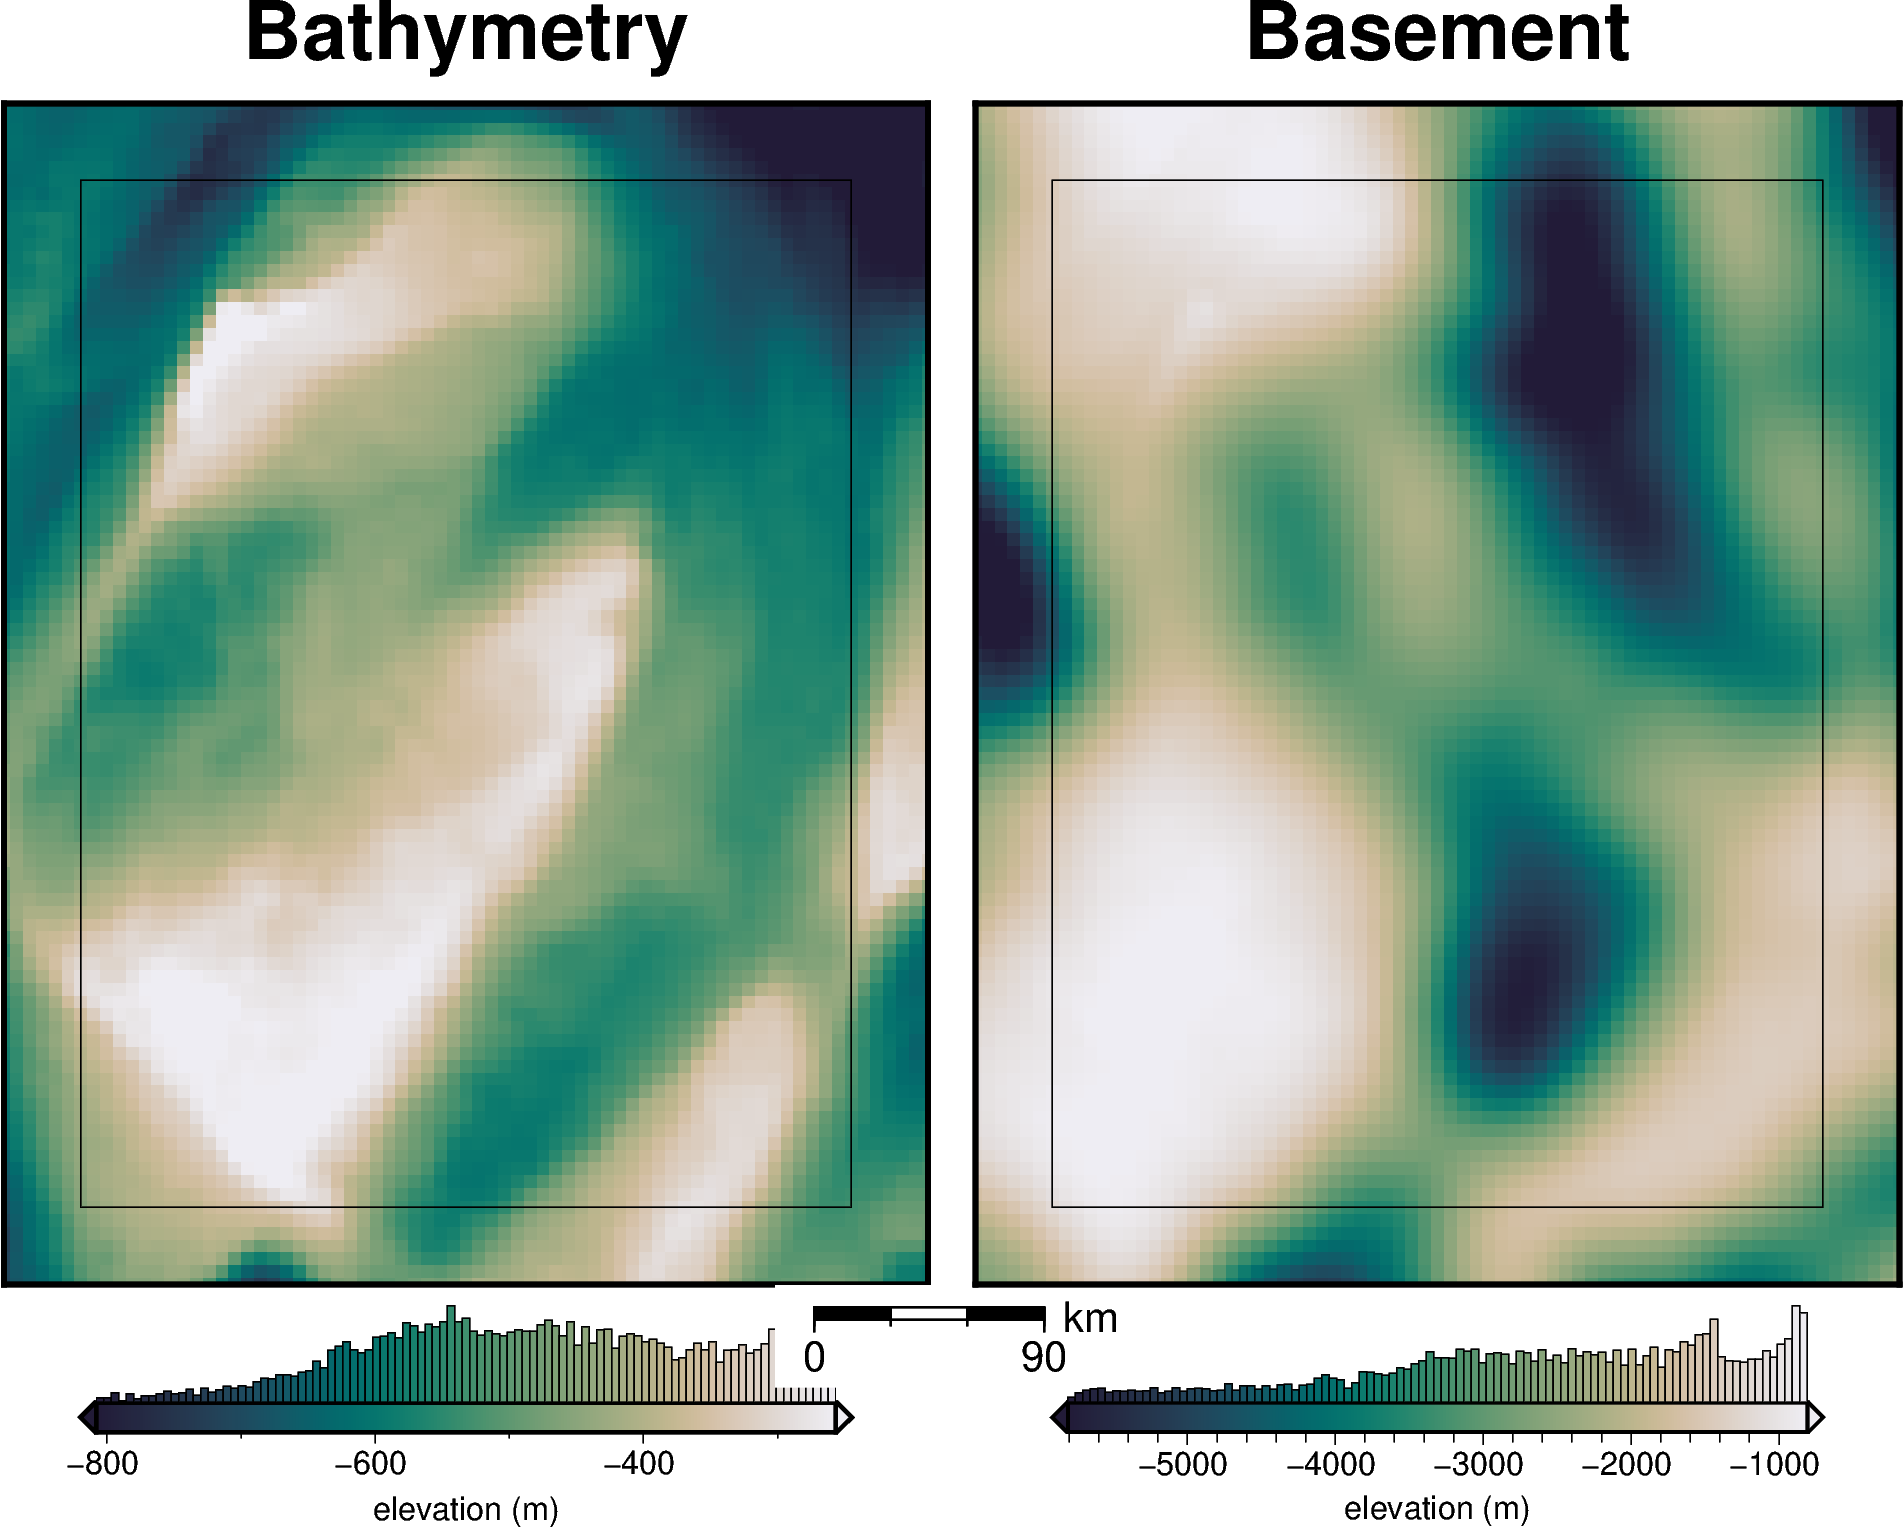

  0%|          | 0/4941 [00:00<?, ?it/s]

  0%|          | 0/4941 [00:00<?, ?it/s]

INFO:invert4geom:Standard deviation used for noise: [0.1]


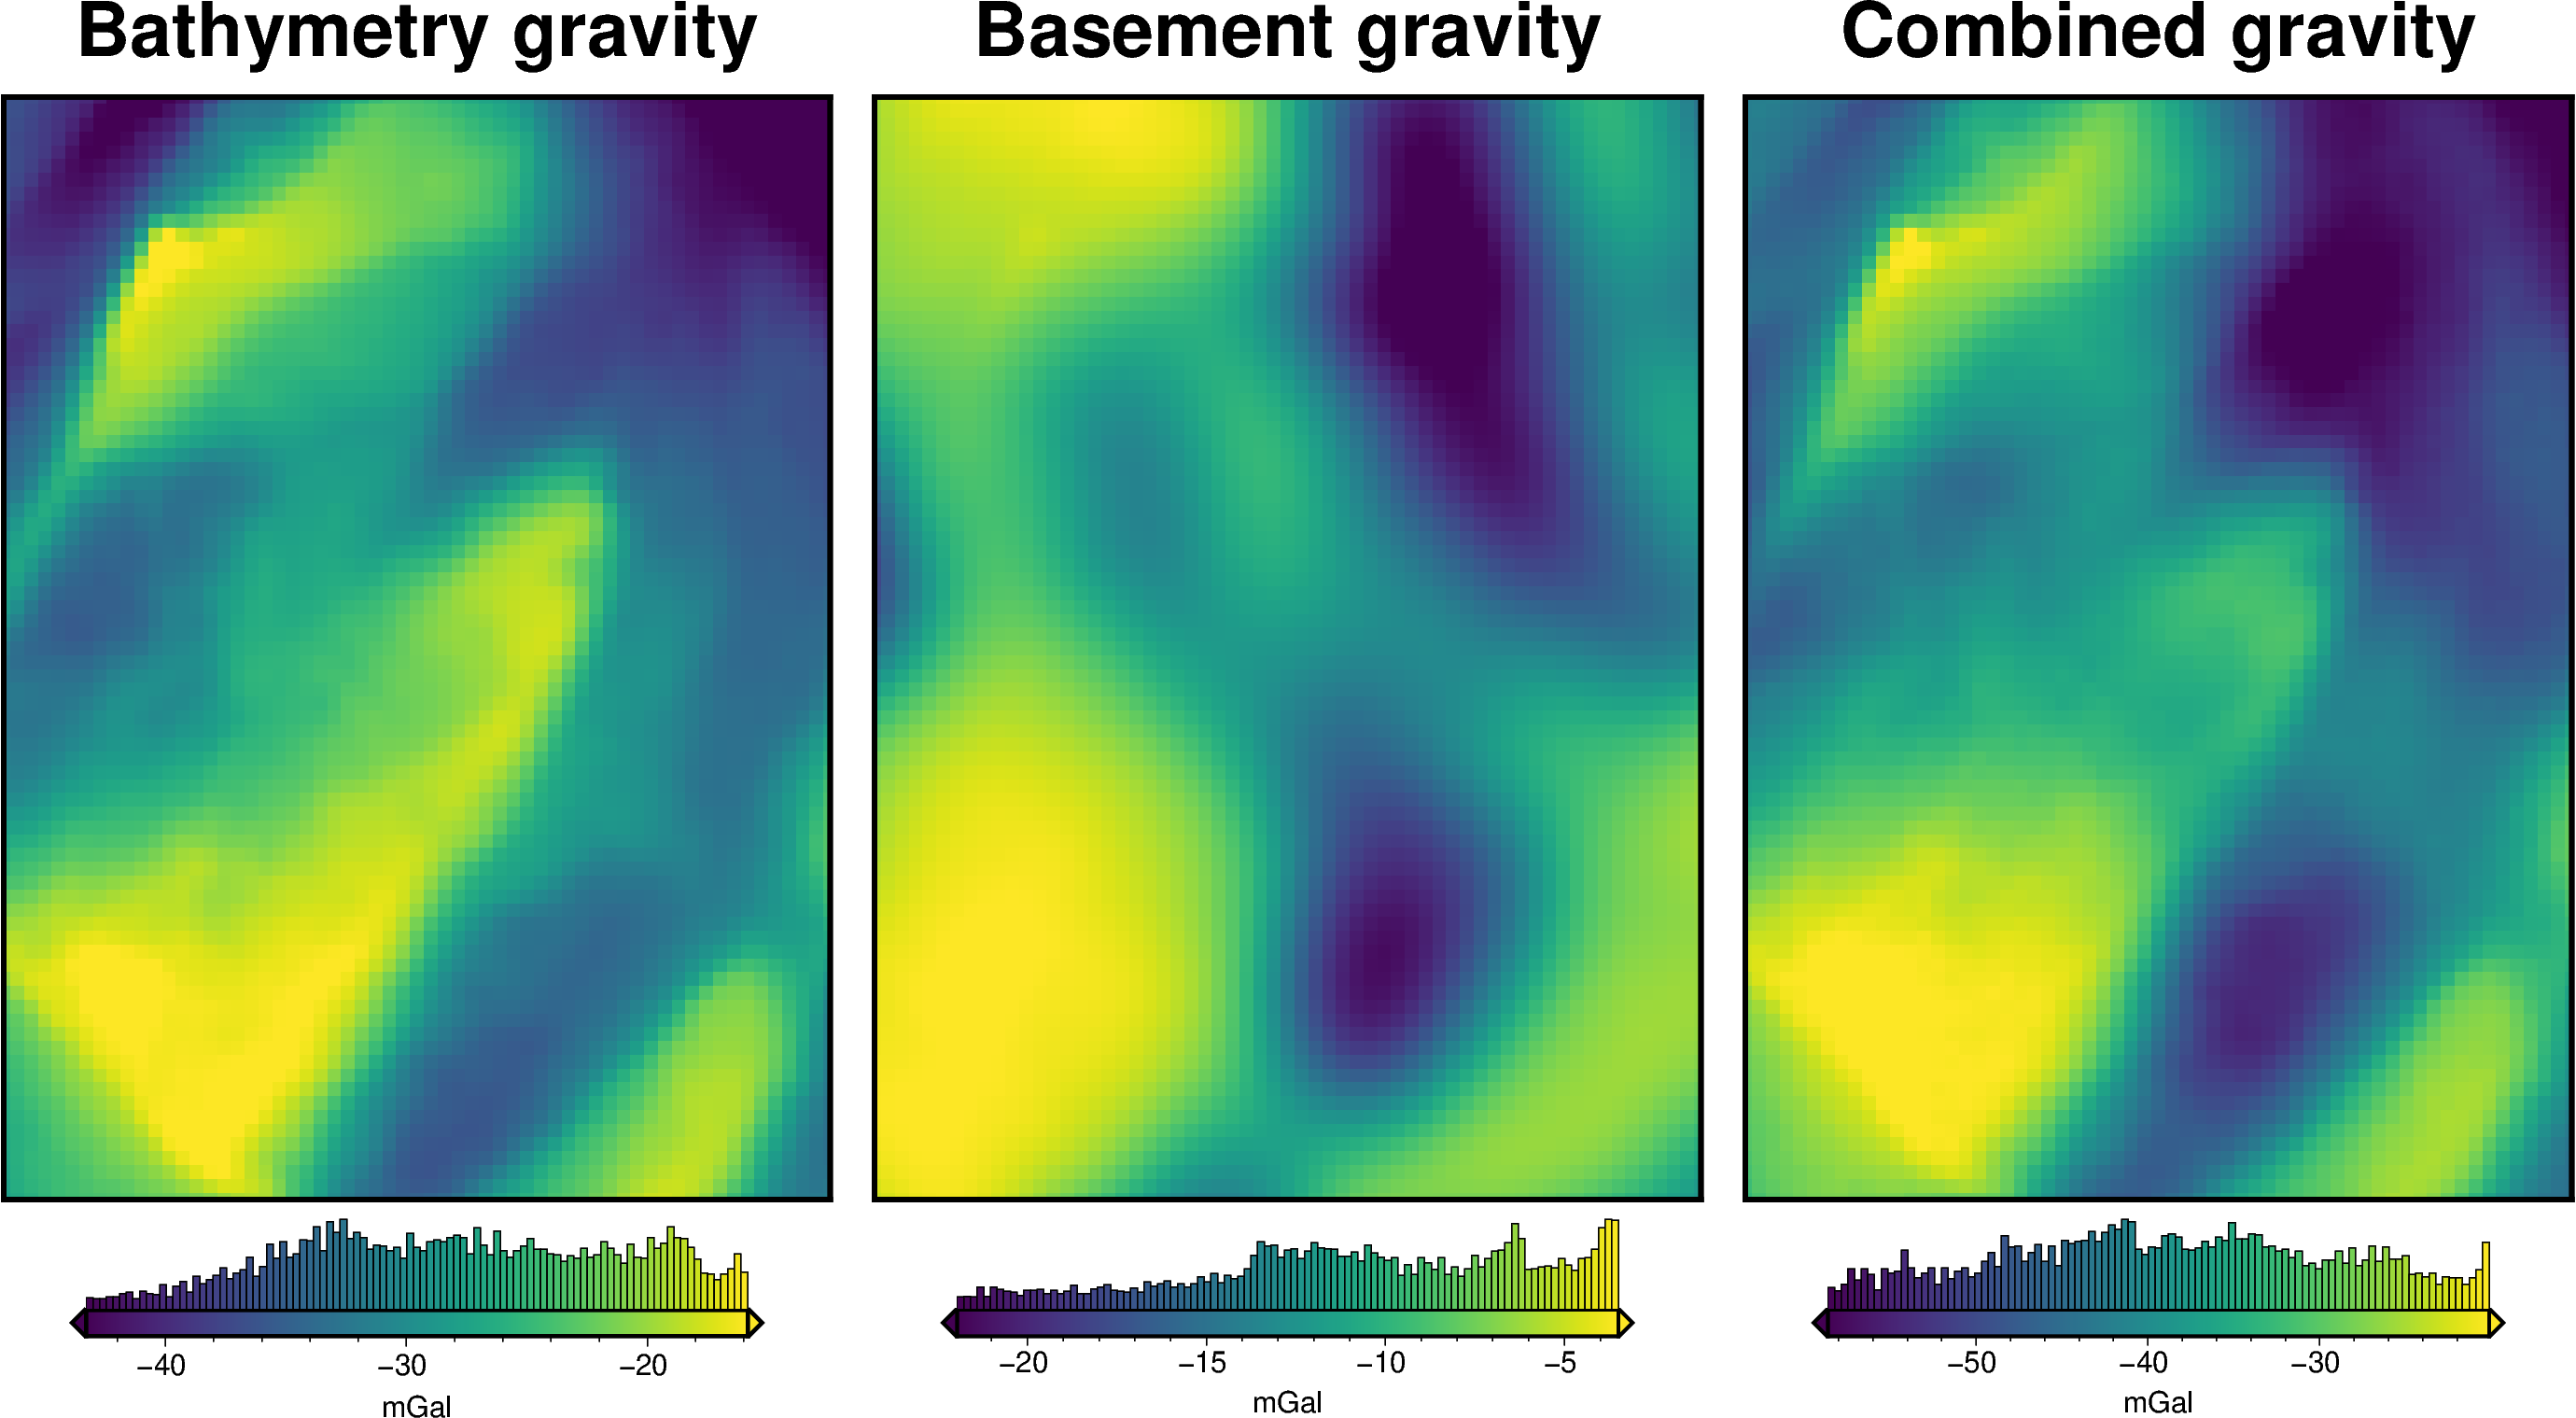

In [2]:
# set grid parameters
spacing = 5e3
inversion_region = (-40e3, 260e3, -1800e3, -1400e3)

bathymetry, basement, grav_df = RIS_synth.load_synthetic_model(
    spacing=5e3,
    buffer=spacing*6,
    basement=True,
    gravity_noise=0.1,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

In [3]:
grav_df

northing   easting  upward  bathymetry_grav  basement_grav  \
0    -1800000.0  -40000.0  1000.0       -28.040826      -4.951106   
1    -1800000.0  -35000.0  1000.0       -26.709299      -4.563569   
2    -1800000.0  -30000.0  1000.0       -25.914227      -4.247120   
3    -1800000.0  -25000.0  1000.0       -25.232045      -4.002321   
4    -1800000.0  -20000.0  1000.0       -24.606135      -3.845053   
...         ...       ...     ...              ...            ...   
4936 -1400000.0  240000.0  1000.0       -48.314171     -11.010032   
4937 -1400000.0  245000.0  1000.0       -48.346713     -11.801198   
4938 -1400000.0  250000.0  1000.0       -49.069446     -12.743445   
4939 -1400000.0  255000.0  1000.0       -49.867457     -13.761828   
4940 -1400000.0  260000.0  1000.0       -50.824624     -14.825797   

      disturbance  uncert  gravity_anomaly  
0      -32.978773     0.1       -32.978773  
1      -31.285491     0.1       -31.285491  
2      -30.096718     0.1       -30.096718  
3      -29.223288     0.1       -29.223288  
4      -28.504167     0.1       -28.504167  
...           ...     ...              ...  
4936   -59.148153     0.1       -59.148153  
4937   -60.245627     0.1       -60.245627  
4938   -61.668674     0.1       -61.668674  
4939   -63.781309     0.1       -63.781309  
4940   -65.703043     0.1       -65.703043  

[4941 rows x 8 columns]

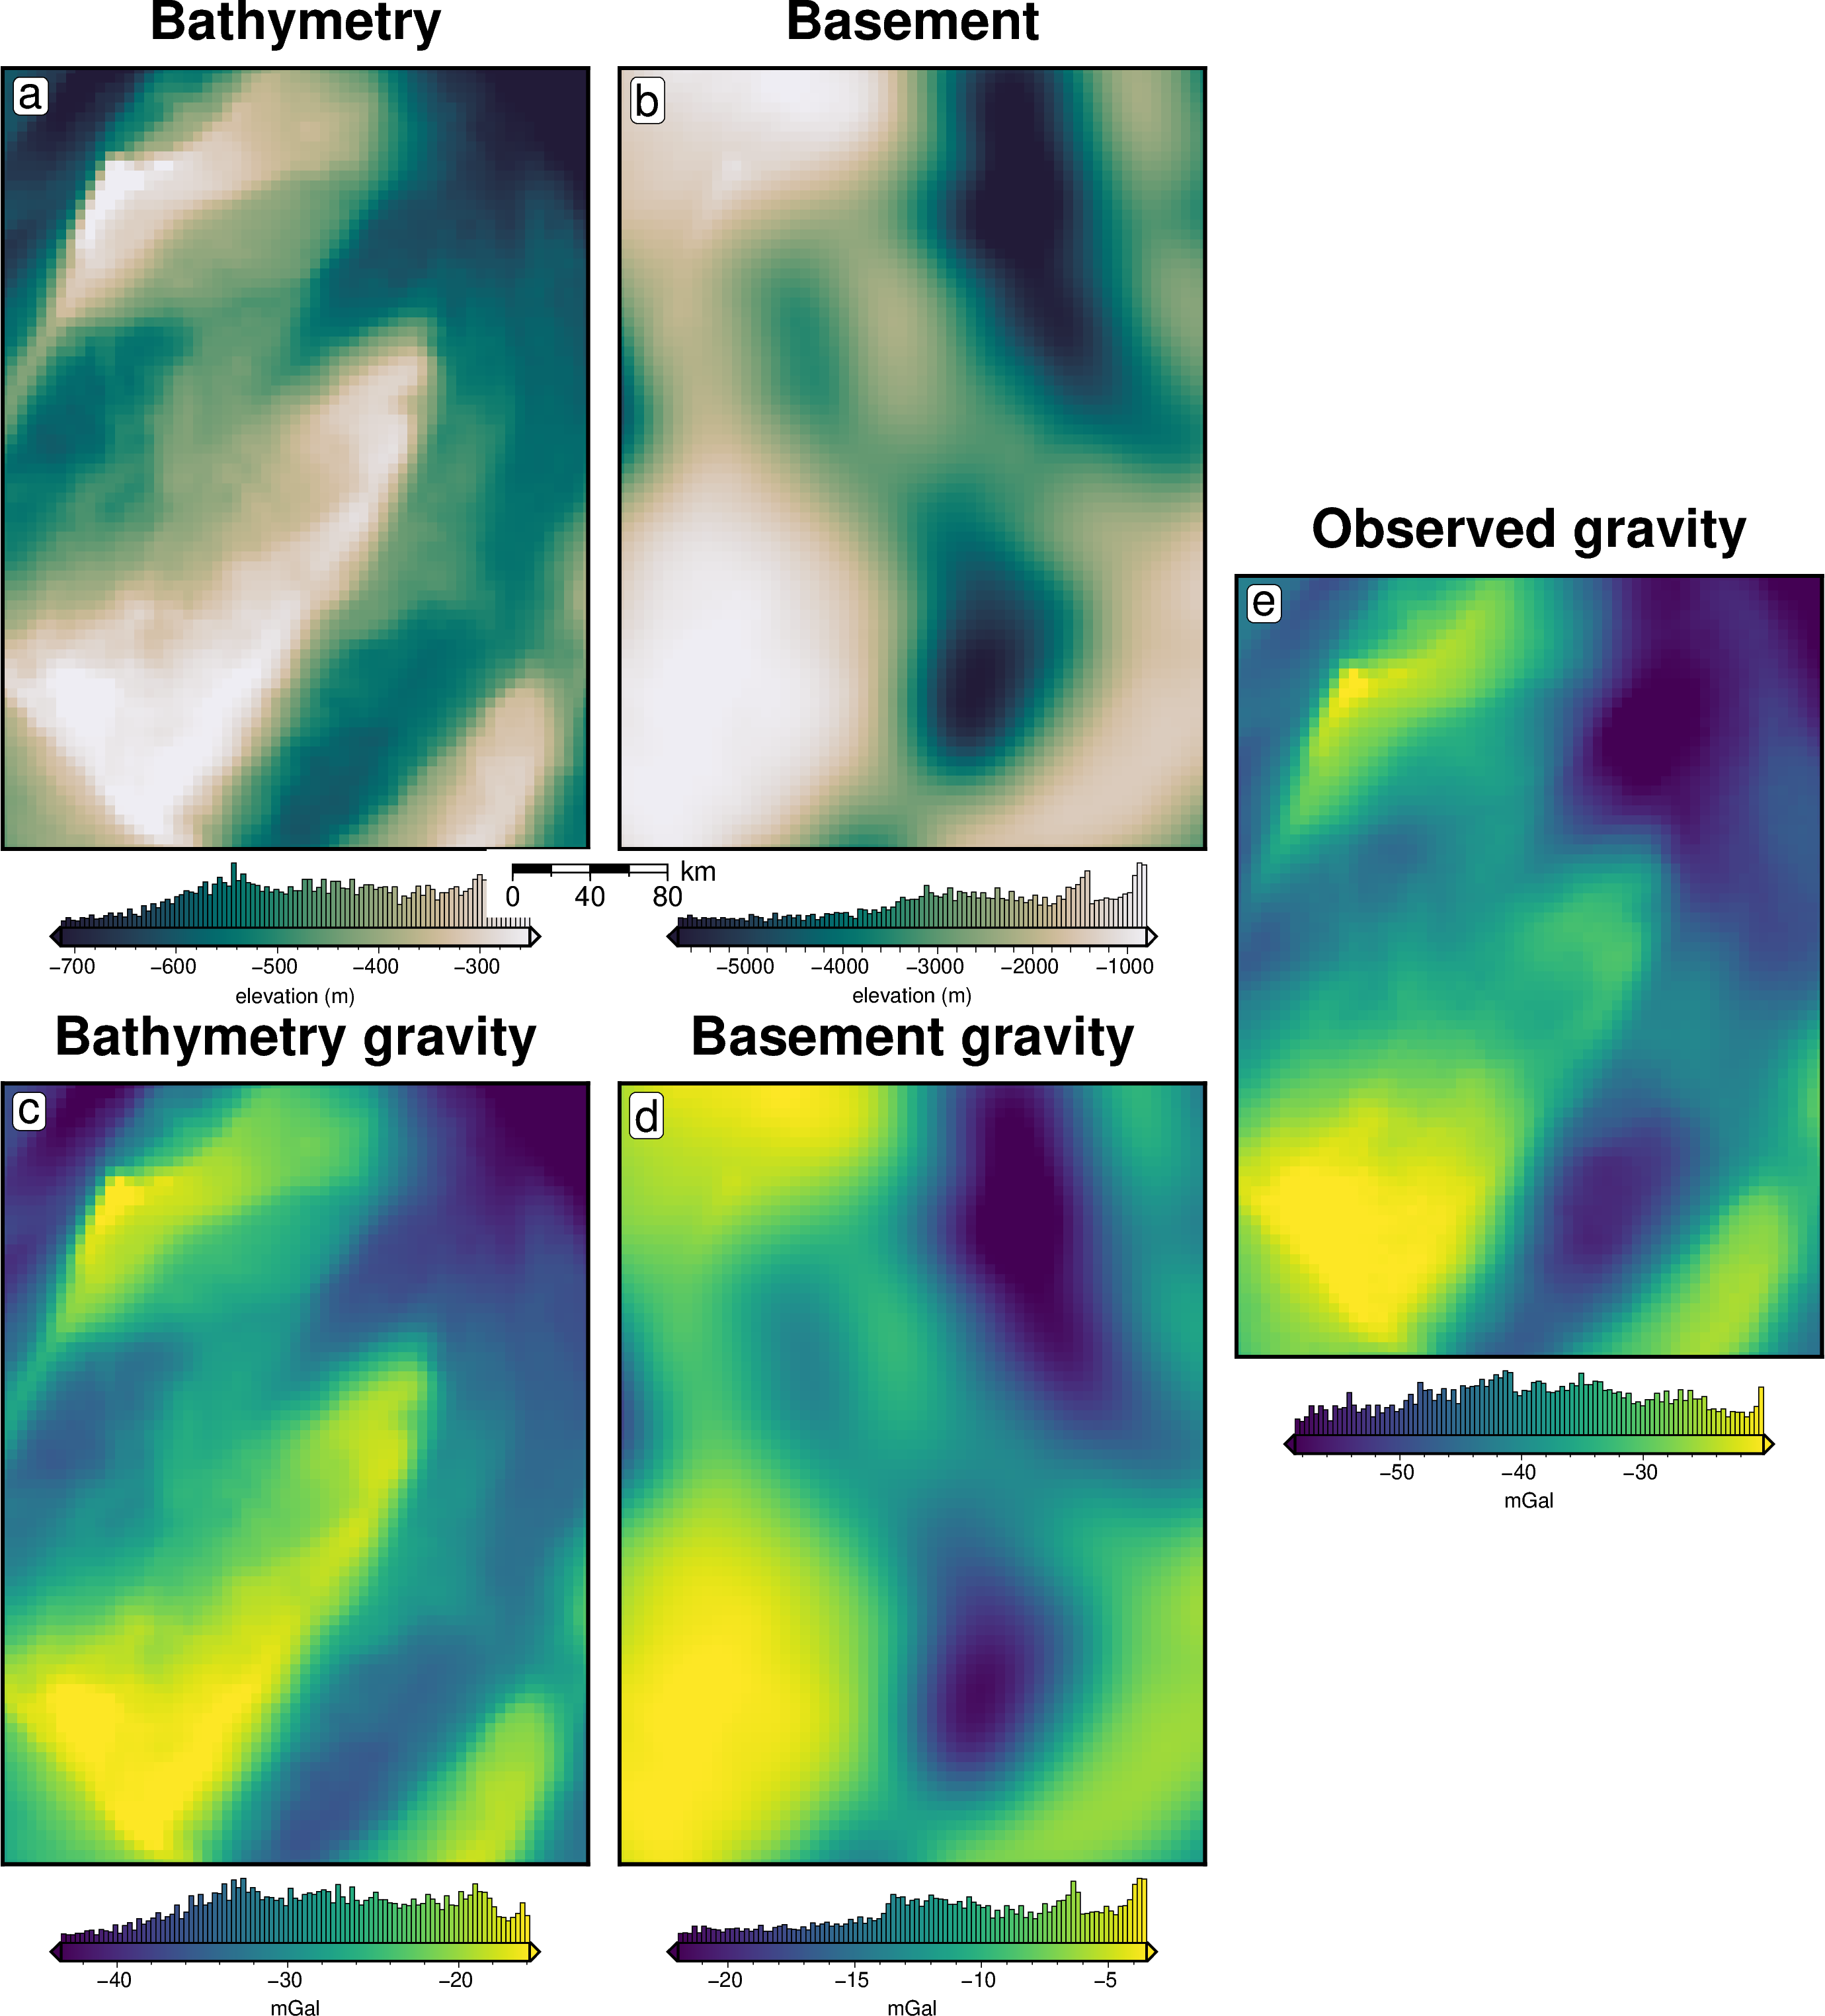

In [4]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    bathymetry,
    region=inversion_region,
    fig_height=10,
    title="Bathymetry",
    hist=True,
    cbar_yoffset=1,
    cmap="rain",
    reverse_cpt=True,
    cbar_label="elevation (m)",
    robust=True,
)
fig.text(
    position="TL",
    text="a",
    fill="white",
    pen=True,
    font="16p,Helvetica,black",
    offset="j.2/.2",
    clearance="+tO",
    no_clip=True,
)

fig = maps.plot_grd(
    basement,
    region=inversion_region,
    fig_height=10,
    title="Basement",
    hist=True,
    cbar_yoffset=1,
    cmap="rain",
    reverse_cpt=True,
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
    robust=True,
    # frame=["nSEw", "xaf10000", "yaf10000"],
    scalebar=True,
    scale_position="n-.05/-.03",
)
fig.text(
    position="TL",
    text="b",
    fill="white",
    pen=True,
    font="16p,Helvetica,black",
    offset="j.2/.2",
    clearance="+tO",
    no_clip=True,
)

# shift down and 3 to the left
fig = maps.plot_grd(
    grav_grid.bathymetry_grav,
    region=inversion_region,
    fig_height=10,
    title="Bathymetry gravity",
    hist=True,
    cbar_yoffset=1,
    cbar_label="mGal",
    fig=fig,
    origin_shift="both",
    xshift_amount=-1,
    yshift_amount=-1,
    robust=True,
)
fig.text(
    position="TL",
    text="c",
    fill="white",
    pen=True,
    font="16p,Helvetica,black",
    offset="j.2/.2",
    clearance="+tO",
    no_clip=True,
)
fig = maps.plot_grd(
    grav_grid.basement_grav,
    region=inversion_region,
    fig_height=10,
    title="Basement gravity",
    hist=True,
    cbar_yoffset=1,
    cbar_label="mGal",
    fig=fig,
    origin_shift="xshift",
    robust=True,
)
fig.text(
    position="TL",
    text="d",
    fill="white",
    pen=True,
    font="16p,Helvetica,black",
    offset="j.2/.2",
    clearance="+tO",
    no_clip=True,
)
fig = maps.plot_grd(
    grav_grid.disturbance,
    region=inversion_region,
    fig_height=10,
    title="Observed gravity",
    hist=True,
    cbar_yoffset=1,
    cbar_label="mGal",
    fig=fig,
    origin_shift="both",
    yshift_amount=.5,
    robust=True,
)
fig.text(
    position="TL",
    text="e",
    fill="white",
    pen=True,
    font="16p,Helvetica,black",
    offset="j.2/.2",
    clearance="+tO",
    no_clip=True,
)


fig.show()

# Make starting bathymetry model

In [5]:
num_constraints = 25

# semi-regularly spaced
constraint_points = RIS_synth.constraint_layout_number(
    num_constraints=num_constraints,
    shift_stdev=10e3,
    region=inversion_region,
    padding=-4*spacing,
)

# # randomly spaced constraints
# coords = vd.scatter_points(
#     region=vd.pad_region(
#     inversion_region, -2*spacing),
#     size=num_constraints,
#     random_state=1,
# )
# constraint_points = pd.DataFrame(
#     data={"easting": coords[0], "northing": coords[1]},
# )

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    bathymetry,
    "true_upward",
    coord_names=("easting", "northing"),
)
constraint_points["upward"] = constraint_points.true_upward
constraint_points.head()

northing        easting  true_upward      upward
2  -1.773596e+06  108407.749901  -582.853672 -582.853672
28 -1.424577e+06  163158.820332  -514.862631 -514.862631
13 -1.638188e+06  182813.114007  -466.116978 -466.116978
10 -1.642233e+06  -32590.655321  -523.126791 -523.126791
26 -1.427435e+06   49298.636948  -417.558562 -417.558562

In [6]:
# re-sample depths with uncertainty to emulate measurement errors
# set each points uncertainty equal to 5% of depth
uncert = np.abs(0.05 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "uncert"] = uncert

constraint_points = uncertainty.randomly_sample_data(
    seed=0,
    data_df=constraint_points,
    data_col="upward",
    uncert_col="uncert",
)

# create weights column
constraint_points["weight"] = 1 / (constraint_points.uncert**2)

constraint_points.head()

northing        easting  true_upward      upward     uncert    weight
2  -1.773596e+06  108407.749901  -582.853672 -579.189556  29.142684  0.001177
28 -1.424577e+06  163158.820332  -514.862631 -518.263424  25.743132  0.001509
13 -1.638188e+06  182813.114007  -466.116978 -451.191384  23.305849  0.001841
10 -1.642233e+06  -32590.655321  -523.126791 -520.382988  26.156340  0.001462
26 -1.427435e+06   49298.636948  -417.558562 -428.742229  20.877928  0.002294

In [7]:
# grid the sampled values using verde
starting_bathymetry = utils.create_topography(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=np.logspace(-40, 0, 50),
    weights=constraint_points.weight,
)

INFO:invert4geom:Best SplineCV score: -4.45603530788647
INFO:invert4geom:Best damping: 4.7148663634573897e-17


In [8]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    starting_bathymetry,
    "starting_bathymetry",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.starting_bathymetry)
print(f"RMSE: {rmse:.2f} m")

RMSE: 22.00 m


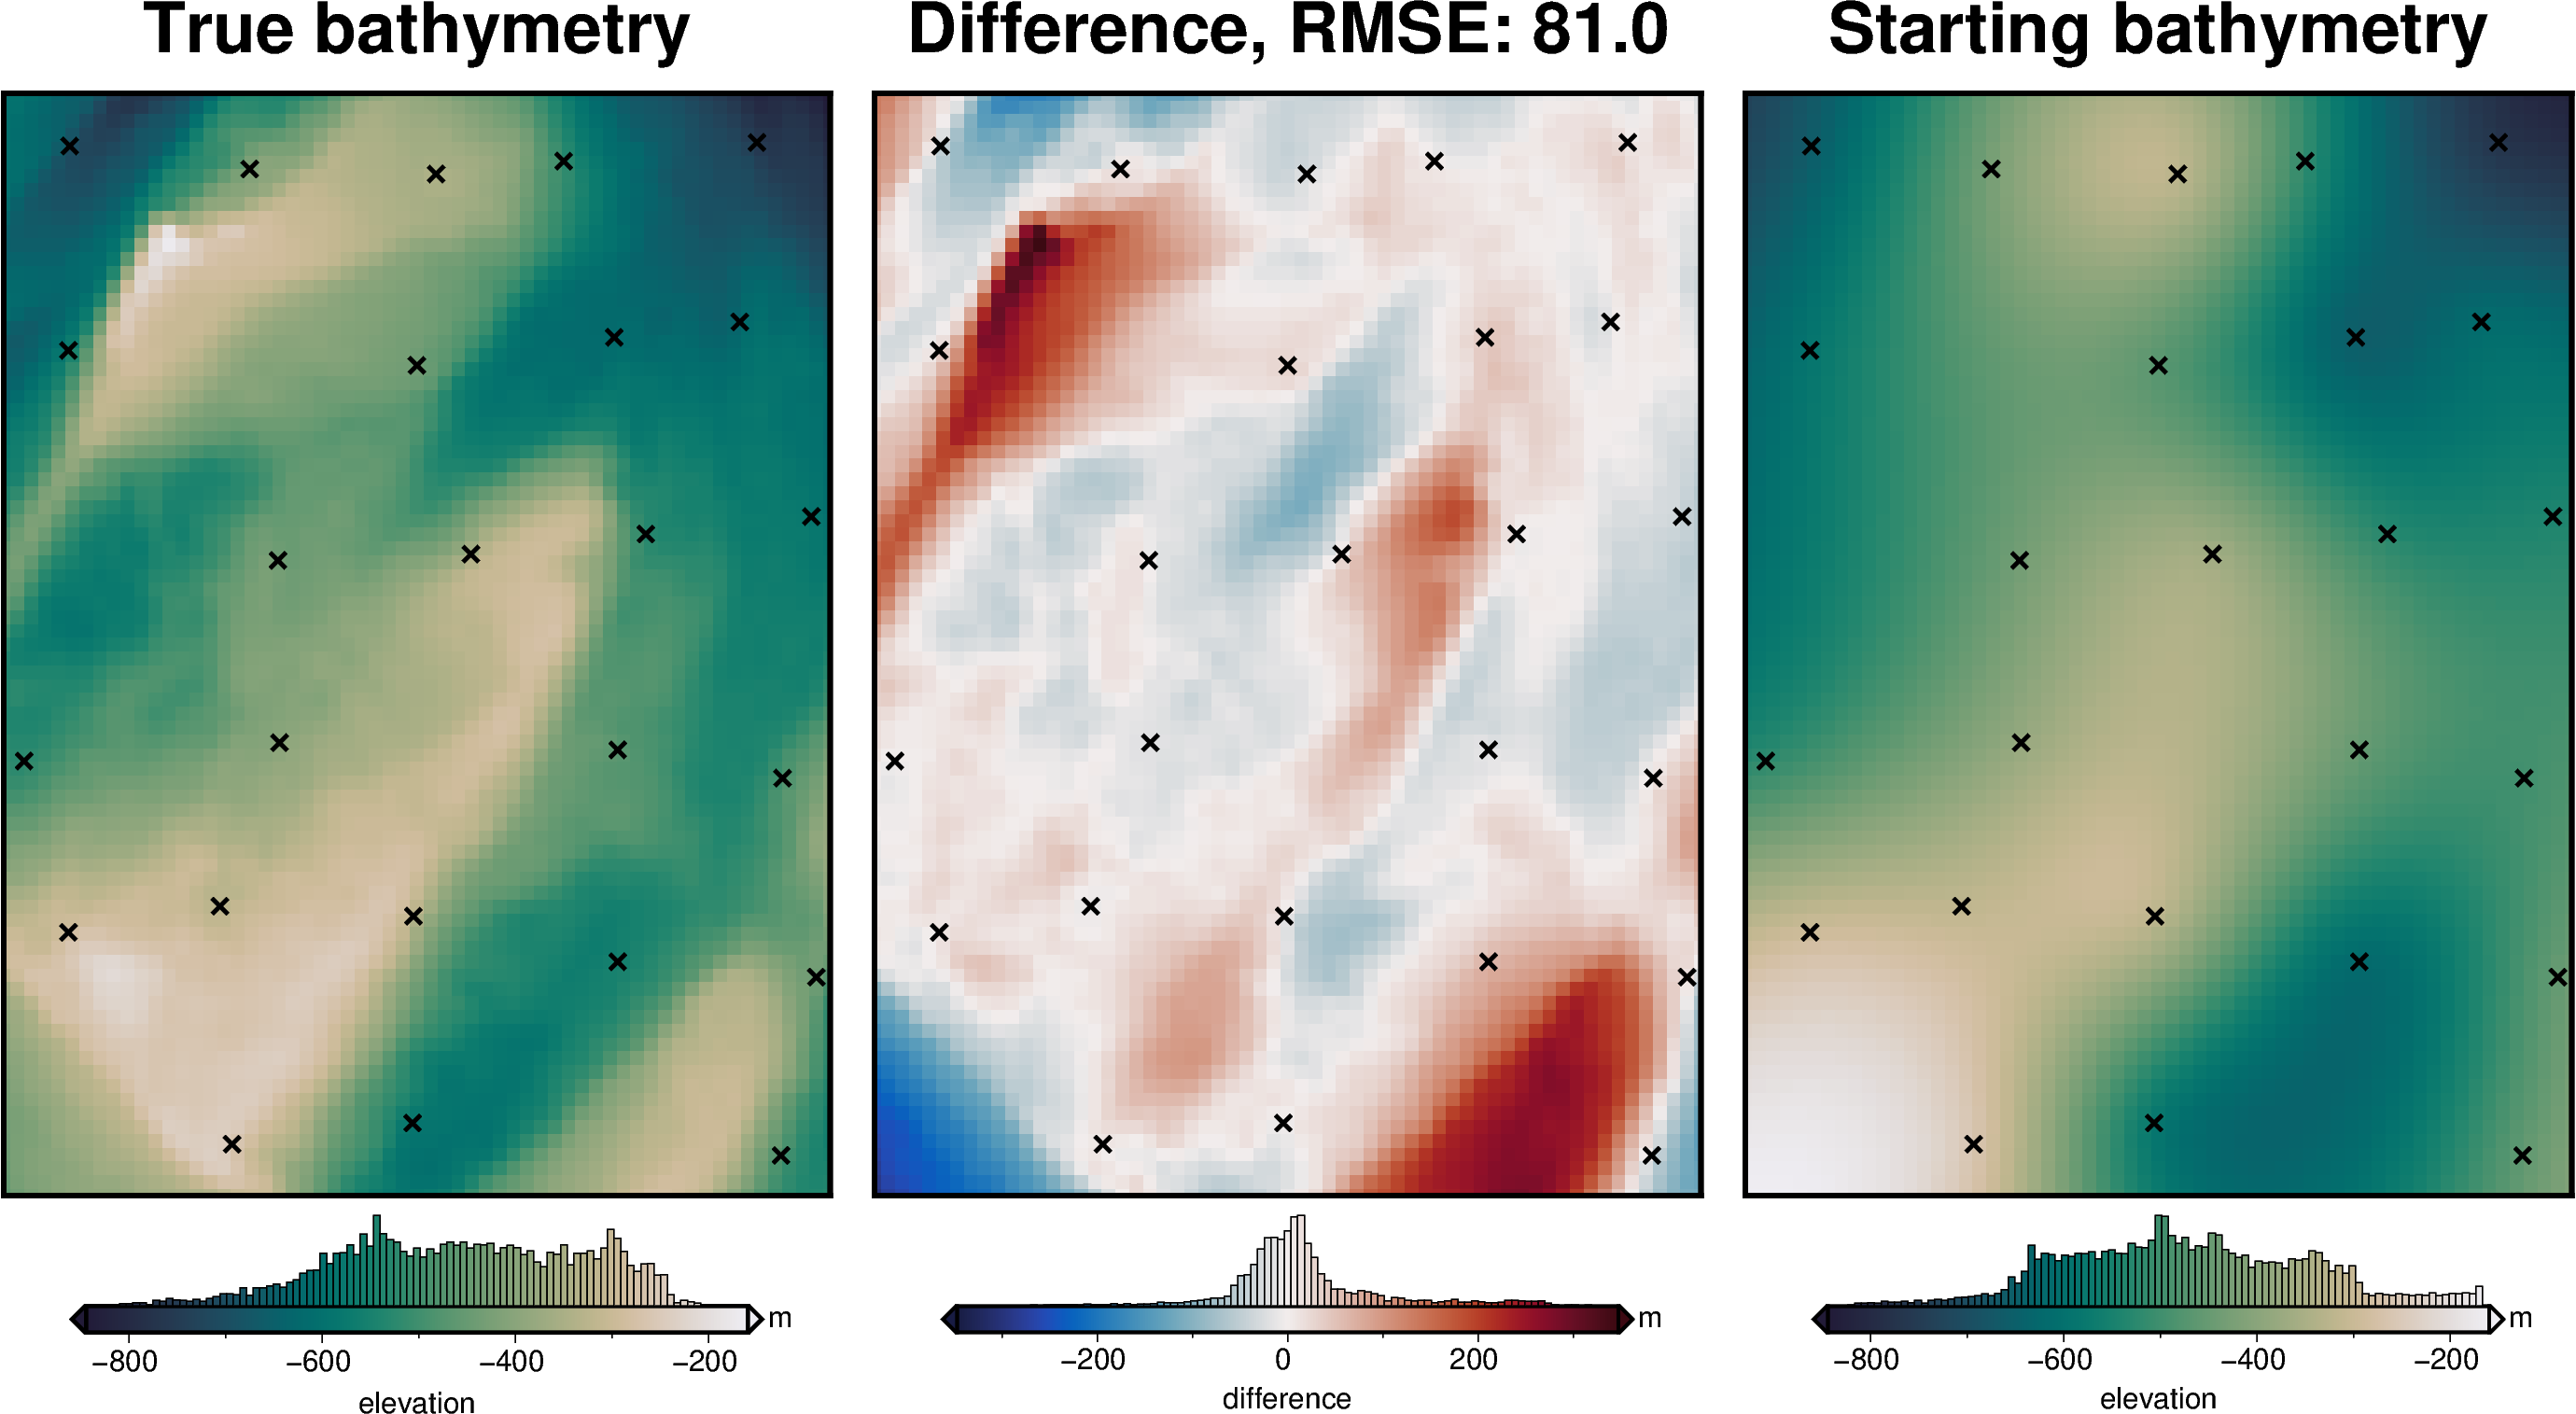

In [9]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True bathymetry",
    grid2_name="Starting bathymetry",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
)

In [10]:
# the true density contrast is 1476 kg/m3
density_contrast = 1476

# set the reference level from the prisms to 0
zref = 0

density_grid = xr.where(
    starting_bathymetry >=  zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)

grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

northing   easting  upward  bathymetry_grav  basement_grav  \
0    -1800000.0  -40000.0  1000.0       -28.040826      -4.951106   
1    -1800000.0  -35000.0  1000.0       -26.709299      -4.563569   
2    -1800000.0  -30000.0  1000.0       -25.914227      -4.247120   
3    -1800000.0  -25000.0  1000.0       -25.232045      -4.002321   
4    -1800000.0  -20000.0  1000.0       -24.606135      -3.845053   
...         ...       ...     ...              ...            ...   
4936 -1400000.0  240000.0  1000.0       -48.314171     -11.010032   
4937 -1400000.0  245000.0  1000.0       -48.346713     -11.801198   
4938 -1400000.0  250000.0  1000.0       -49.069446     -12.743445   
4939 -1400000.0  255000.0  1000.0       -49.867457     -13.761828   
4940 -1400000.0  260000.0  1000.0       -50.824624     -14.825797   

      disturbance  uncert  gravity_anomaly  starting_gravity  
0      -32.978773     0.1       -32.978773         -9.816314  
1      -31.285491     0.1       -31.285491         -9.839073  
2      -30.096718     0.1       -30.096718         -9.892305  
3      -29.223288     0.1       -29.223288         -9.979860  
4      -28.504167     0.1       -28.504167        -10.105282  
...           ...     ...              ...               ...  
4936   -59.148153     0.1       -59.148153        -48.075607  
4937   -60.245627     0.1       -60.245627        -48.506904  
4938   -61.668674     0.1       -61.668674        -48.852233  
4939   -63.781309     0.1       -63.781309        -49.120923  
4940   -65.703043     0.1       -65.703043        -49.318085  

[4941 rows x 9 columns]

# Regional misfit

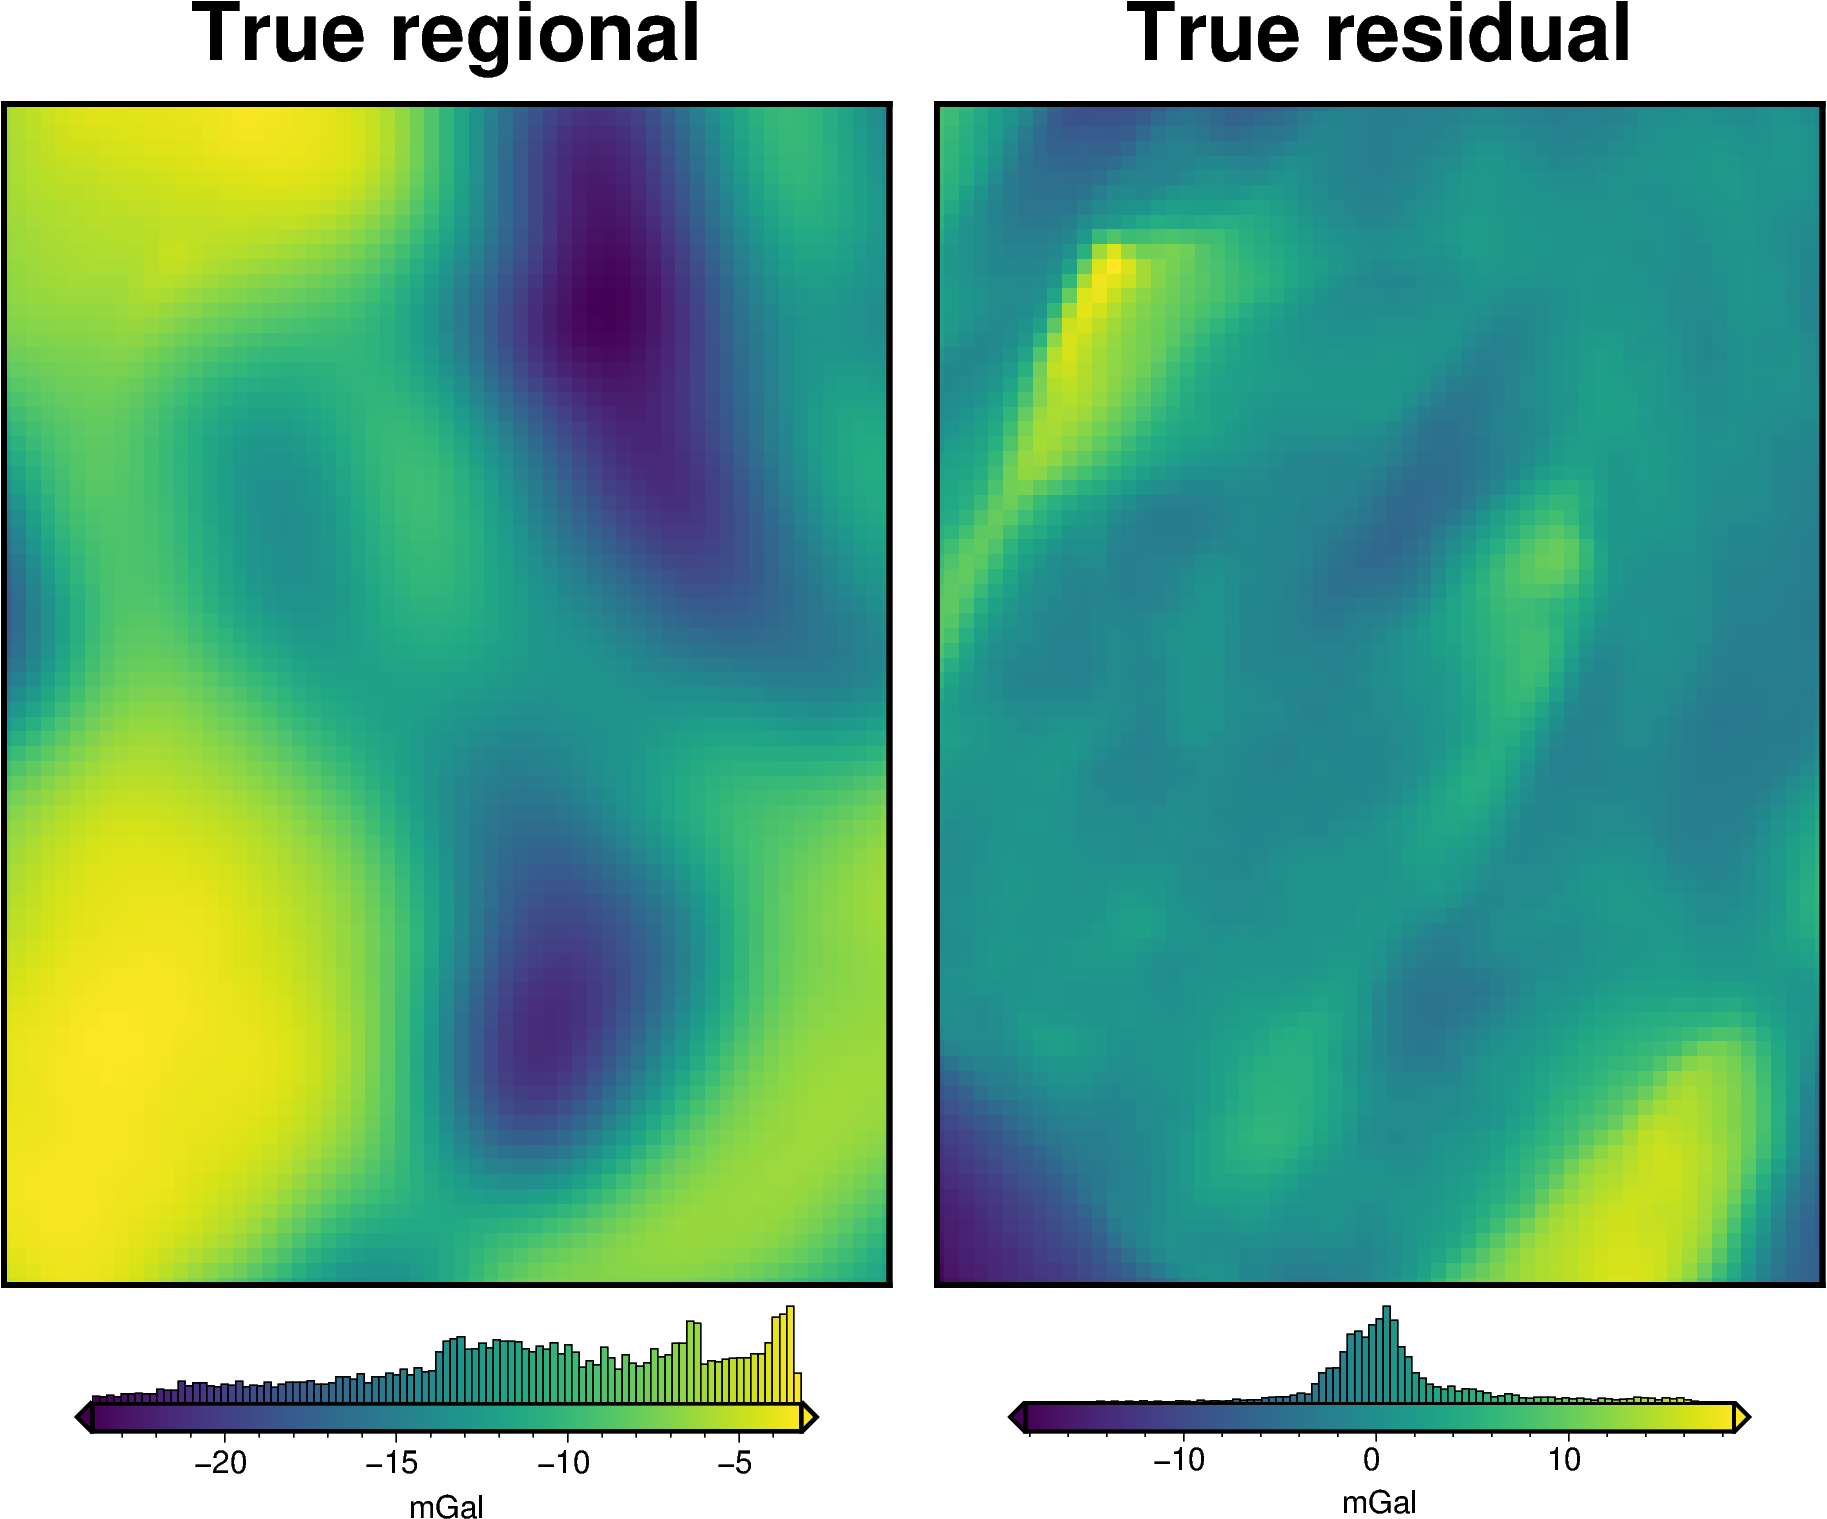

In [11]:
# calculate the true residual misfit
grav_df["true_res"] = (
    grav_df.bathymetry_grav - grav_df.starting_gravity
)

# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.basement_grav,
    fig_height=10,
    title="True regional",
    hist=True,
    cbar_yoffset=1,
    cbar_label="mGal",
)

fig = maps.plot_grd(
    grav_grid.true_res,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="True residual",
    hist=True,
    cbar_yoffset=1,
    cbar_label="mGal",
)

fig.show()

In [12]:
def regional_comparison(df):
    # grid the results
    grav_grid = df.set_index(["northing", "easting"]).to_xarray()

    # compare with true regional
    _ = polar_utils.grd_compare(
        grav_grid.basement_grav,
        grav_grid.reg,
        plot=True,
        grid1_name="True regional misfit",
        grid2_name="Regional misfit",
        hist=True,
        cbar_yoffset=1,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )
    # compare with true residual
    _ = polar_utils.grd_compare(
        grav_grid.true_res,
        grav_grid.res,
        plot=True,
        grid1_name="True residual misfit",
        grid2_name="Residual misfit",
        cmap="balance+h0",
        hist=True,
        cbar_yoffset=1,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )

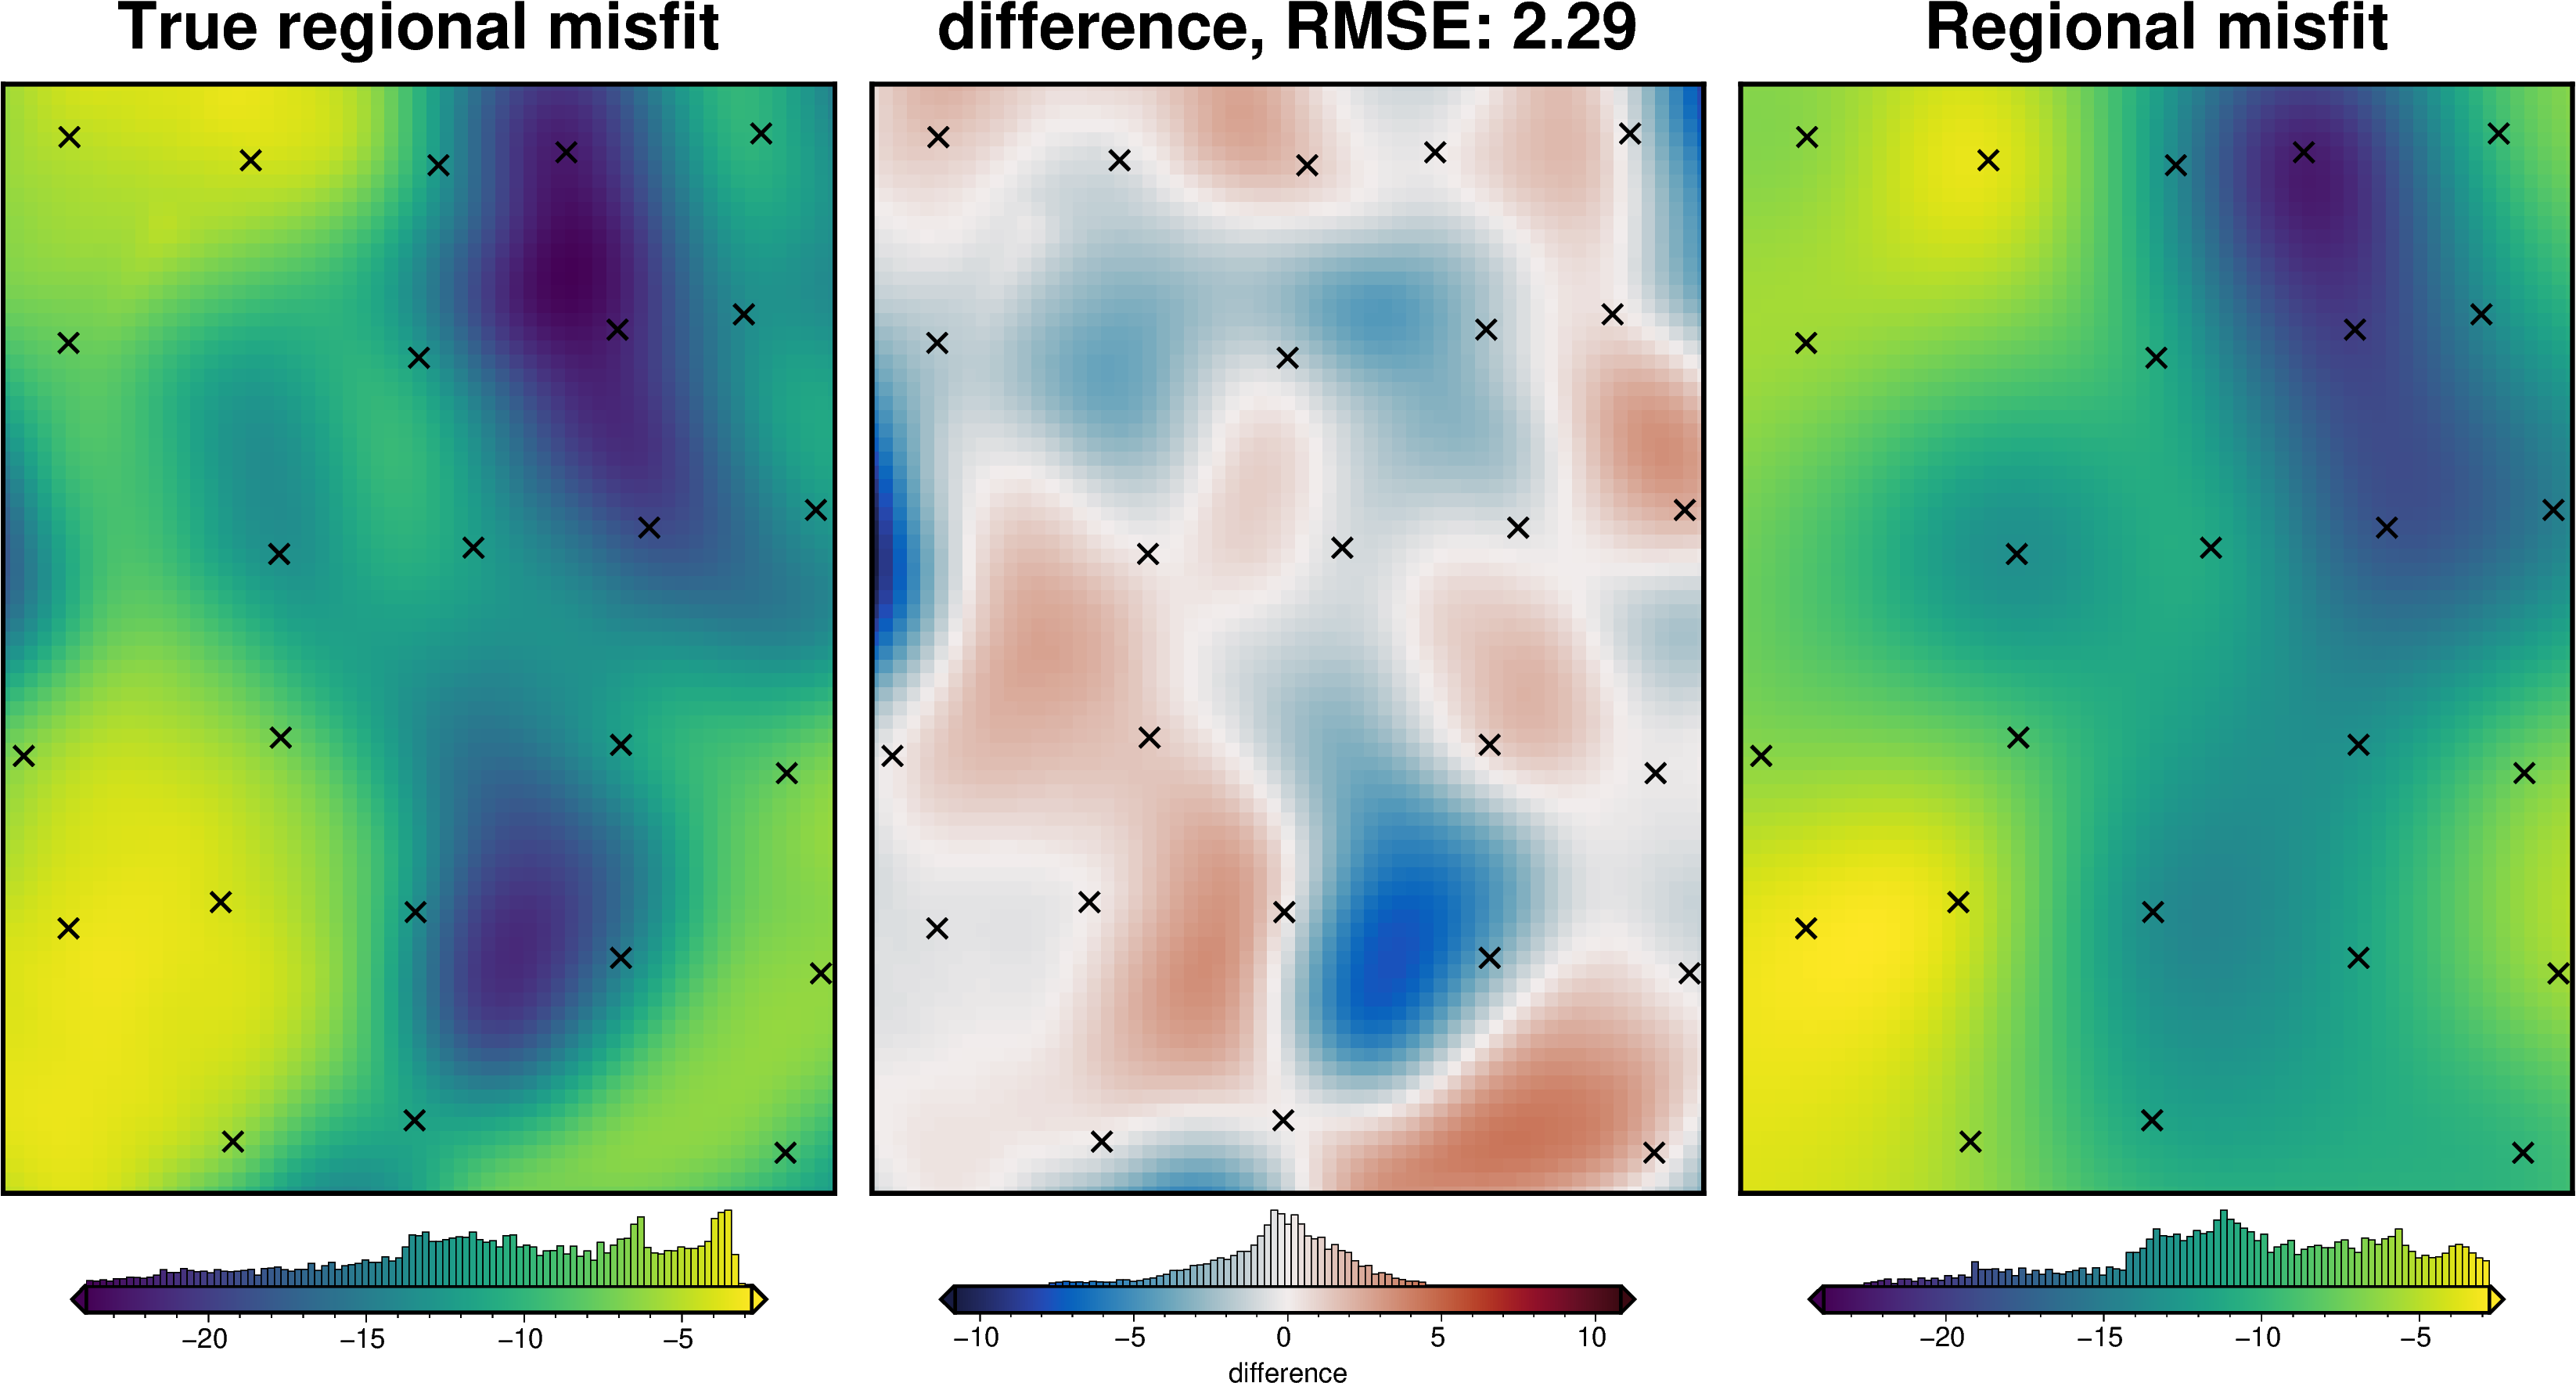

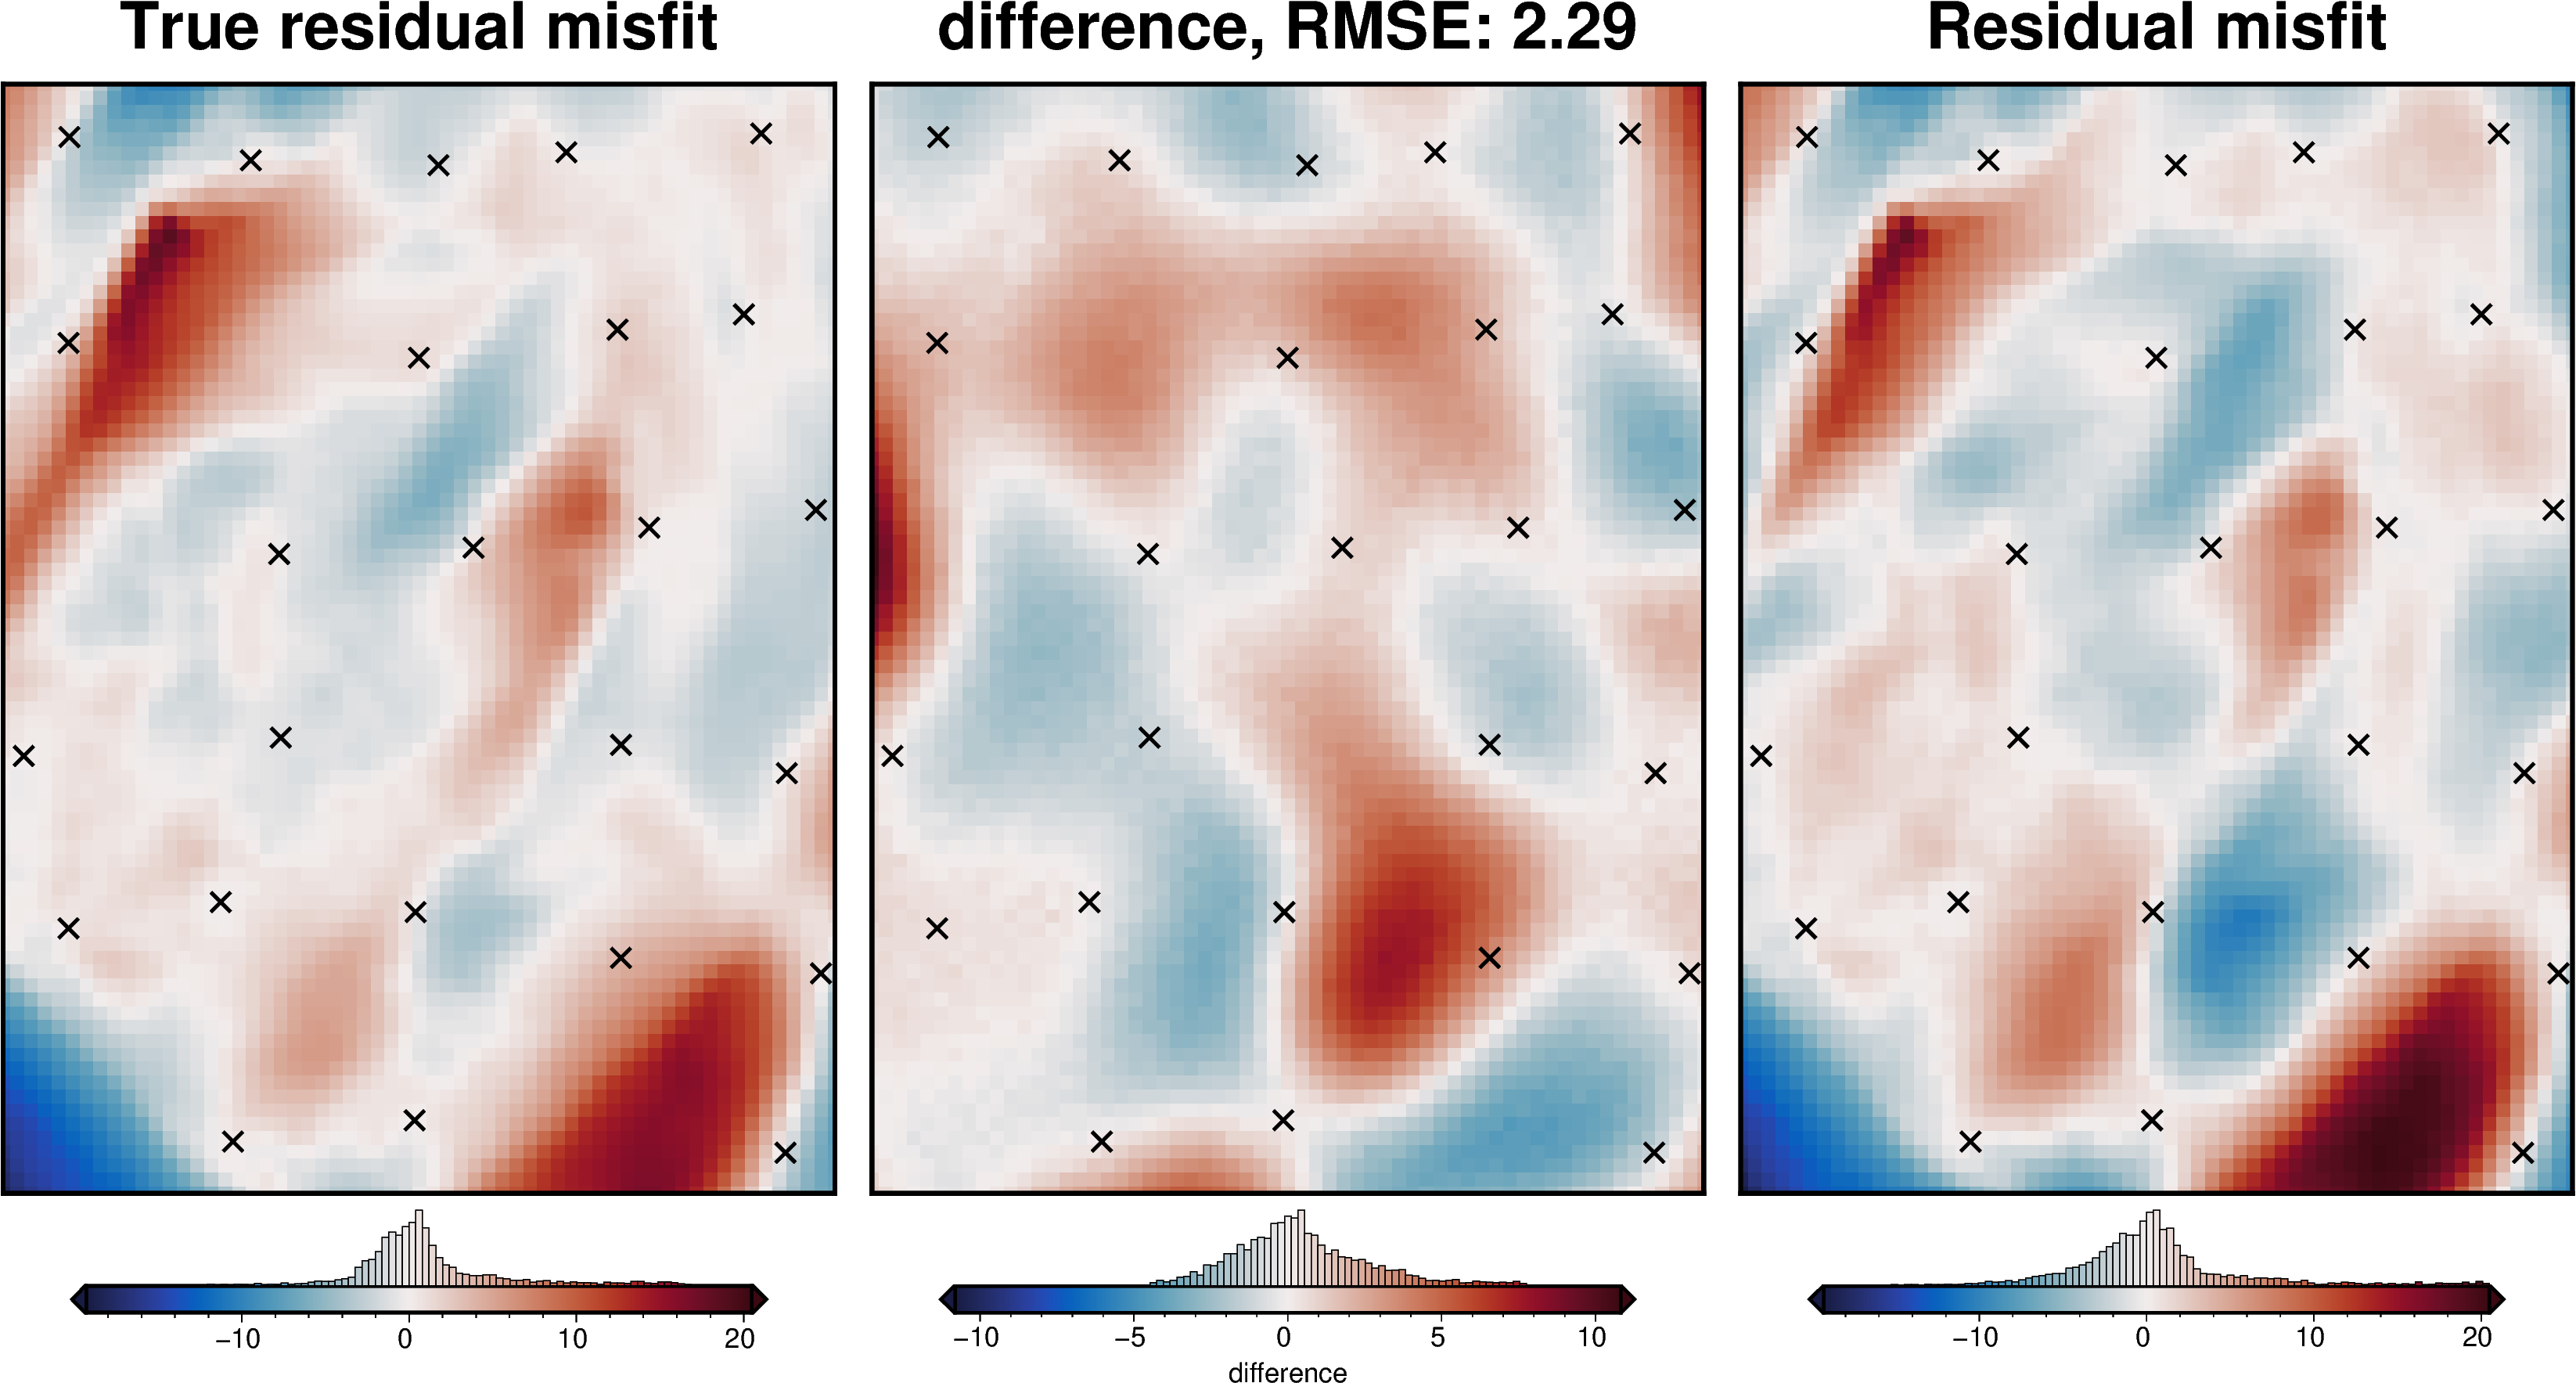

northing       easting  upward  bathymetry_grav  basement_grav  \
count  4.941000e+03    4941.00000  4941.0      4941.000000    4941.000000   
mean  -1.600000e+06  110000.00000  1000.0       -28.070870     -10.852946   
std    1.169164e+05   88042.99419     0.0         7.266126       5.083802   
min   -1.800000e+06  -40000.00000  1000.0       -50.824624     -23.867553   
25%   -1.700000e+06   35000.00000  1000.0       -33.374408     -13.886299   
50%   -1.600000e+06  110000.00000  1000.0       -28.032221     -10.546448   
75%   -1.500000e+06  185000.00000  1000.0       -21.979556      -6.530618   
max   -1.400000e+06  260000.00000  1000.0       -13.086187      -3.195846   

       disturbance        uncert  gravity_anomaly  starting_gravity  \
count  4941.000000  4.941000e+03      4941.000000       4941.000000   
mean    -38.923816  1.000000e-01       -38.923816        -28.996205   
std      10.422045  1.387919e-17        10.422045          7.458950   
min     -65.703043  1.000000e-01       -65.703043        -49.318085   
25%     -46.644595  1.000000e-01       -46.644595        -34.481041   
50%     -38.961996  1.000000e-01       -38.961996        -29.481902   
75%     -31.047412  1.000000e-01       -31.047412        -23.696673   
max     -16.781652  1.000000e-01       -16.781652         -9.816314   

          true_res       misfit          reg          res  
count  4941.000000  4941.000000  4941.000000  4941.000000  
mean      0.925335    -9.927611   -10.368999     0.441387  
std       4.653332     6.967151     4.415225     5.294157  
min     -18.224512   -25.058632   -22.506106   -19.295057  
25%      -1.256610   -14.650196   -13.036073    -2.148846  
50%       0.279388   -10.545365   -10.425771     0.034438  
75%       1.999969    -5.426444    -6.745939     1.915979  
max      18.581314    13.577454    -2.787917    20.478892

In [17]:
# estimate regional with the mean misfit at constraints
regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    constraints_df=constraint_points,
    constraints_weights_column="weight",
    # cv=True,
    # cv_kwargs=dict(
    #     n_trials=20,
    #     damping_limits=(1e-60, 10),
    #     progressbar=False,
    #     fname="tmp_regional_sep",
    # ),
    damping=None,
    depth="default",
    block_size=None,
)

grav_df = regional.regional_separation(
    grav_df=grav_df,
    **regional_grav_kwargs,
)

regional_comparison(grav_df)
grav_df.describe()

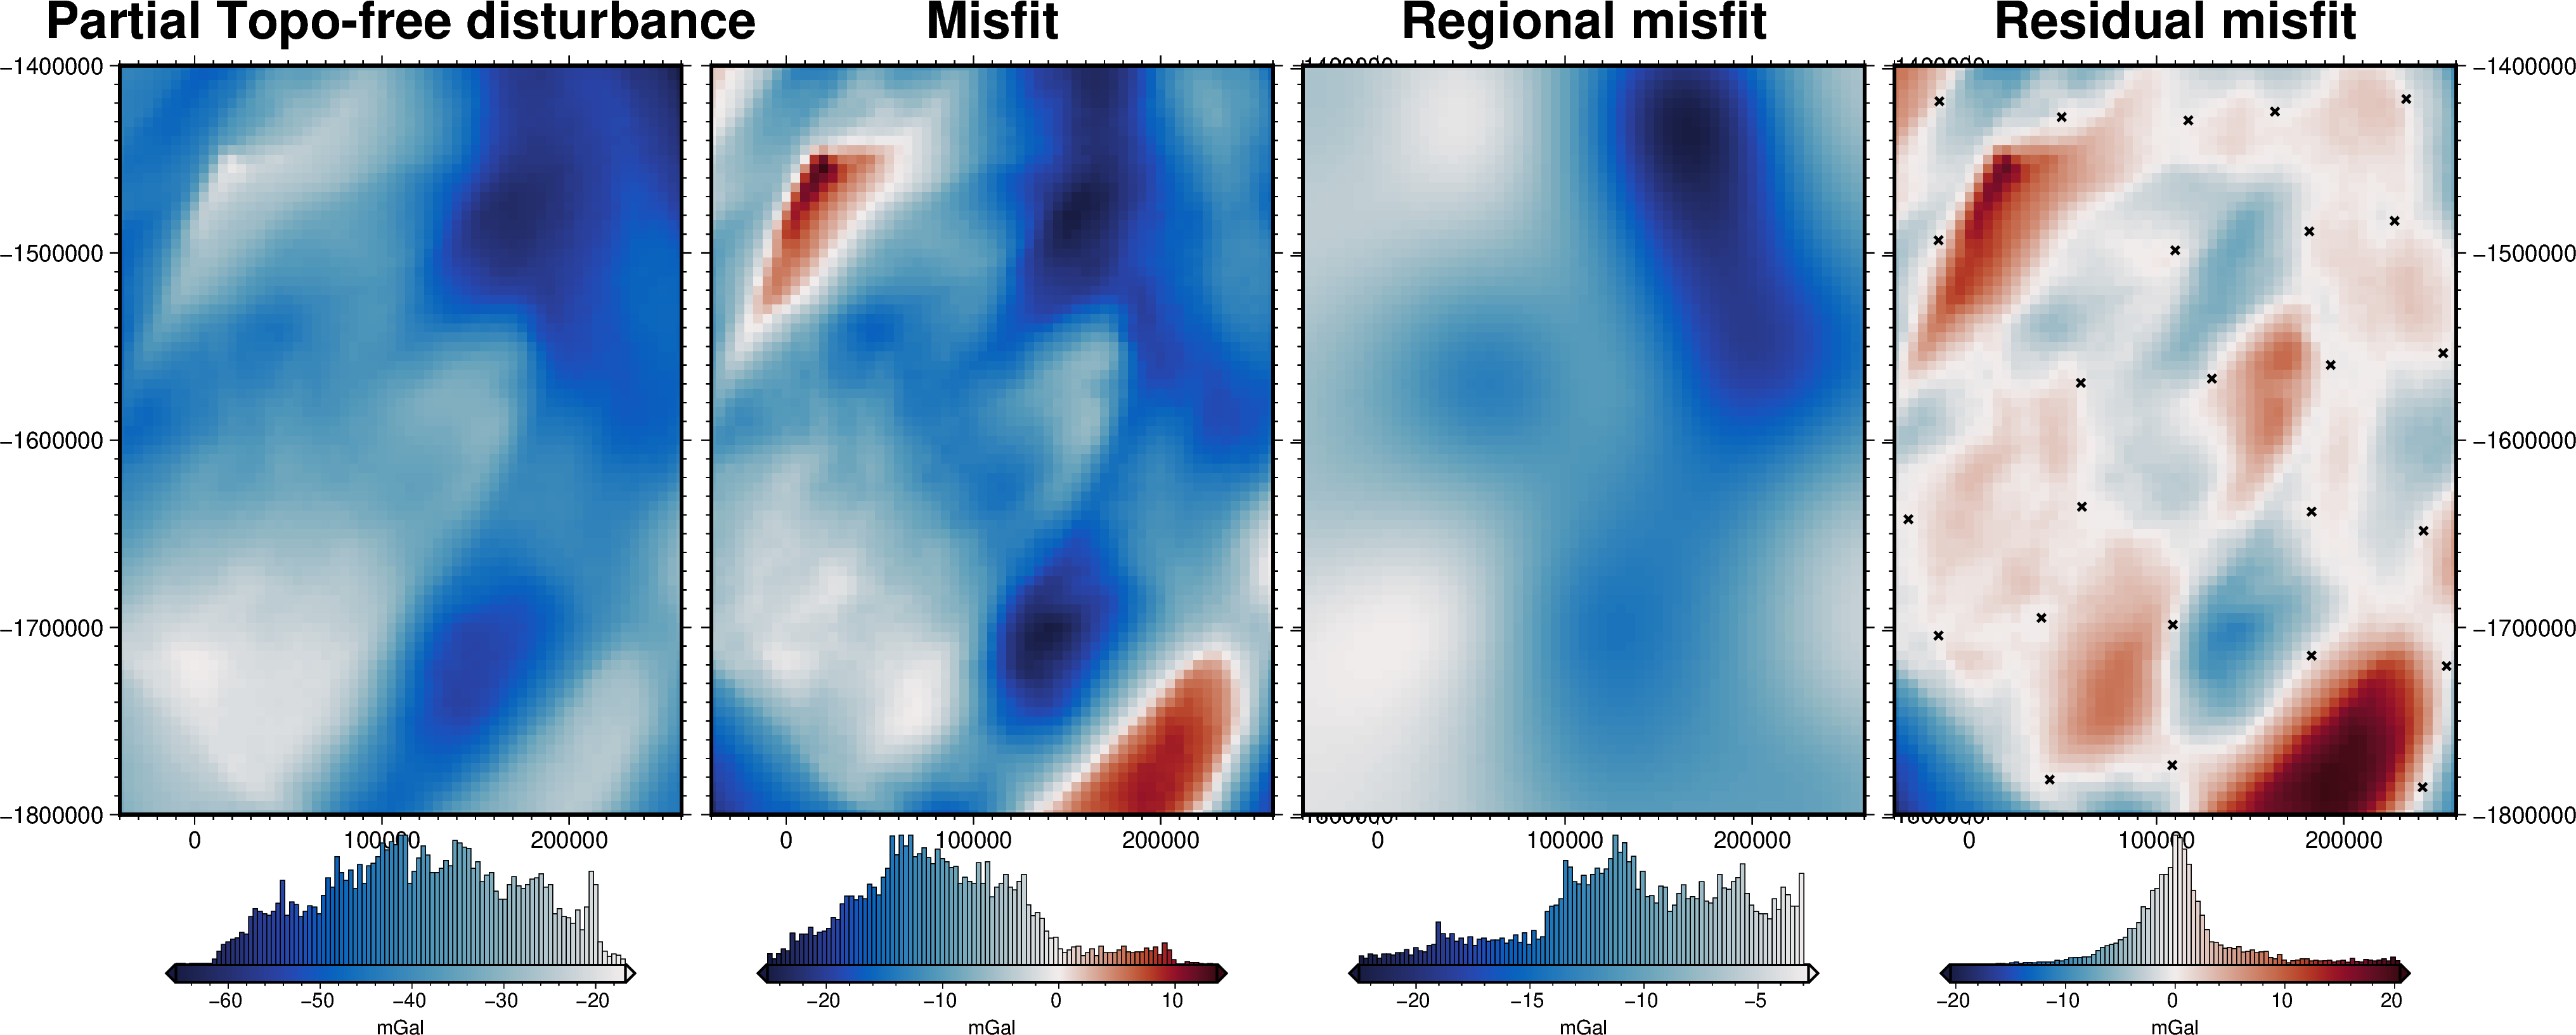

In [18]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Partial Topo-free disturbance",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)
fig.show()

# Weighting grid

In [19]:
weighting_grid = utils.normalized_mindist(
    constraint_points,
    starting_bathymetry,
    low=0,
    high=1,
)
min_dist_grid = utils.normalized_mindist(
    constraint_points,
    starting_bathymetry,
)

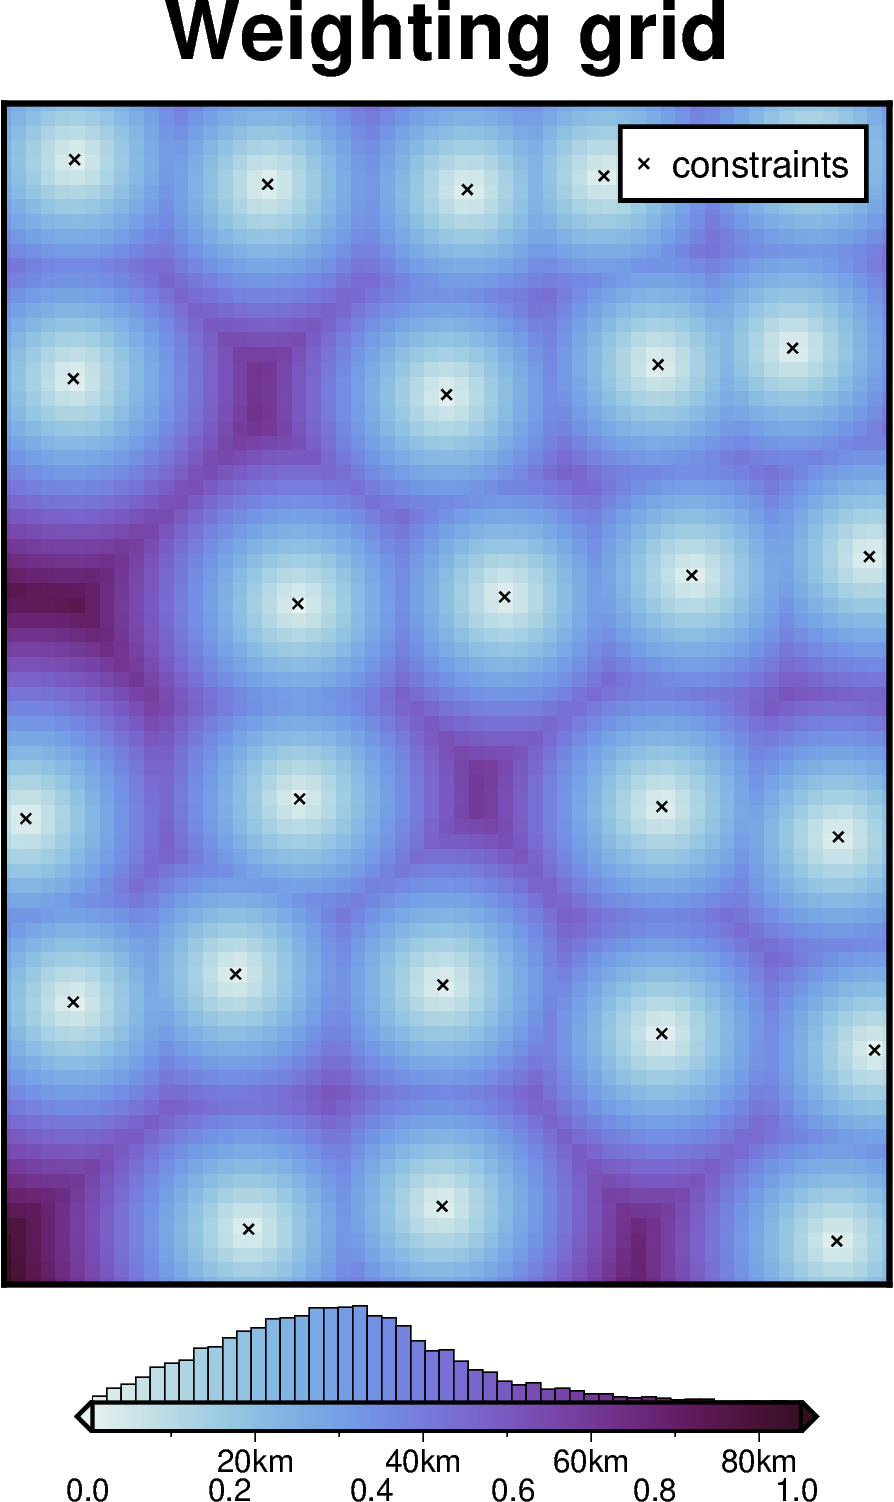

In [20]:
fig = maps.plot_grd(
    min_dist_grid,
    region=inversion_region,
    fig_height=10,
    title="Weighting grid",
    cmap="dense",
    hist=True,
    cbar_yoffset=1,
    cbar_unit_annot="km",
    cbar_scale=.001,
    hist_bin_num=50,
)
fig.plot(
    x=constraint_points.easting,
    y=constraint_points.northing,
    style="x0.12c",
    pen=".5p",
    label="constraints",
)

# add second colorbar units from 0 to 1
with pygmt.config(
    FONT_ANNOT="Helvetica-Oblique",
    MAP_ANNOT_OFFSET_PRIMARY="18p",
    MAP_TICK_LENGTH_PRIMARY="0p",
):
    maps.set_cmap("dense", grid=weighting_grid)
    maps.add_colorbar(fig=fig, cbar_yoffset=1)

fig.legend()
fig.show()

# Run initial inversion
choose a damping value and use the inversion results to set appropriate stopping criteria.

In [21]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": .1**.5, # square root of the gravity noise
    "delta_l2_norm_tolerance": 1.008,
}


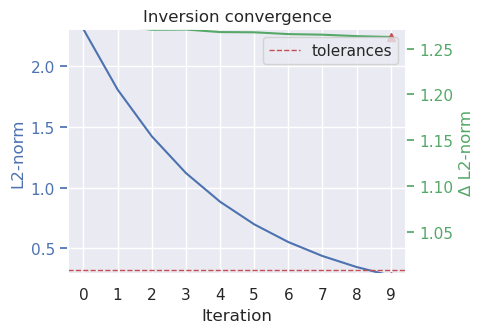

In [22]:
# run the inversion workflow
inversion_results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_prisms=starting_prisms,
    solver_damping=0.01,
    fname="../../results/Ross_Sea_regional",
    plot_dynamic_convergence=True,
    **kwargs,
)

In [23]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

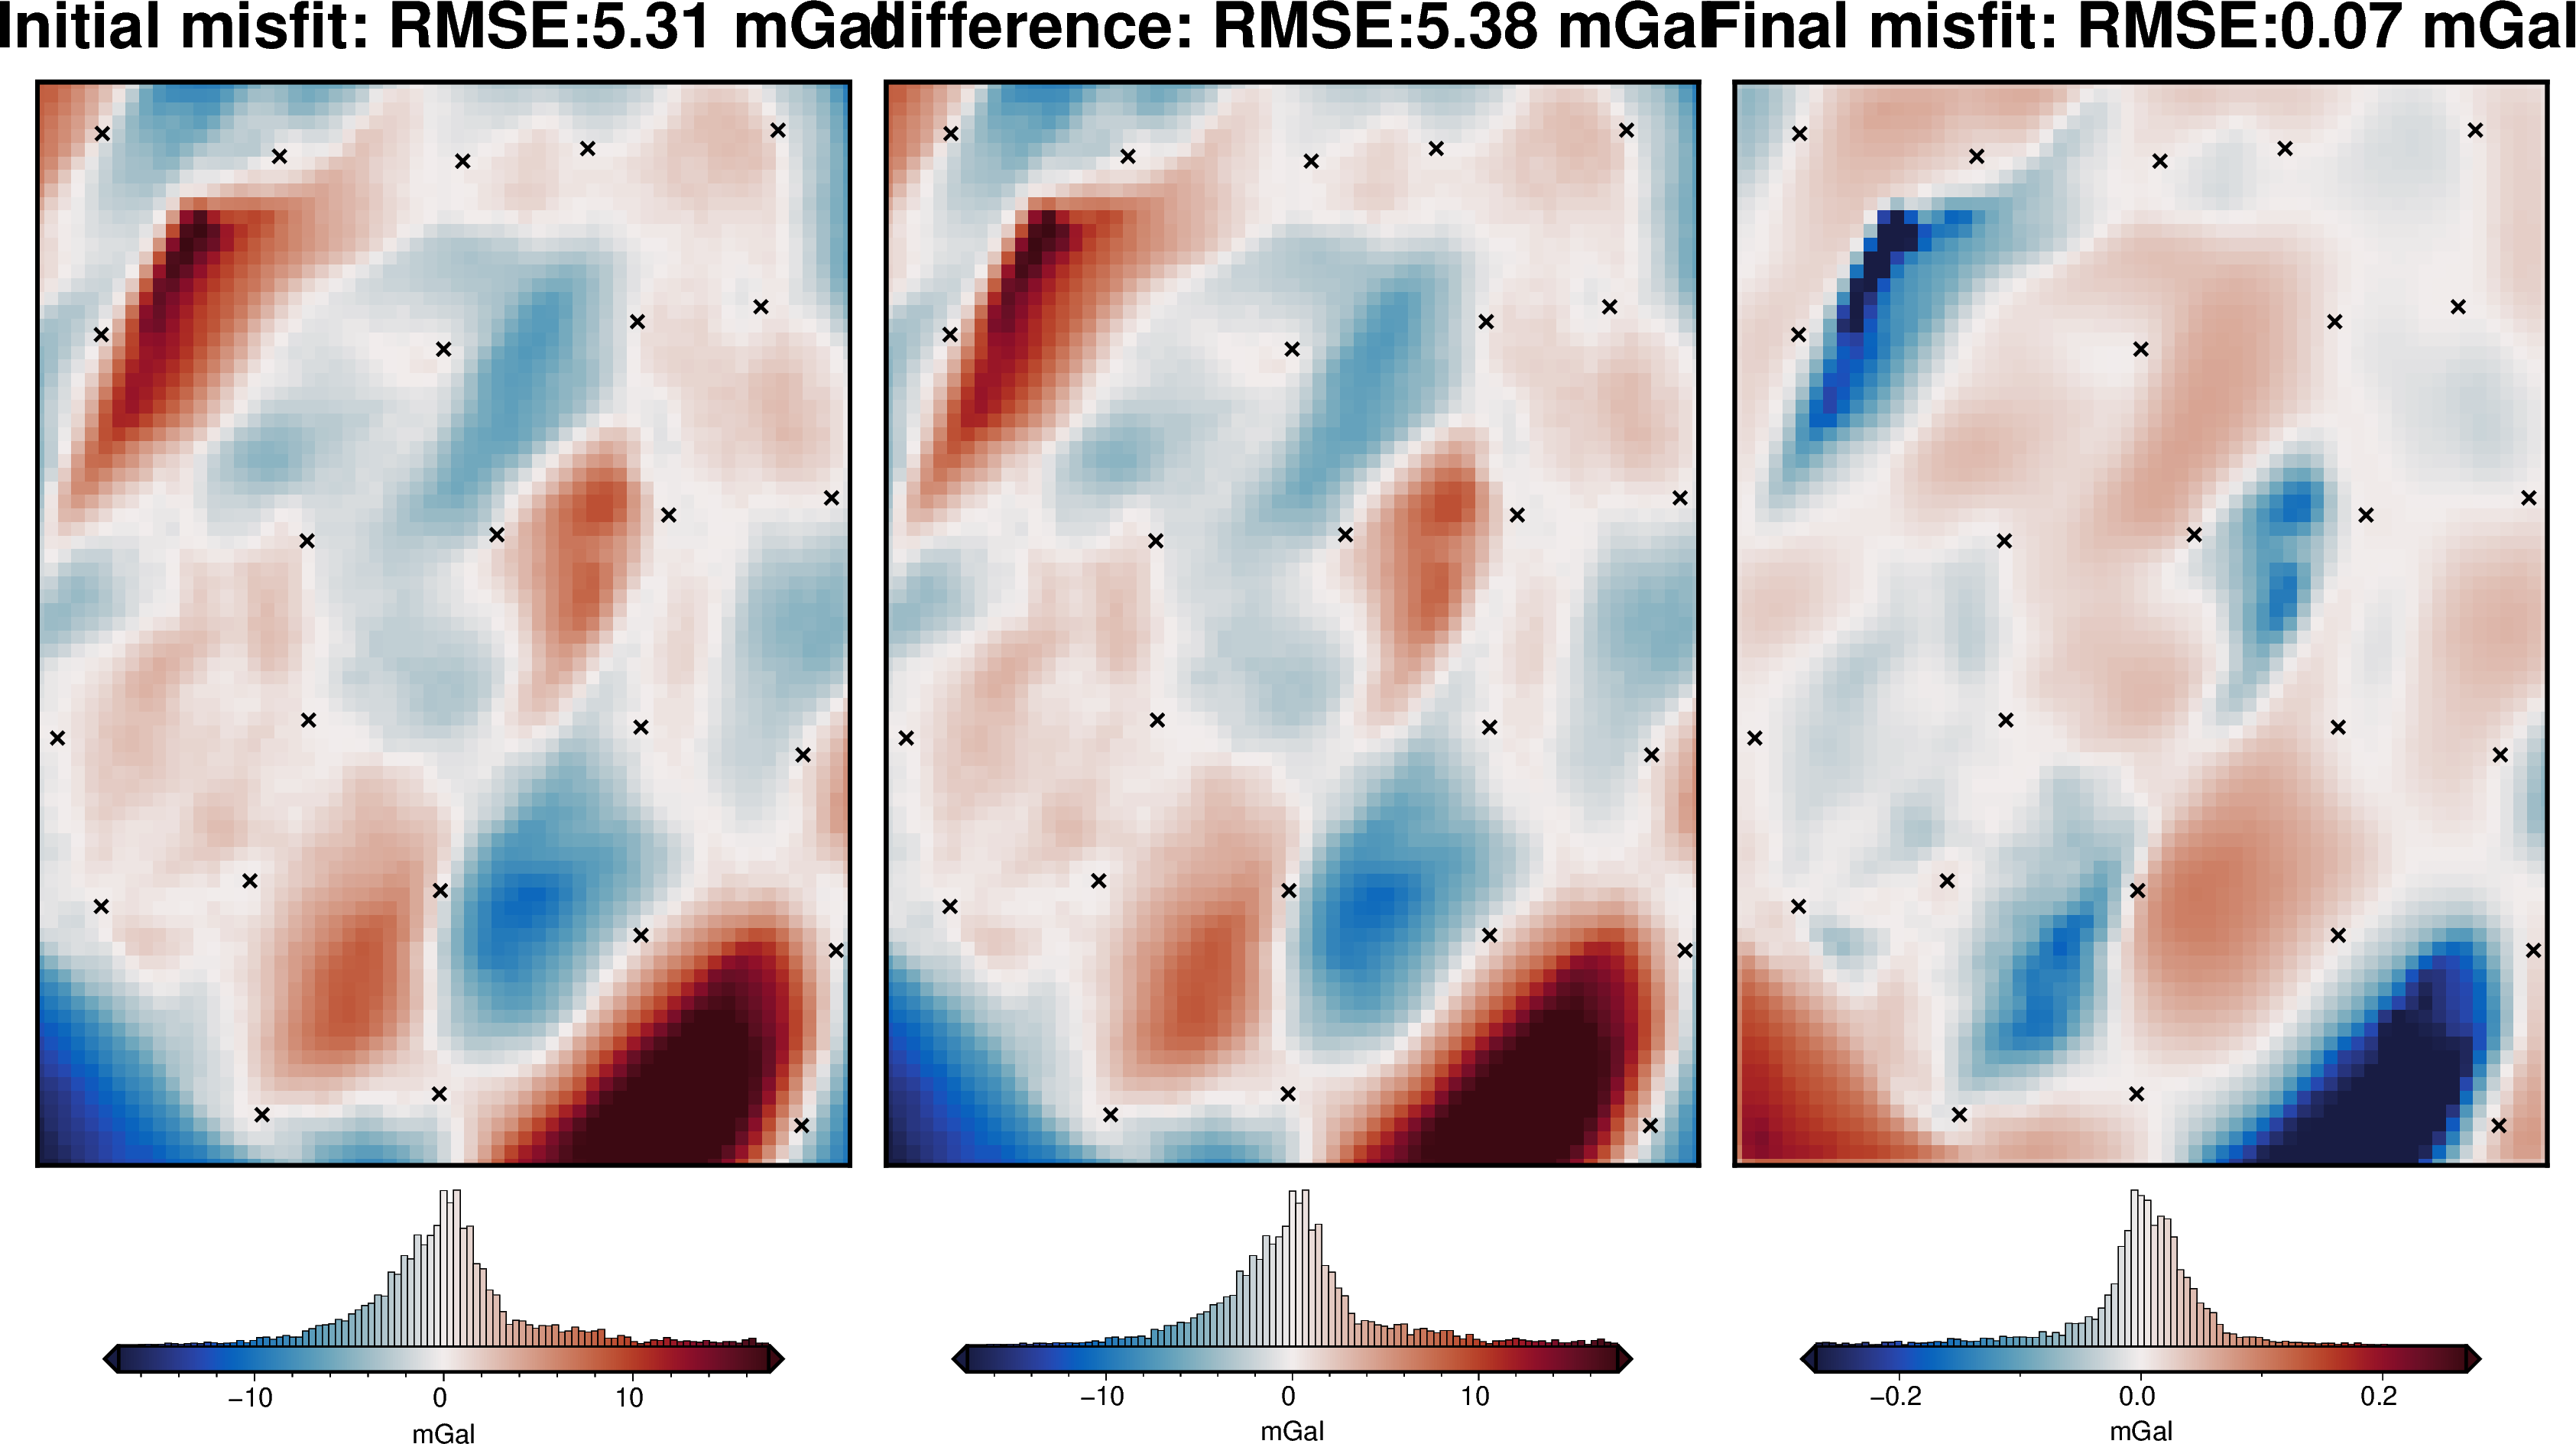

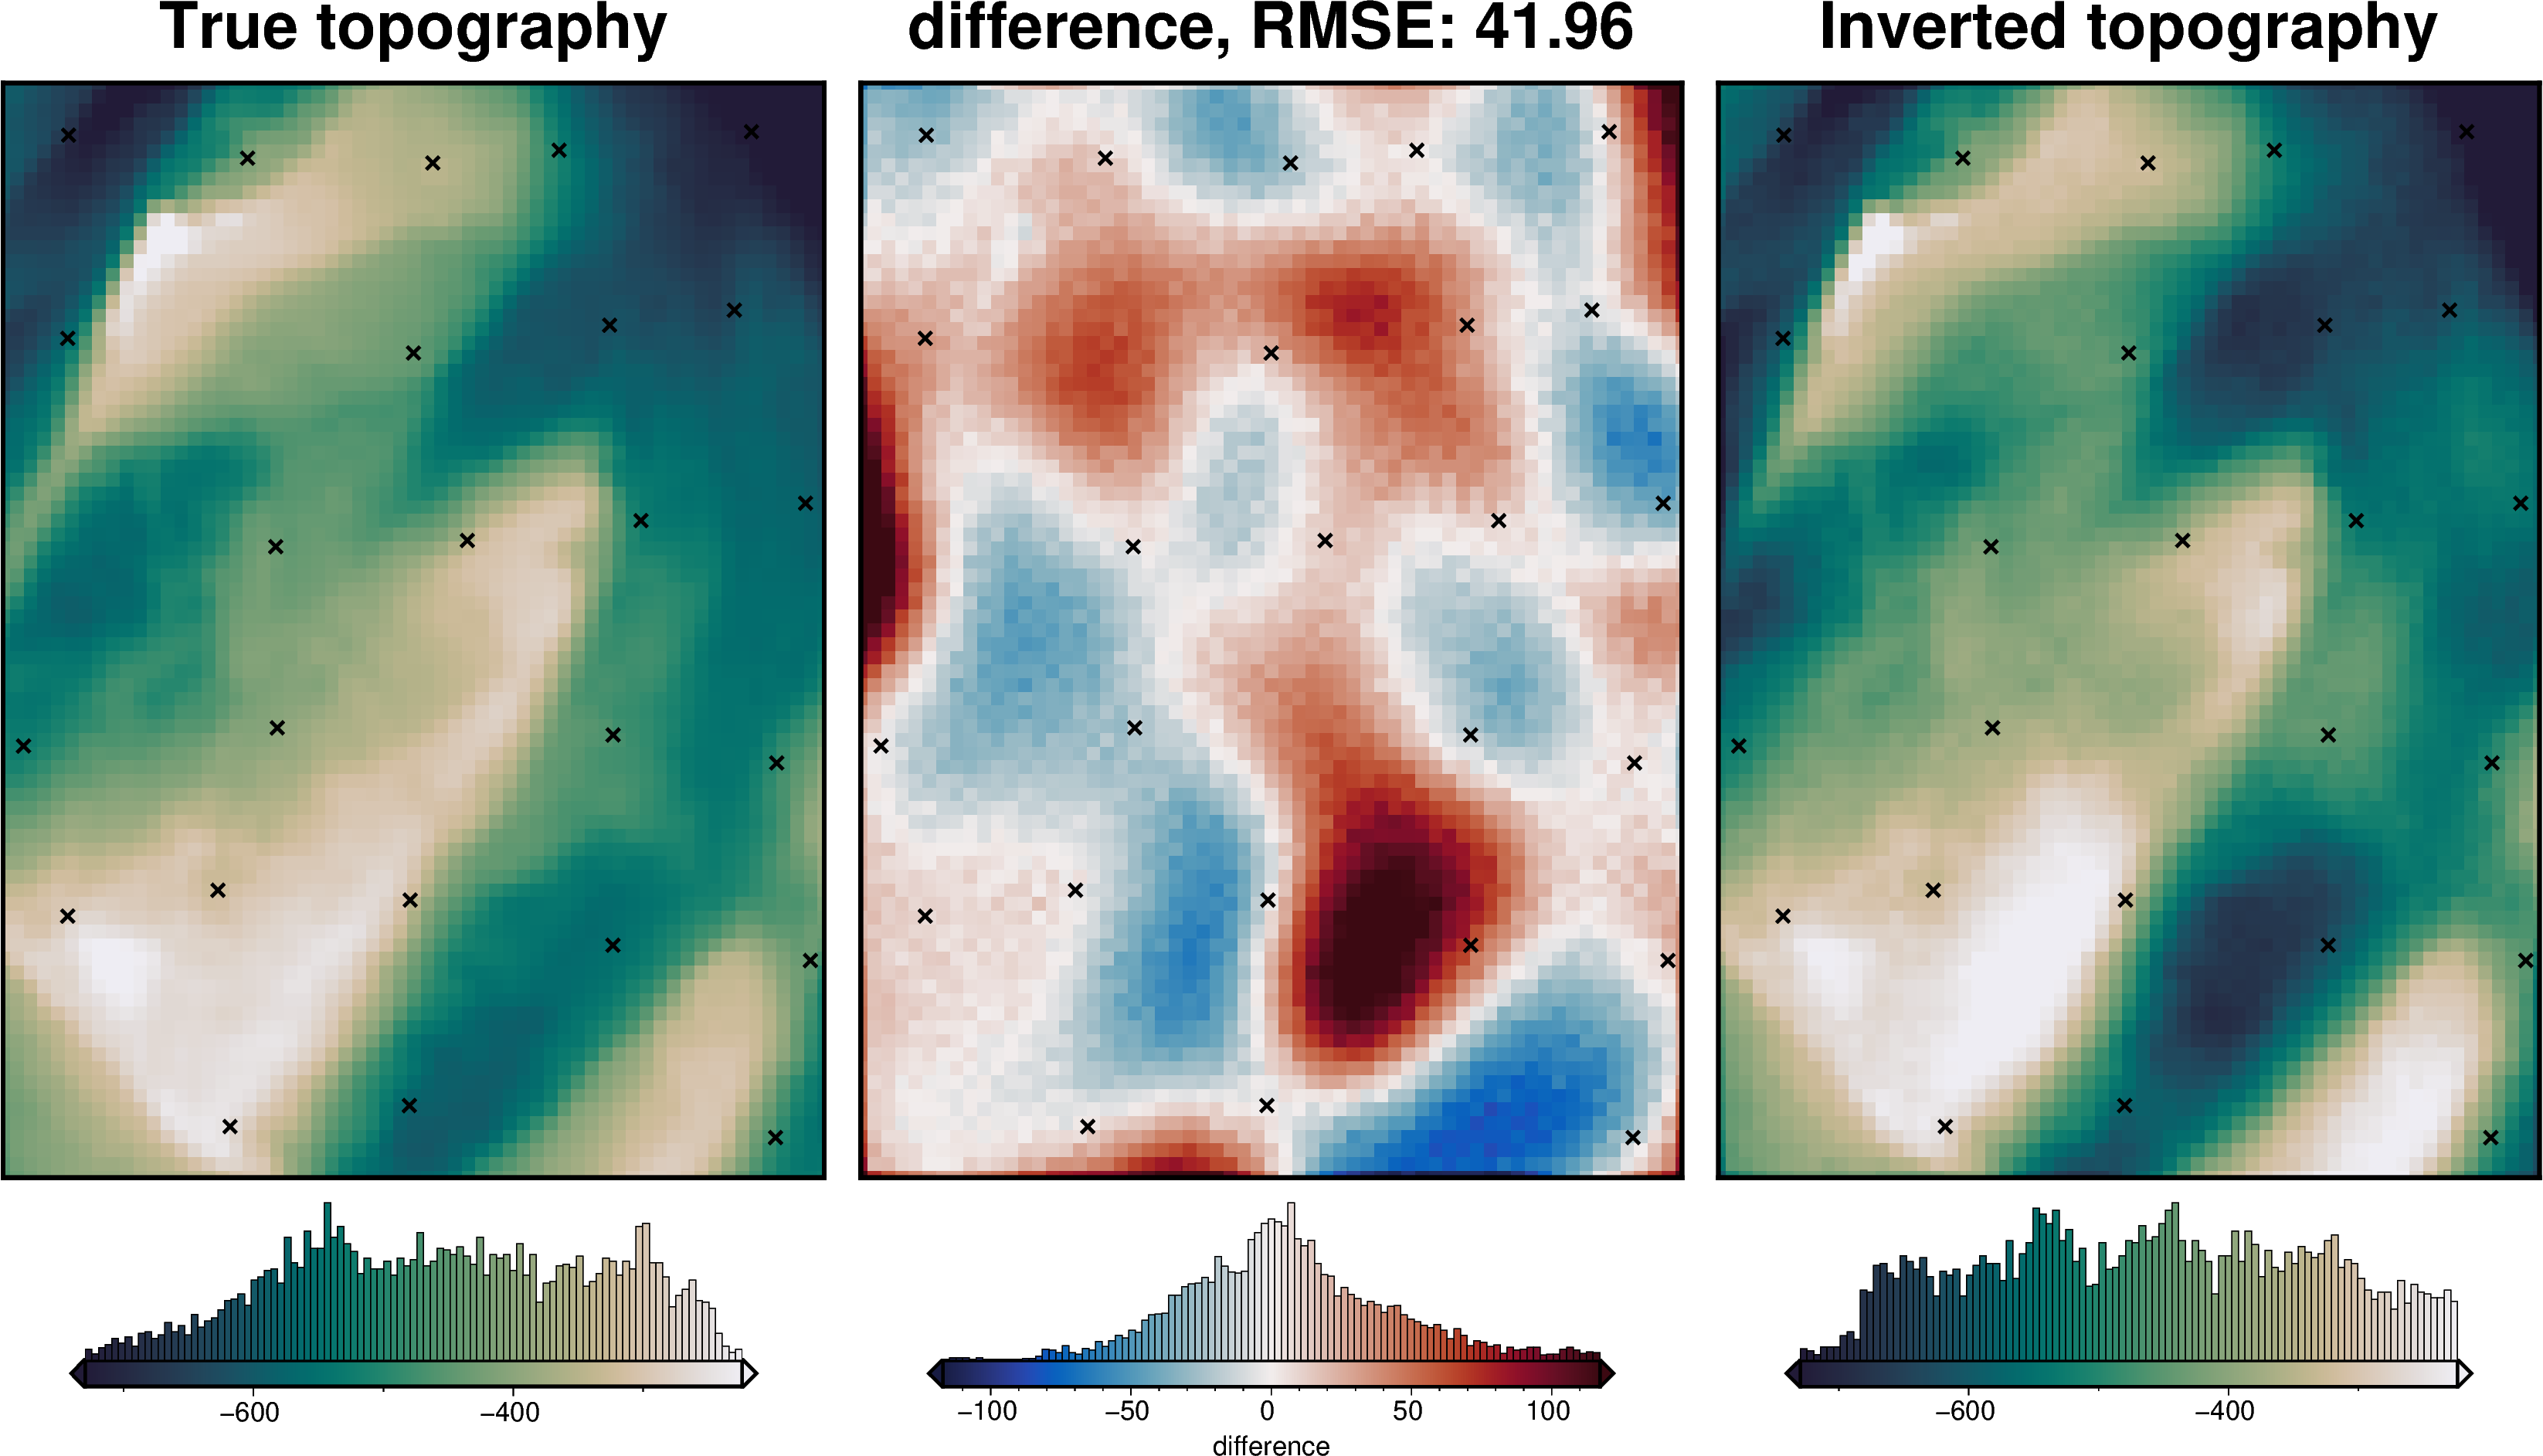

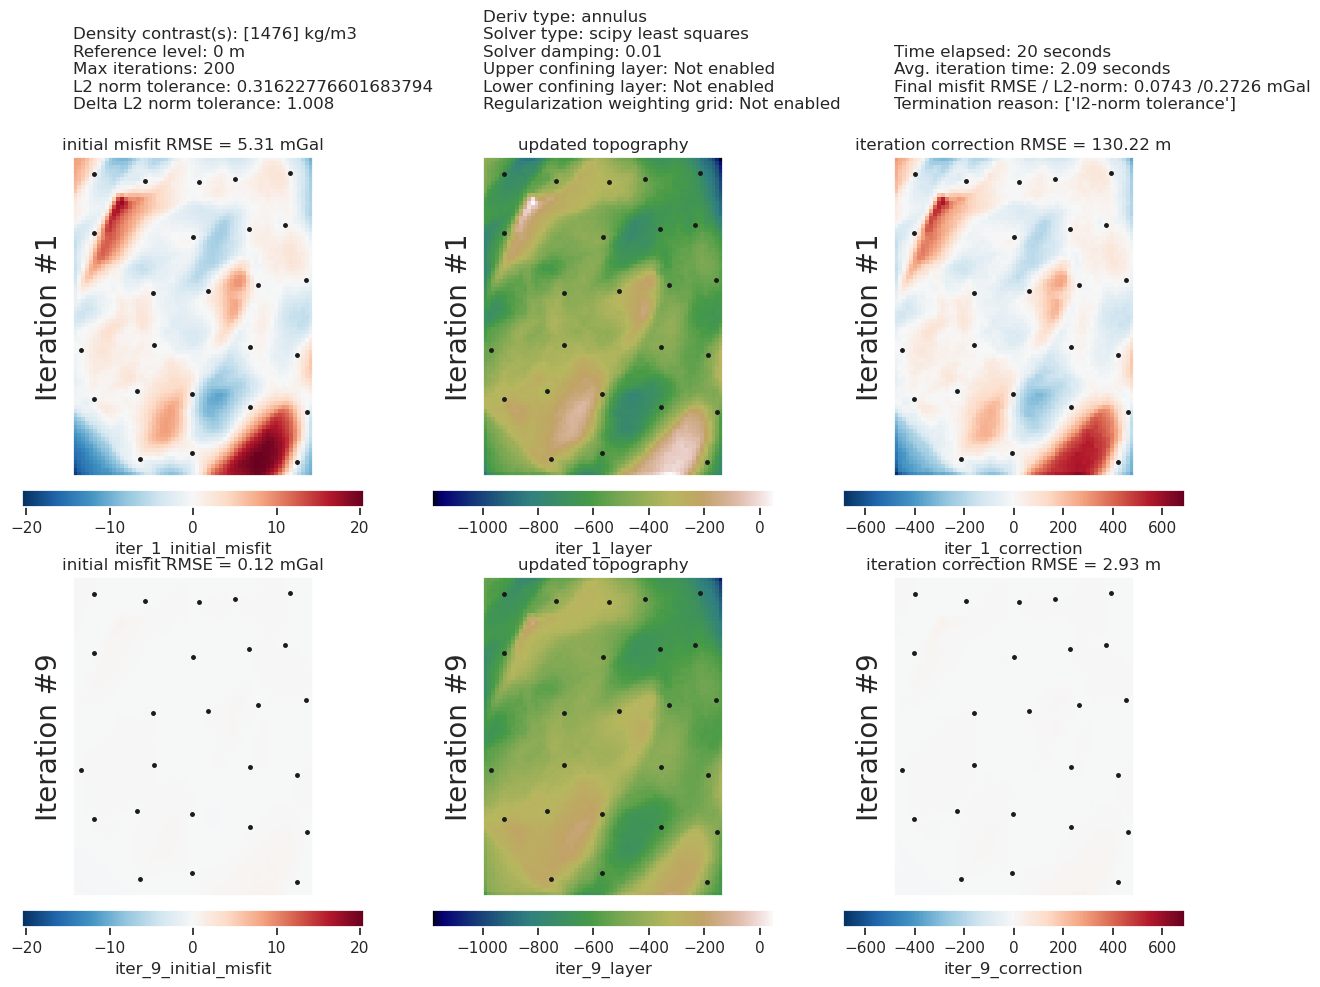

In [24]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    # plot_iter_results=False,
    plot_topo_results=False,
    # plot_grav_results=False,
    constraints_df=constraint_points,
    constraint_size=5,
    constraint_style="x.2c",
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
    points_pen="1p",
)

In [25]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 3.93 m


# Damping Cross Validation

In [26]:
# resample to half spacing
grav_df = cross_validation.resample_with_test_points(
    spacing, grav_df, inversion_region,
)
grav_df

northing   easting   test  upward  bathymetry_grav  basement_grav  \
0     -1800000.0  -40000.0  False  1000.0       -28.040827      -4.951107   
1     -1800000.0  -37500.0   True  1000.0       -27.341534      -4.752894   
2     -1800000.0  -35000.0  False  1000.0       -26.709299      -4.563569   
3     -1800000.0  -32500.0   True  1000.0       -26.271179      -4.396423   
4     -1800000.0  -30000.0  False  1000.0       -25.914227      -4.247120   
...          ...       ...    ...     ...              ...            ...   
19476 -1400000.0  250000.0  False  1000.0       -49.069447     -12.743444   
19477 -1400000.0  252500.0   True  1000.0       -49.453800     -13.245029   
19478 -1400000.0  255000.0  False  1000.0       -49.867458     -13.761828   
19479 -1400000.0  257500.0   True  1000.0       -50.336094     -14.290964   
19480 -1400000.0  260000.0  False  1000.0       -50.824623     -14.825797   

       disturbance  uncert  gravity_anomaly  starting_gravity   true_res  \
0       -32.978771     0.1       -32.978771         -9.816314 -18.224512   
1       -32.100599     0.1       -32.100599         -9.825789 -17.515745   
2       -31.285490     0.1       -31.285490         -9.839073 -16.870226   
3       -30.639863     0.1       -30.639863         -9.861640 -16.409540   
4       -30.096718     0.1       -30.096718         -9.892305 -16.021923   
...            ...     ...              ...               ...        ...   
19476   -61.668674     0.1       -61.668674        -48.852234  -0.217213   
19477   -62.693823     0.1       -62.693823        -48.995838  -0.457961   
19478   -63.781307     0.1       -63.781307        -49.120922  -0.746534   
19479   -64.754106     0.1       -64.754106        -49.223974  -1.112119   
19480   -65.703041     0.1       -65.703041        -49.318085  -1.506539   

          misfit       reg        res  
0     -23.162458 -3.867401 -19.295057  
1     -22.274810 -3.885714 -18.389096  
2     -21.446417 -3.904755 -17.541662  
3     -20.778224 -3.925558 -16.852666  
4     -20.204412 -3.947932 -16.256481  
...          ...       ...        ...  
19476 -12.816442 -7.203739  -5.612702  
19477 -13.697985 -7.024633  -6.673353  
19478 -14.660386 -6.864573  -7.795814  
19479 -15.530133 -6.726025  -8.804108  
19480 -16.384958 -6.596344  -9.788614  

[19481 rows x 14 columns]

  0%|          | 0/8 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 5
INFO:invert4geom:	parameter: {'damping': 0.01515400870943397}
INFO:invert4geom:	scores: [0.07313758269800688]


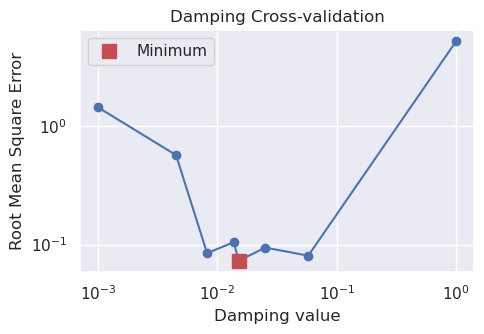

In [27]:
damping_study, inversion_results = optimization.optimize_inversion_damping(
    training_df=grav_df[grav_df.test == False],
    testing_df=grav_df[grav_df.test == True],
    prism_layer=starting_prisms,
    damping_limits=(0.001, 1),
    n_trials=8,
    # grid_search=True,
    fname="../../results/Ross_Sea_regional_damping_cv",
    **kwargs,
)

In [28]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_regional_damping_cv_study.pickle").open("rb") as f:
    damping_study = pickle.load(f)

# re-load the inversion results from the saved pickle file
# with pathlib.Path("../../results/Ross_Sea_regional_damping_cv_results.pickle").open("rb") as f:
#     inversion_results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

In [29]:
best_damping = damping_study.best_params.get("damping")
best_damping

0.01515400870943397

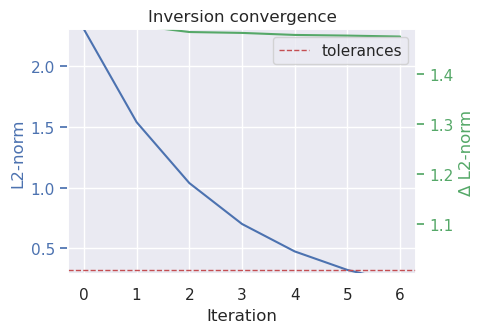

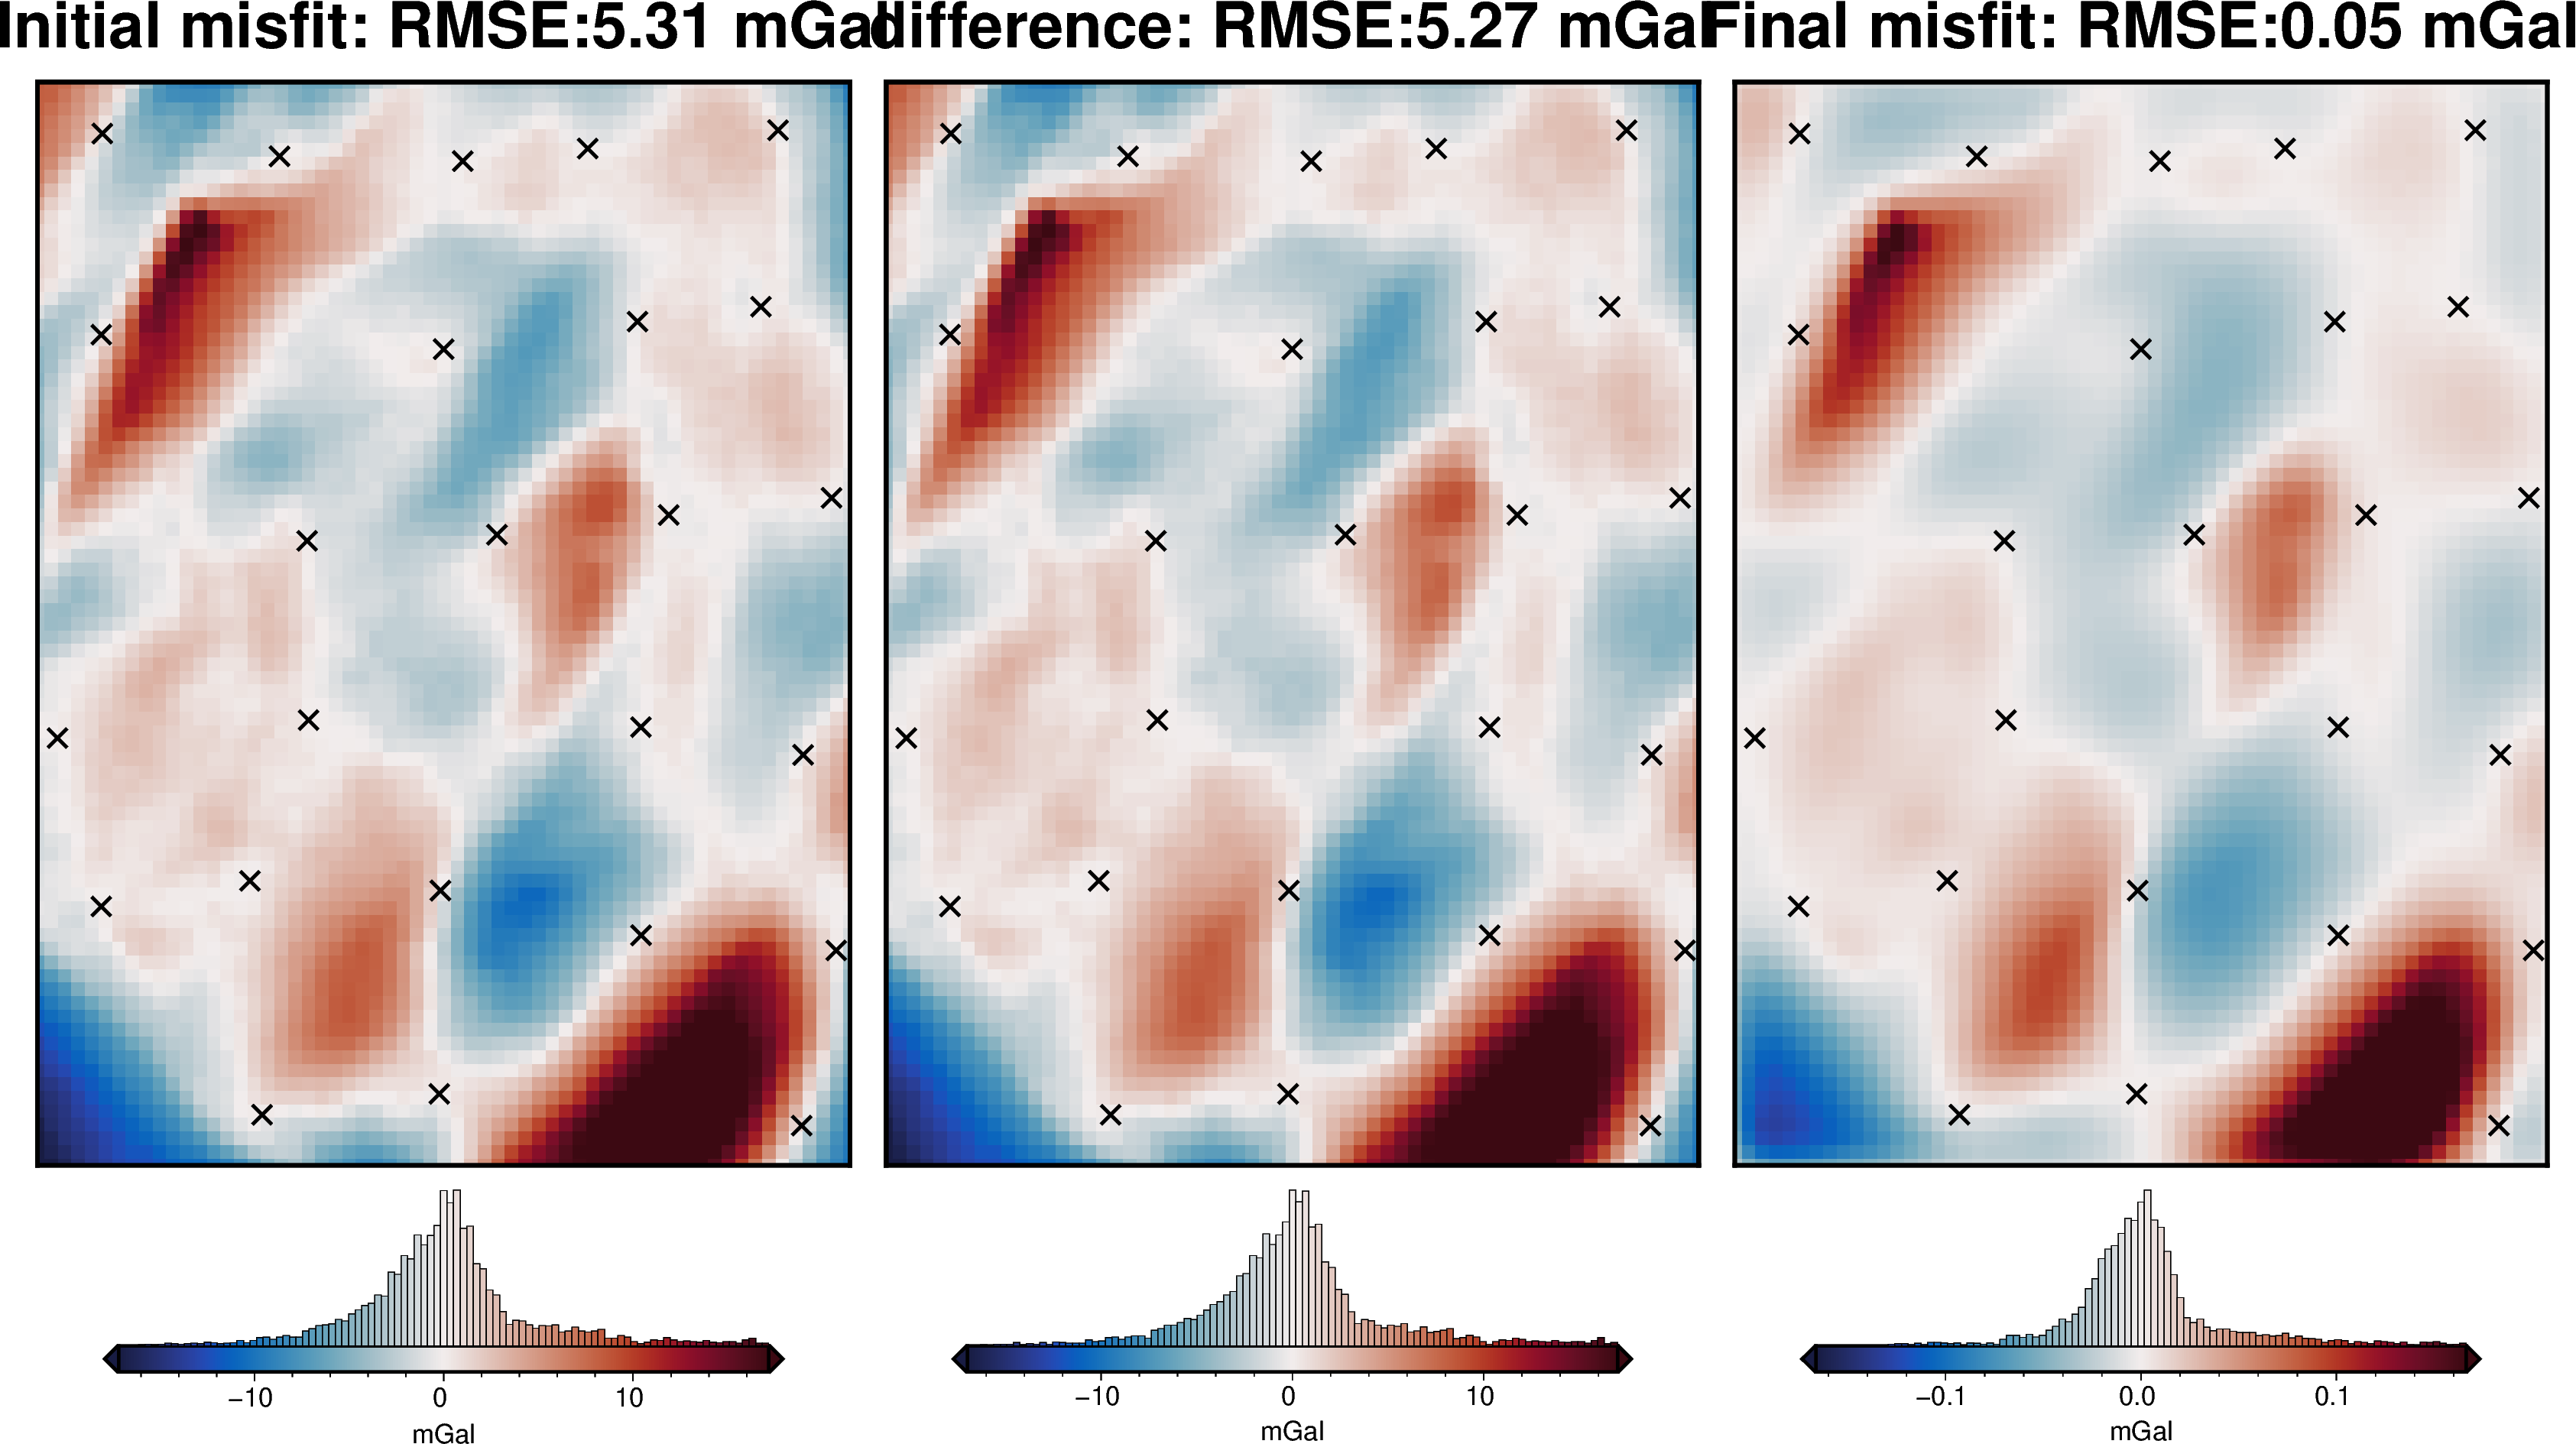

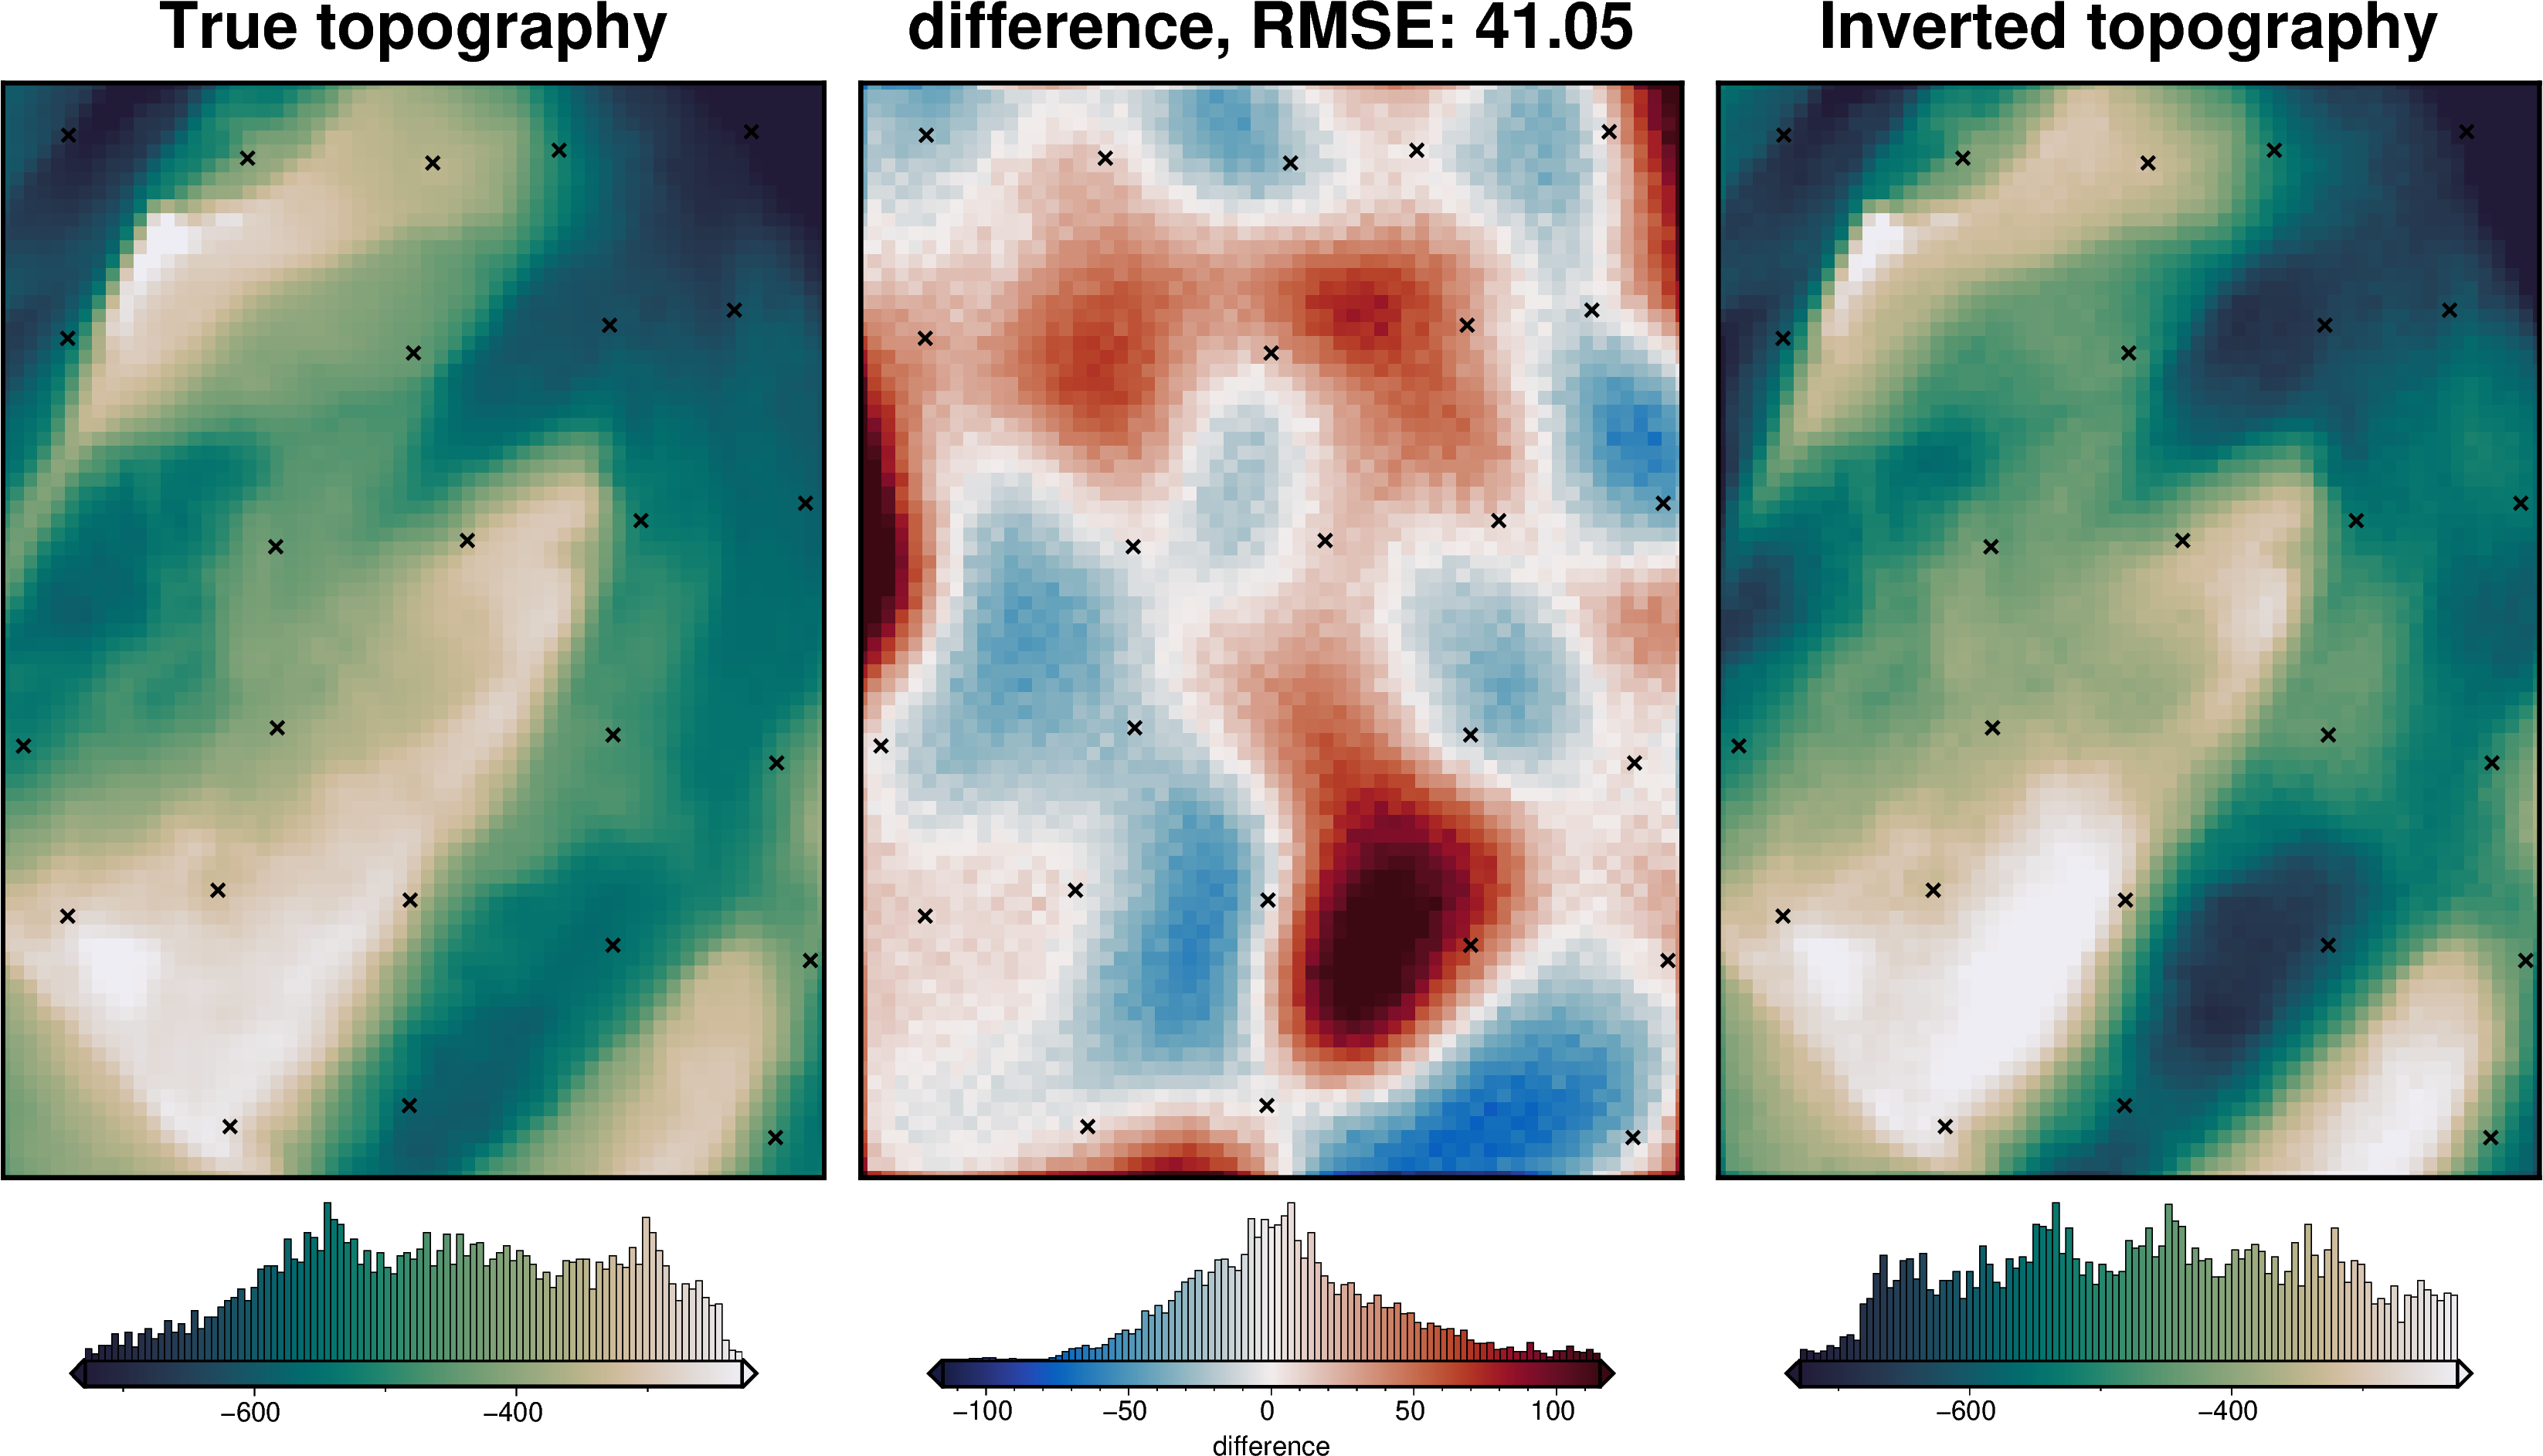

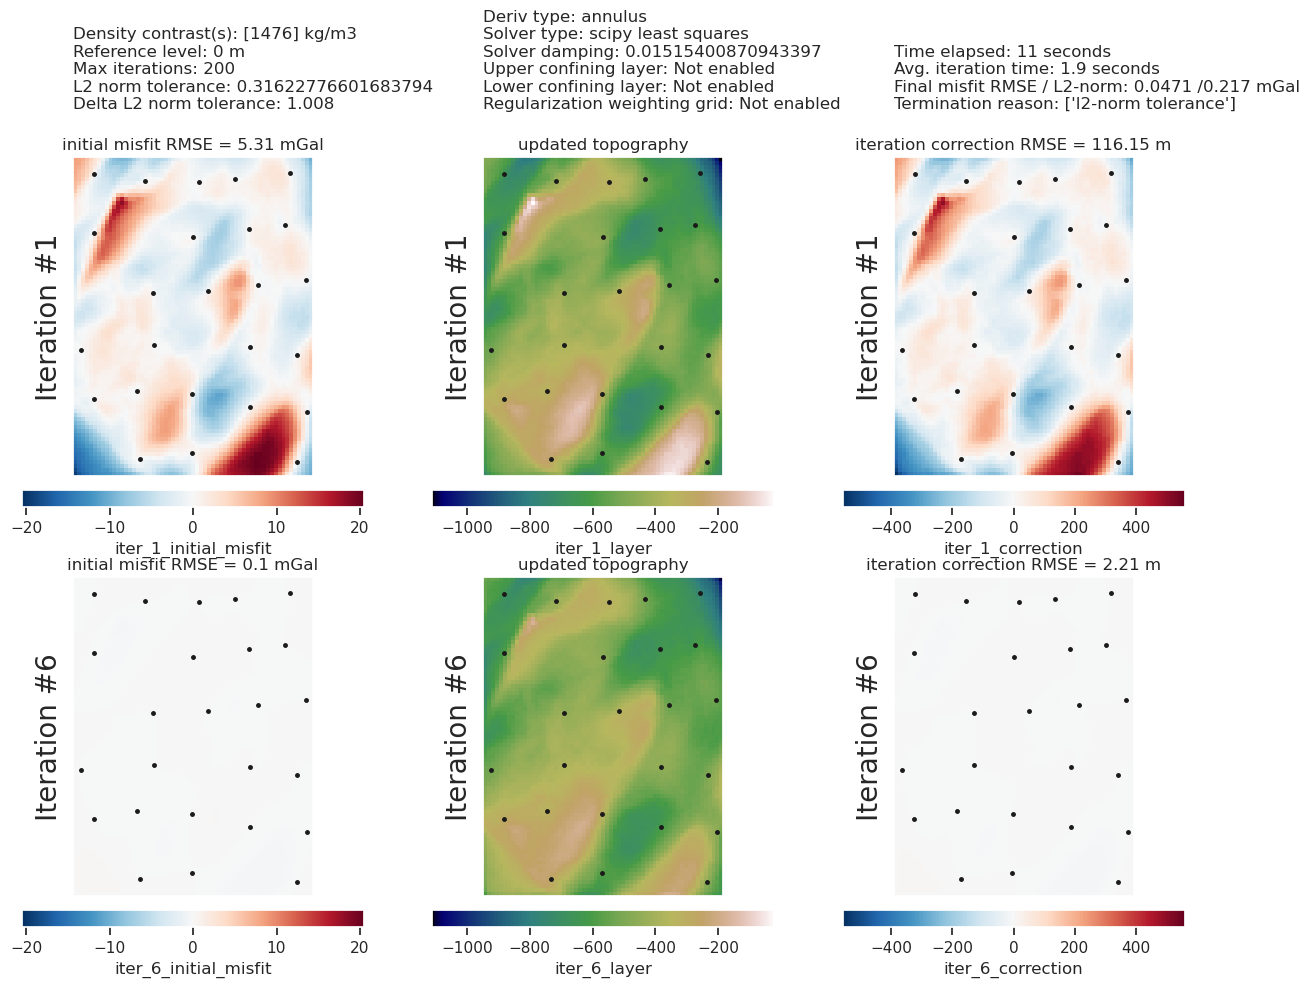

In [30]:
plotting.plot_convergence(
    grav_results,
    params=parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    # plot_iter_results=False,
    plot_topo_results=False,
    # plot_grav_results=False,
    constraints_df=constraint_points,
    constraint_size=5,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
    points_pen="1p",
)

In [31]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 3.93 m


# Density contrast Cross Validation

To run a density cross validation, we can't use a regional estimation technique which utilizes constraint points, since they are used for the scoring of the cross validation. We will use the equivalent sources technique temporarily to estimate the regional field just for this density cross validation.

In [39]:
# we don't need the testing points anymore
grav_df = grav_df[grav_df.test == False].copy()
grav_df = grav_df.drop(columns=["test"])
grav_df

northing   easting  upward  surface_grav  icebase_grav  \
0     -1800000.0  -40000.0  1000.0      0.005089     -0.003959   
2     -1800000.0  -35000.0  1000.0      0.005307     -0.004120   
4     -1800000.0  -30000.0  1000.0      0.005530     -0.004284   
6     -1800000.0  -25000.0  1000.0      0.005755     -0.004450   
8     -1800000.0  -20000.0  1000.0      0.005984     -0.004617   
...          ...       ...     ...           ...           ...   
19472 -1400000.0  240000.0  1000.0      2.087856     -1.453847   
19474 -1400000.0  245000.0  1000.0      2.084531     -1.449061   
19476 -1400000.0  250000.0  1000.0      2.070808     -1.435254   
19478 -1400000.0  255000.0  1000.0      2.096829     -1.451071   
19480 -1400000.0  260000.0  1000.0      2.082613     -1.440349   

       bathymetry_grav  basement_grav  disturbance  uncert  starting_gravity  \
0           -28.041313      -4.951158   -32.965019     0.2        -10.236735   
2           -26.709818      -4.563623   -31.297501     0.2        -10.264382   
4           -25.914780      -4.247179   -30.031454     0.2        -10.324248   
6           -25.232630      -4.002382   -29.211552     0.2        -10.420359   
8           -24.606749      -3.845117   -28.556458     0.2        -10.556410   
...                ...            ...          ...     ...               ...   
19472       -48.314354     -11.010058   -58.338303     0.2        -50.485569   
19474       -48.346886     -11.801222   -59.708073     0.2        -50.938435   
19476       -49.069607     -12.743468   -60.889088     0.2        -51.301010   
19478       -49.867611     -13.761849   -63.287750     0.2        -51.583096   
19480       -50.824768     -14.825818   -65.113564     0.2        -51.790066   

       gravity_anomaly   true_res     misfit       reg        res  
0           -32.966148 -17.804577 -22.729414 -3.283378 -19.446037  
2           -31.298689 -16.445436 -21.034306 -3.324808 -17.709499  
4           -30.032700 -15.590531 -19.708450 -3.371826 -16.336626  
6           -29.212856 -14.812271 -18.792498 -3.425229 -15.367270  
8           -28.557825 -14.050340 -18.001415 -3.485870 -14.515546  
...                ...        ...        ...       ...        ...  
19472       -58.972313   2.171216  -8.486741 -5.867436  -2.619306  
19474       -60.343540   2.591548  -9.405107 -5.379439  -4.025669  
19476       -61.524643   2.231401 -10.223634 -4.990685  -5.232949  
19478       -63.933506   1.715488 -12.350410 -4.691332  -7.659079  
19480       -65.755829   0.965296 -13.965765 -4.469287  -9.496478  

[4941 rows x 15 columns]

INFO:invert4geom:Constraints split into 5 folds


  0%|          | 0/8 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 5
INFO:invert4geom:	parameter: {'density_contrast': 1872.8414953209308}
INFO:invert4geom:	scores: [48.20661888975336]


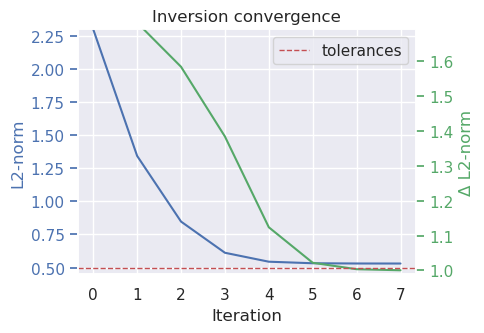

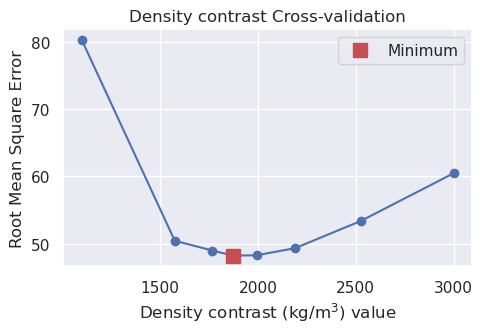

In [40]:
# run a 5-fold cross validation for 6 parameter sets of density
# this performs 30 regional separations and 30 inversions
study, inversion_results = optimization.optimize_inversion_zref_density_contrast_kfolds(
    constraints_df=constraint_points,
    grav_df=grav_df,
    solver_damping=best_damping,
    density_contrast_limits=(1100, 3000),
    zref=0,
    n_trials=8,
    starting_topography=starting_bathymetry,
    split_kwargs=dict(
        n_splits=5,
        method="KFold",
    ),
    regional_grav_kwargs=regional_grav_kwargs,
    # grid_search=True,
    fname="../../results/Ross_Sea_regional_density_cv_with_cpm_kfolds",
    # score_as_median=True,
    fold_progressbar=True,
    **kwargs,
)

In [41]:
# to re-load the study from the saved pickle file
with pathlib.Path("../../results/Ross_Sea_regional_density_cv_with_cpm_kfolds_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path(
    "../../results/Ross_Sea_regional_density_cv_with_cpm_kfolds_results.pickle"
).open("rb") as f:
    inversion_results = pickle.load(f)

topo_results, grav_results, parameters, elapsed_time = inversion_results

In [42]:
best_density_contrast = study.best_trial.params["density_contrast"]
best_density_contrast

1872.8414953209308

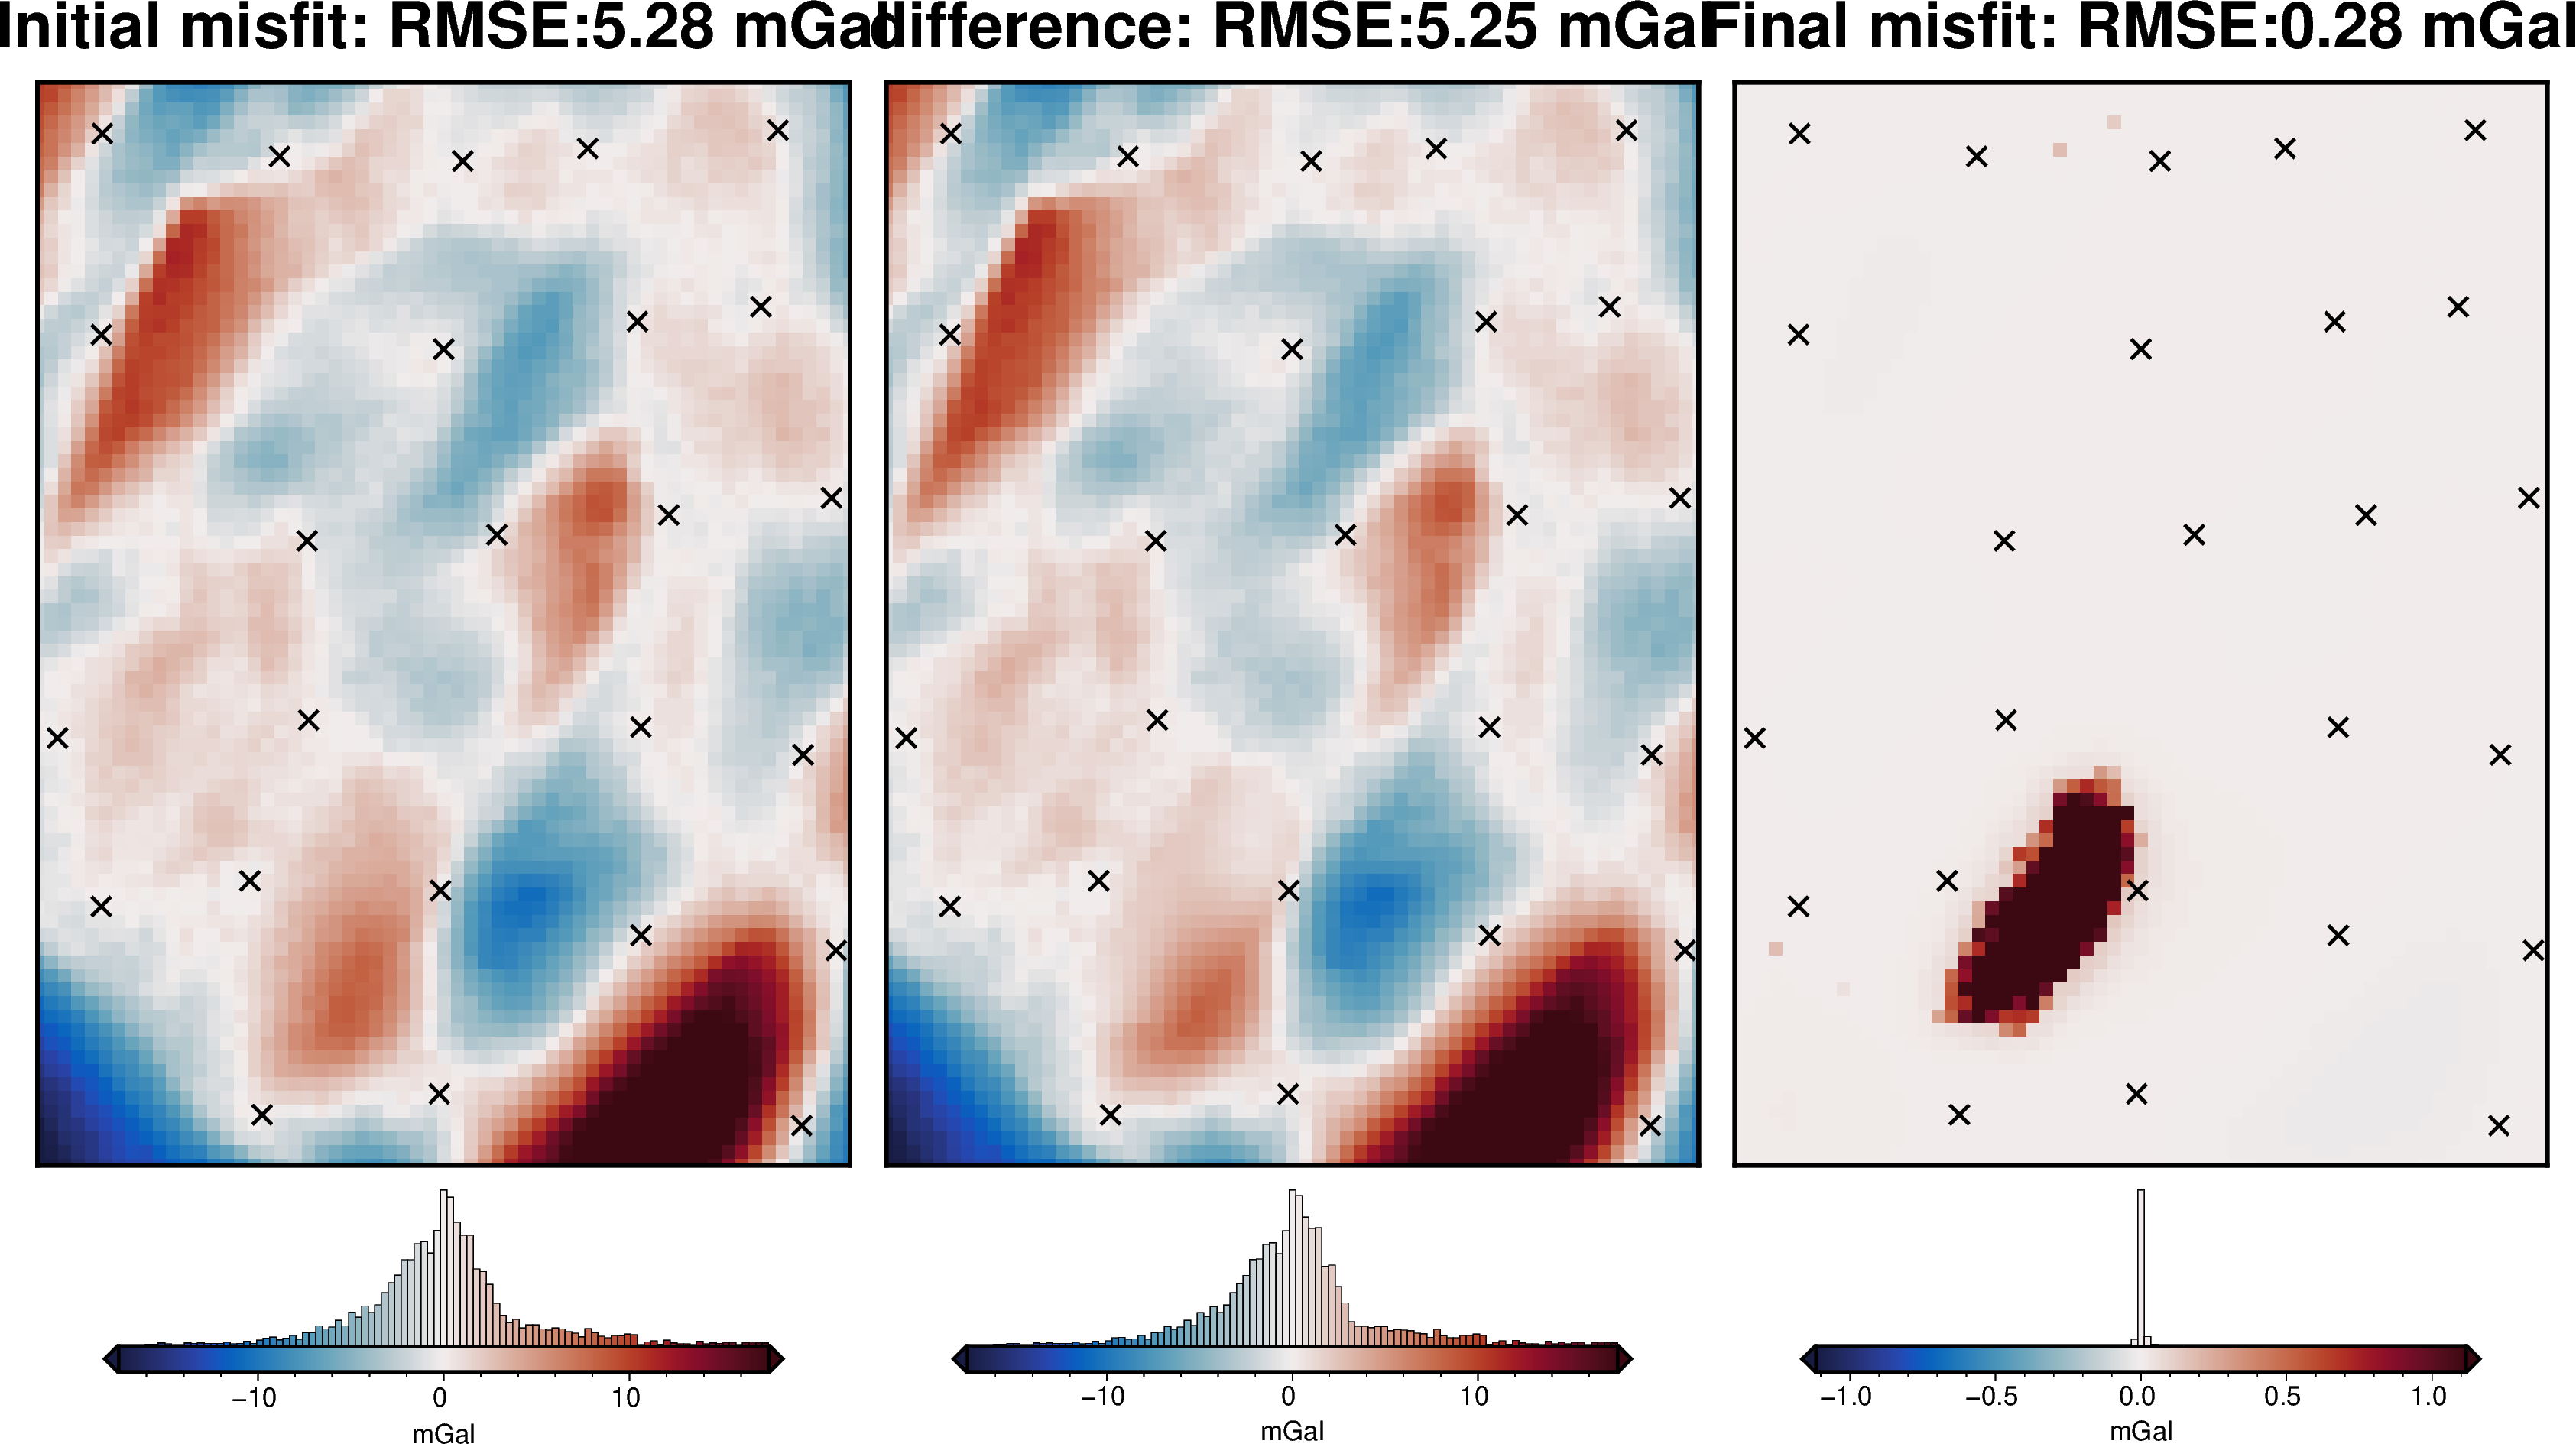

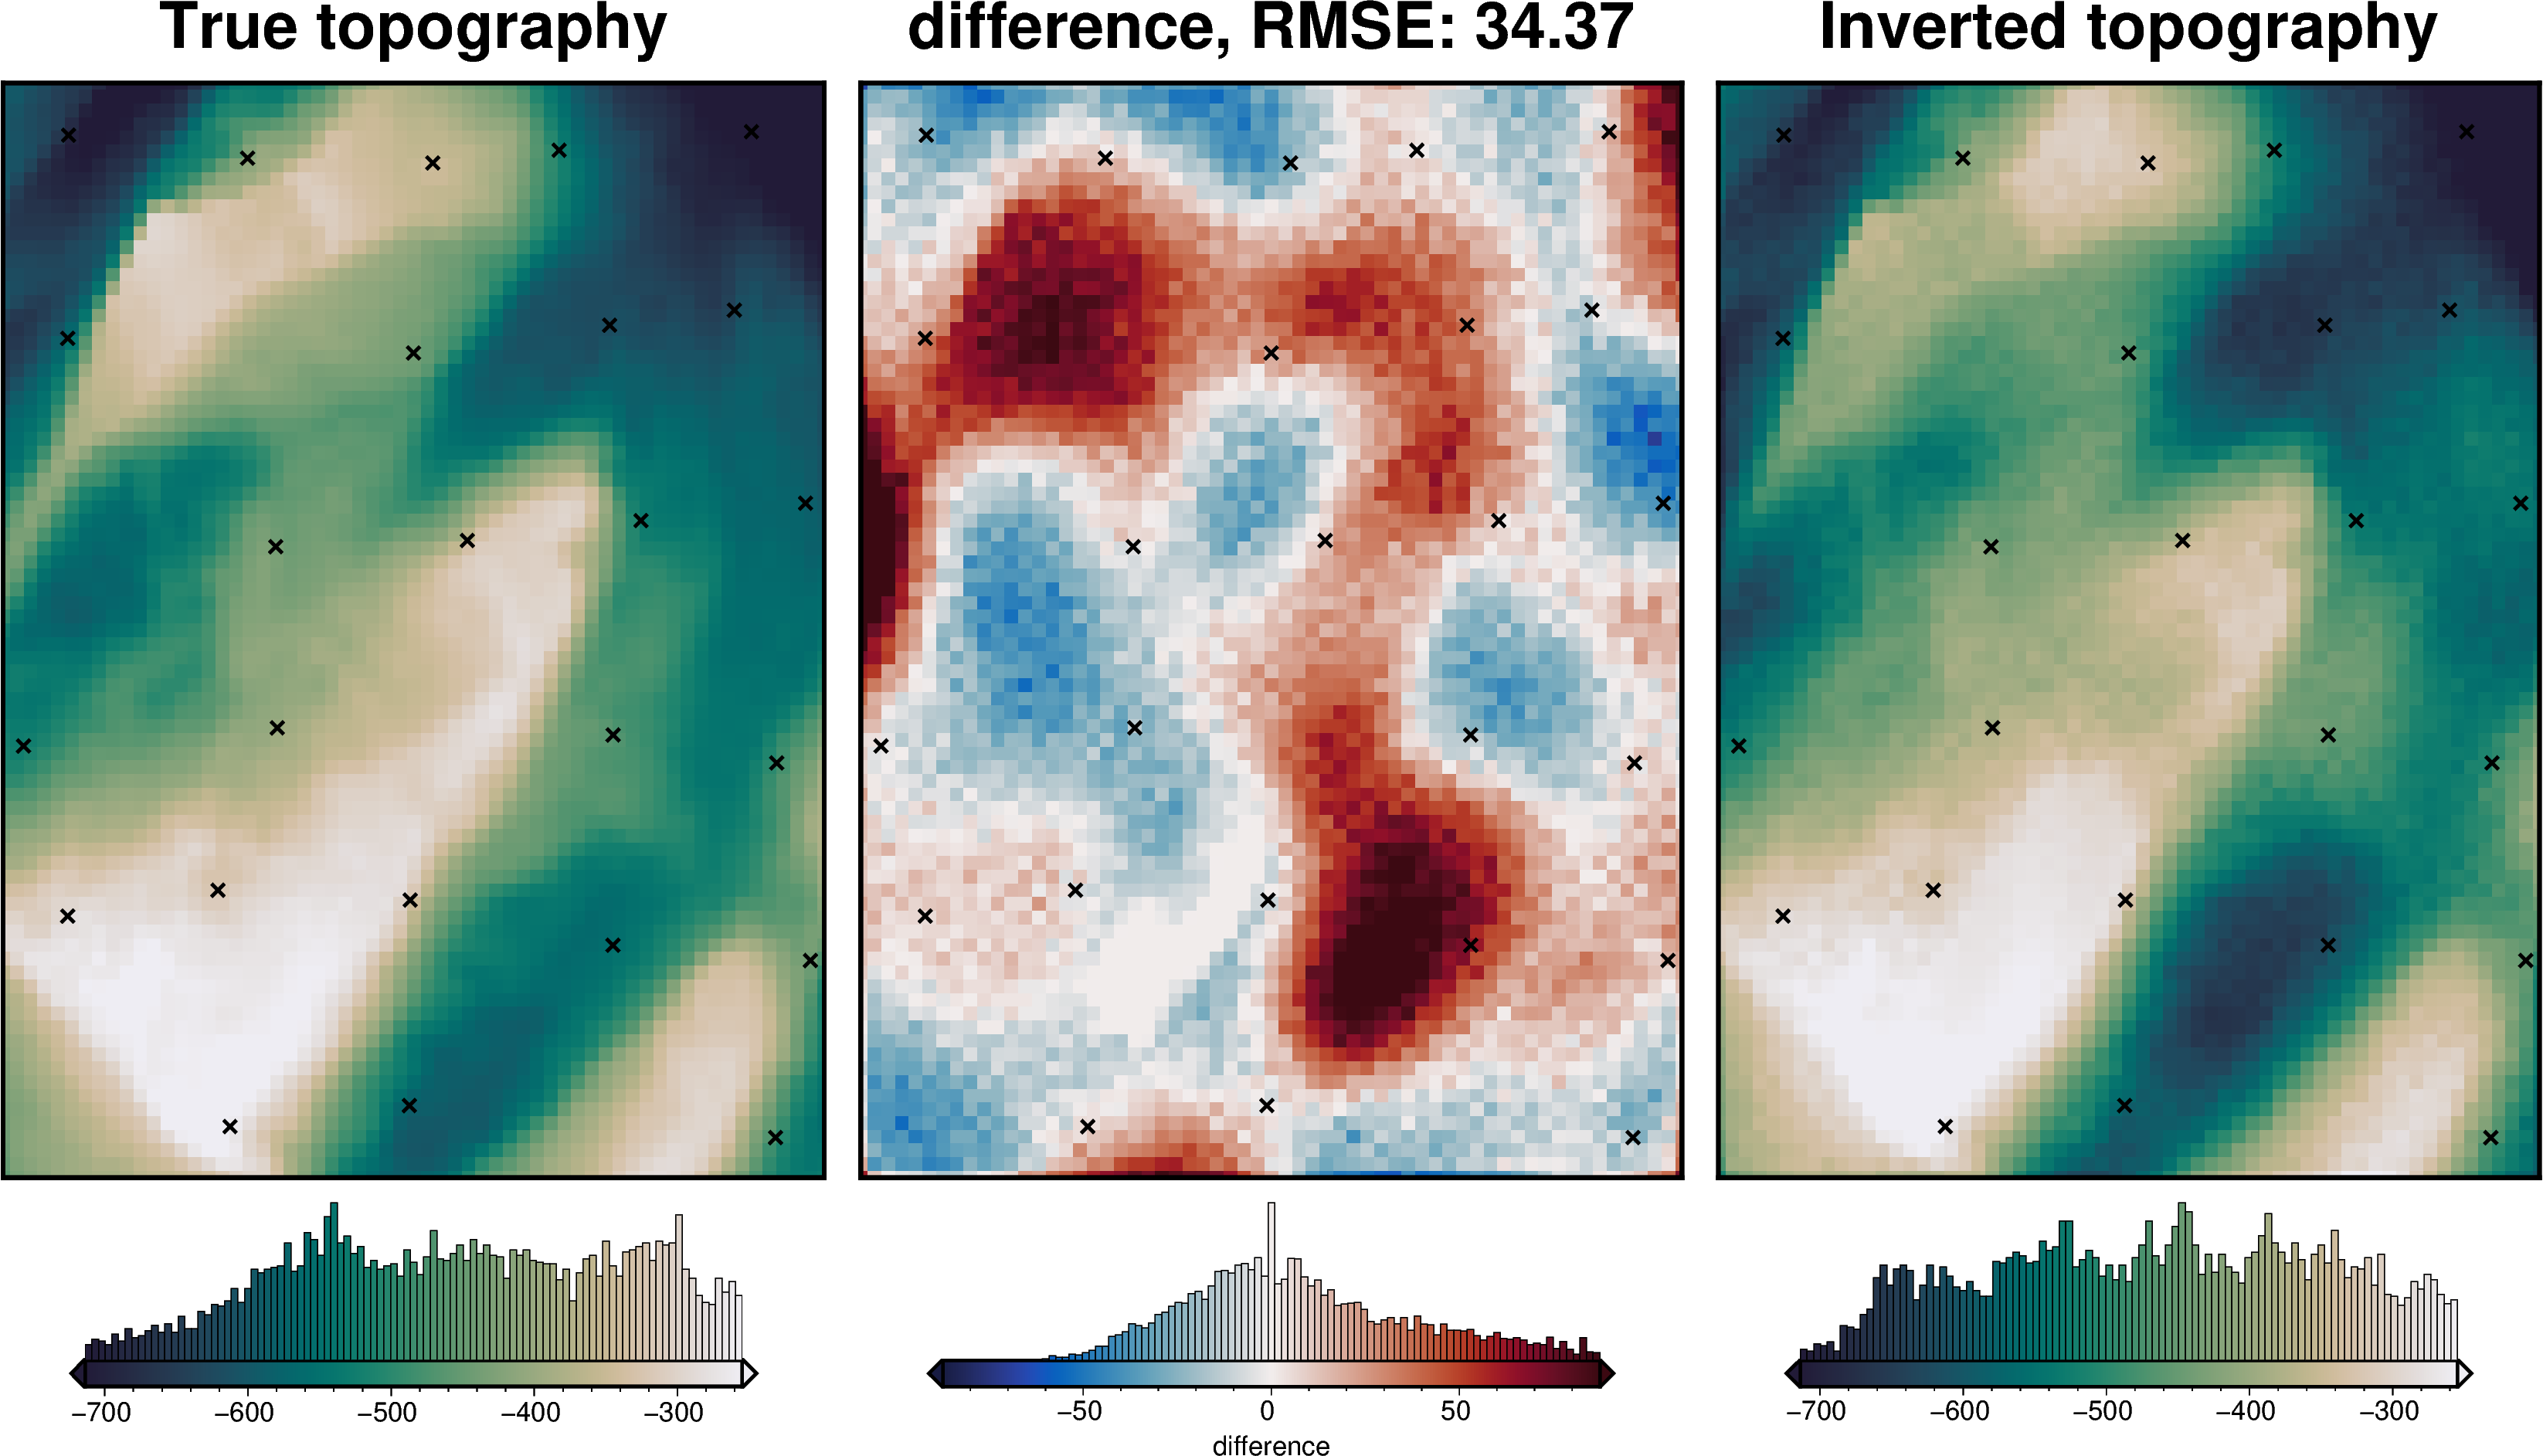

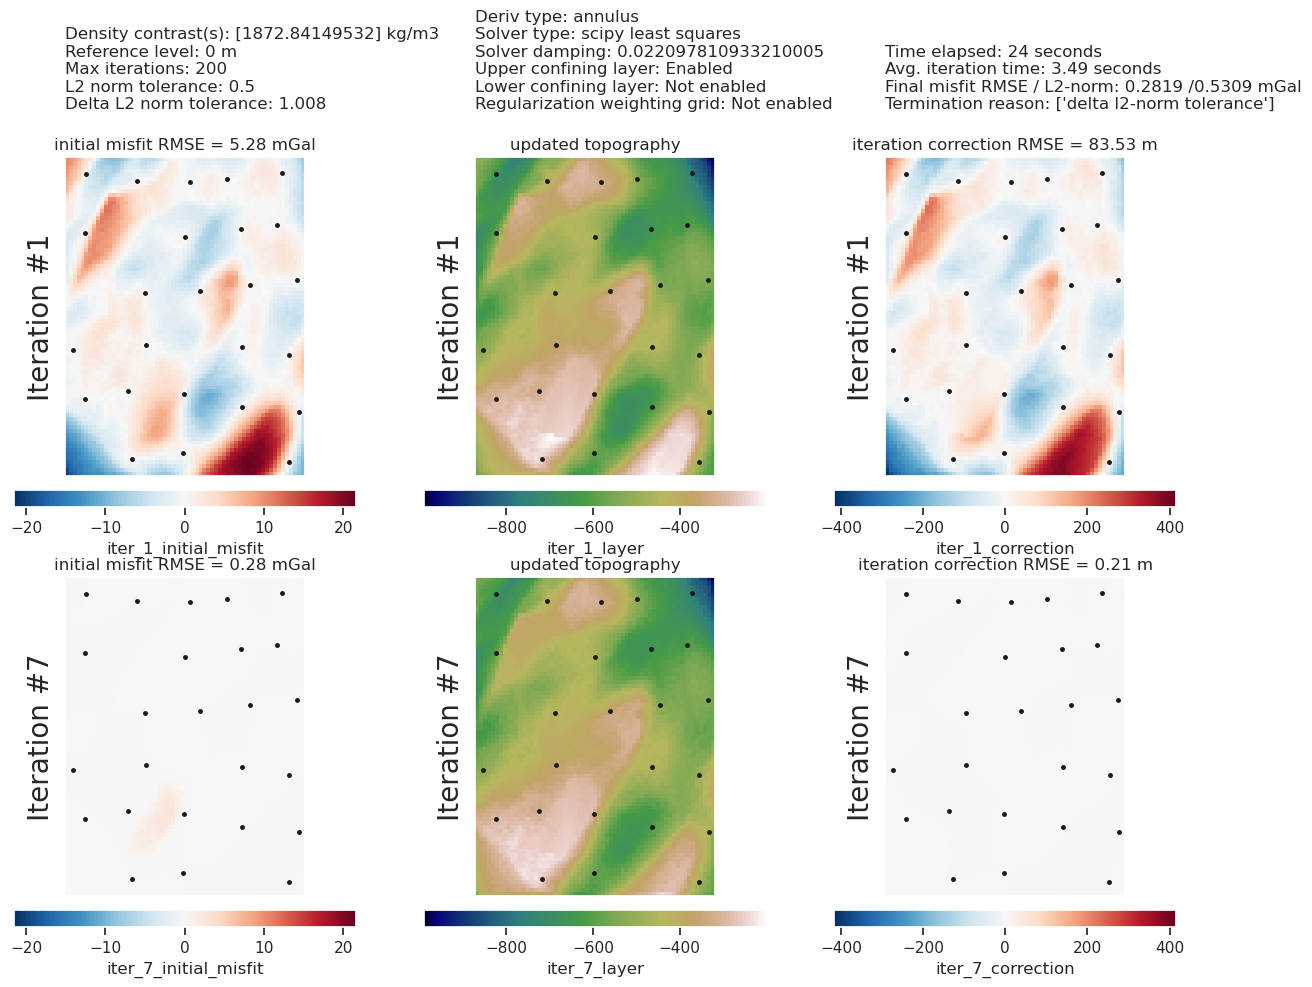

In [43]:

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    # plot_iter_results=False,
    plot_topo_results=False,
    # plot_grav_results=False,
    constraints_df=constraint_points,
    constraint_size=5,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
    points_pen="1p",
)

# Uncertainty 

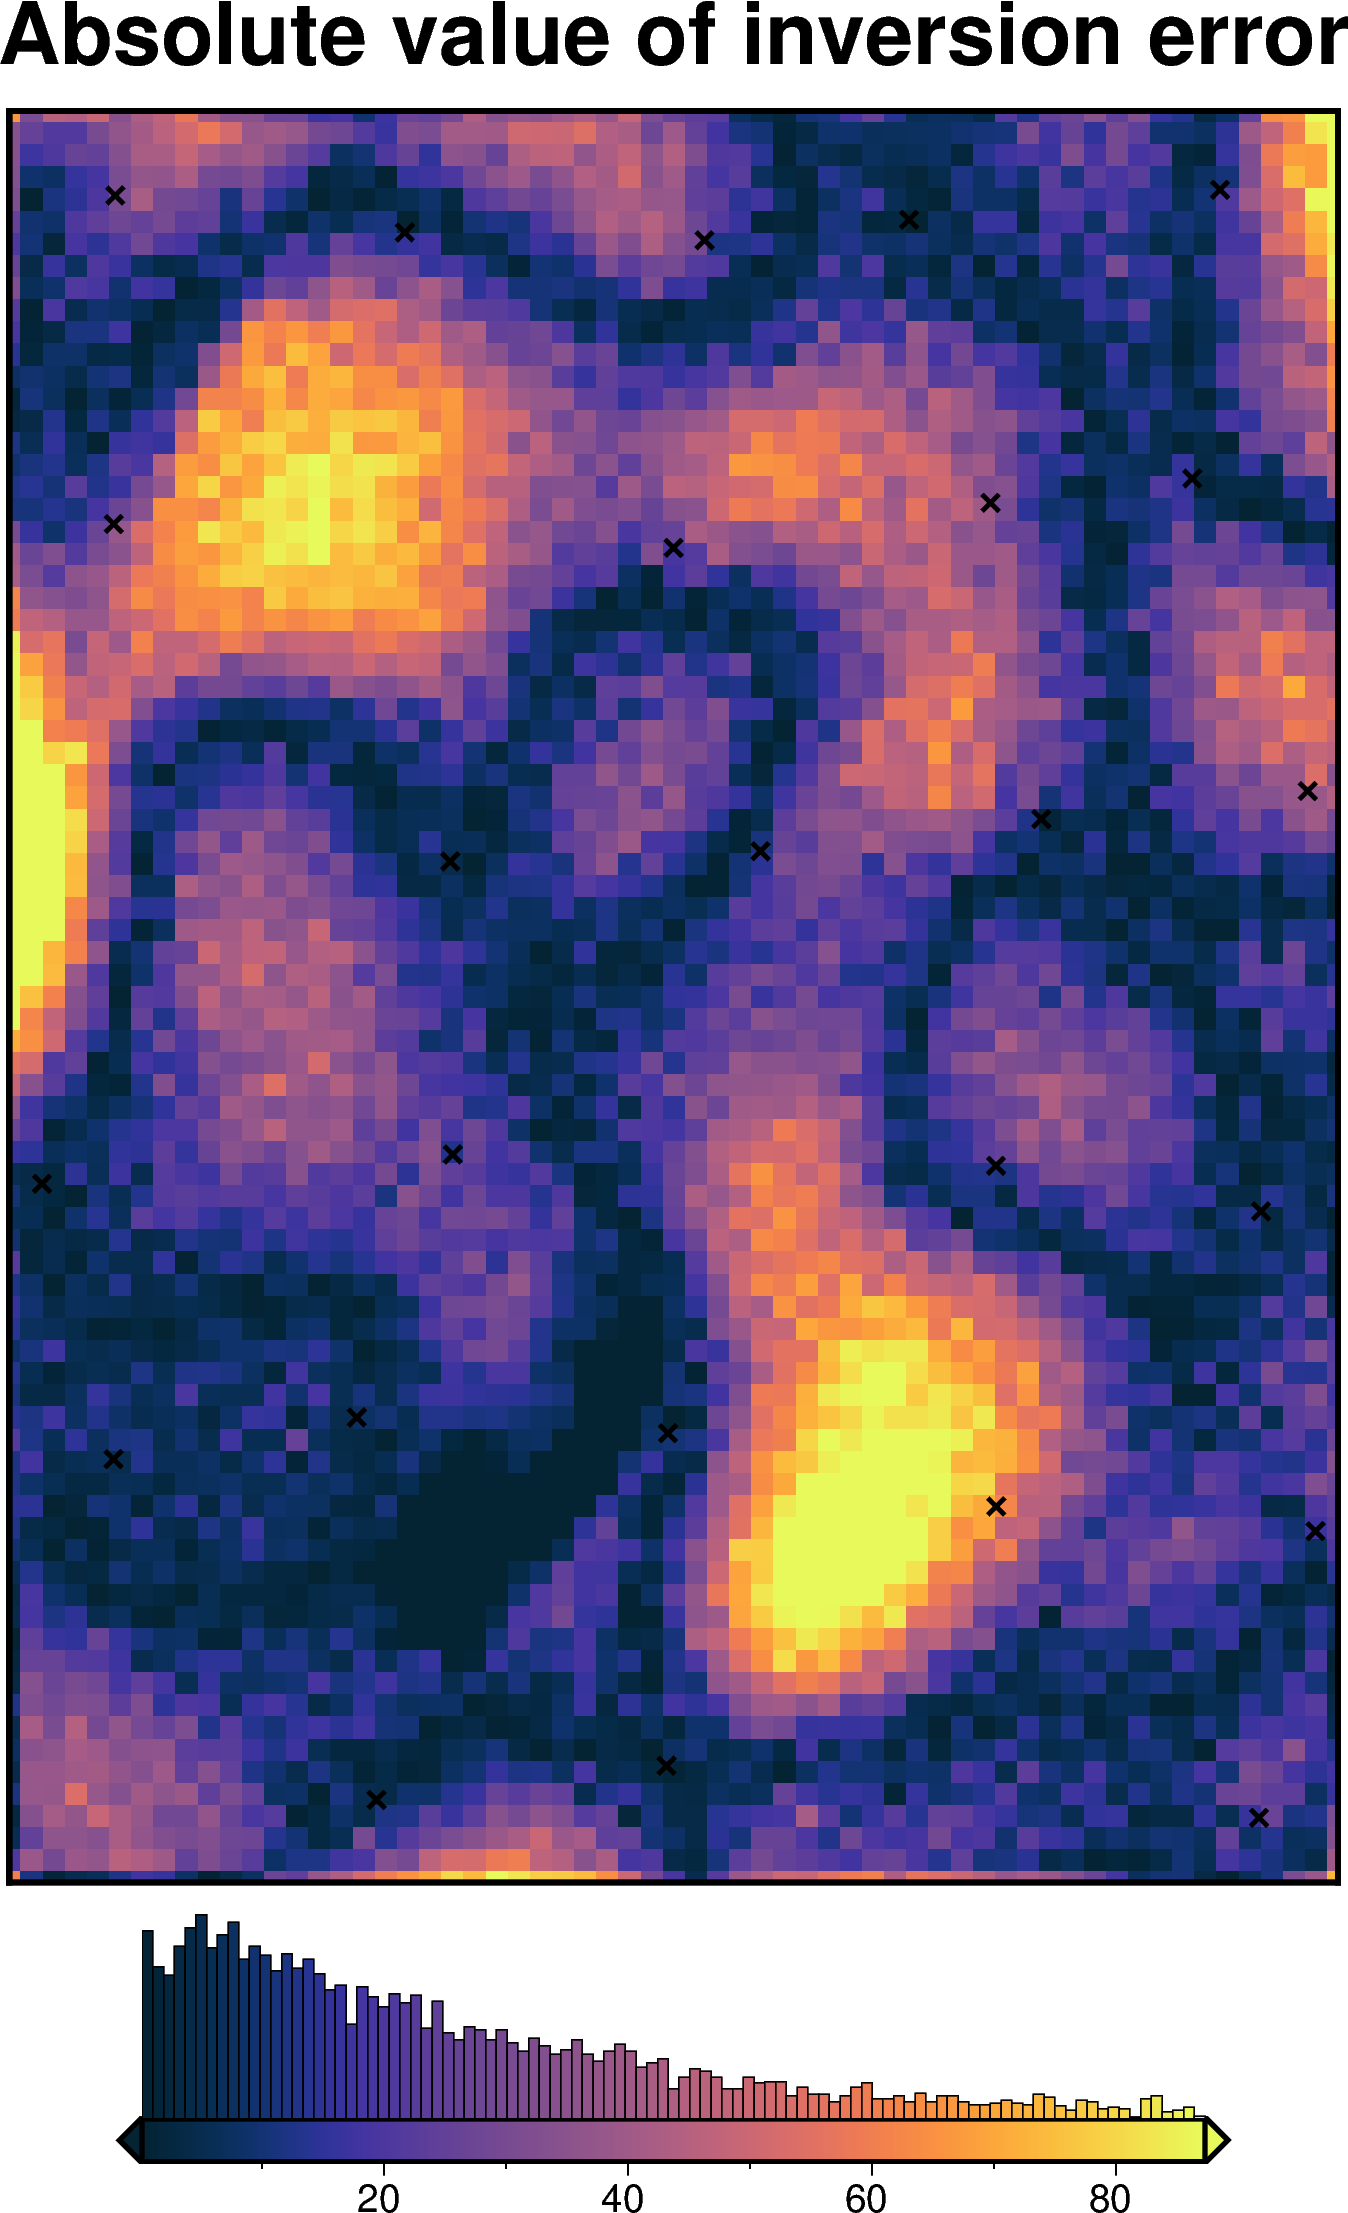

In [44]:
inversion_error = np.abs(bathymetry - final_topography)
fig = maps.plot_grd(
    inversion_error,
    region=inversion_region,
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)
fig.show()

## Starting topography uncertainty


In [45]:
# get best damping value used when creating grid
best_spline_damping = starting_bathymetry.attrs["damping"]
best_spline_damping

np.float64(1e-40)

INFO:invert4geom:Sampled 'dampings' parameter values; mean: 9.106530079496926e-38, min: 3.289989749146697e-45, max: 3.0395231482388766e-36


starting topography ensemble:   0%|          | 0/40 [00:00<?, ?it/s]

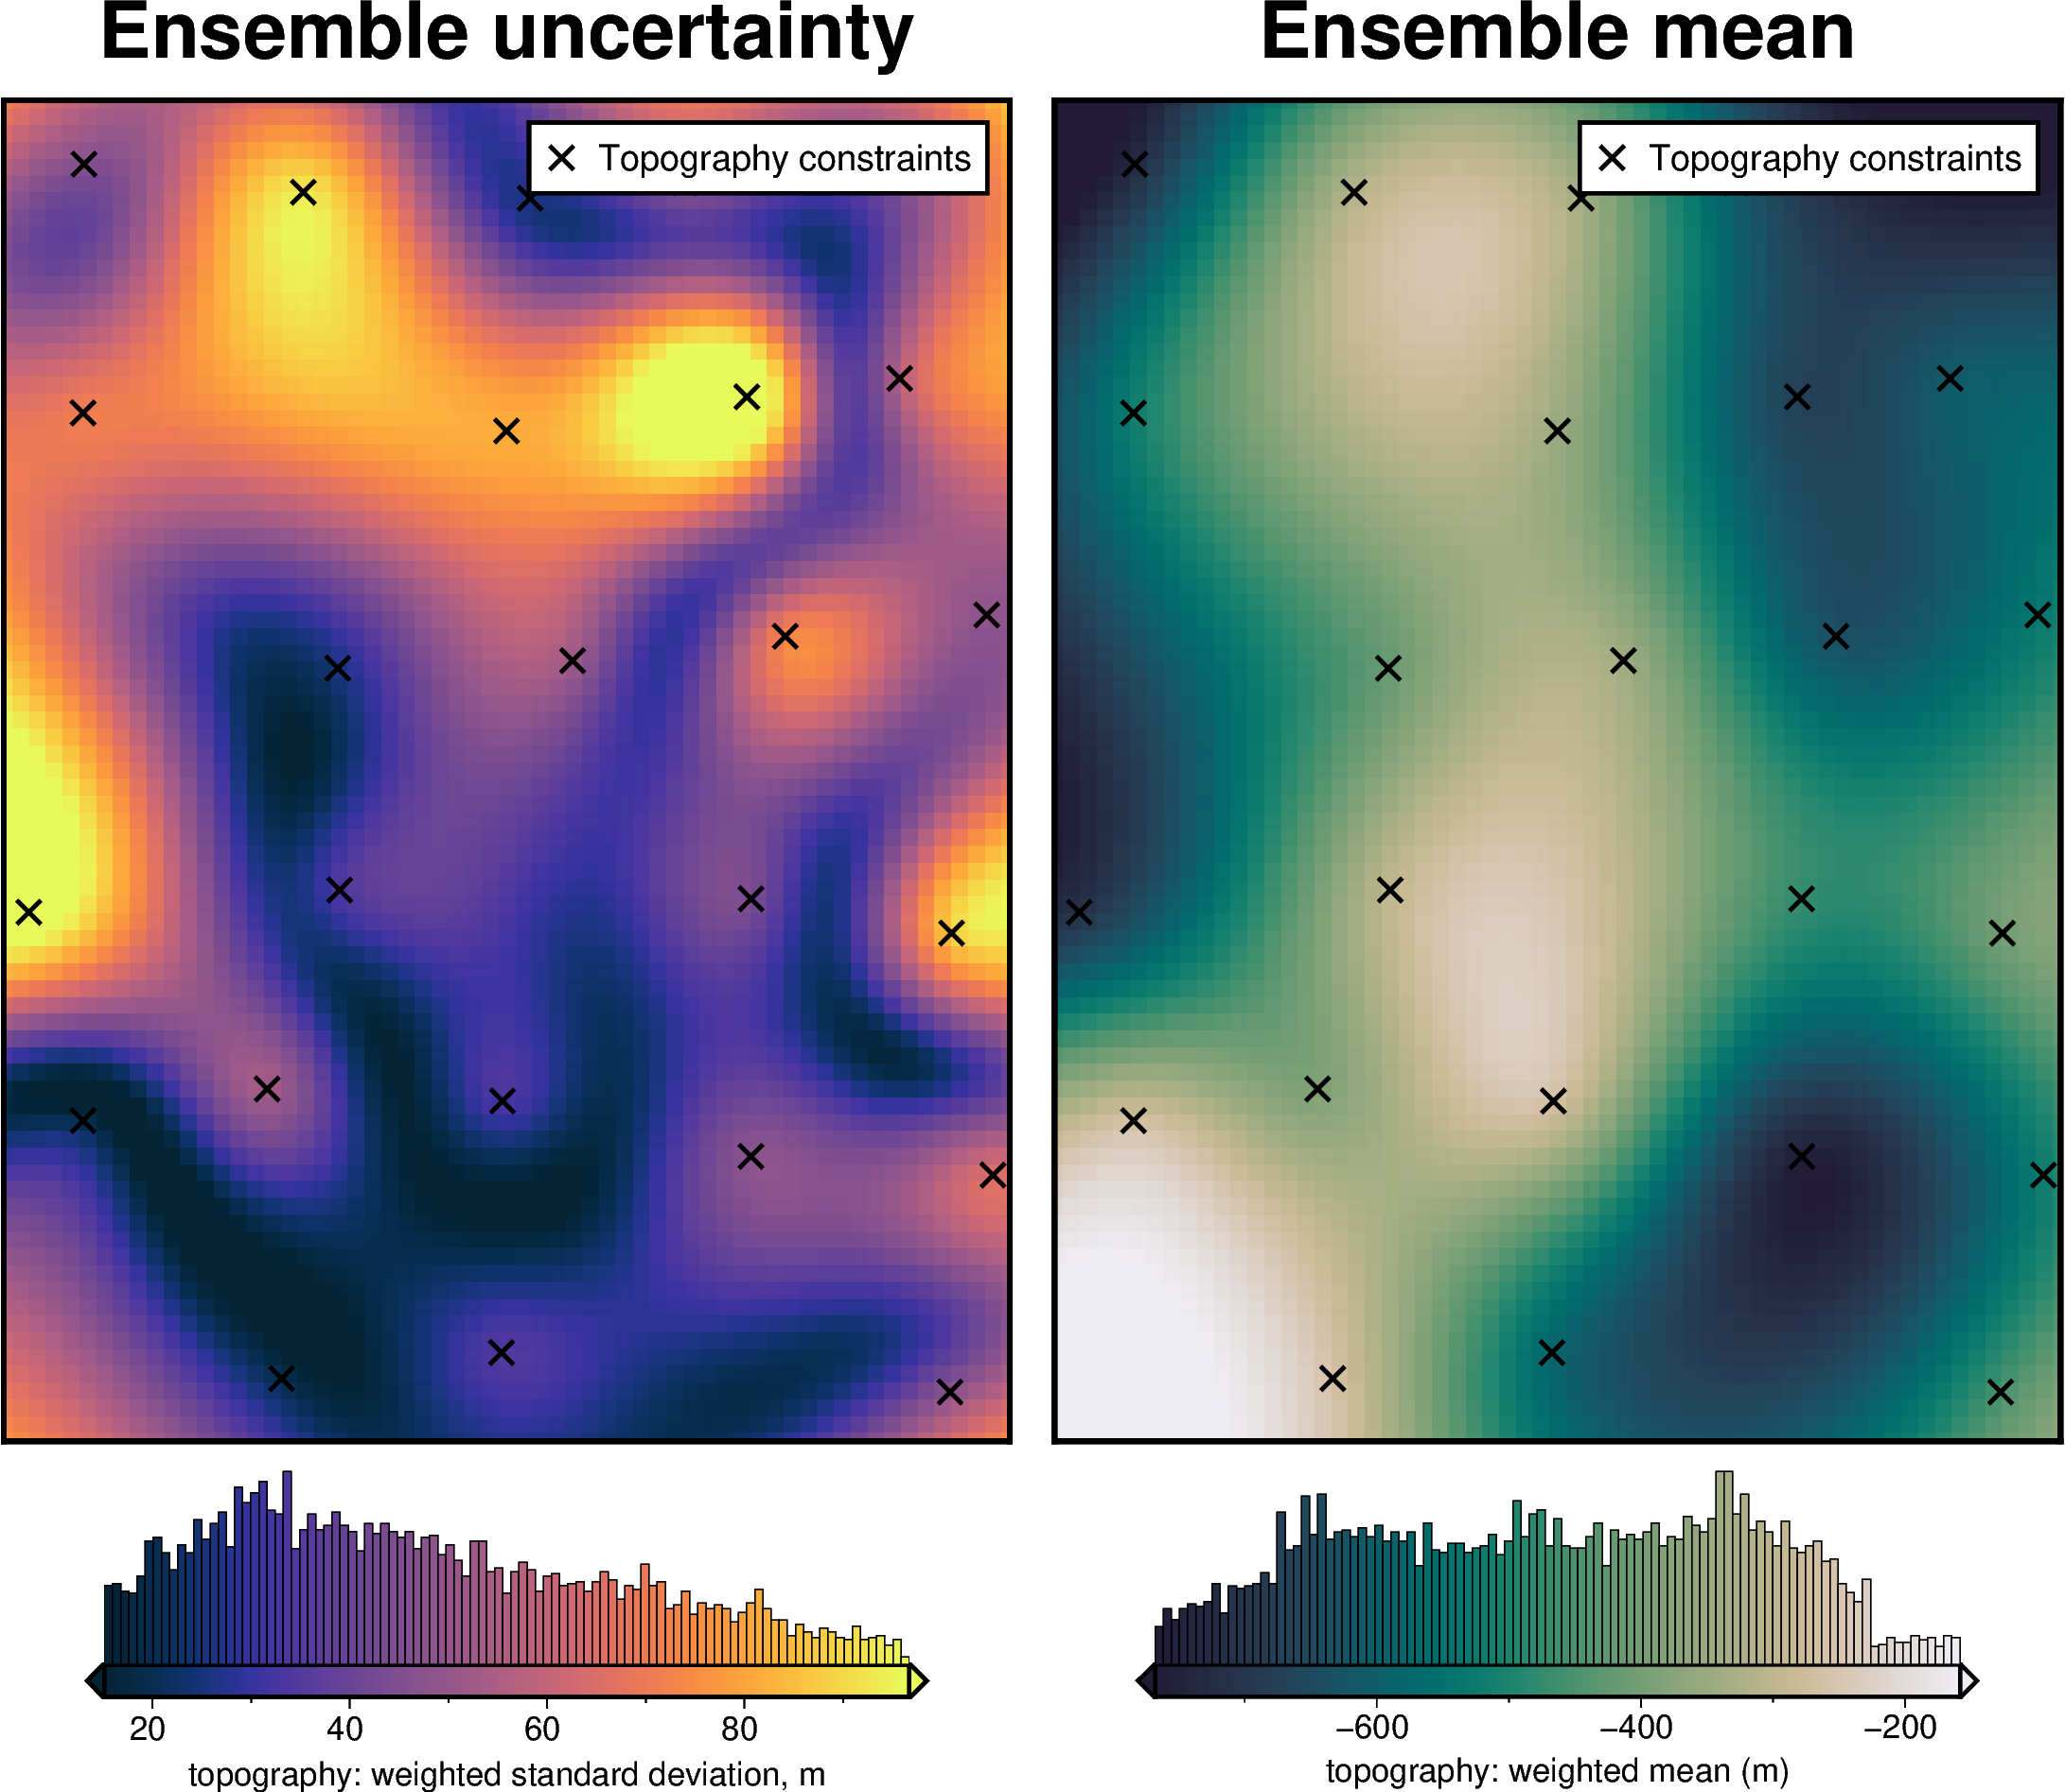

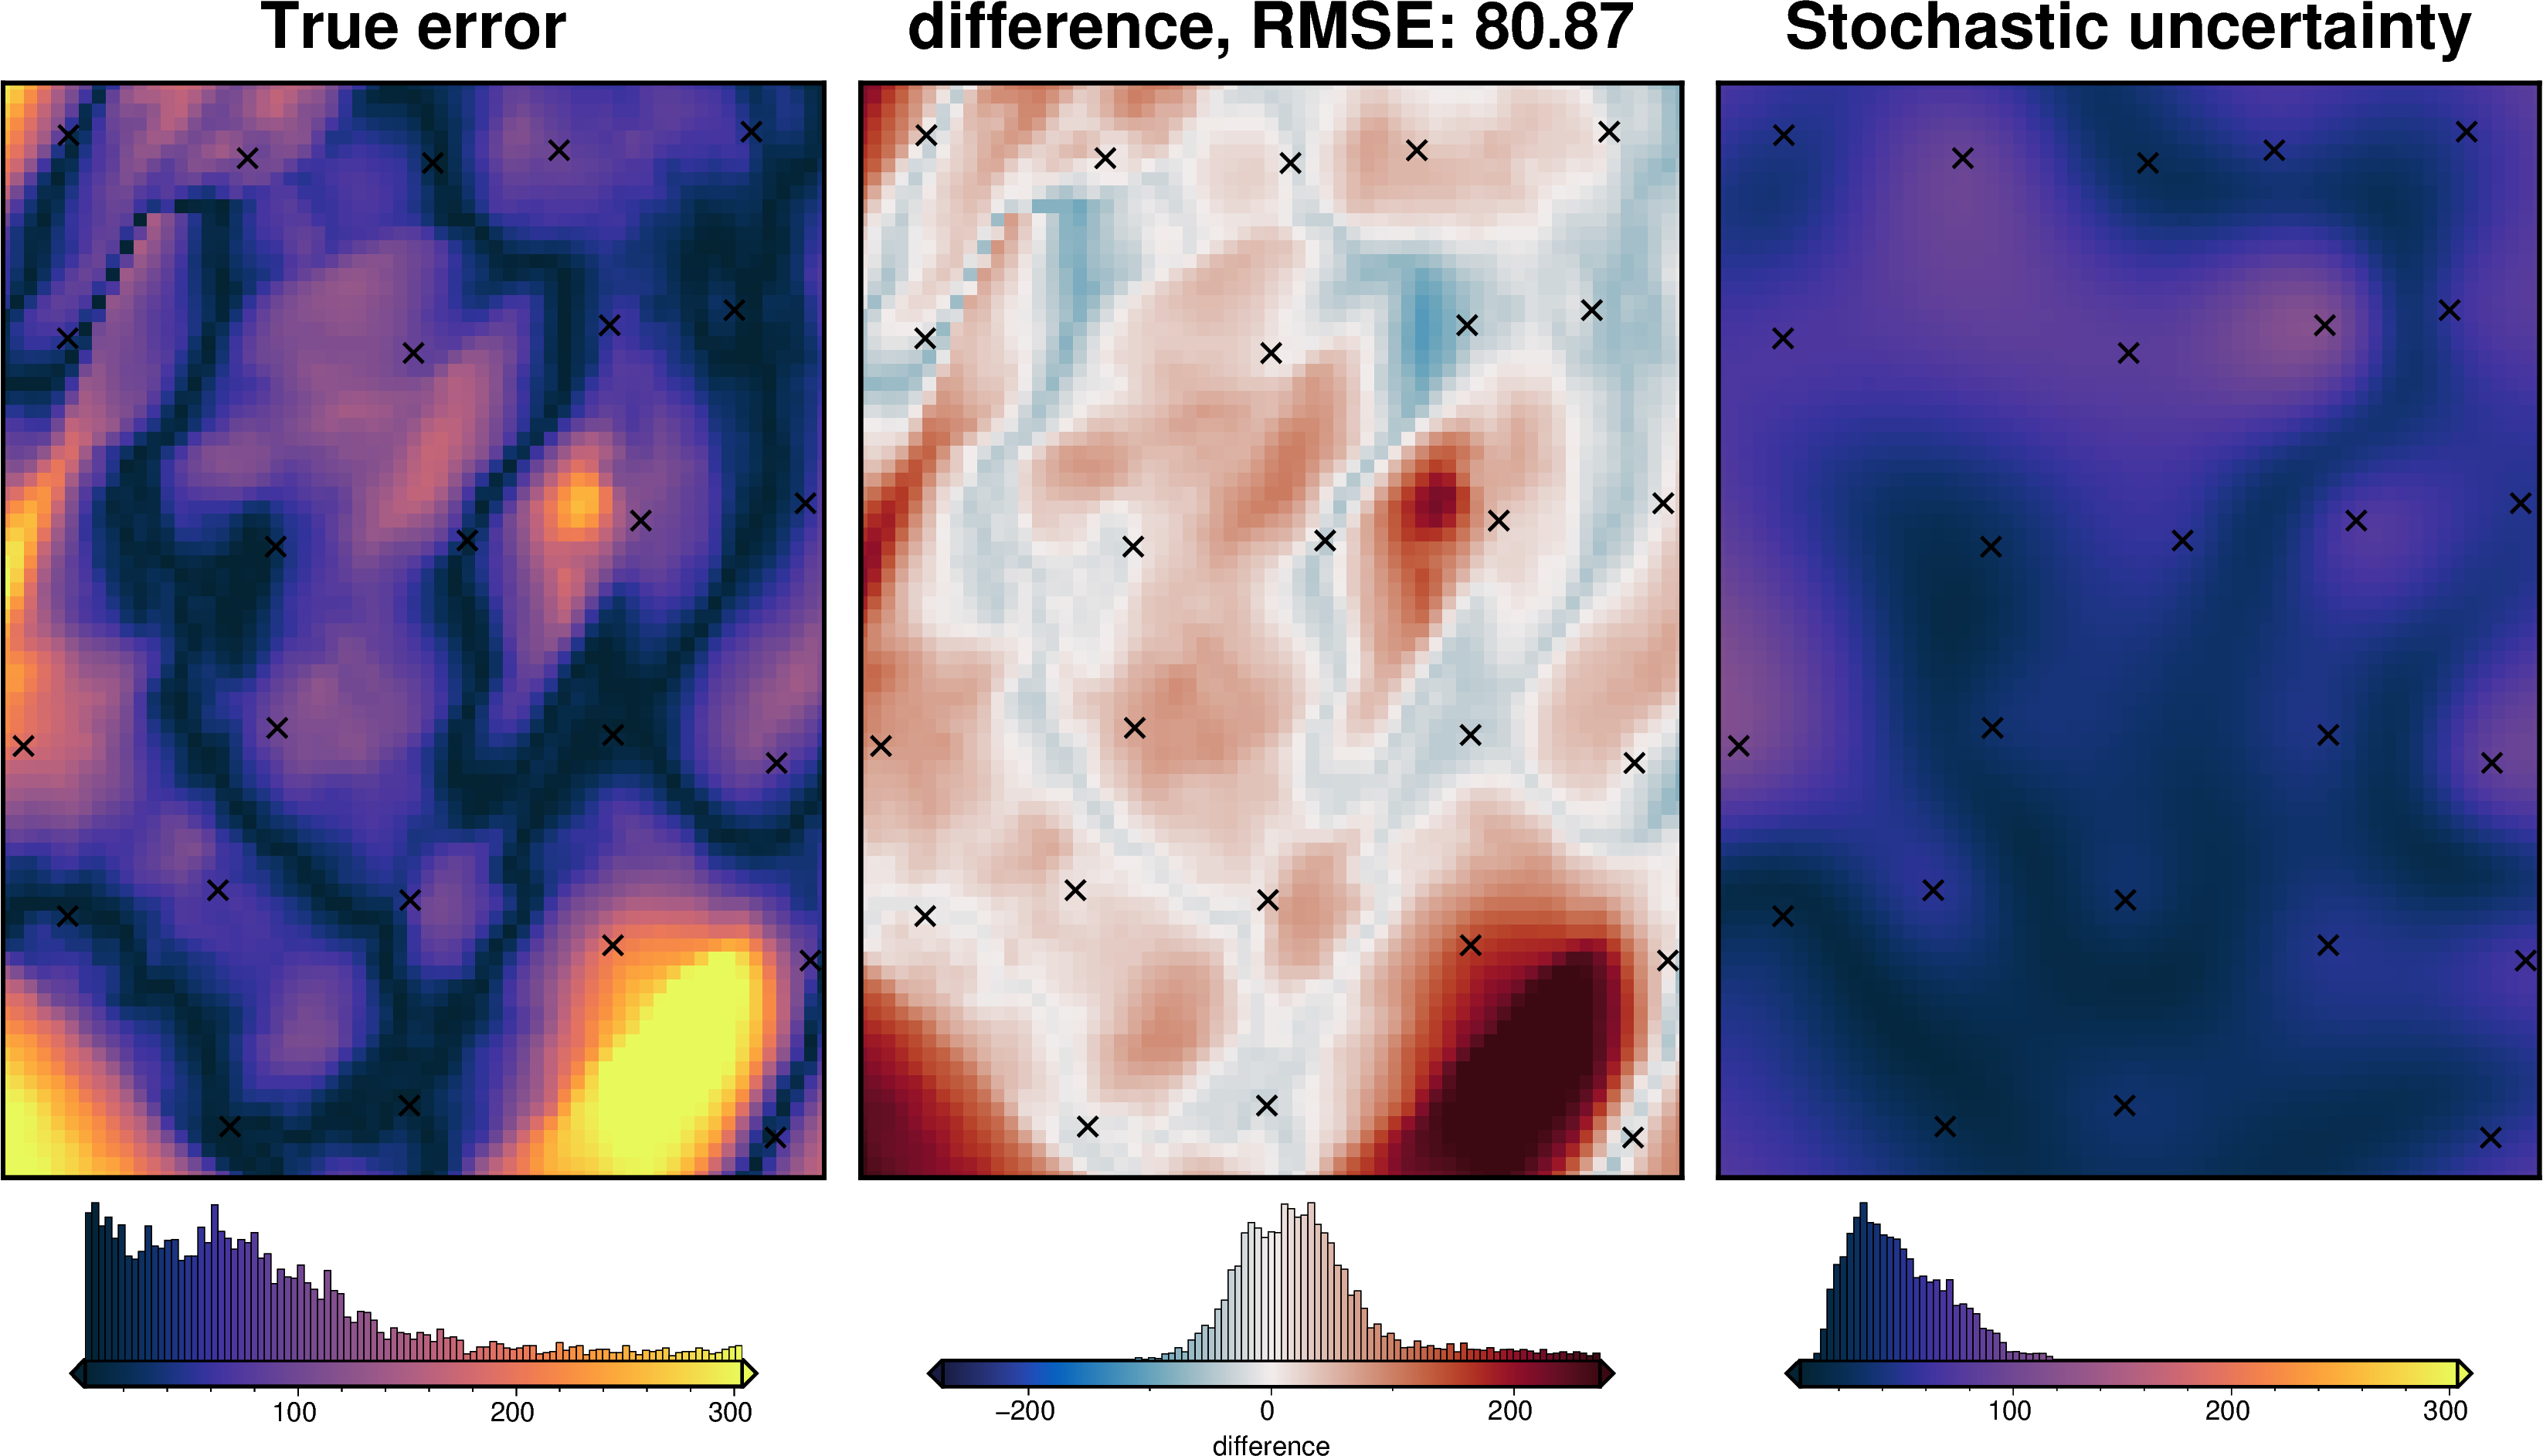

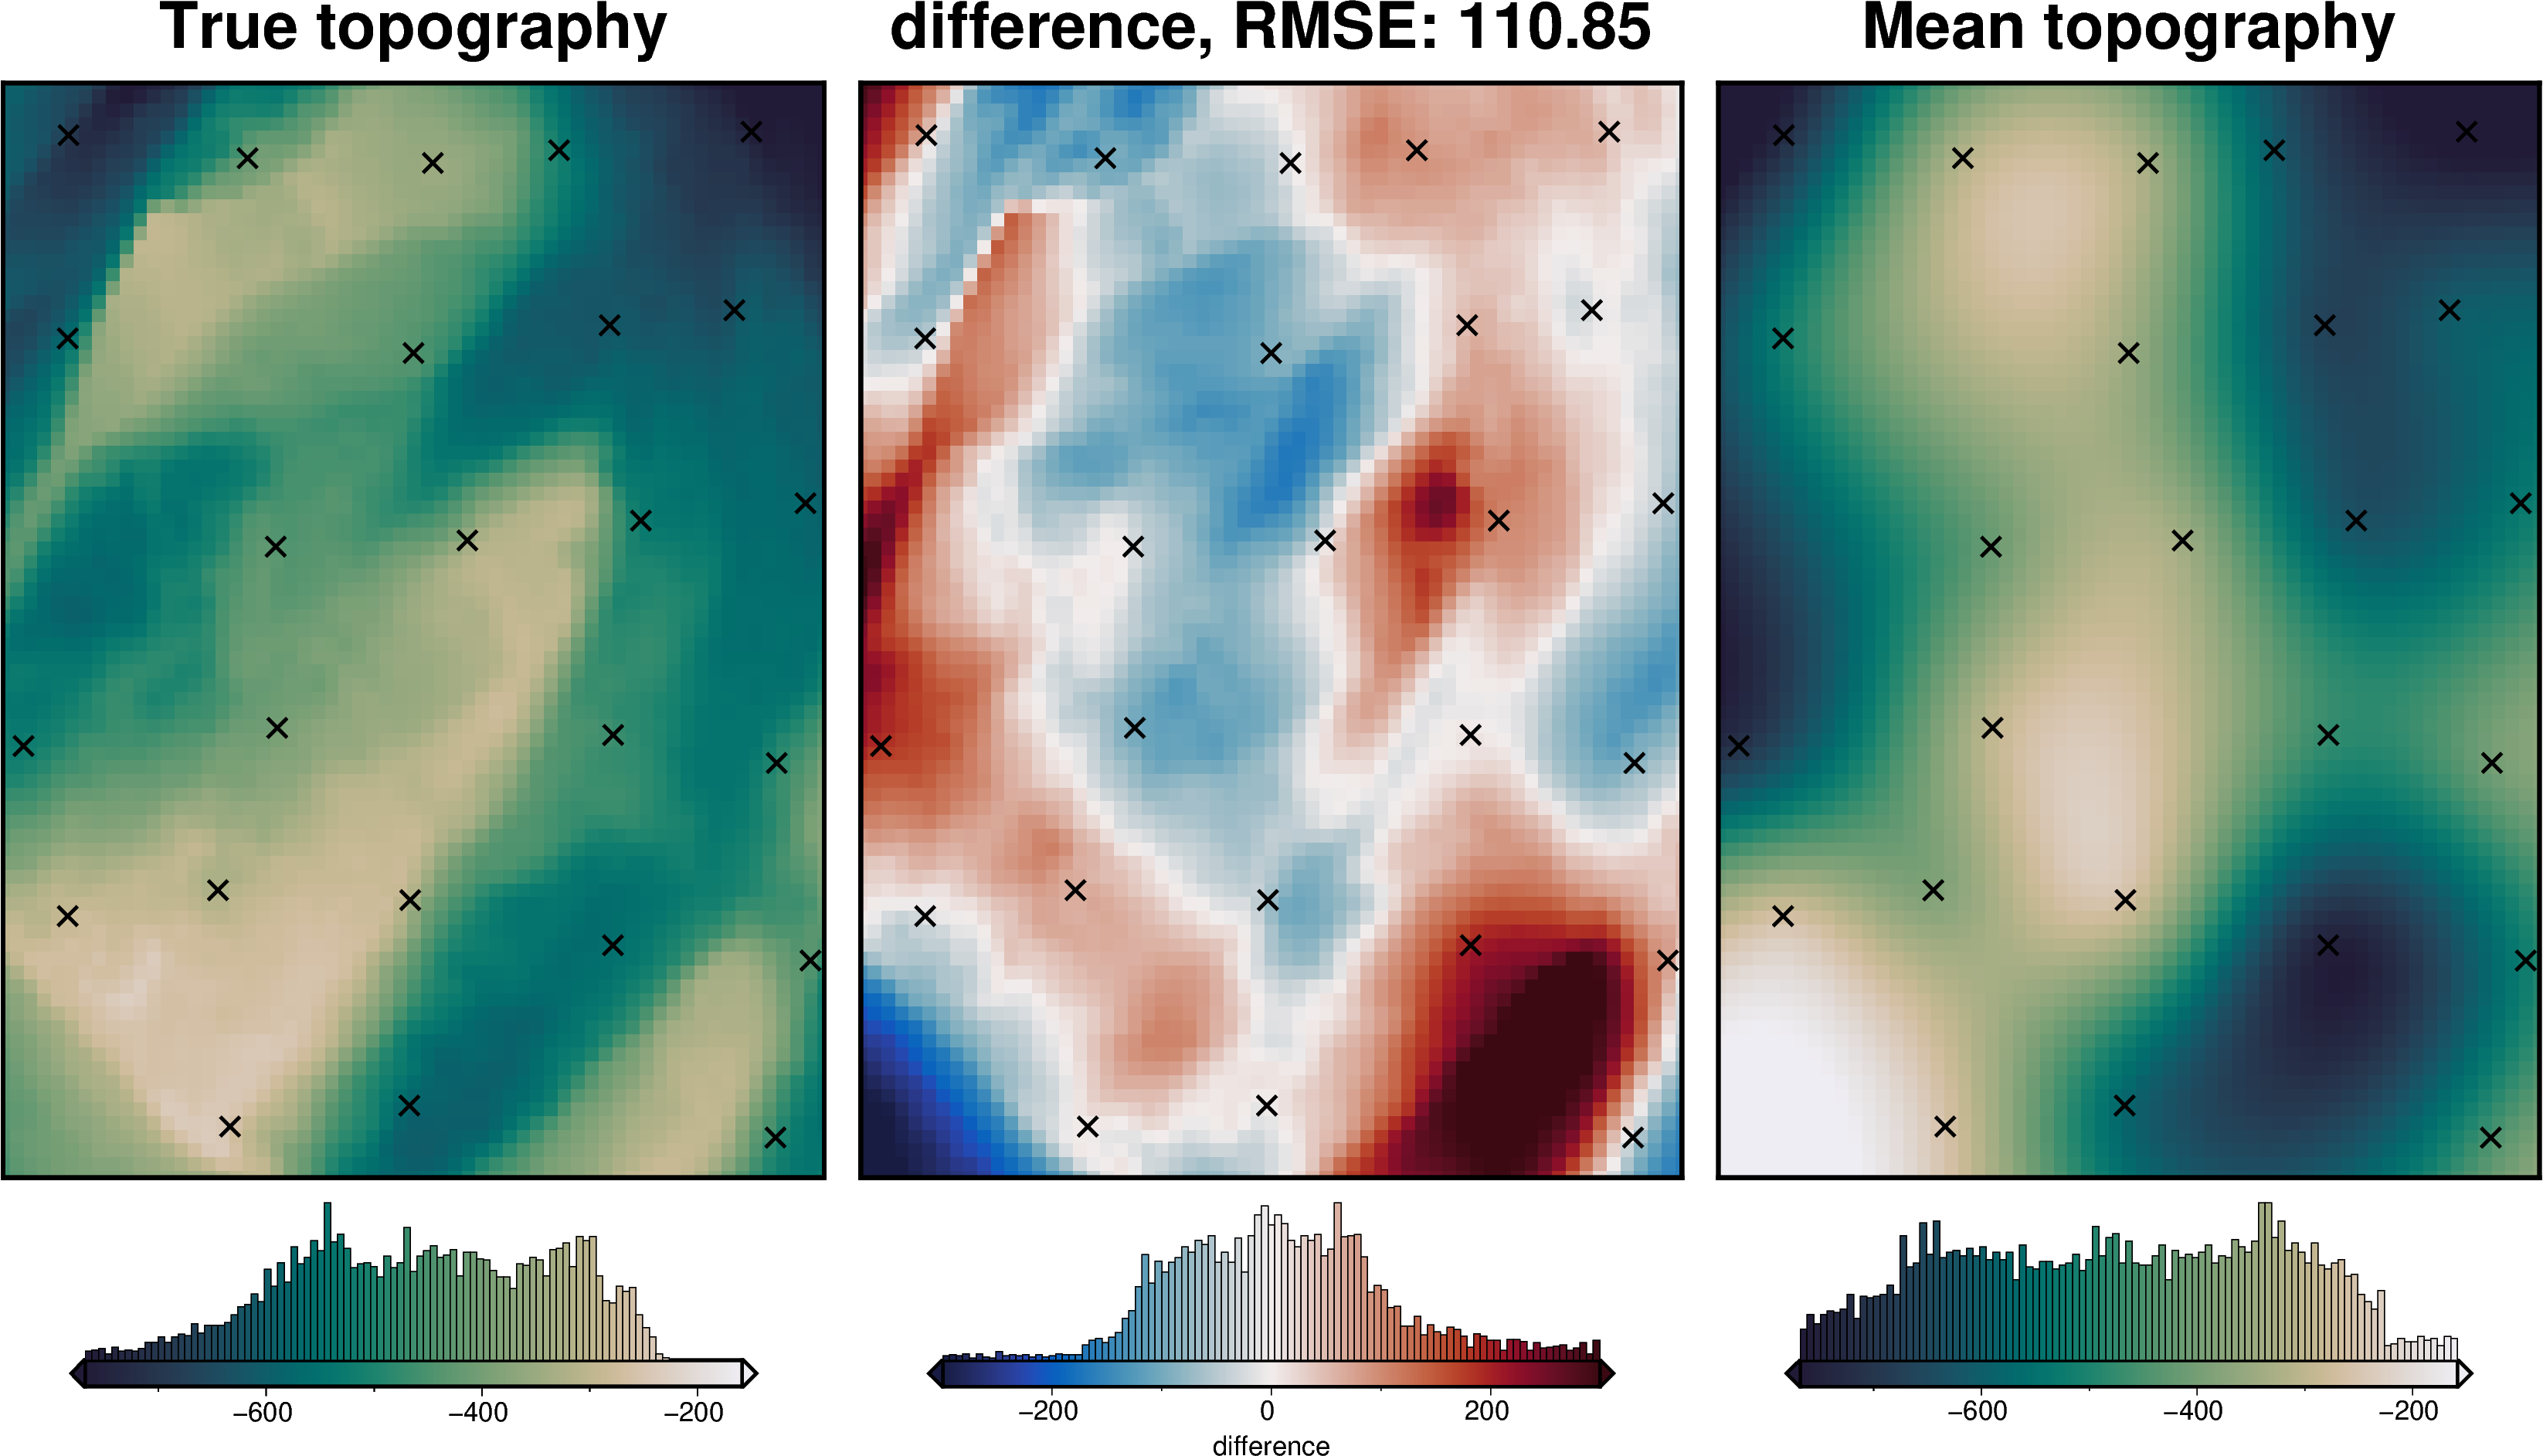

In [46]:
starting_topography_parameter_dict = {
    "dampings": {
        "distribution": "normal",
        "loc": np.log10(best_spline_damping),  # mean; base 10 exponent
        "scale": 2,  # standard deviation of exponent
        "log": True,
    },
}
starting_topo_stats = uncertainty.starting_topography_uncertainty(
    runs=40,
    sample_constraints=True,
    parameter_dict=starting_topography_parameter_dict,
    method="splines",
    dampings=best_spline_damping,
    region=inversion_region,
    spacing=spacing,
    constraints_df=constraint_points,
    weights=constraint_points.weight,
    plot_region=inversion_region,
    true_topography=bathymetry,
)

## Regional field estimation uncertainty


In [47]:
# use the constraints to find the best regional field
_ = regional.regional_separation(grav_df=grav_df, **regional_grav_kwargs)

# re-load the study from the saved pickle file
with pathlib.Path(f"{regional_grav_kwargs.get('cv_kwargs').get('fname')}.pickle").open("rb") as f:
    study = pickle.load(f)
eq_damping = min(study.best_trials, key=lambda t: t.values[0]).params["damping"]
eq_damping

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 0
INFO:invert4geom:	parameter: {'damping': 1e-60}
INFO:invert4geom:	scores: [0.43059752539295265]


1e-60

In [48]:
# if depth="default" in EquivalentSources, it will use 4.5 times the mean distances
# between nearest points as the depth
# calculate that mean distance below.
mean_constraint_distance = np.mean(
    vd.median_distance(
        (constraint_points.easting, constraint_points.northing), k_nearest=1
    )
)
mean_constraint_distance

np.float64(61739.975124511875)

In [49]:
np.log10(eq_damping)

np.float64(-60.0)

INFO:invert4geom:Sampled 'depth' parameter values; mean: 262394.8942791755, min: 157051.0617229771, max: 367738.7268353739
INFO:invert4geom:Sampled 'damping' parameter values; mean: 9.459571806686683e-60, min: 5.735843224101187e-63, max: 1.743422825432467e-58


starting regional ensemble:   0%|          | 0/40 [00:00<?, ?it/s]

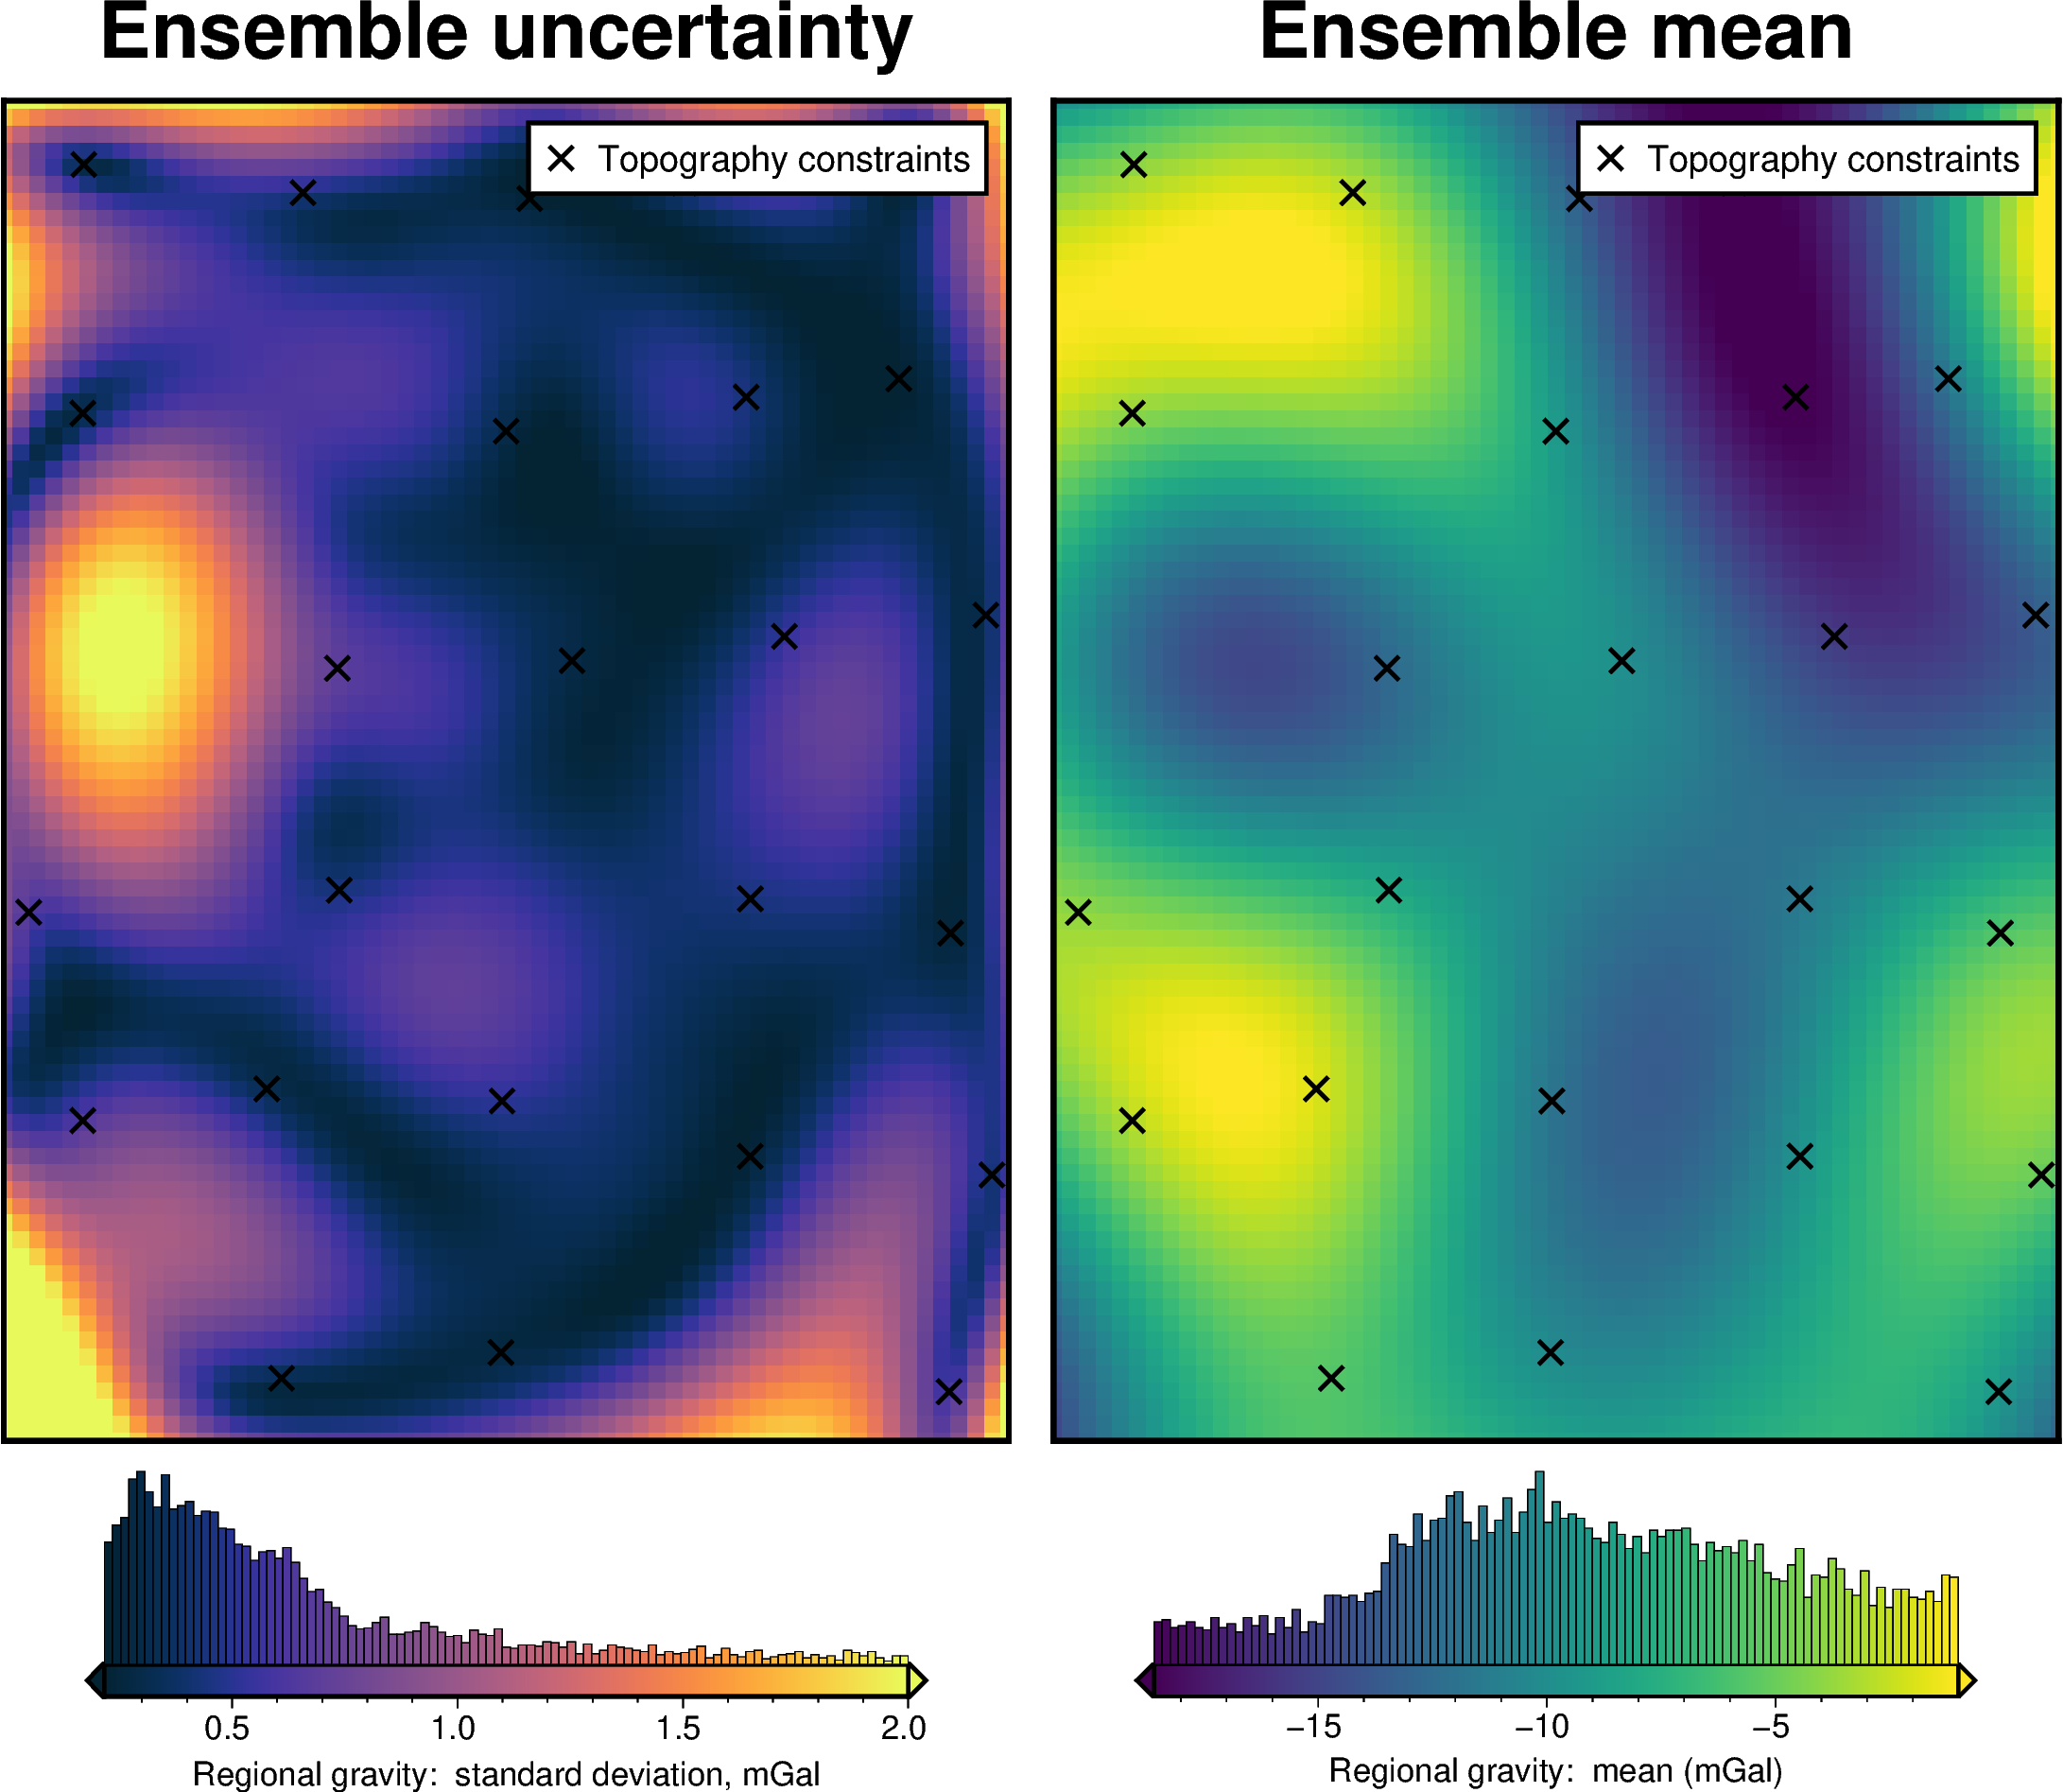

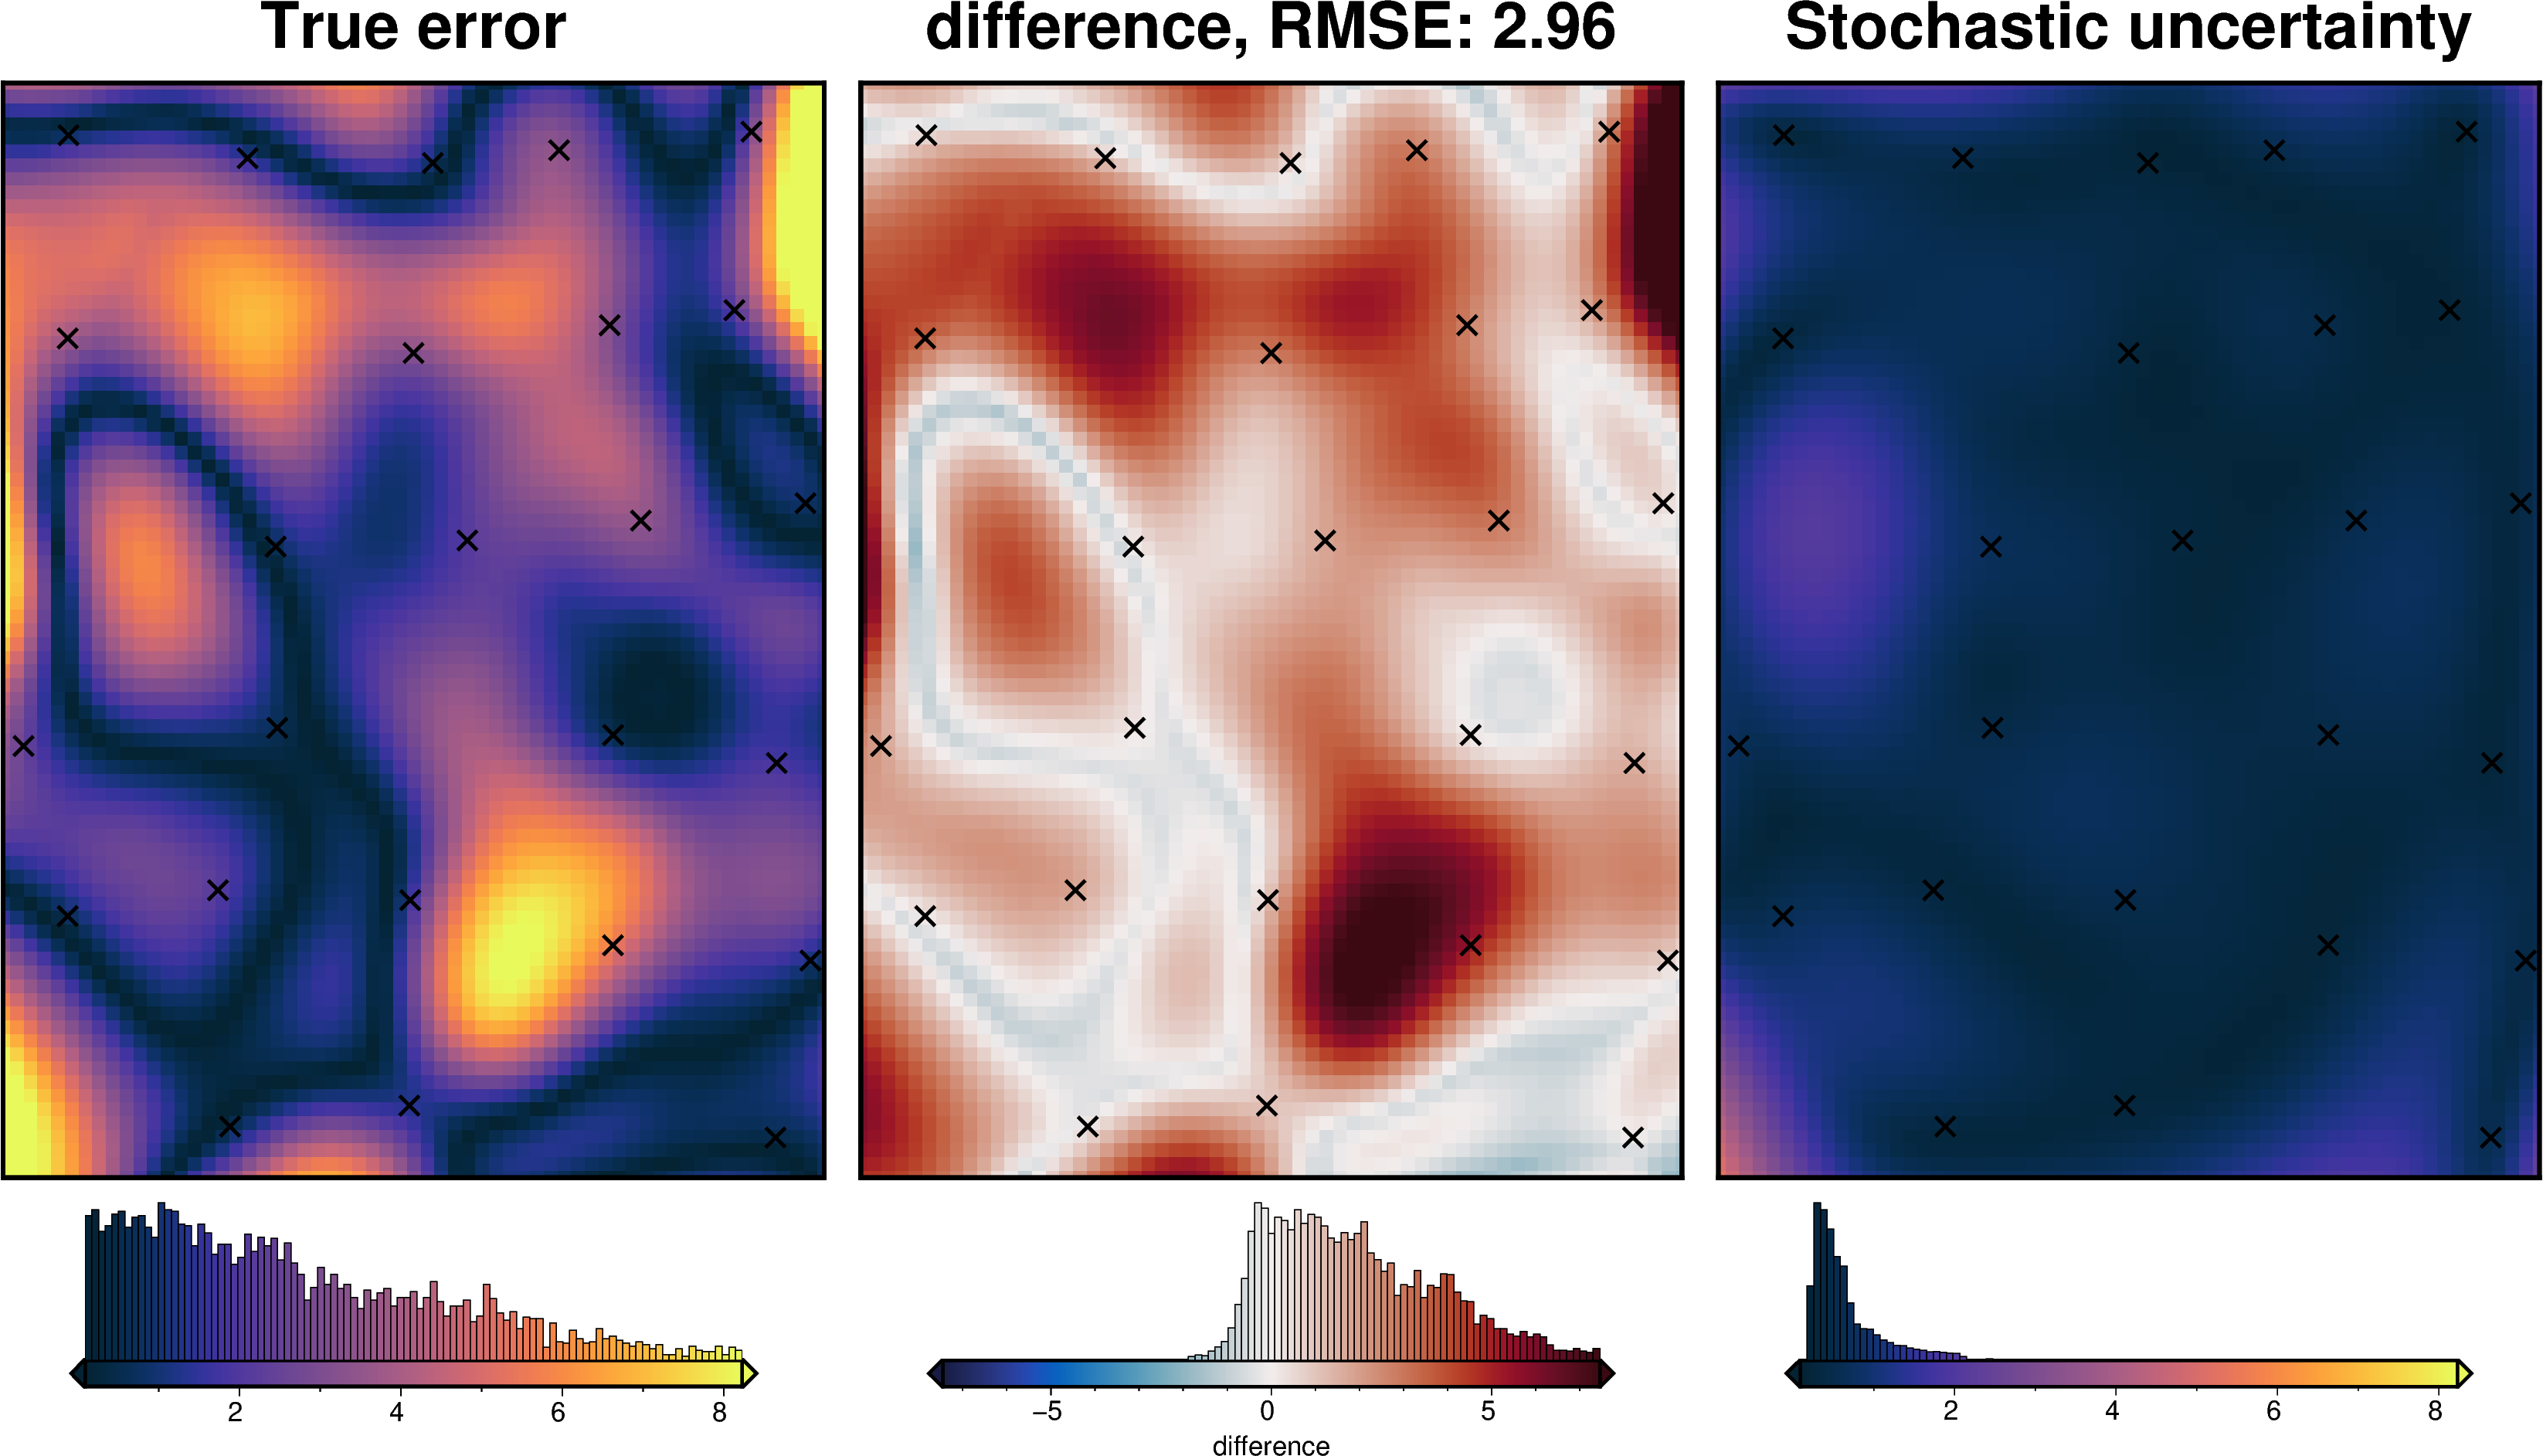

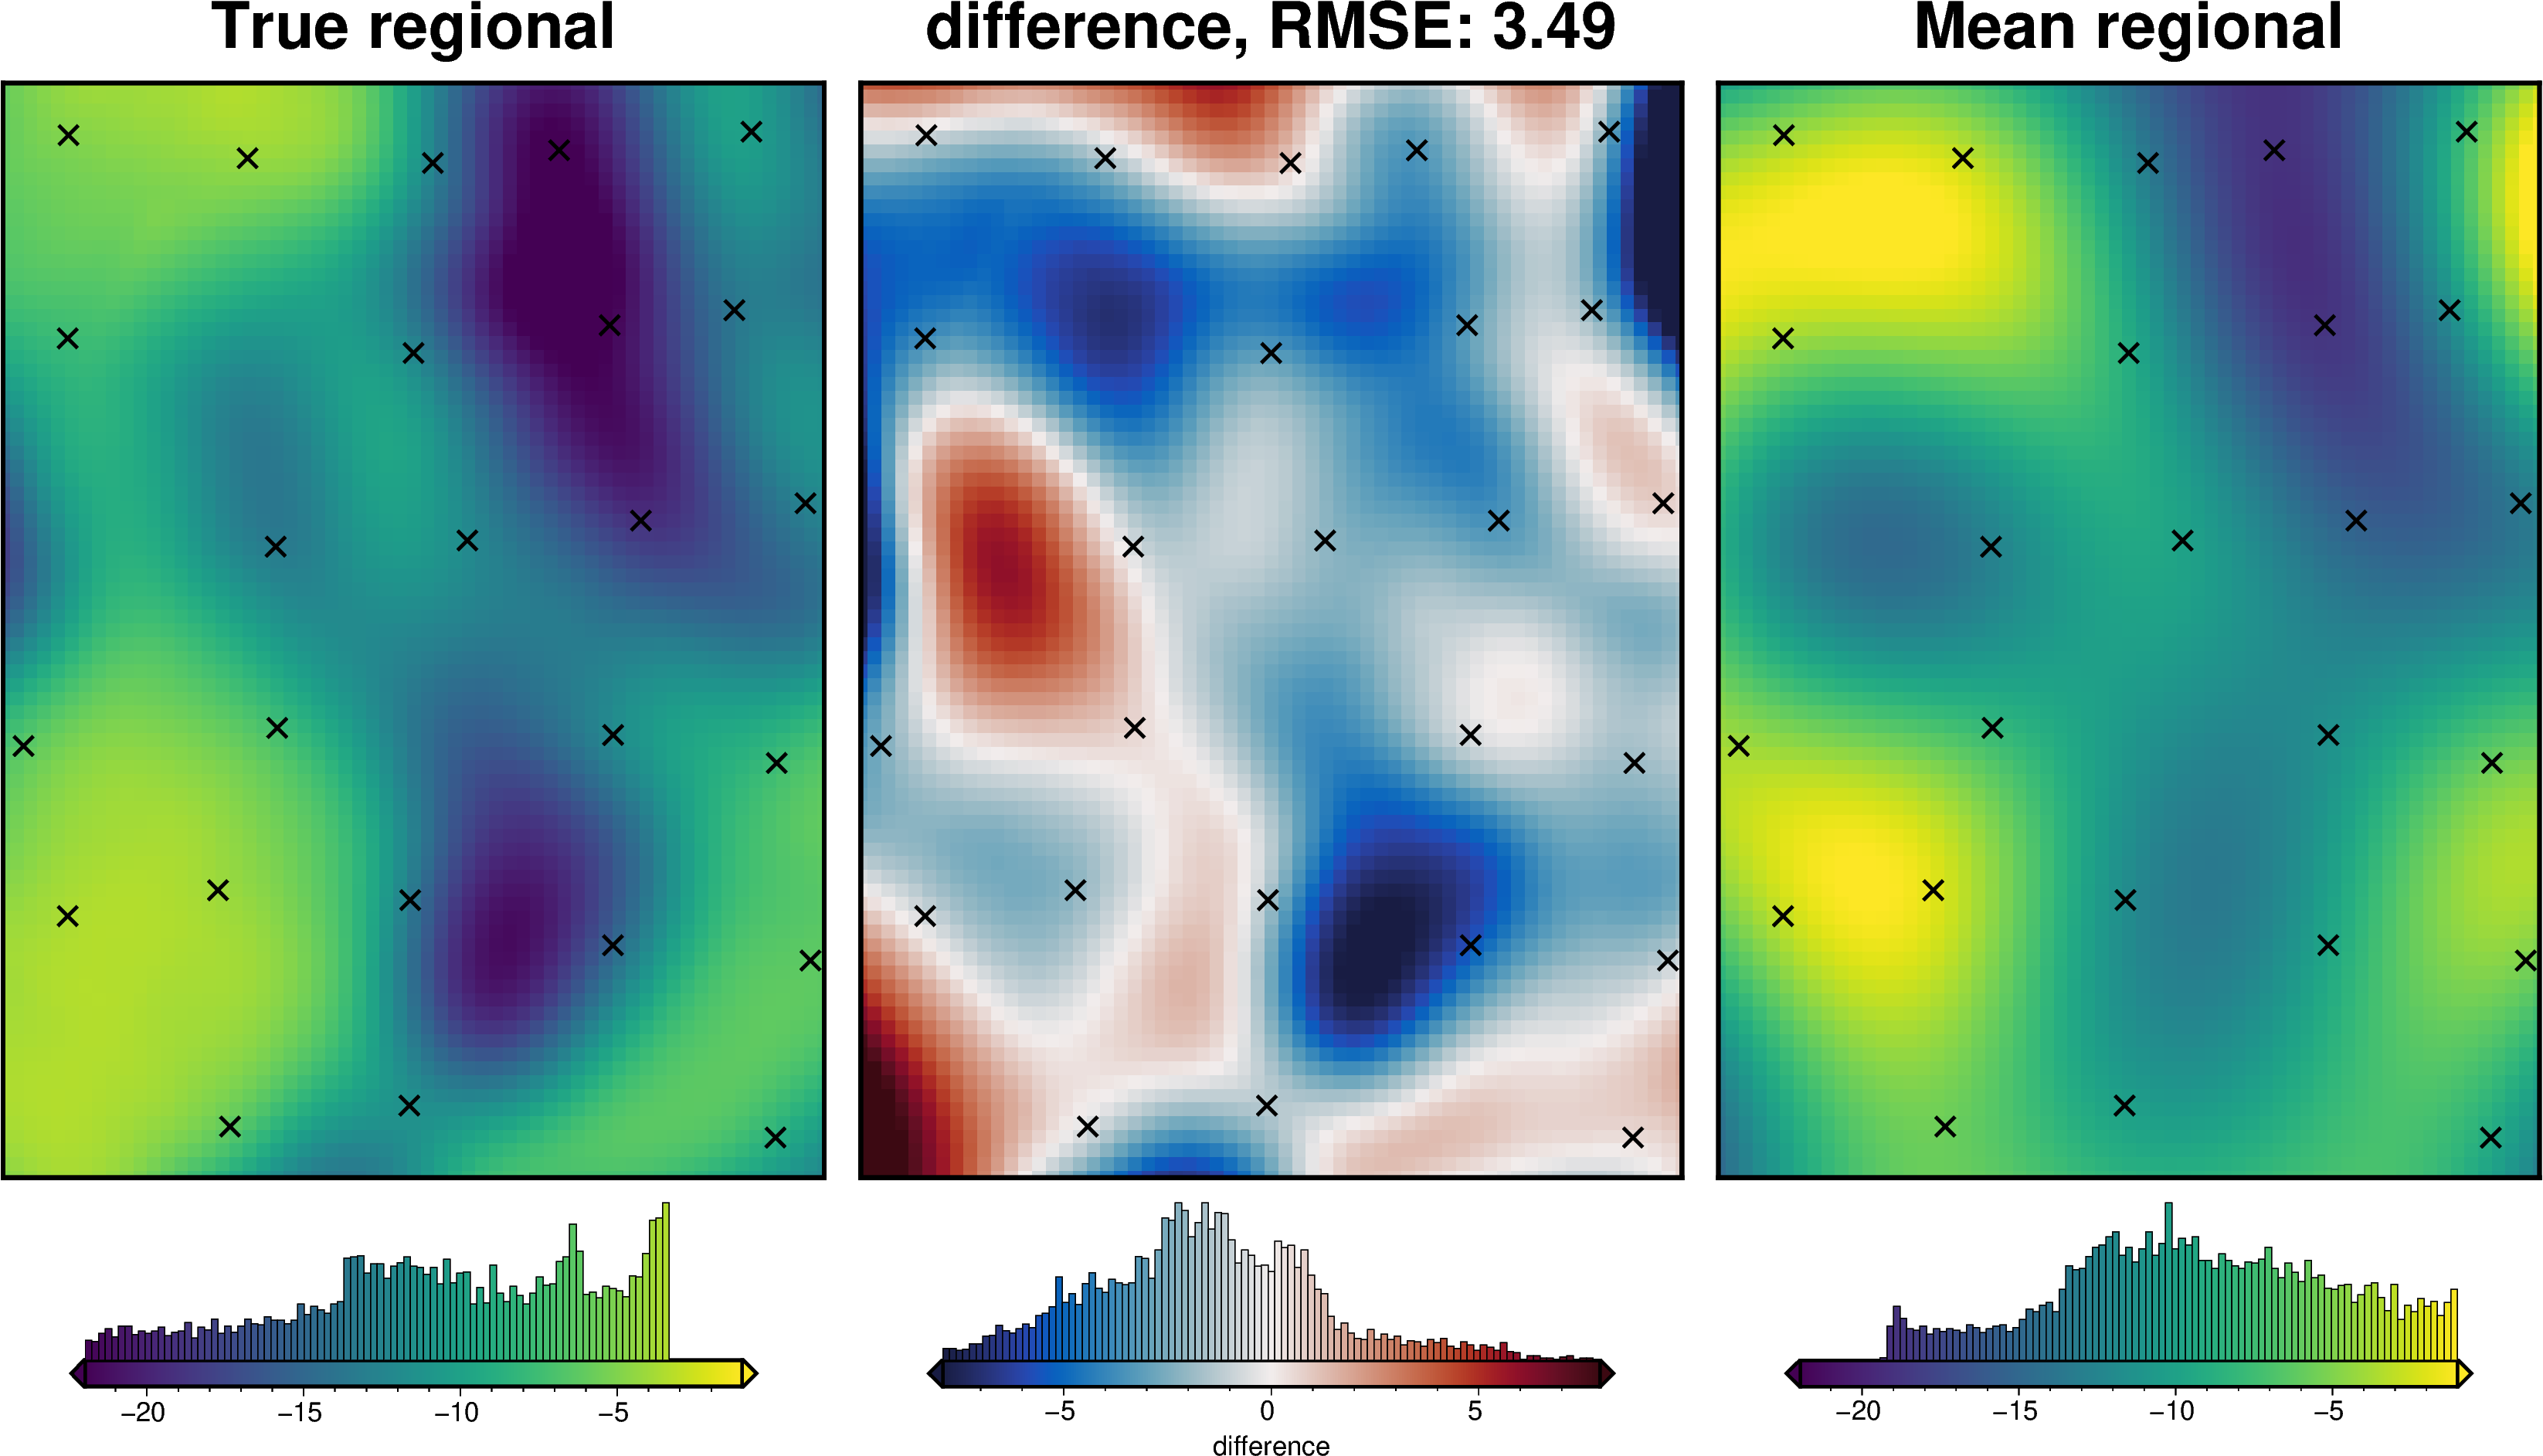

In [50]:
regional_misfit_parameter_dict = {
    "depth": {
        "distribution": "uniform",
        "loc": 2.5 * mean_constraint_distance,  # lower bound
        "scale": 3.5 * mean_constraint_distance,  # range, 2.5+3.5=6
    },
    "damping": {
        "distribution": "normal",
        "loc": np.log10(eq_damping),  # mean base 10 exponent
        "scale": 1,  # standard deviation of exponent
        "log": True,
    },
}

regional_kwargs = dict(
    grav_df=grav_df,
    constraints_df=constraint_points,
    constraints_weights_column="weight",
    method="constraints",
    grid_method="eq_sources",
    damping=eq_damping,
    depth="default",
    block_size=None,
)

regional_misfit_stats = uncertainty.regional_misfit_uncertainty(
    runs=40,
    sample_gravity=True,
    parameter_dict=regional_misfit_parameter_dict,
    plot_region=inversion_region,
    true_regional=grav_grid.basement_grav,
    **regional_kwargs,
)

## Sensitivity analysis

In [51]:
# plotting functions for uncertainty results
def uncert_plots(results):
    ds = uncertainty.merged_stats(
        results=results,
        plot=True,
        region=inversion_region,
        constraints_df=constraint_points,
        weight_by="constraints",
    )
    _ = polar_utils.grd_compare(
        bathymetry,
        ds.weighted_mean,
        region=inversion_region,
        plot=True,
        grid1_name="True topography",
        grid2_name="Inverted topography",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        reverse_cpt=True,
        cmap="rain",
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )
    _ = polar_utils.grd_compare(
        np.abs(bathymetry - ds.weighted_mean),
        ds.weighted_stdev,
        region=inversion_region,
        plot=True,
        grid1_name="True error",
        grid2_name="Stochastic uncertainty",
        robust=True,
        cmap="thermal",
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )

In [52]:
# parameters used in final inversion
best_density_contrast, best_damping, best_spline_damping

(1872.8414953209308, 0.022097810933210005, np.float64(1e-40))

In [53]:
# kwargs to reuse for all uncertainty analyses
uncert_kwargs = dict(
    runs=20,
    grav_df=grav_df,
    constraints_df=constraint_points,
    density_contrast=best_density_contrast,
    zref=0,
    solver_damping=best_damping,
    starting_prisms=starting_prisms,
    starting_topography=starting_bathymetry,
    # kwargs
    starting_topography_kwargs={
        "method": "splines",
        "region": buffer_region,
        "spacing": spacing,
        "constraints_df": constraint_points,
        "dampings": best_spline_damping,
        "weights": constraint_points.weight,
    },
    regional_grav_kwargs=regional_grav_kwargs,
    **kwargs,
)

fname_start = "../../results/Ross_sea_regional_uncertainty"

### Density component

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 1872.841495320931, min: 1578.8468976399226, max: 2166.8360930019394
INFO:invert4geom:No pickle files starting with '../../results/Ross_sea_regional_uncertainty_density' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: '../../results/Ross_sea_regional_uncertainty_density'



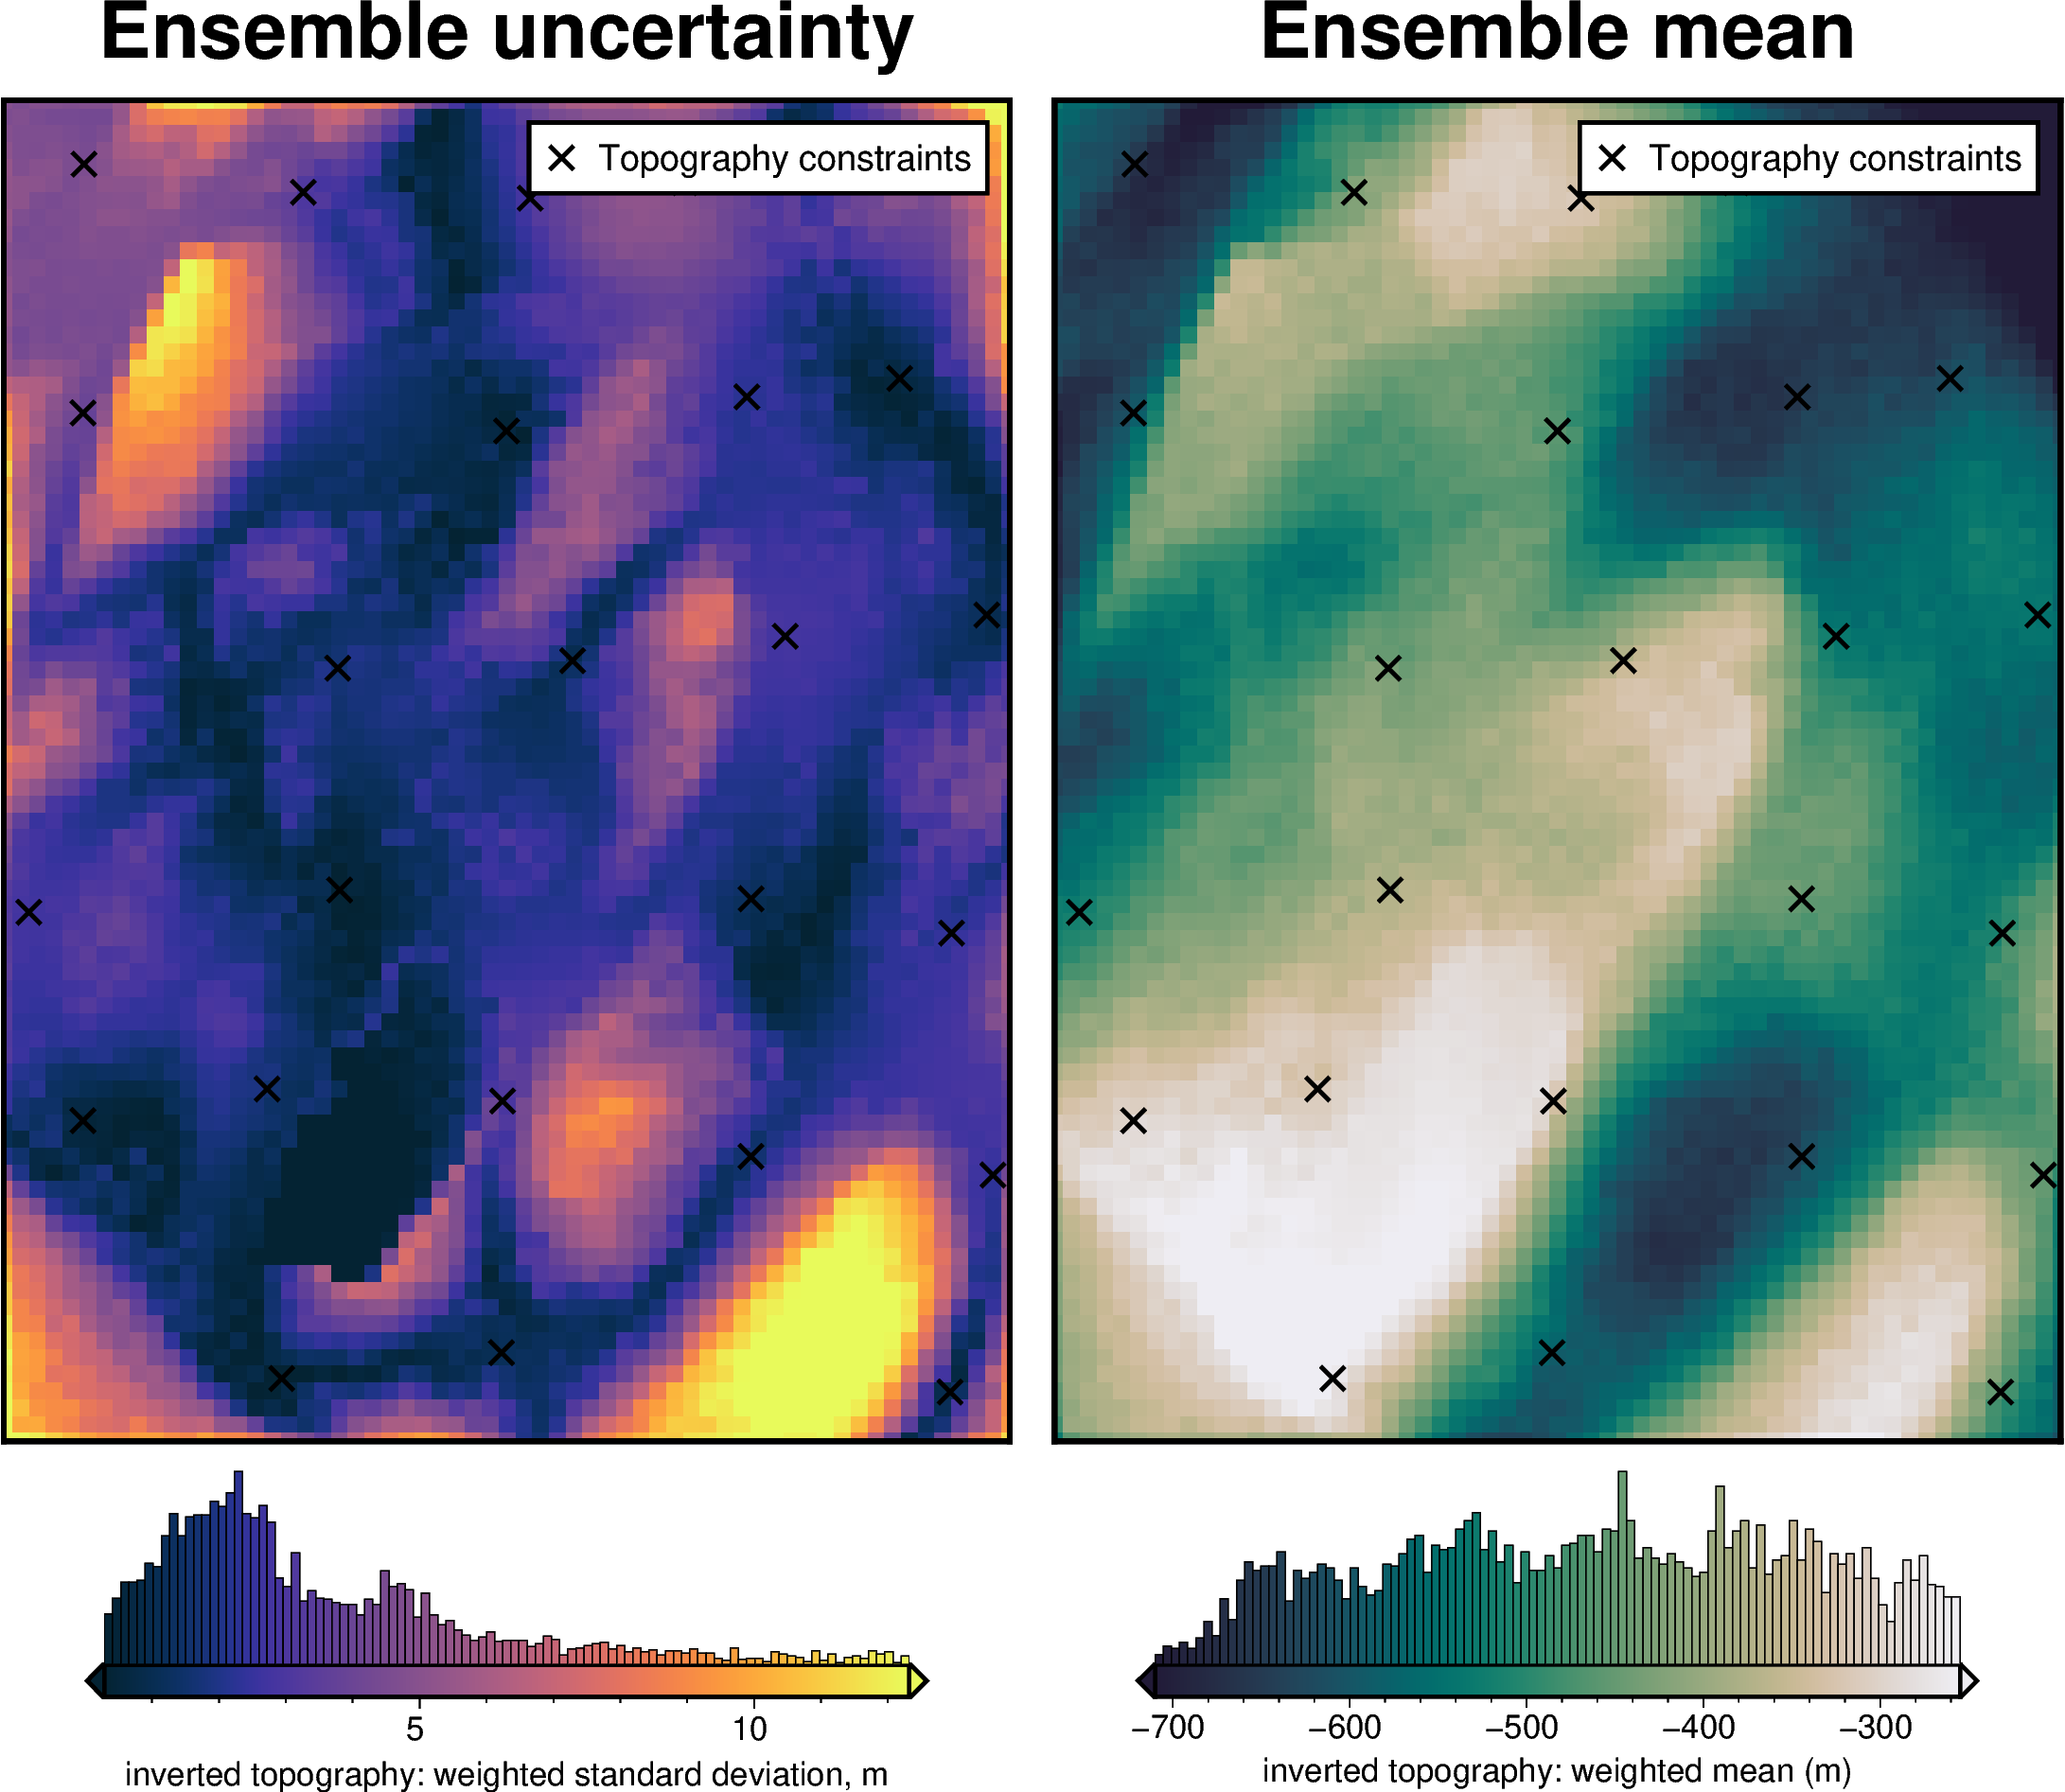

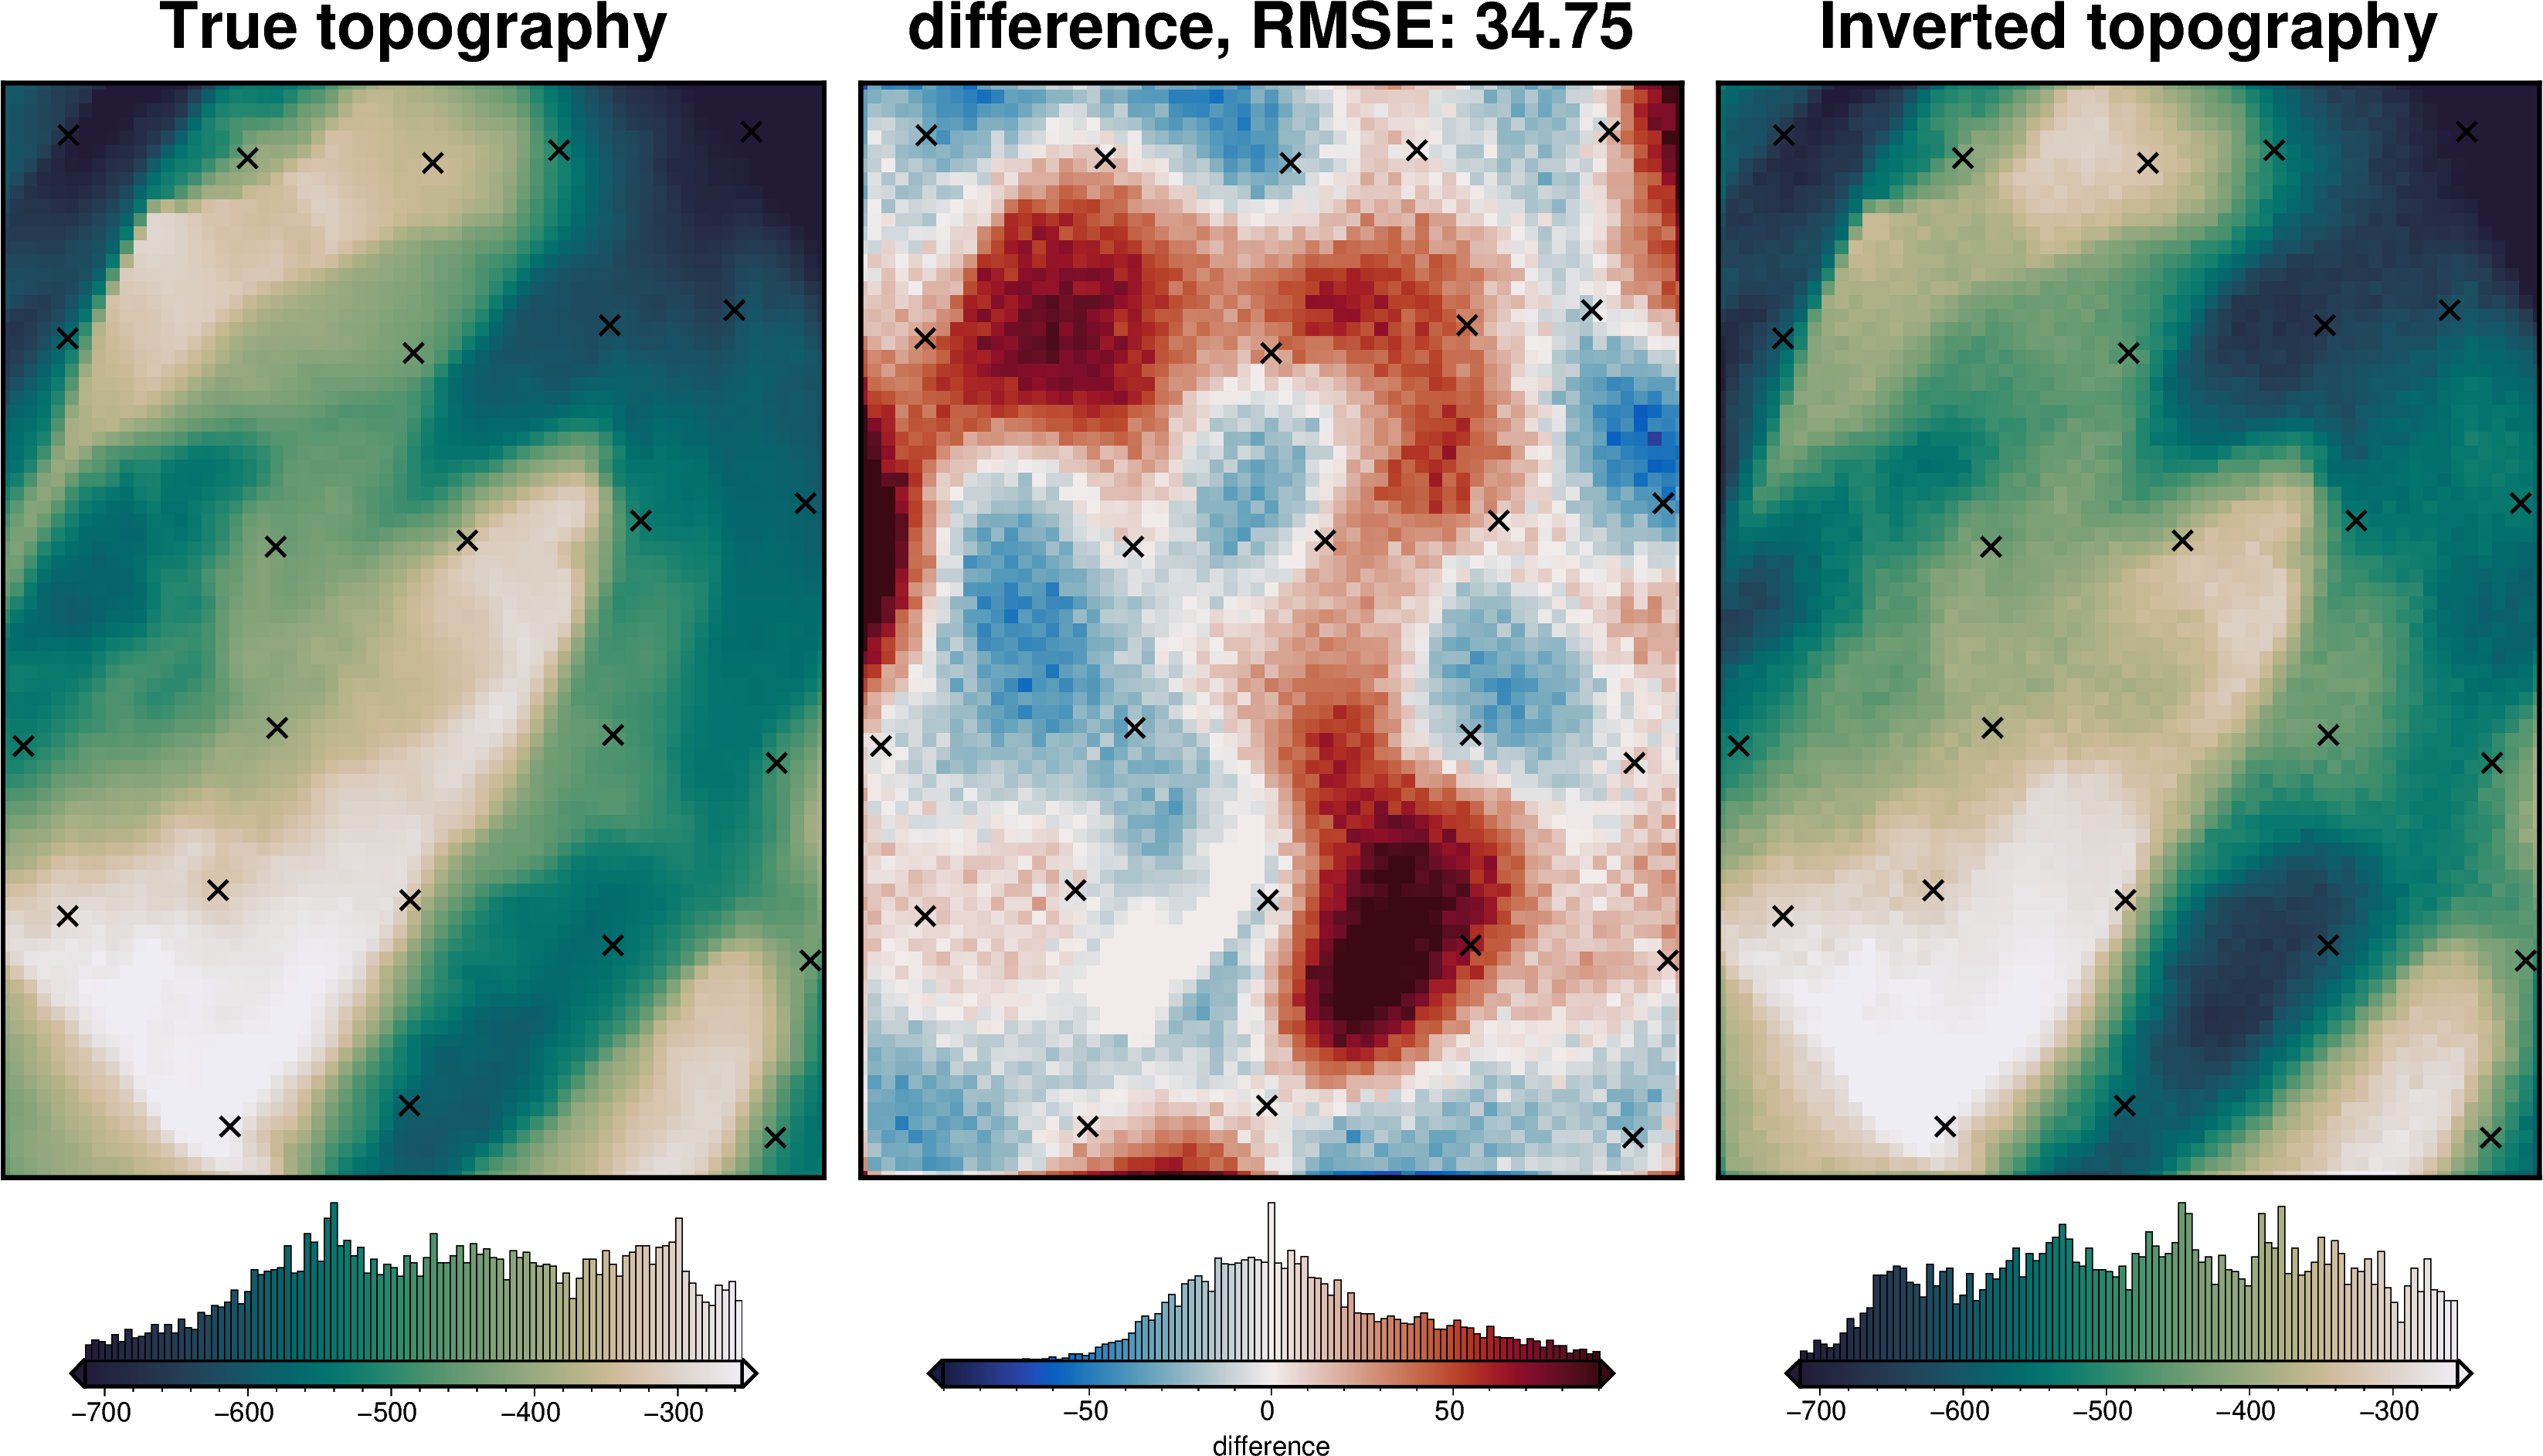

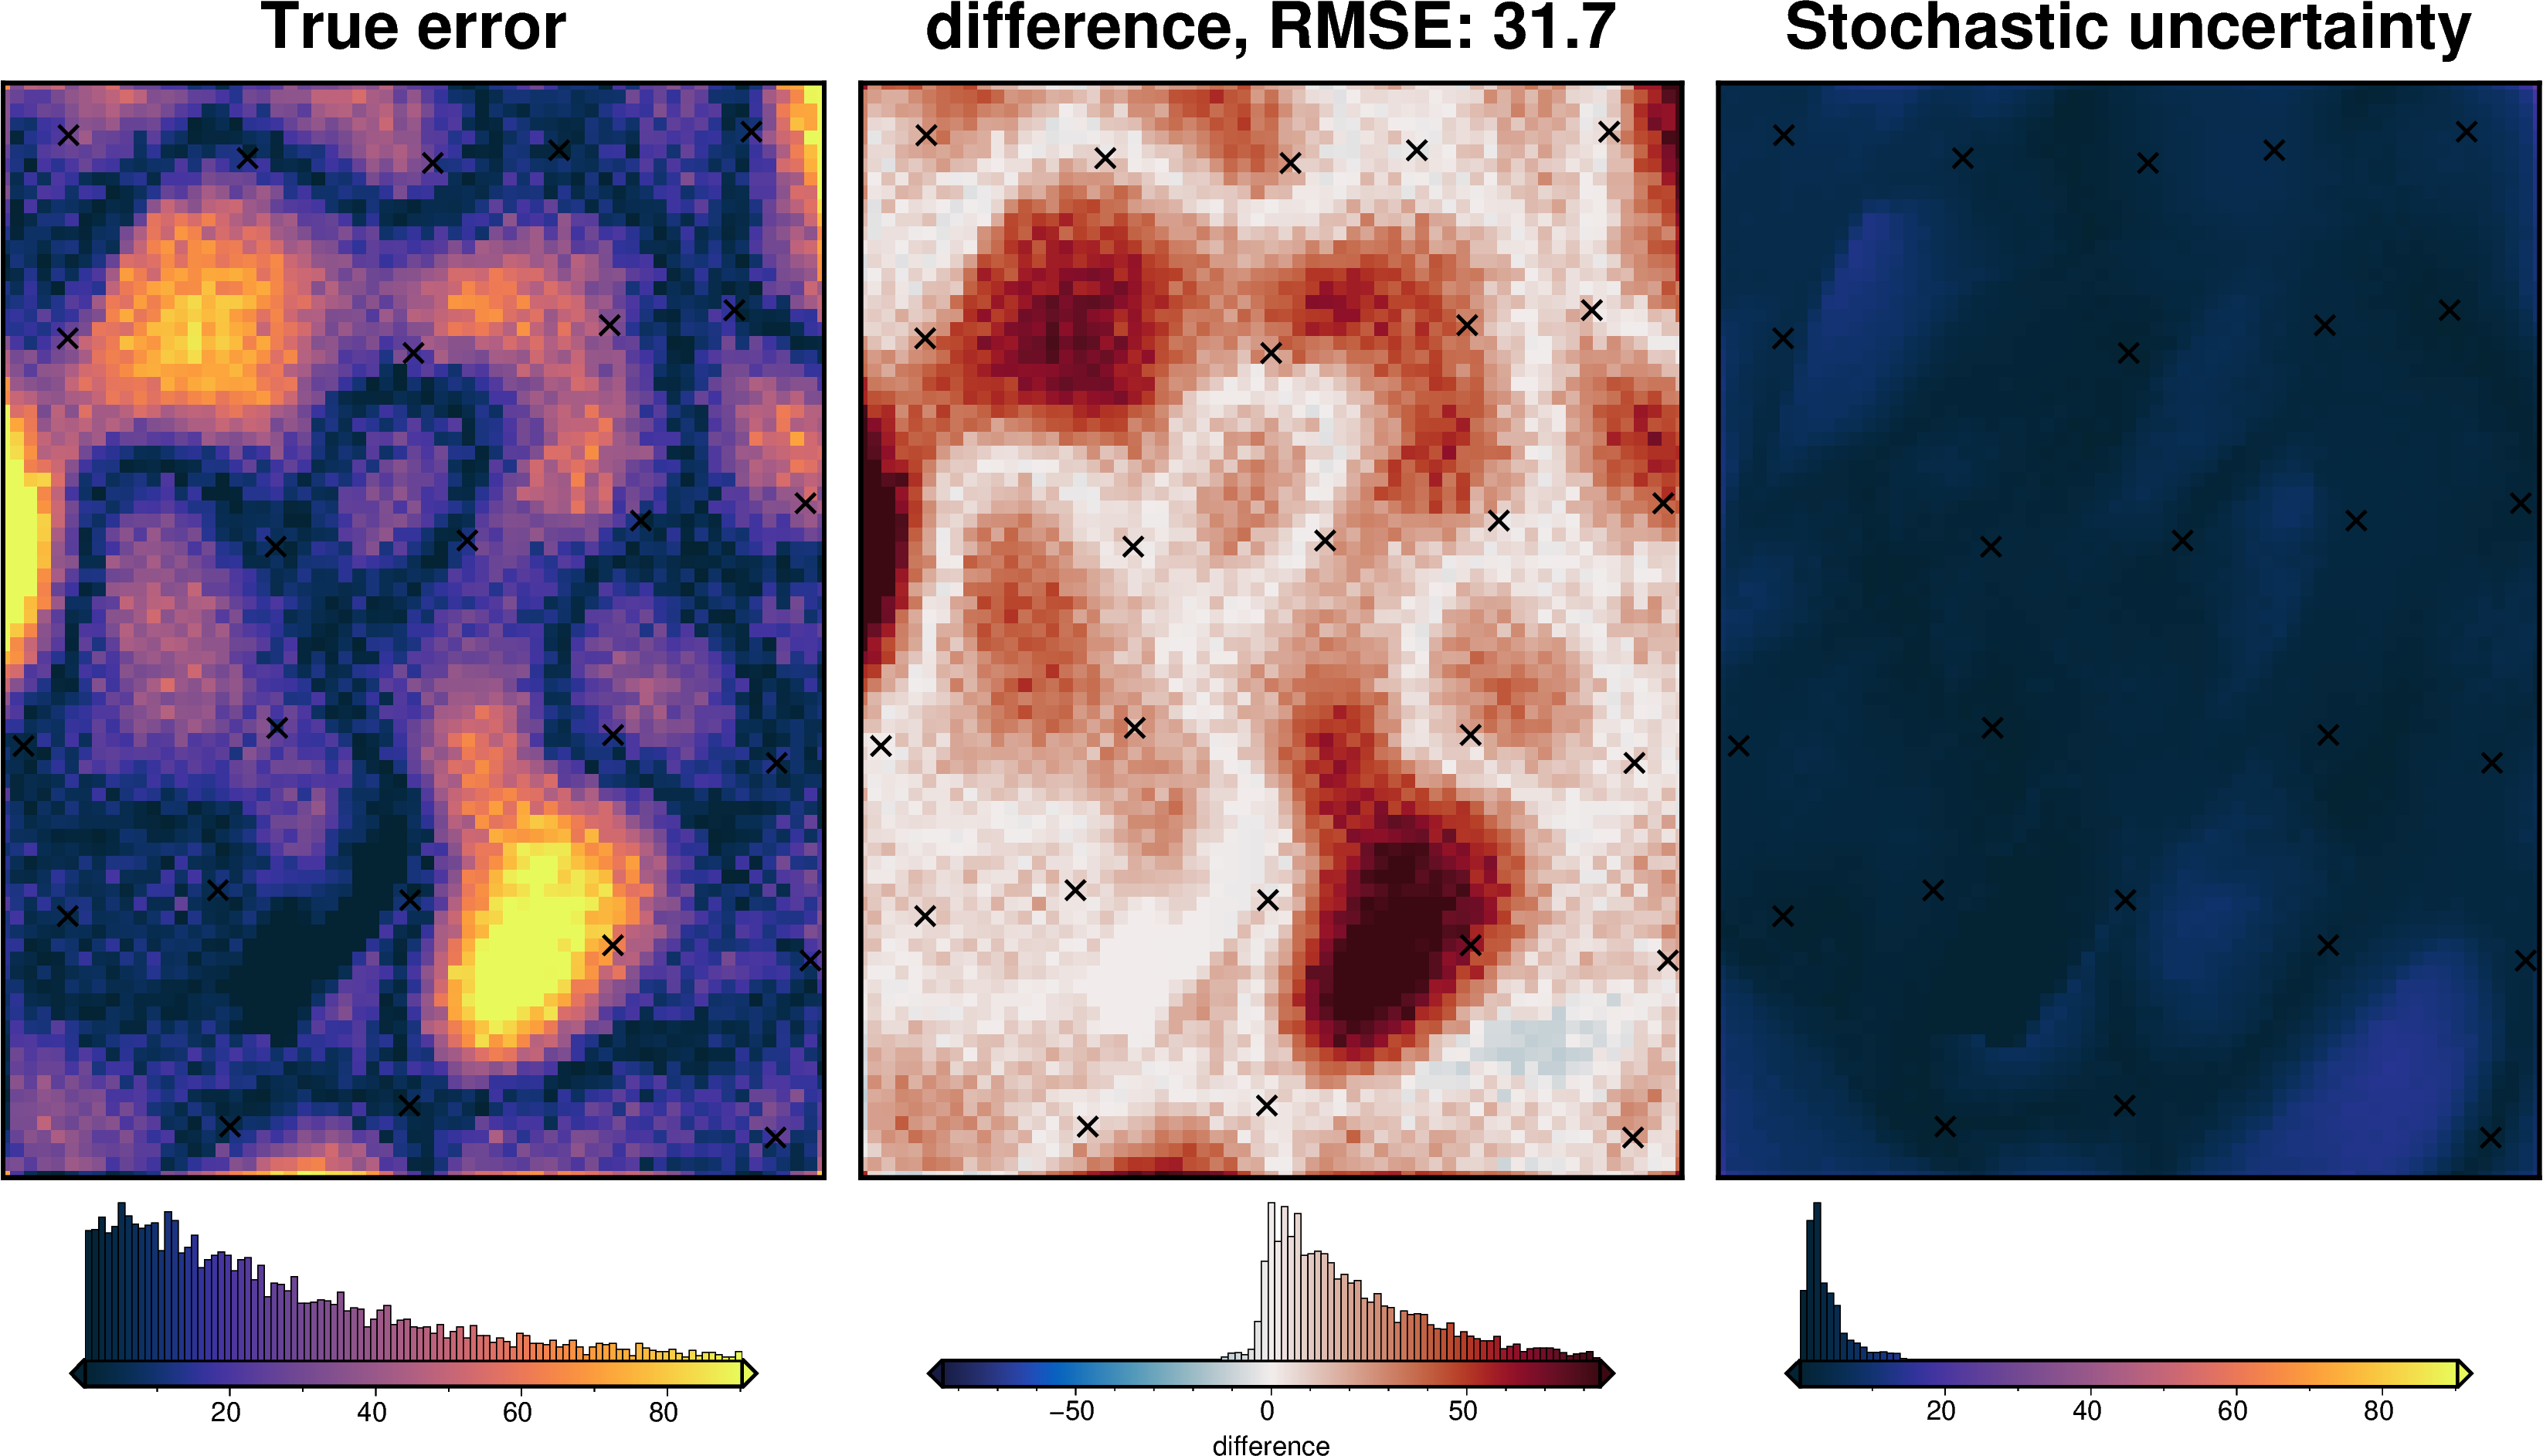

In [54]:
density_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": best_density_contrast,
        "scale": 150,
    },
}

fname = f"{fname_start}_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    parameter_dict=density_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    # create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_density_results)

### Damping component

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.02439049015759641, min: 0.008960999571648233, max: 0.05449316721148762
INFO:invert4geom:No pickle files starting with '../../results/Ross_sea_regional_uncertainty_damping' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: '../../results/Ross_sea_regional_uncertainty_damping'



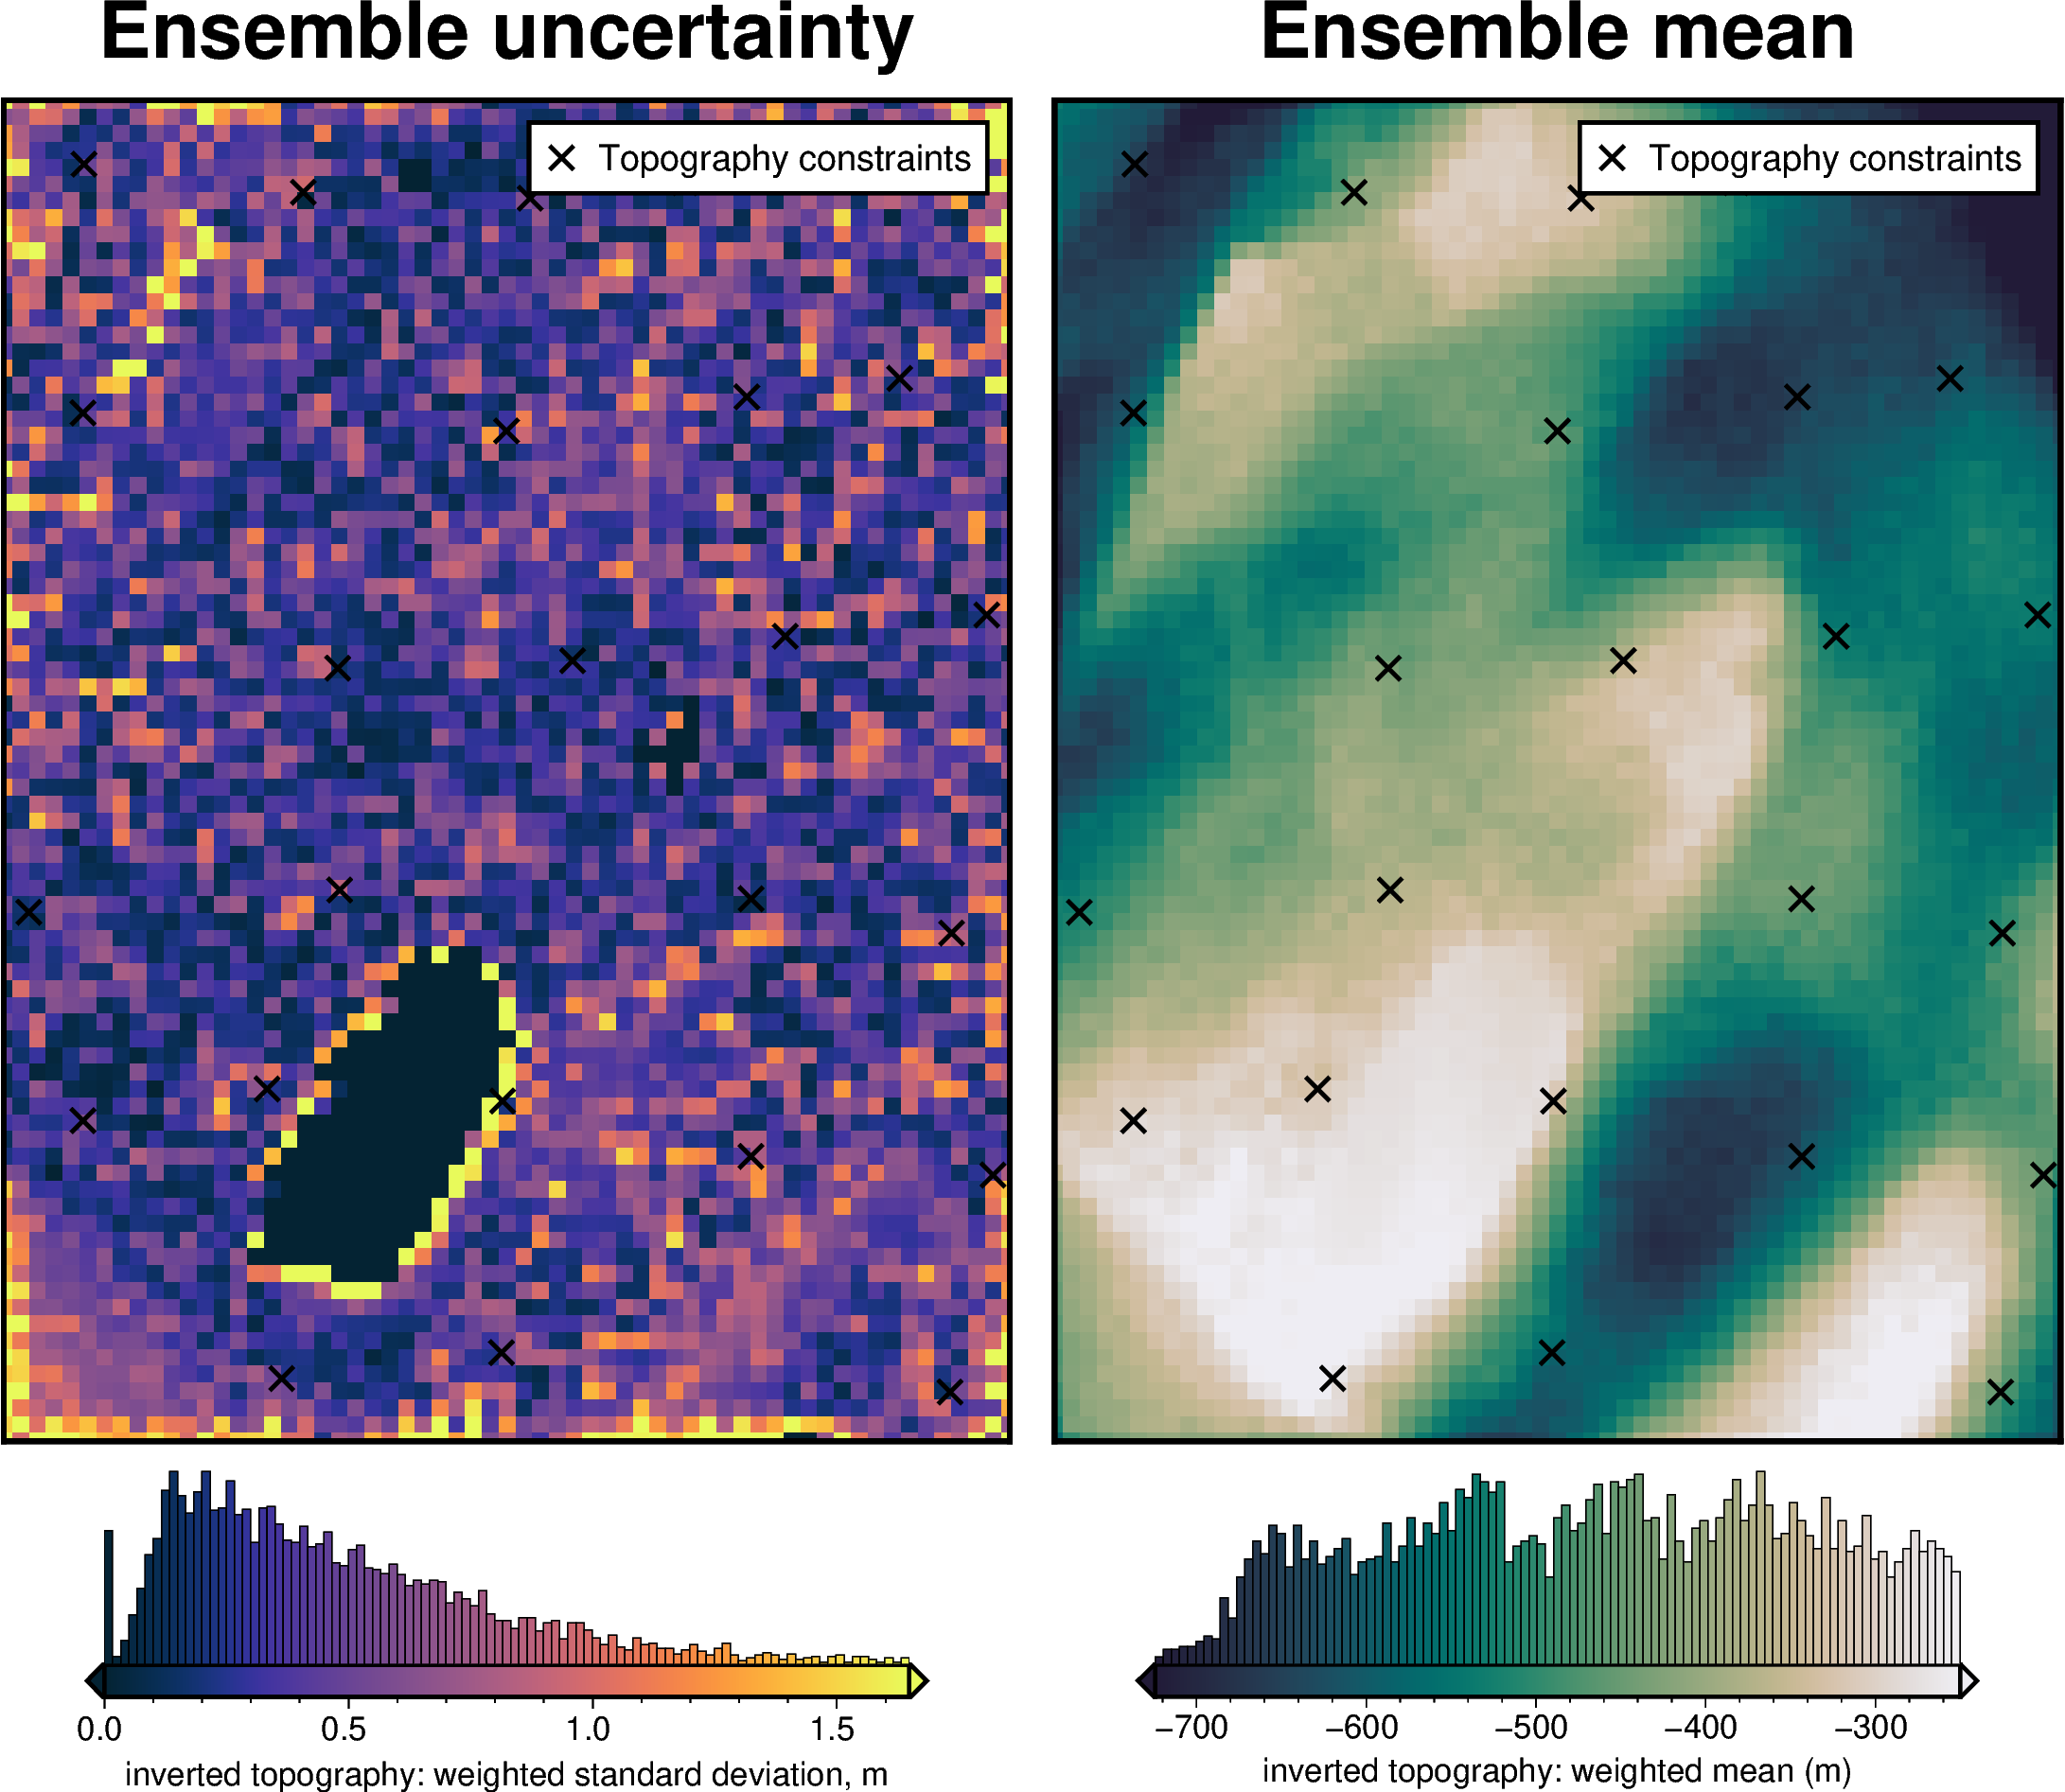

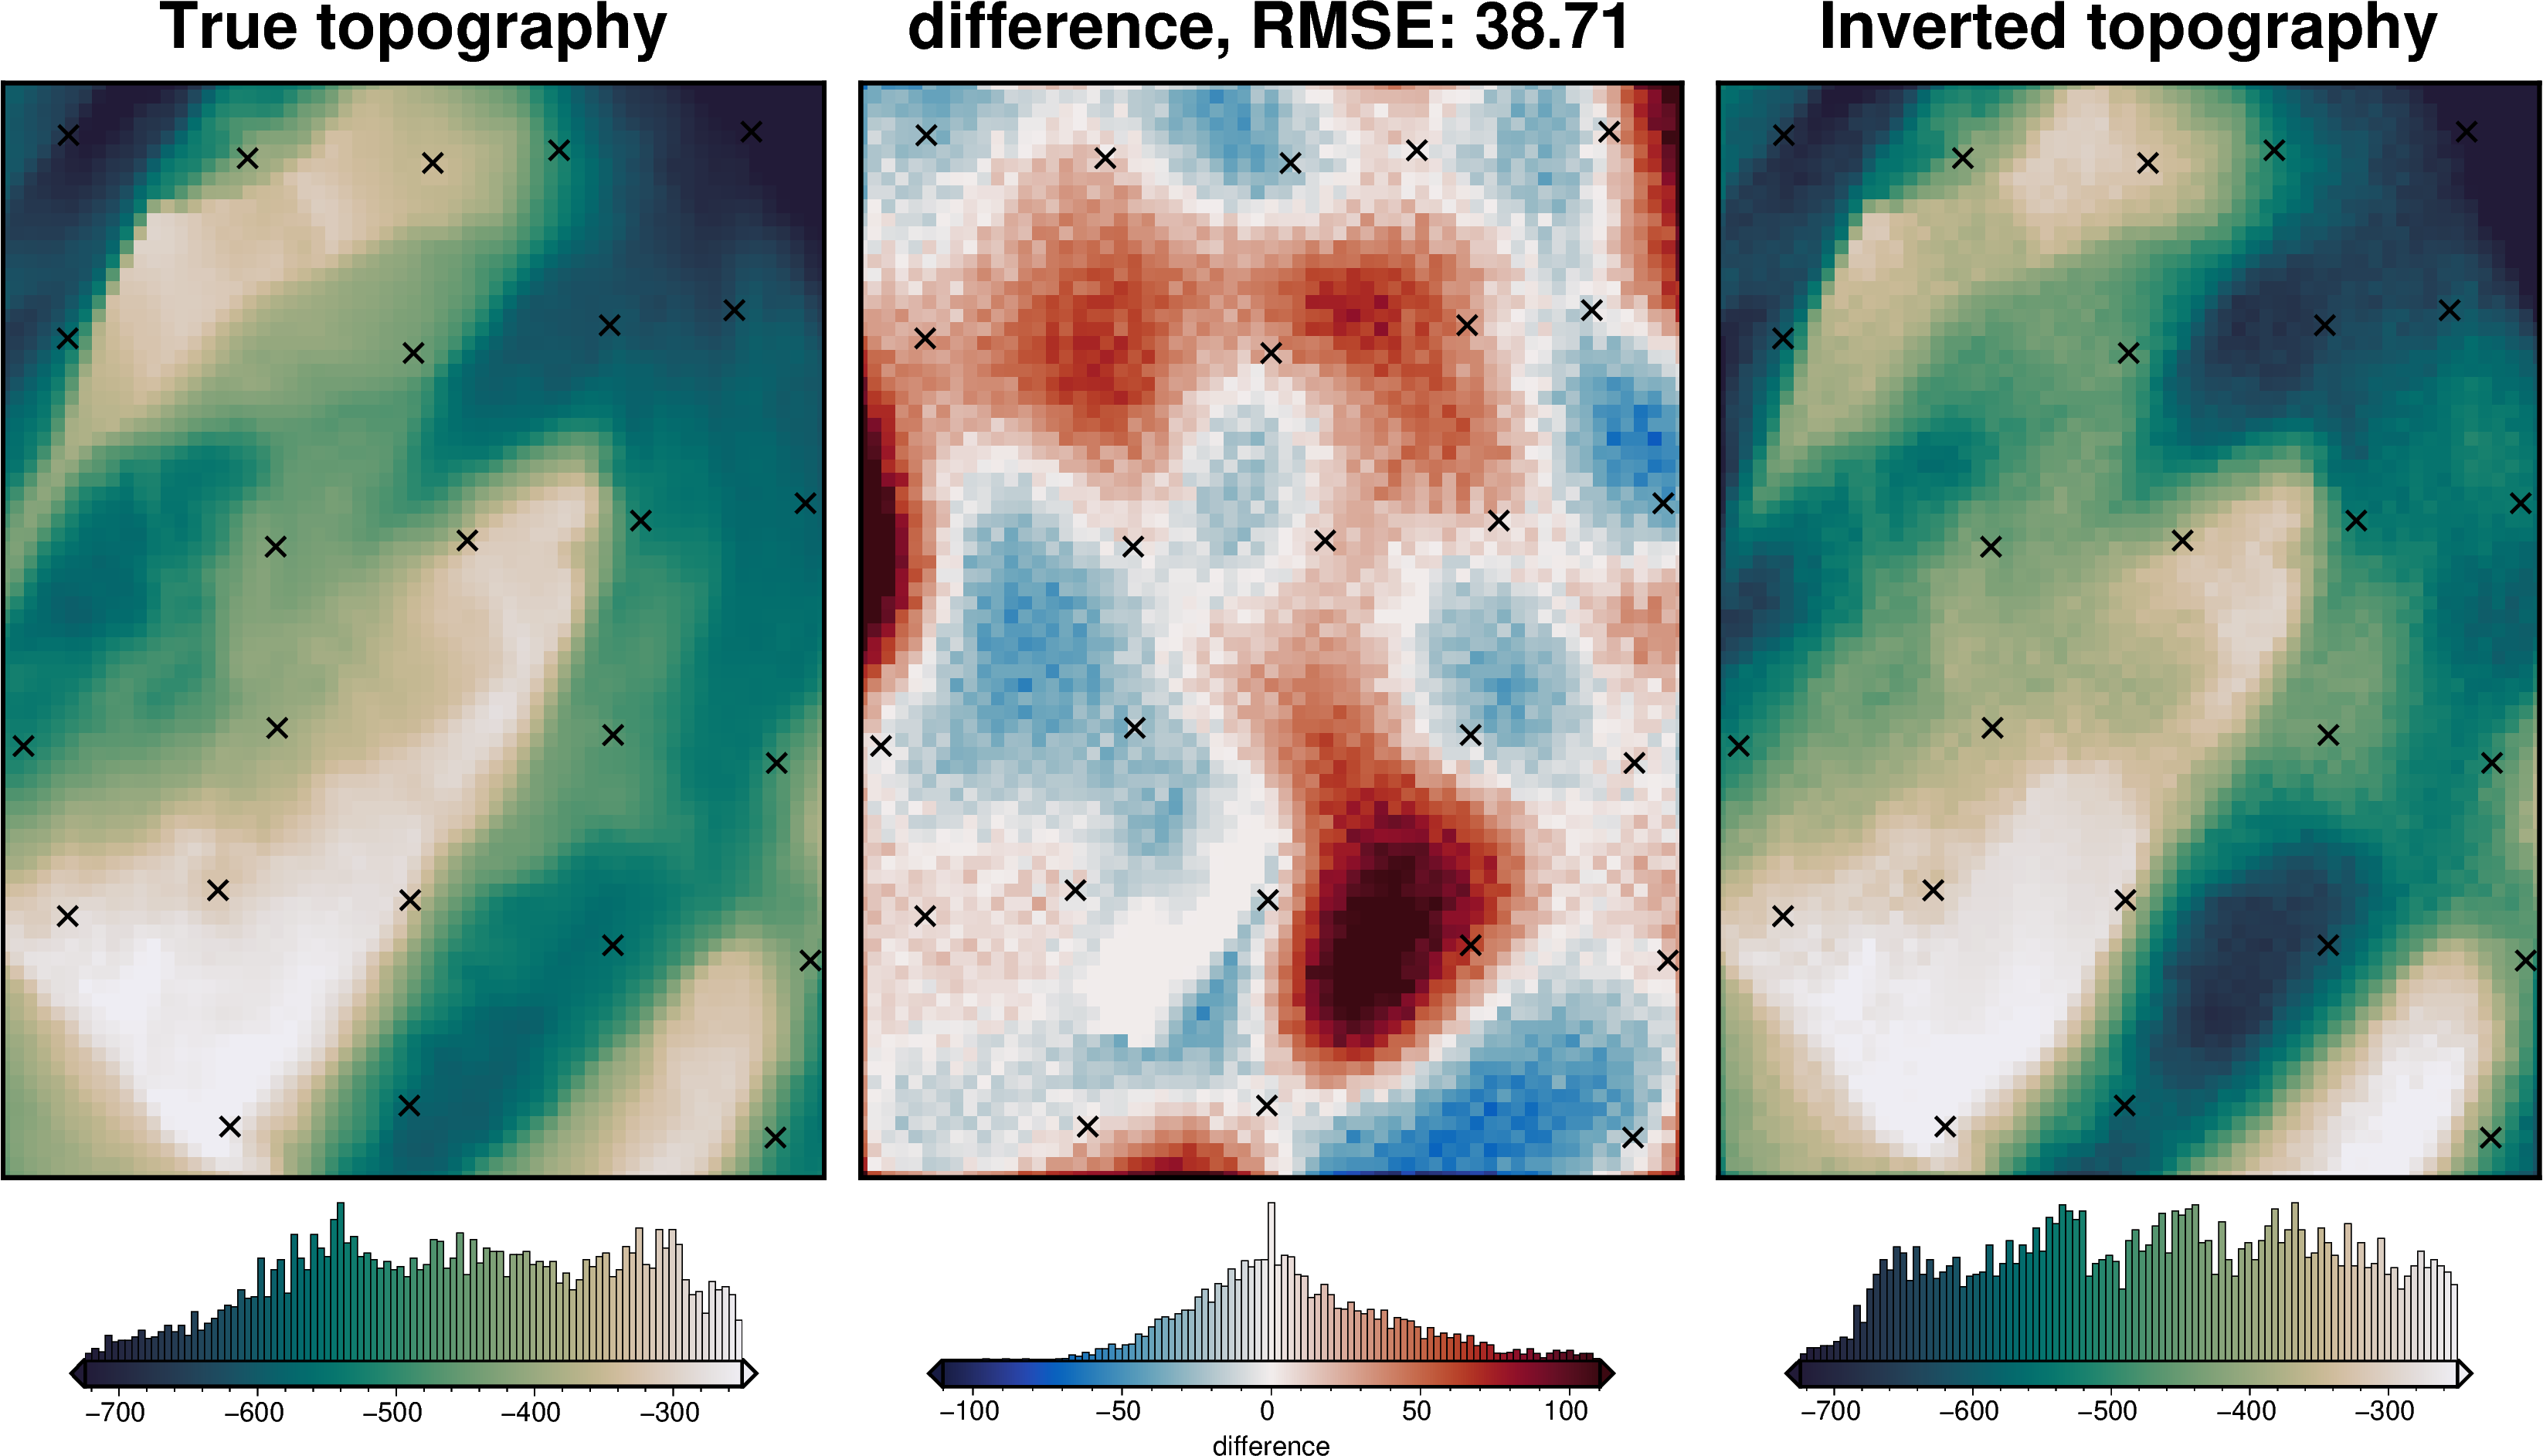

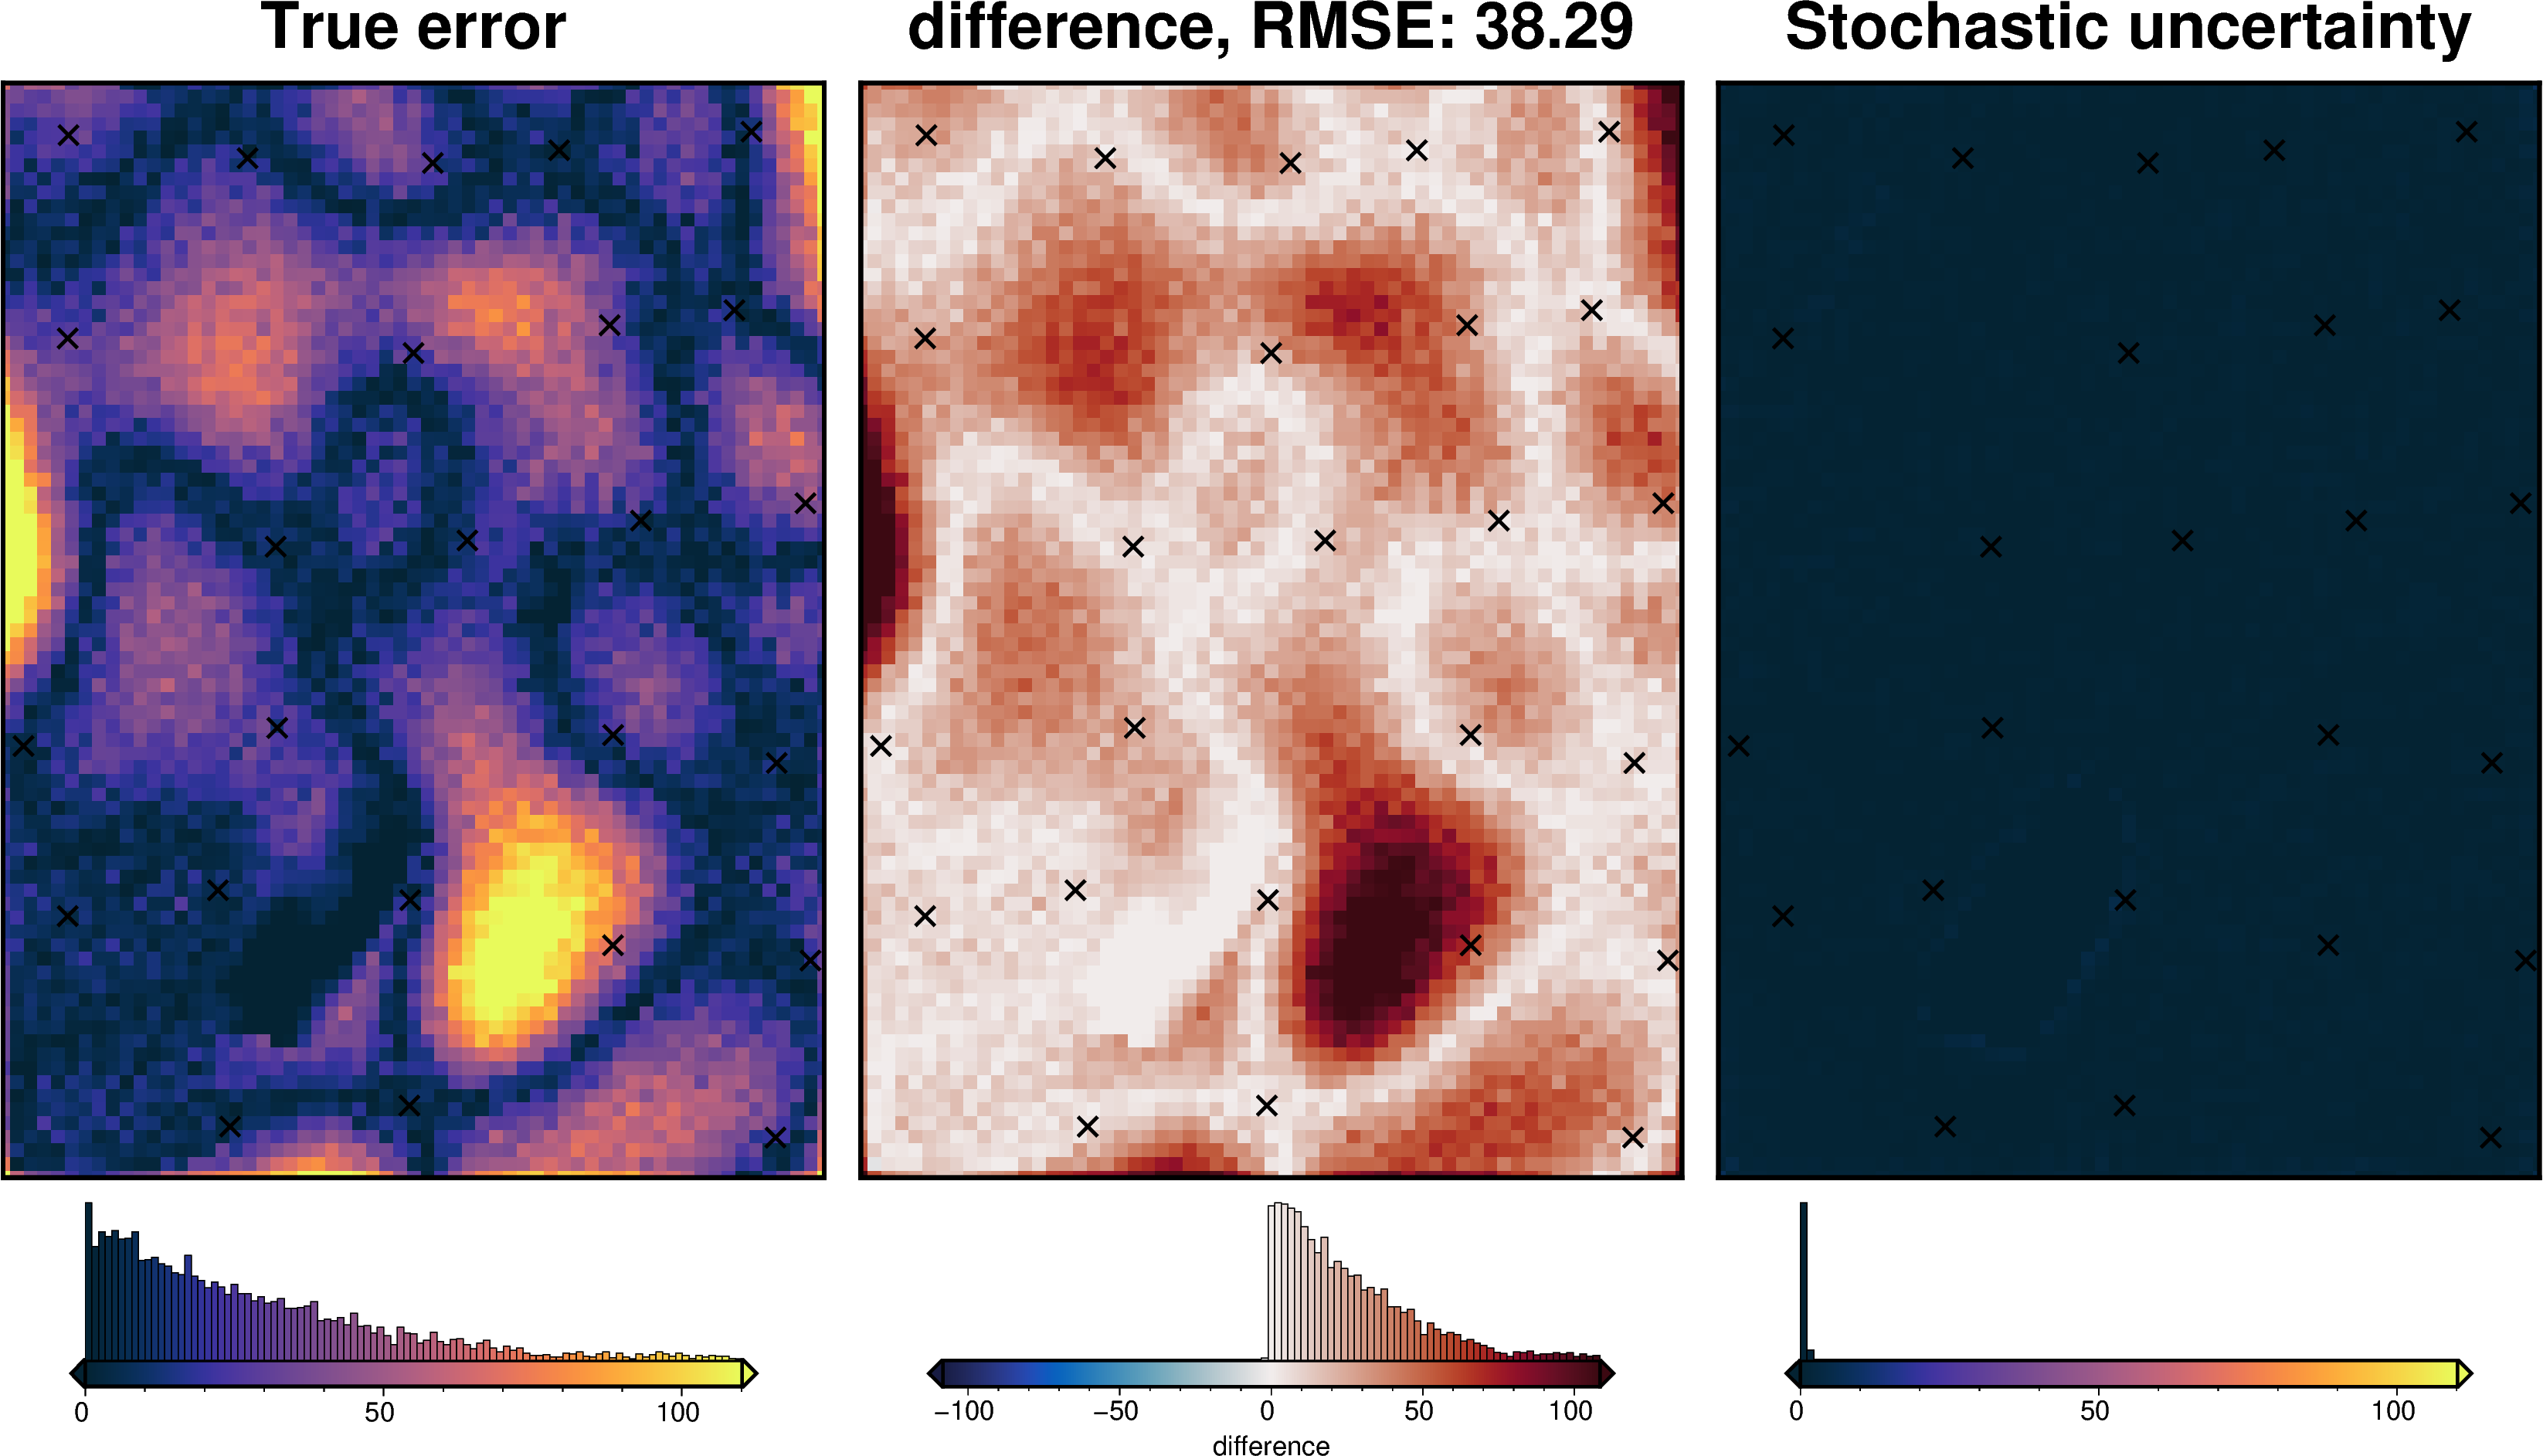

In [55]:
solver_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(best_damping),  # mean base 10 exponent
        "scale": 0.2,
        "log": True,
    },
}

fname = f"{fname_start}_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    parameter_dict=solver_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    # create_starting_topography=True,
    # create_starting_prisms=True,
    # calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_damping_results)

### Gravity component

INFO:invert4geom:No pickle files starting with '../../results/Ross_sea_regional_uncertainty_grav' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: '../../results/Ross_sea_regional_uncertainty_grav'



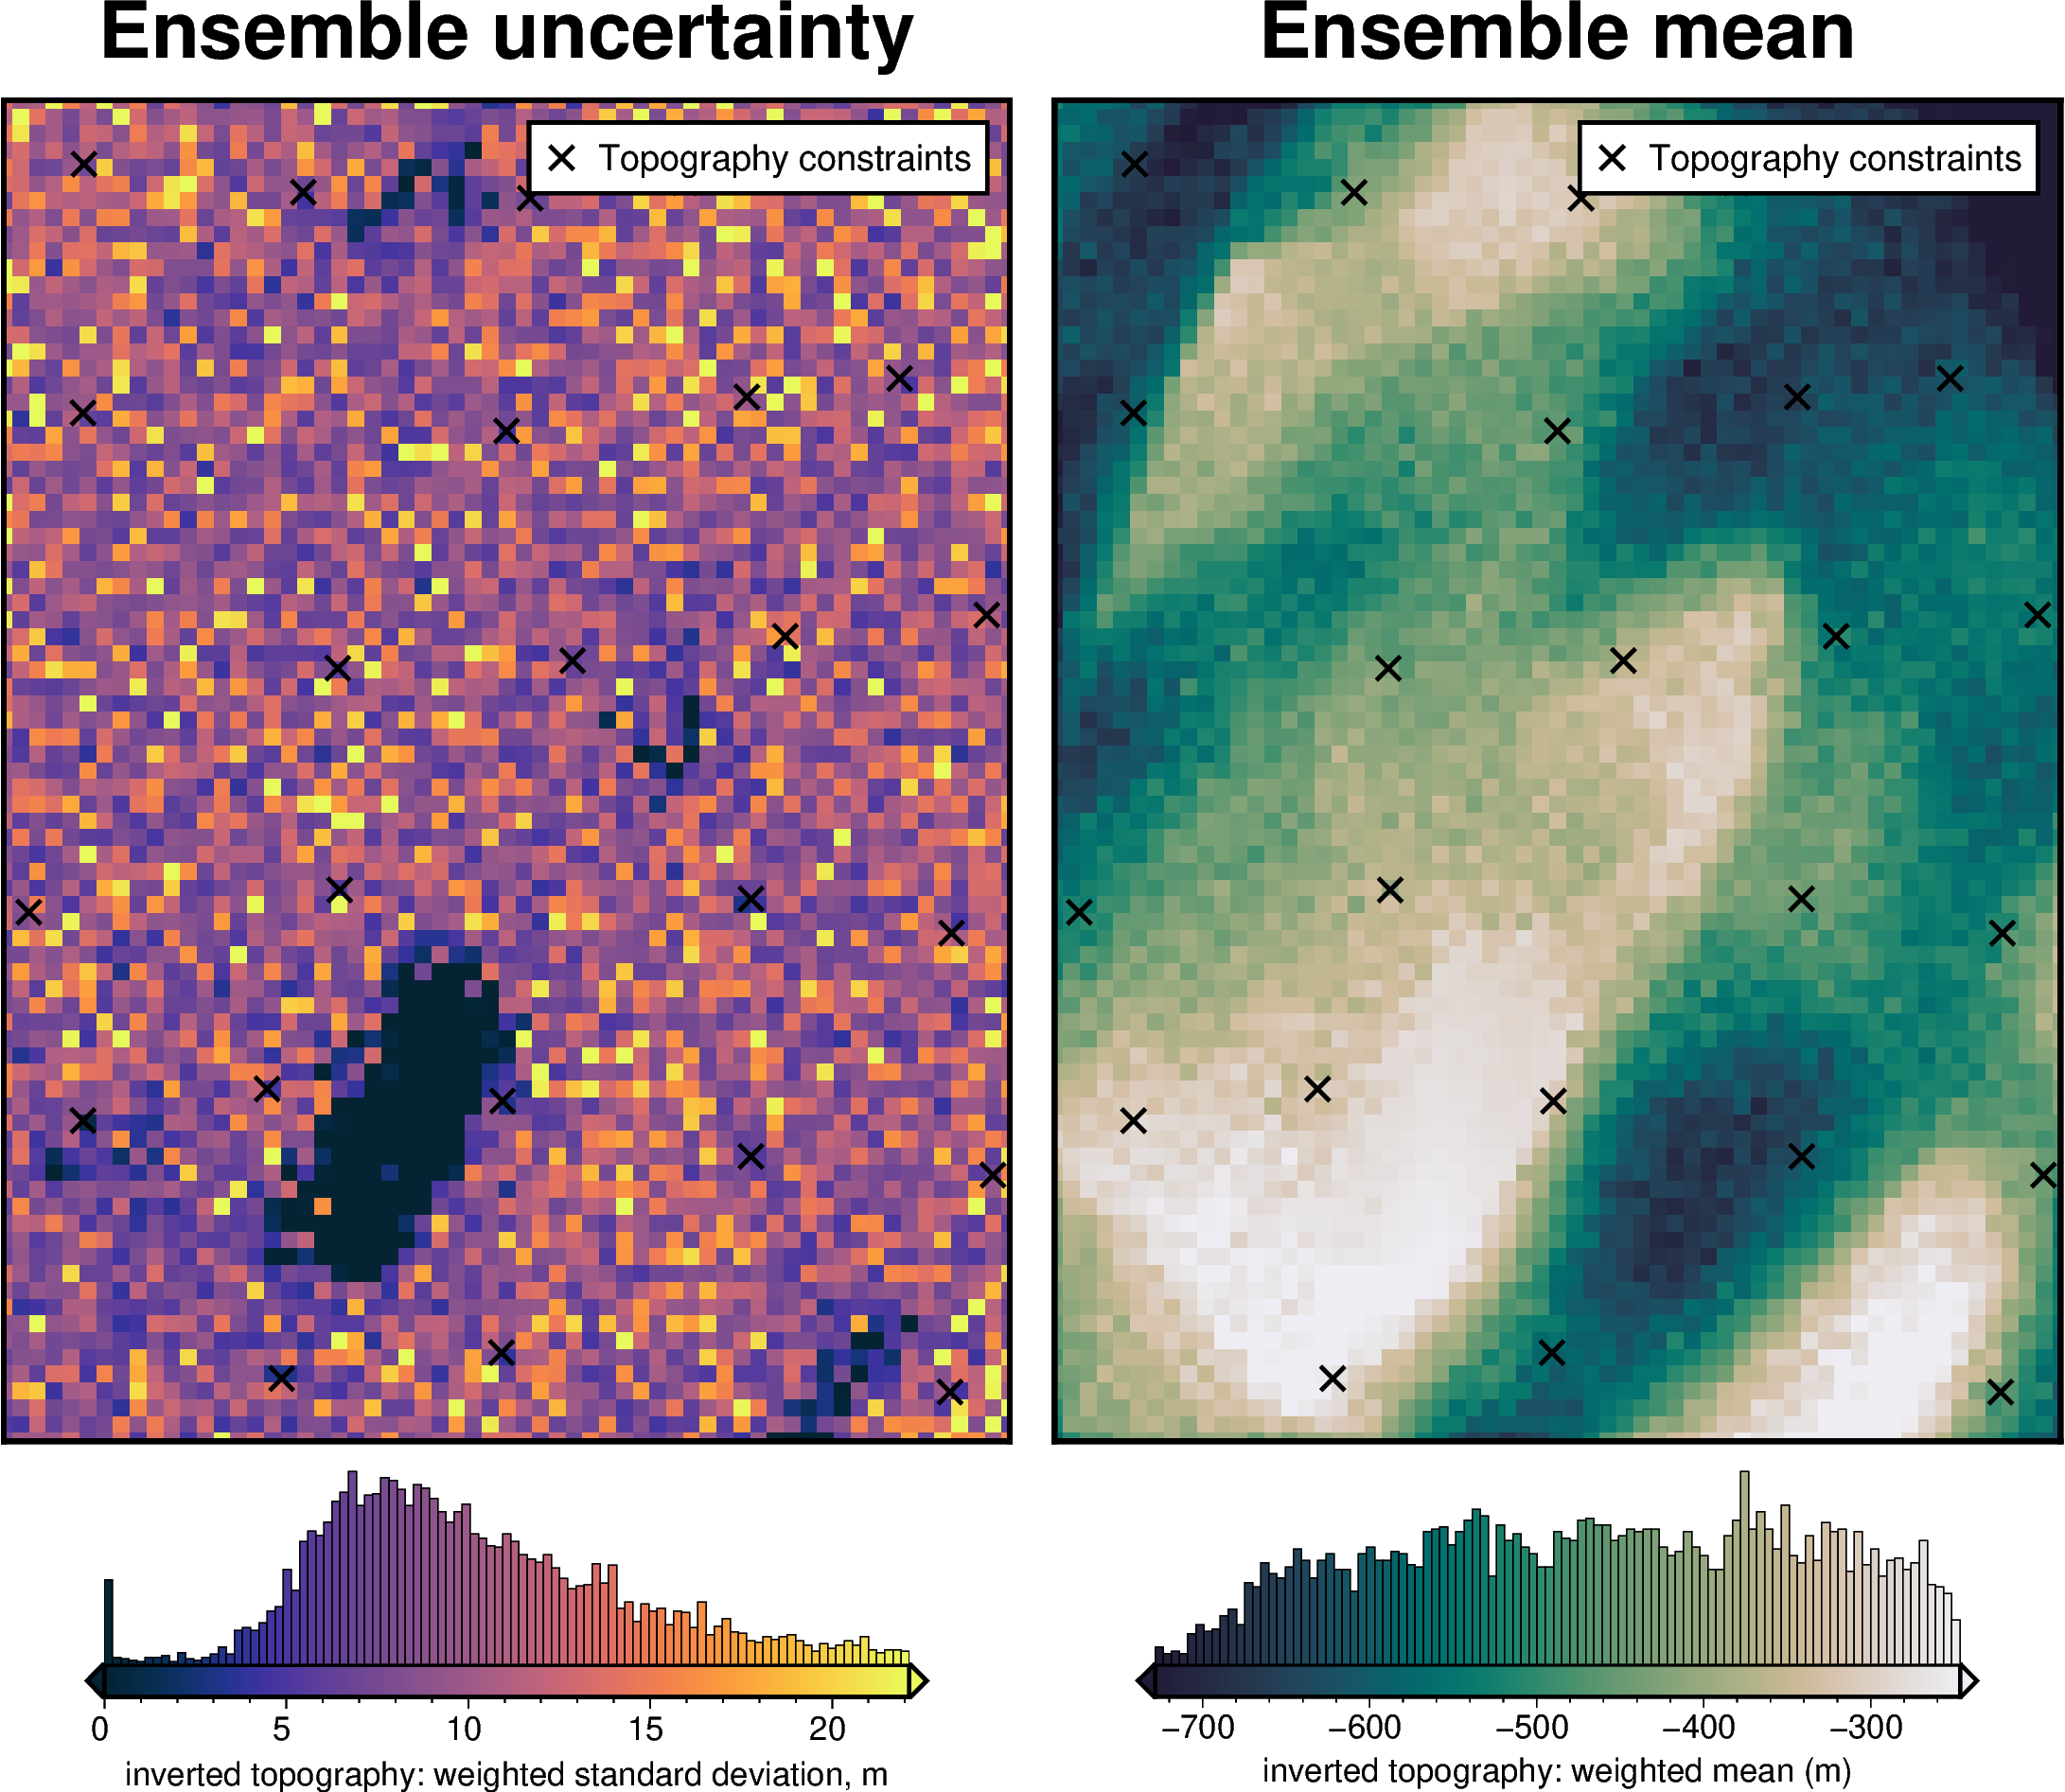

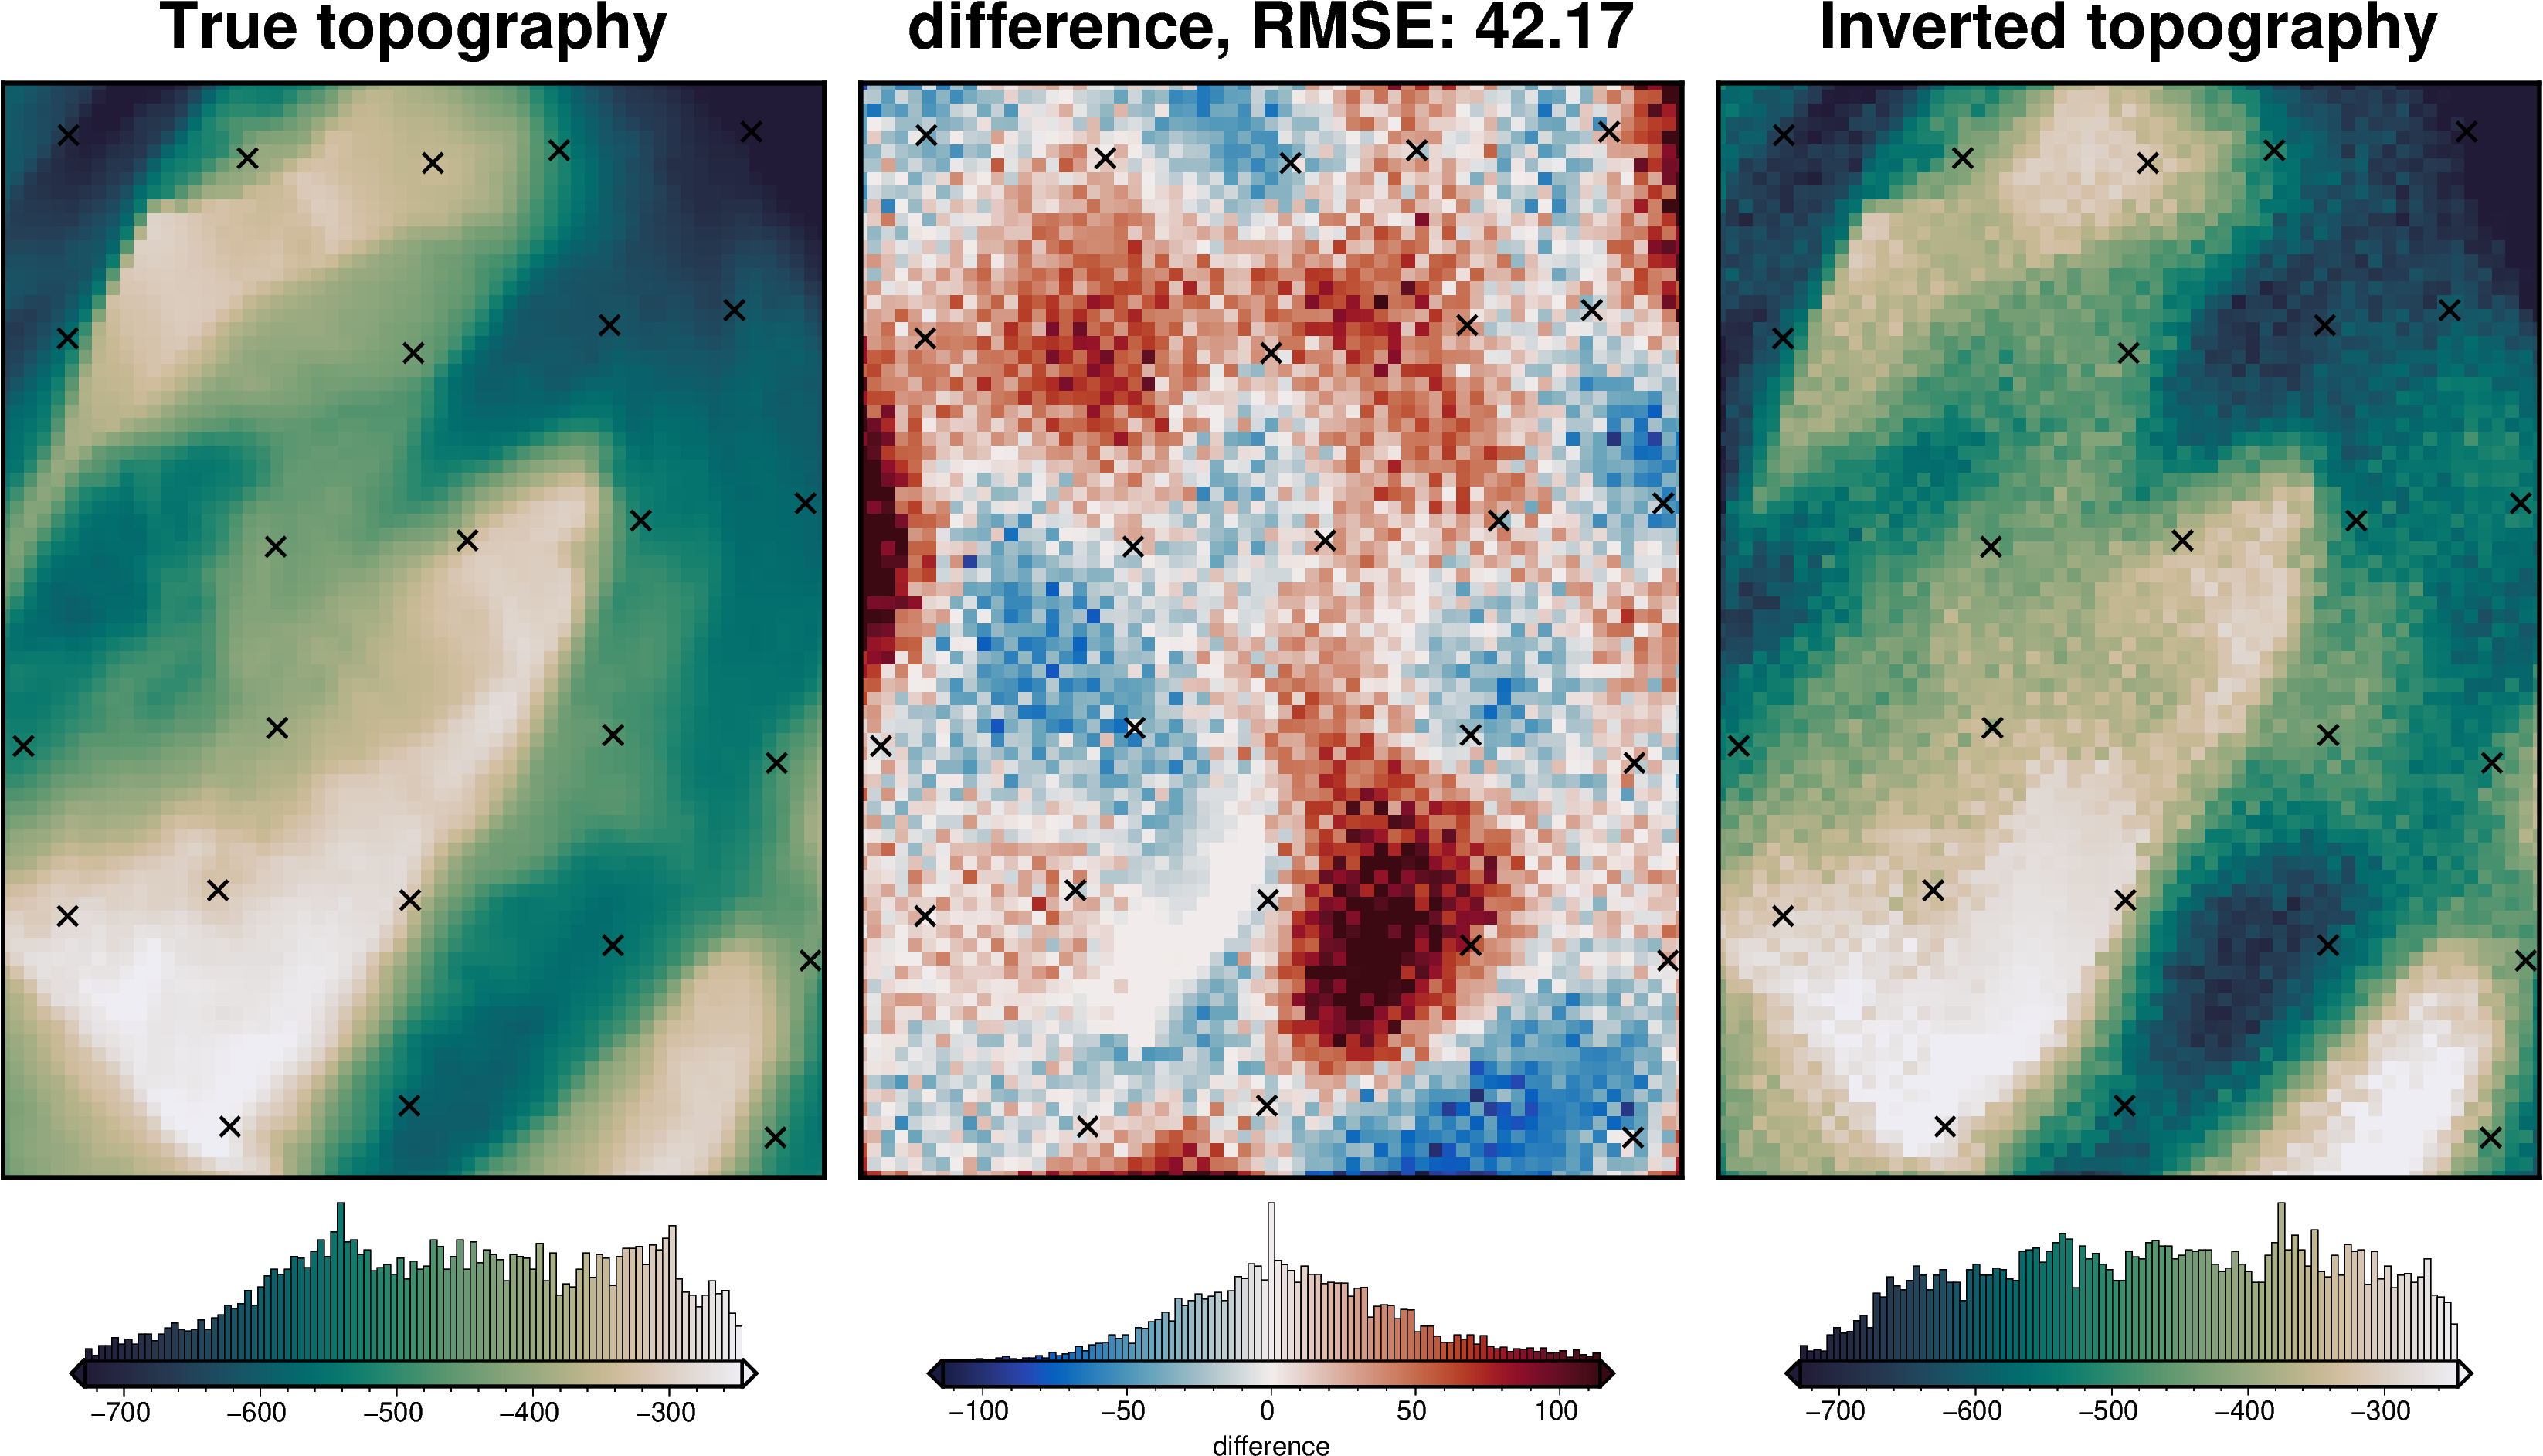

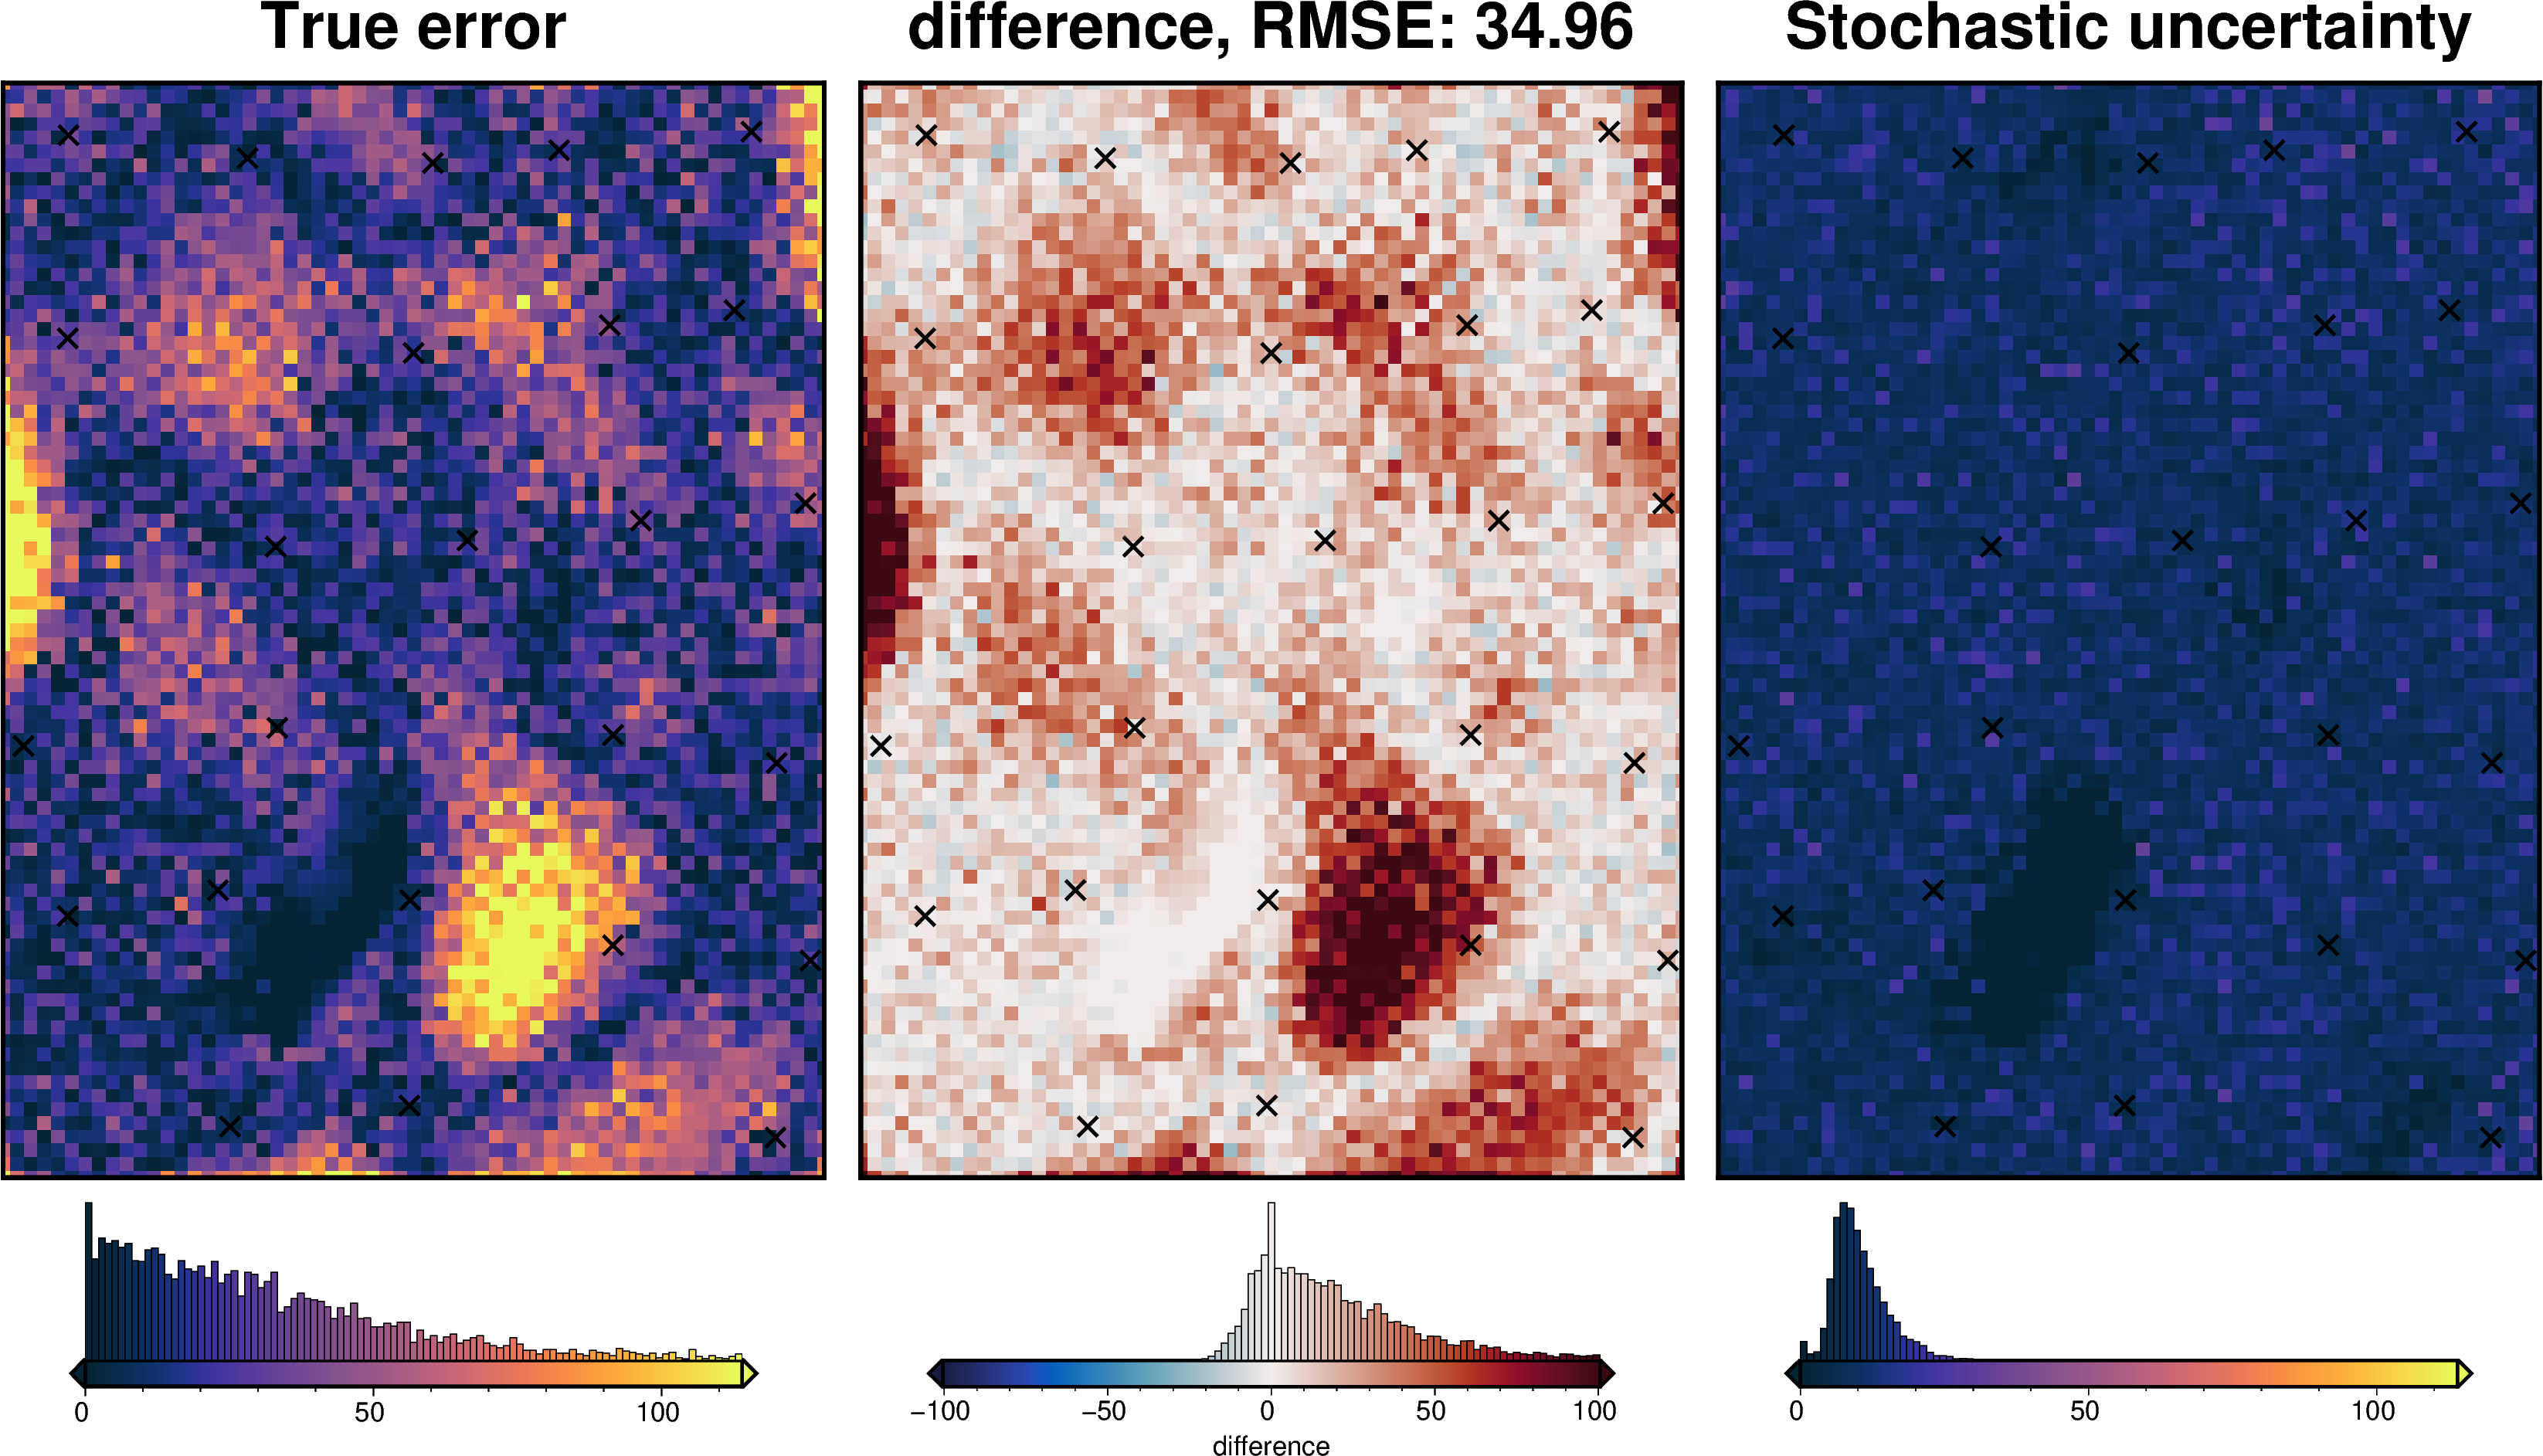

In [56]:
fname = f"{fname_start}_grav"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_grav_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    # choose what to sample
    sample_gravity=True,
    # sample_constraints=True,
    # parameter_dict=parameter_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    # create_starting_topography=True,
    # create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_grav_results)

### Constraints component

INFO:invert4geom:No pickle files starting with '../../results/Ross_sea_regional_uncertainty_constraints' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: '../../results/Ross_sea_regional_uncertainty_constraints'



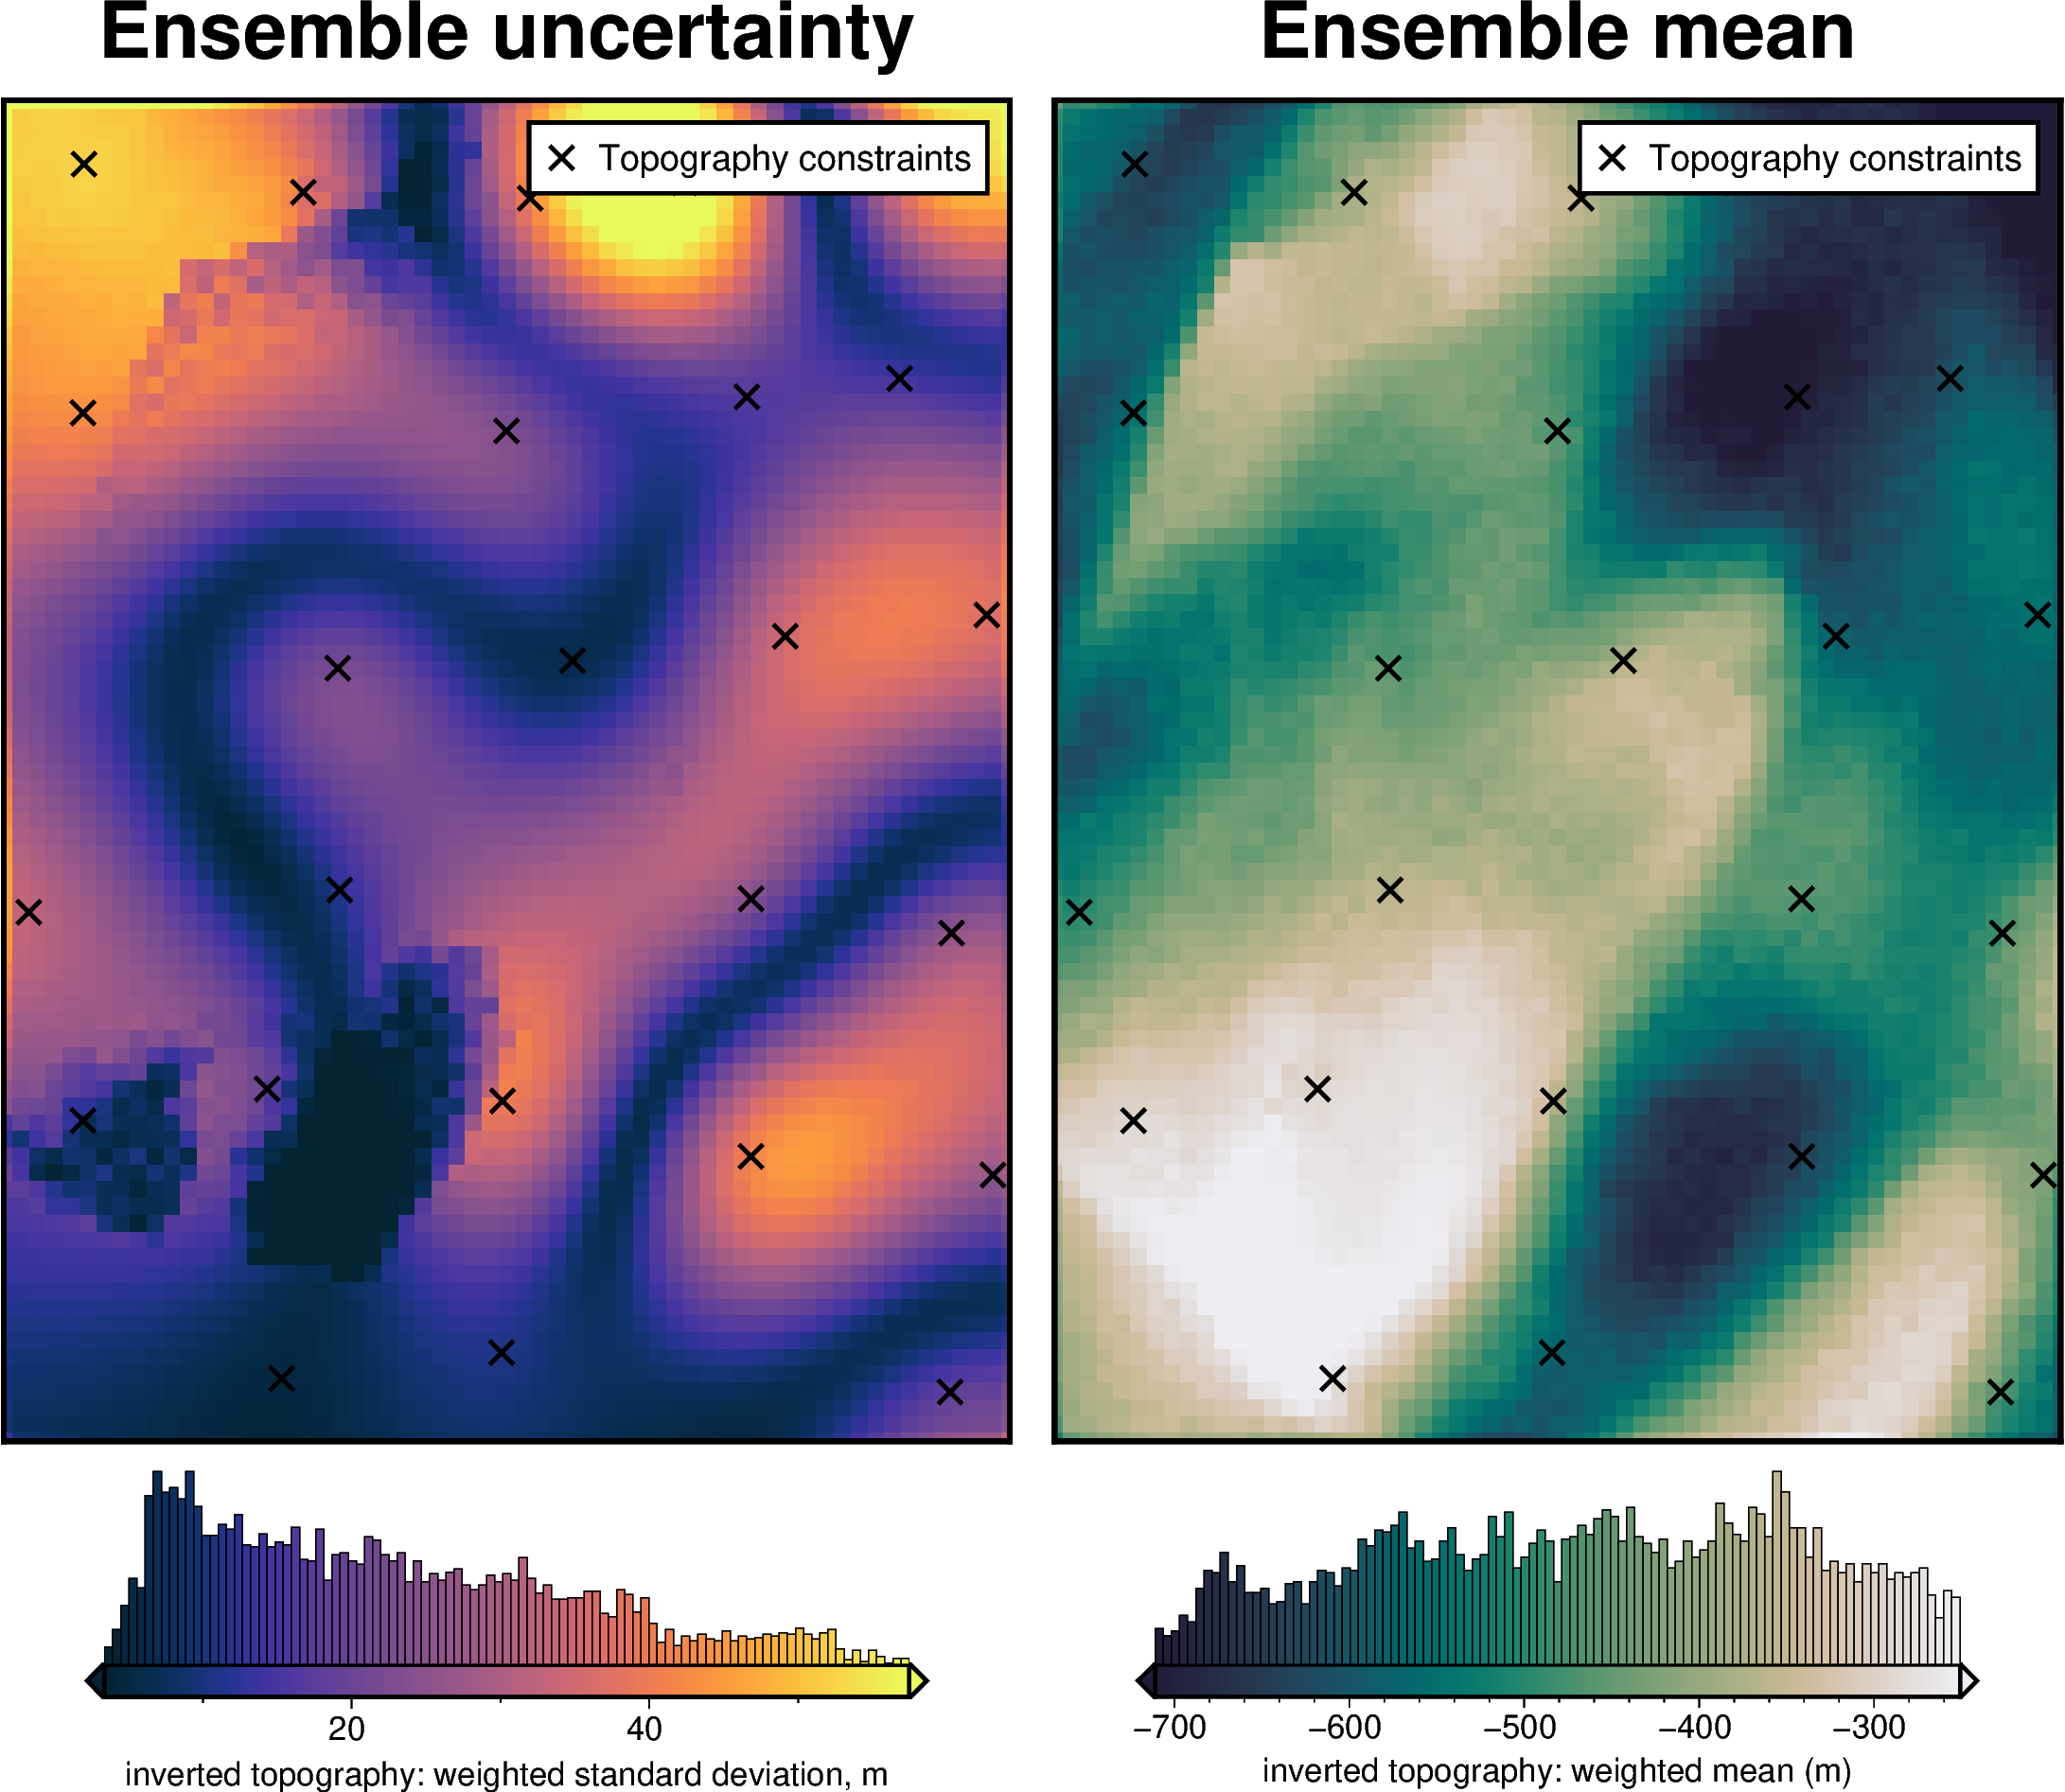

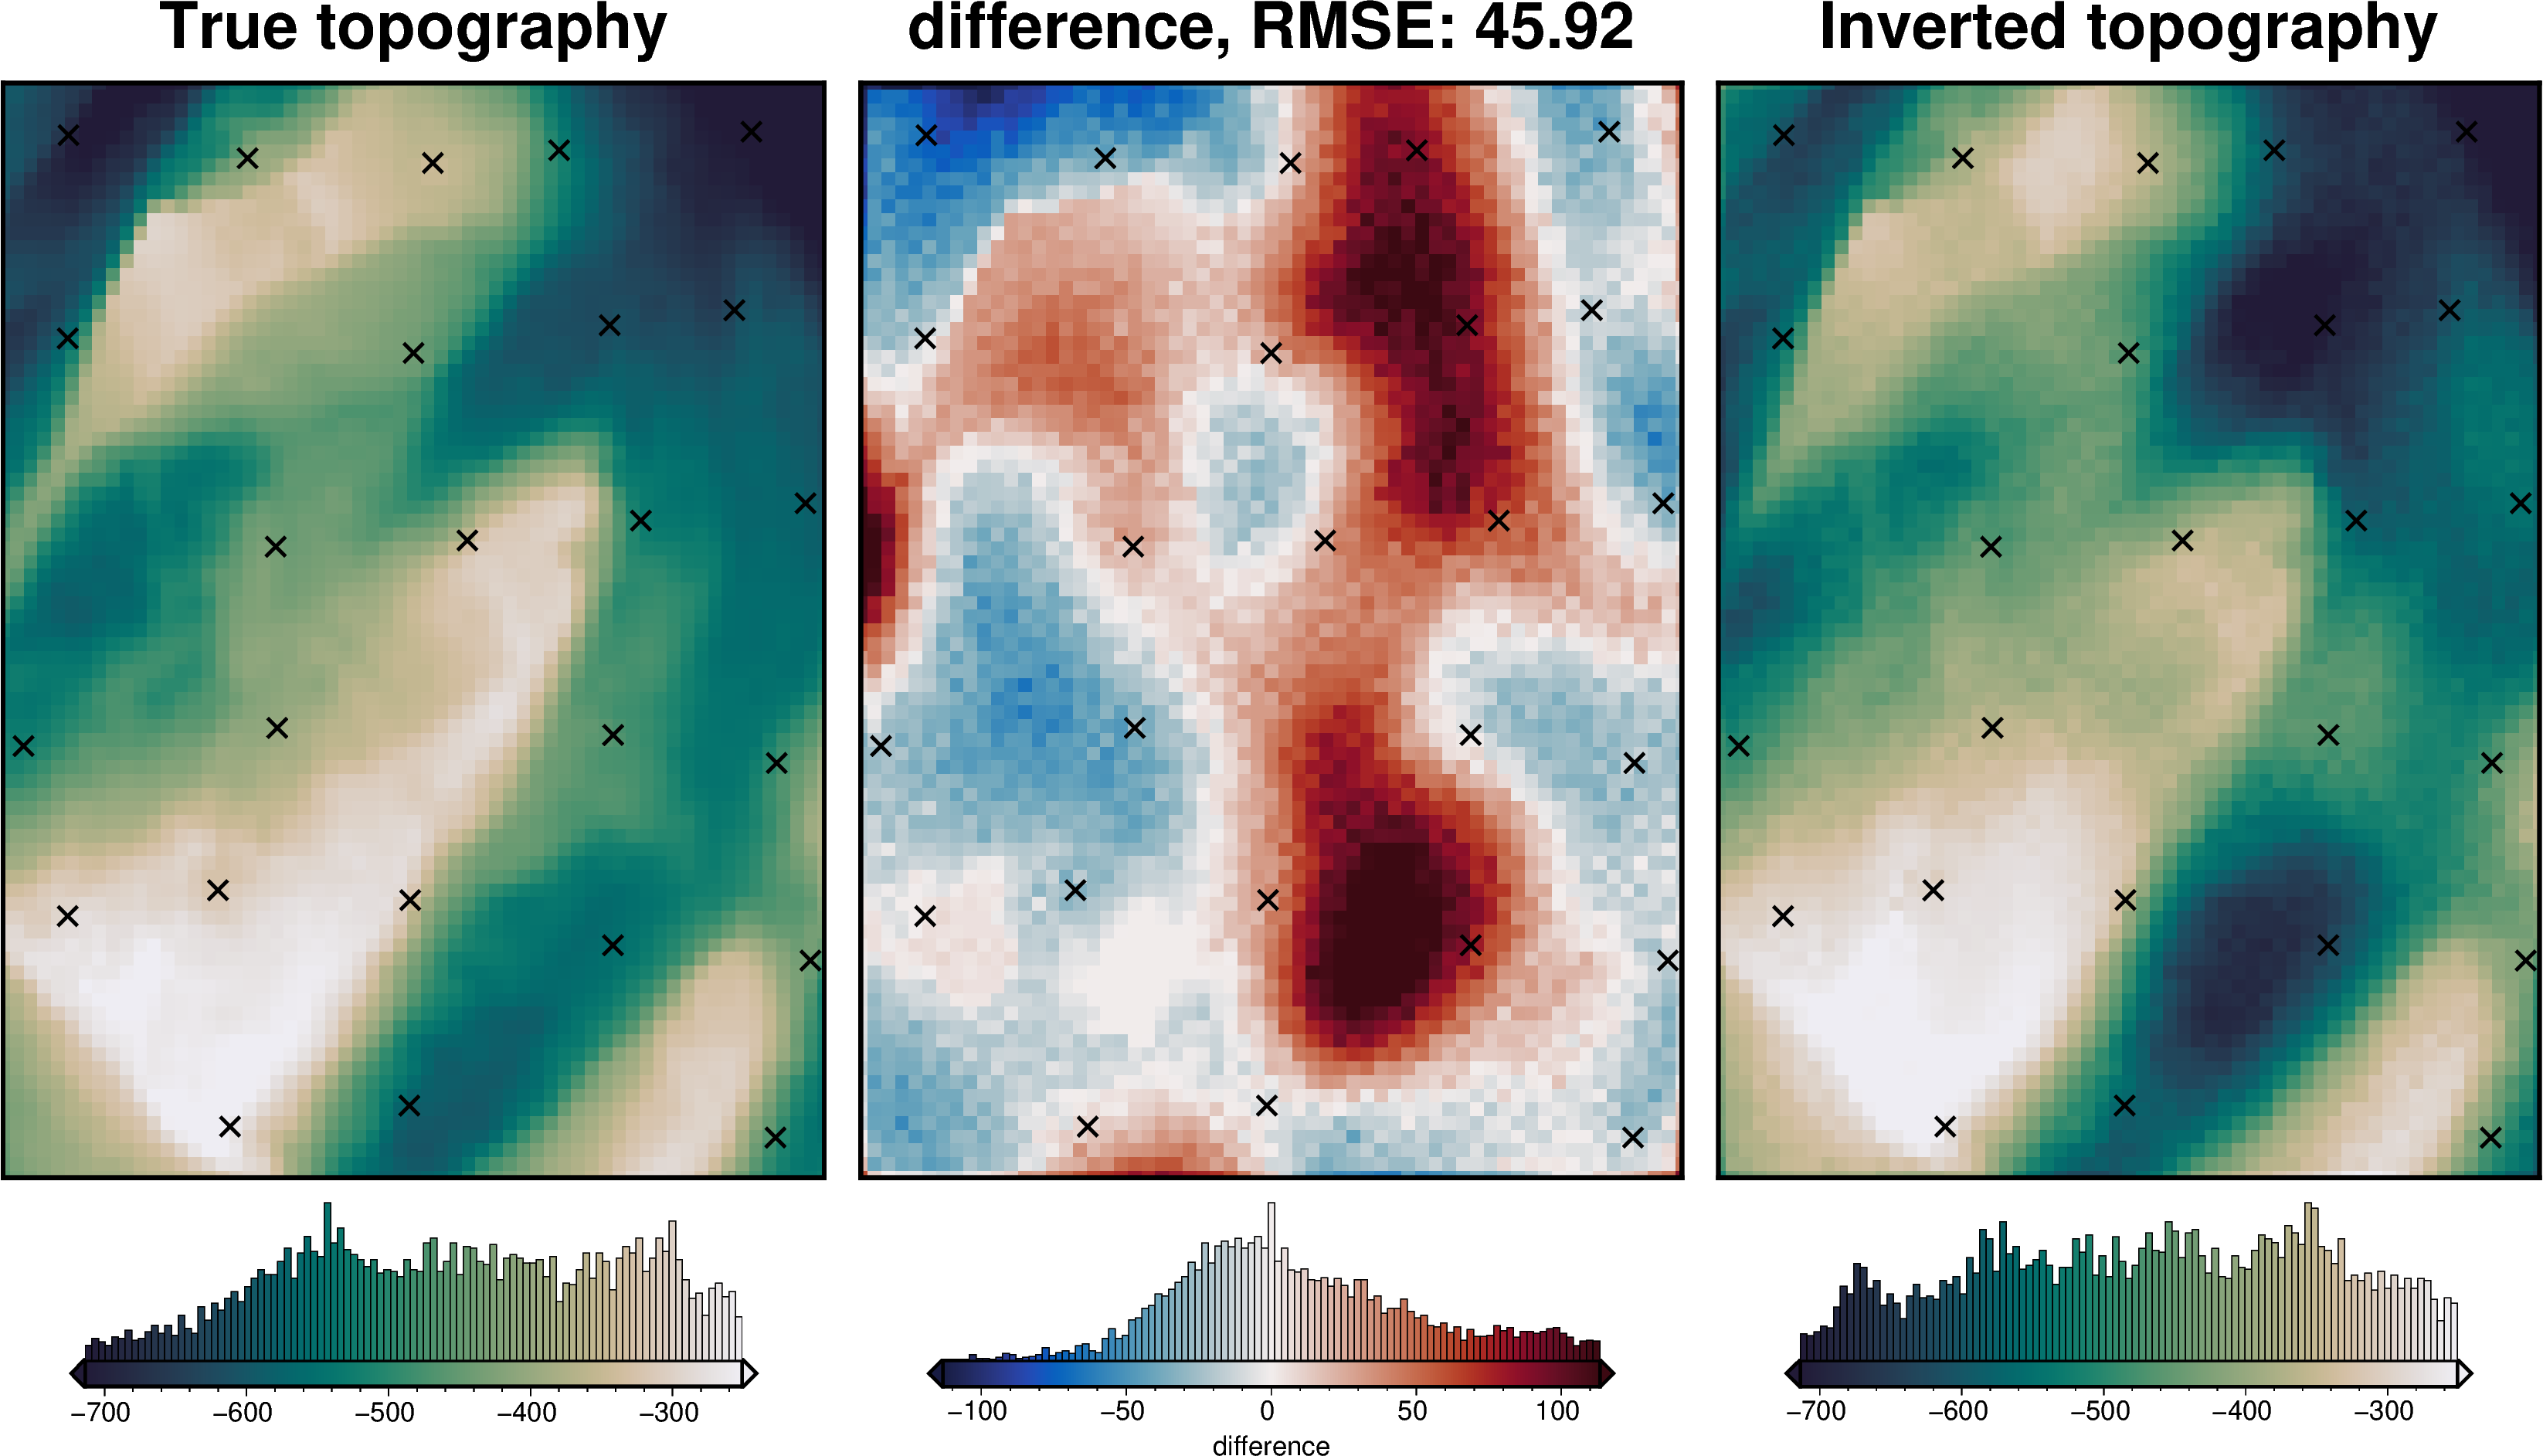

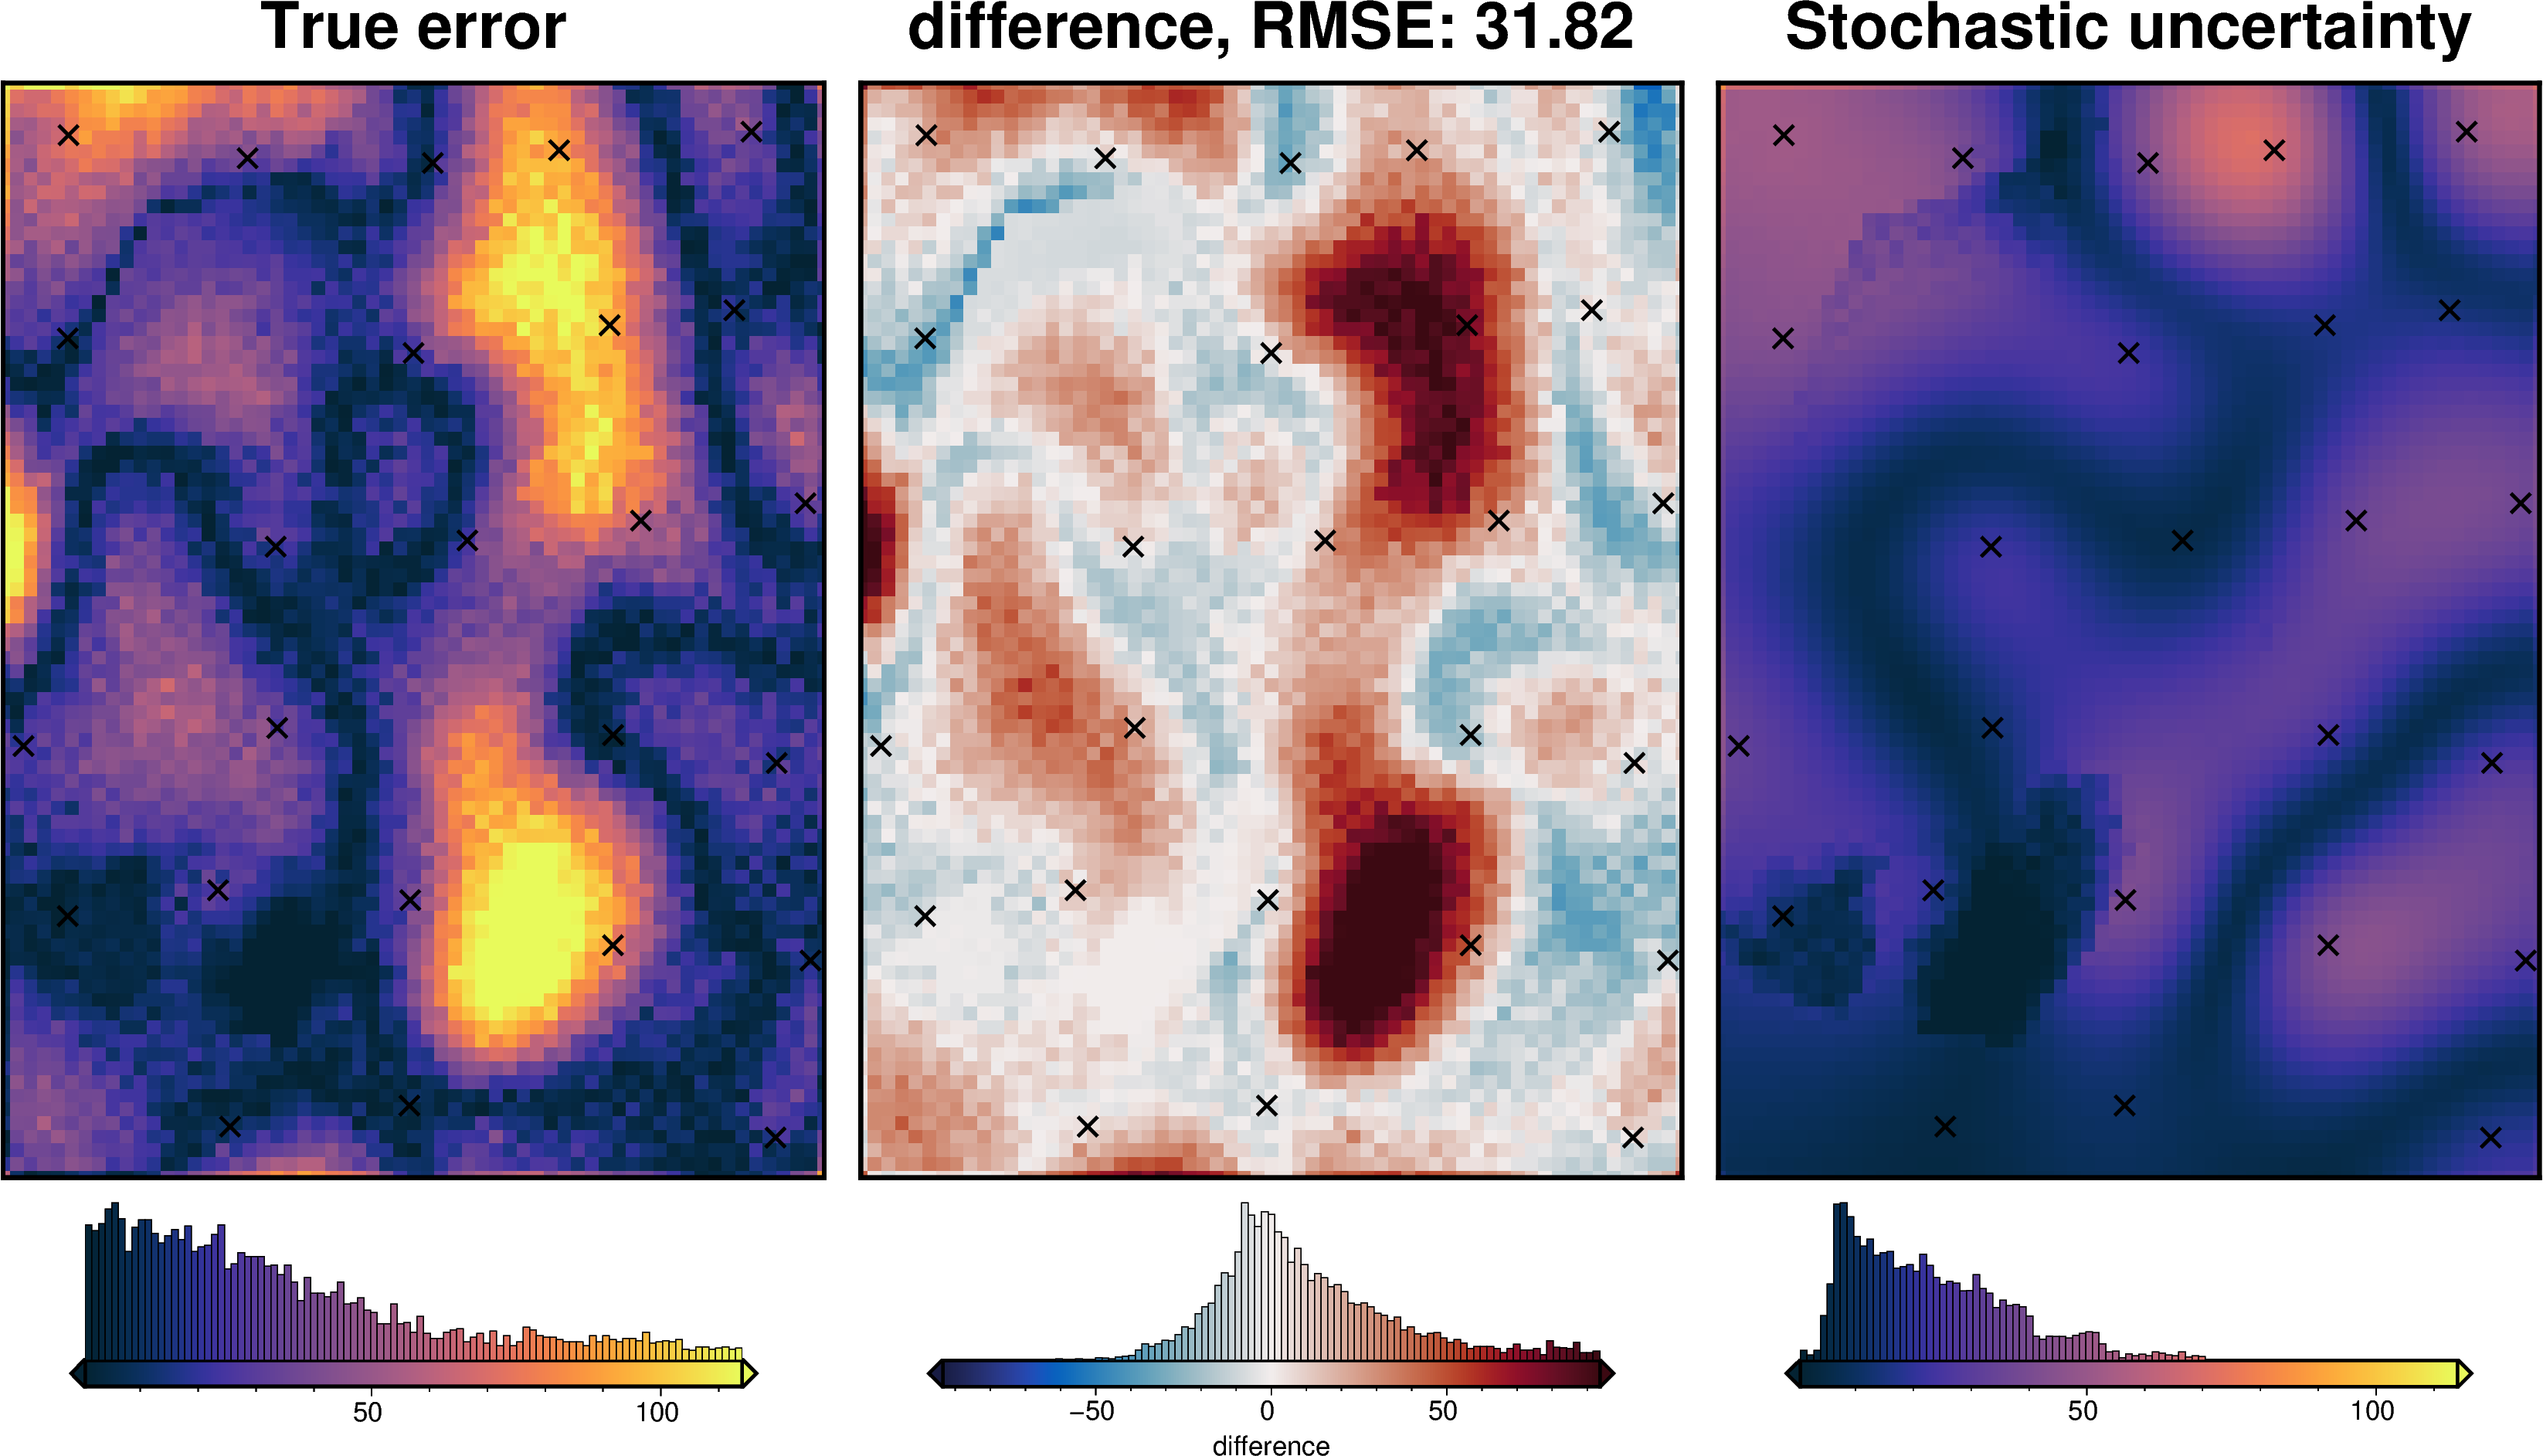

In [57]:
fname = f"{fname_start}_constraints"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_constraints_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    # choose what to sample
    # sample_gravity=True,
    sample_constraints=True,
    # parameter_dict=parameter_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_constraints_results)

### Starting topography component

INFO:invert4geom:Sampled 'dampings' parameter values; mean: 4.706463679847579e-38, min: 1.2024638555145843e-44, max: 8.316258284304727e-37
INFO:invert4geom:No pickle files starting with '../../results/Ross_sea_regional_uncertainty_starting_topo' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: '../../results/Ross_sea_regional_uncertainty_starting_topo'



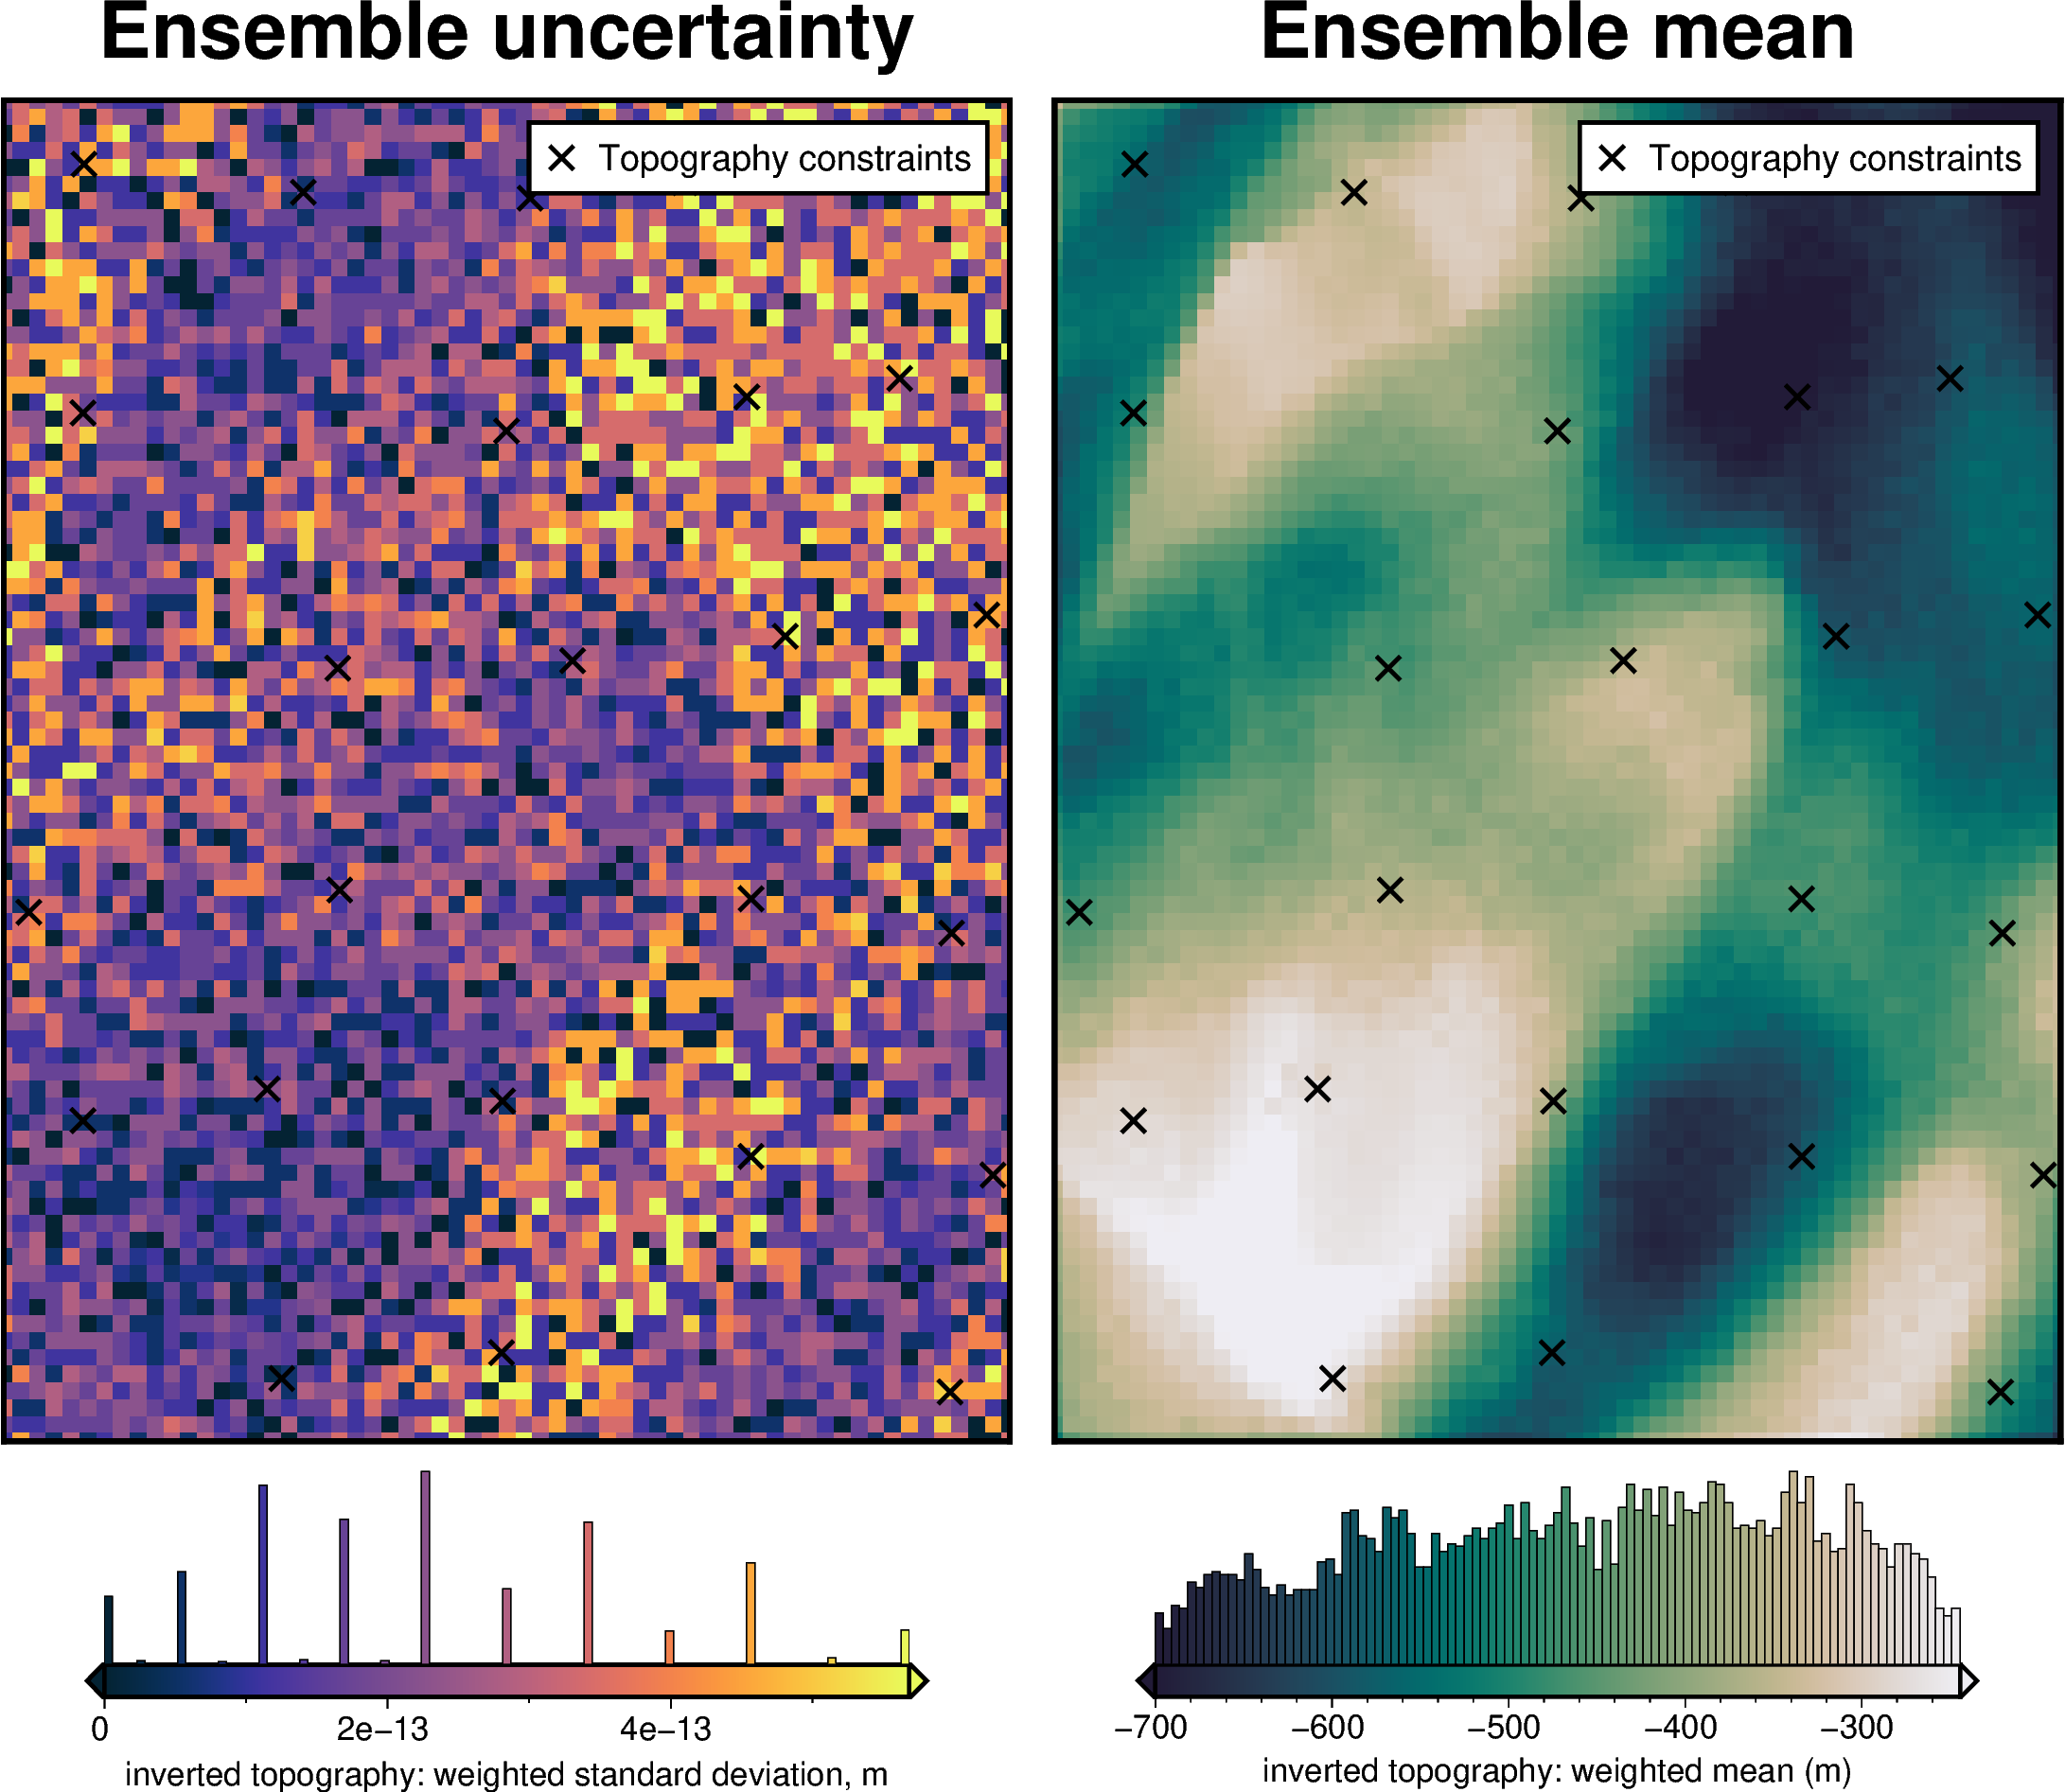

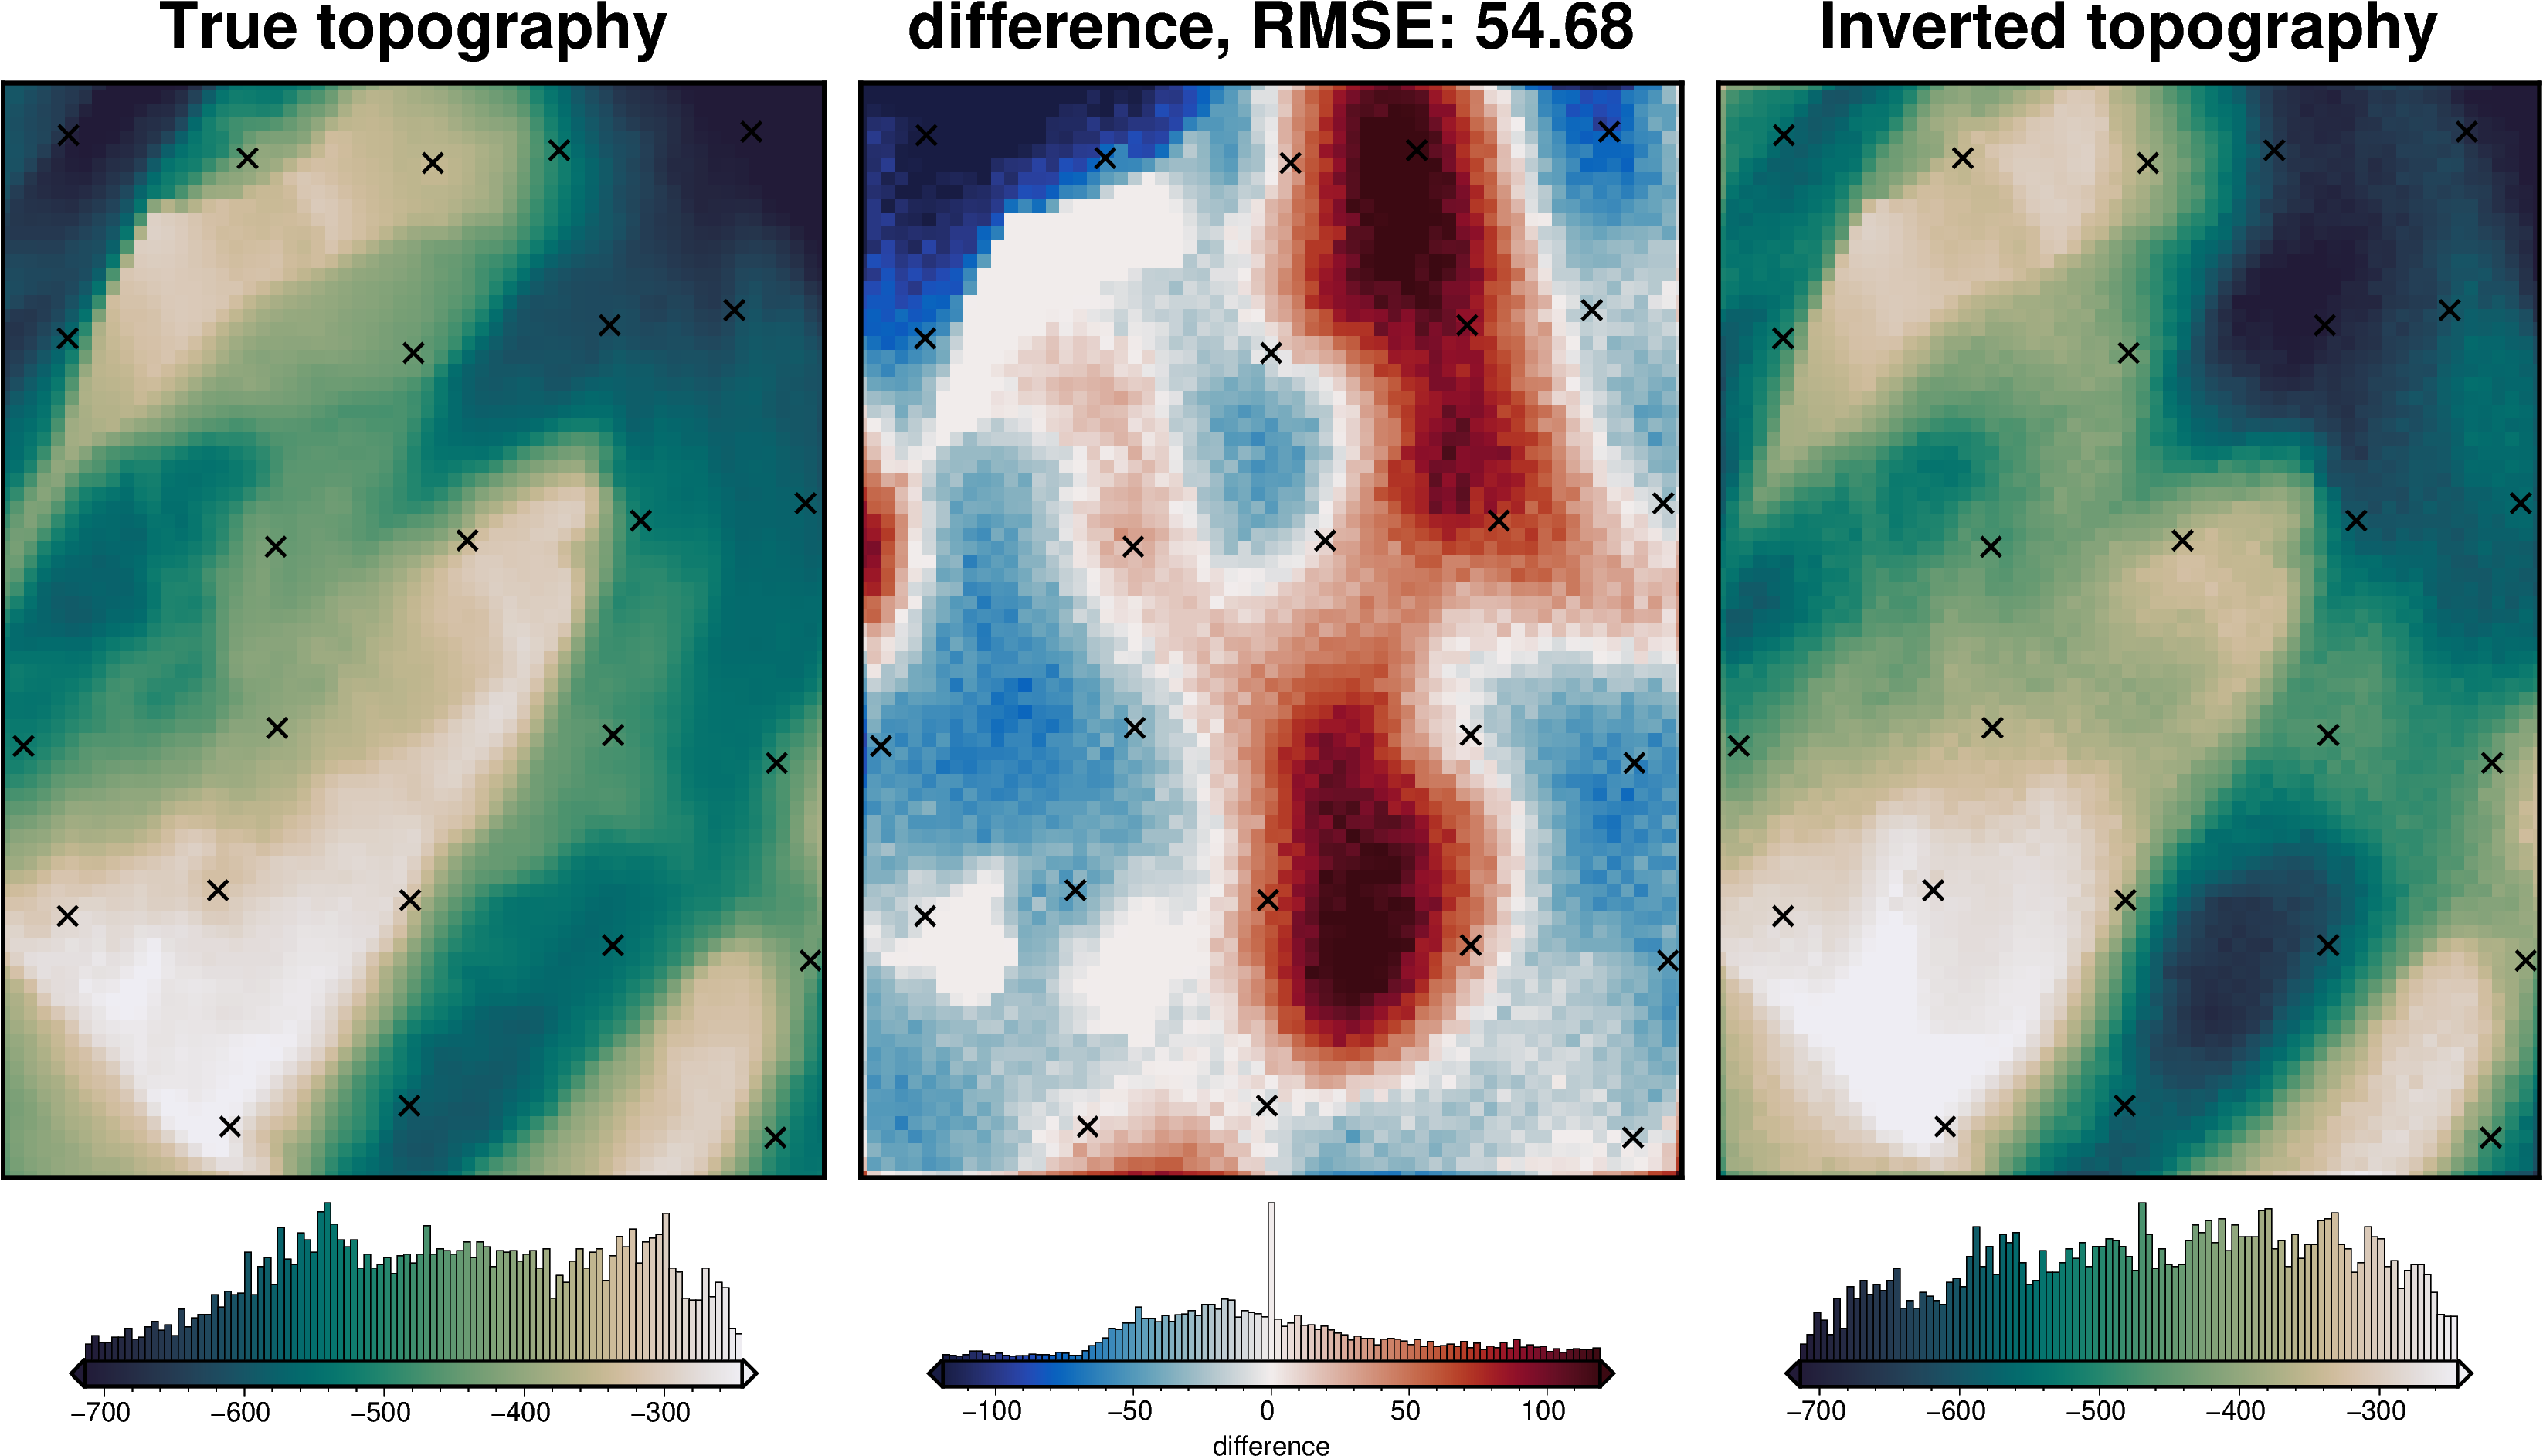

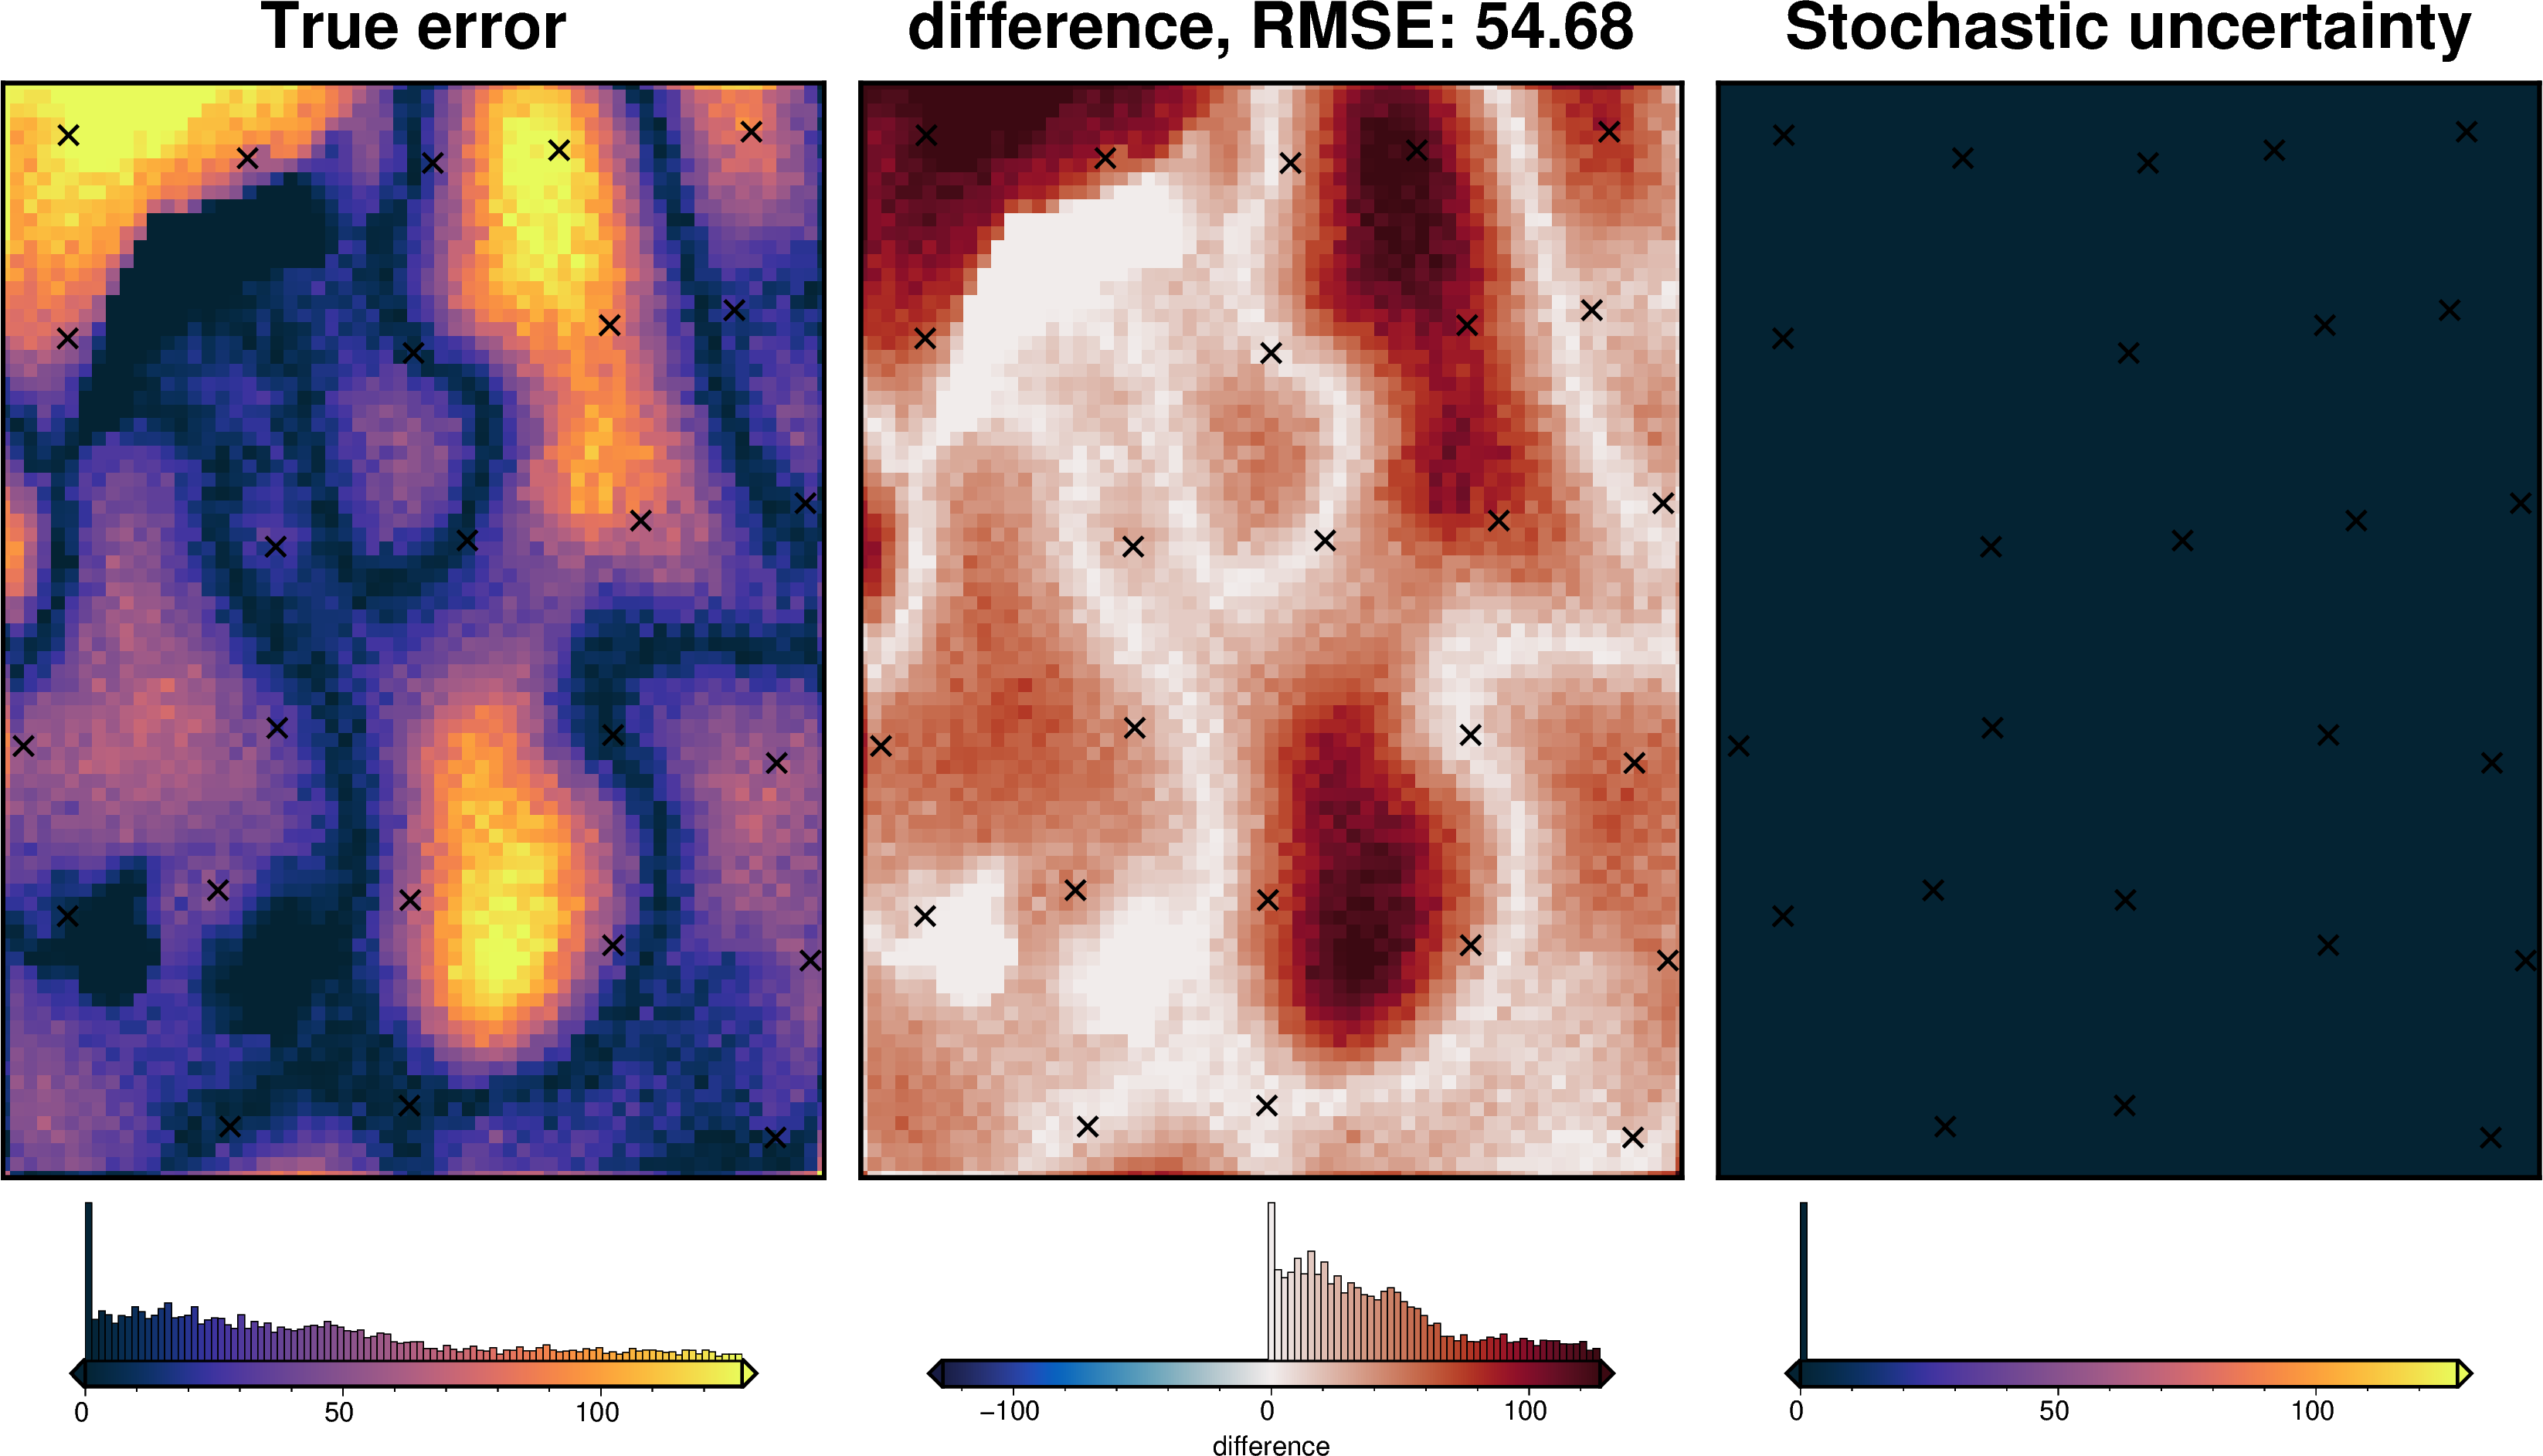

In [58]:
fname = f"{fname_start}_starting_topo"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_starting_topo_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    # parameter_dict=parameter_dict,
    starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_starting_topo_results)

### Regional gravity component

INFO:invert4geom:Sampled 'depth' parameter values; mean: 262394.8942791755, min: 159752.18563467448, max: 365037.6029236765
INFO:invert4geom:Sampled 'damping' parameter values; mean: 8.086635314303582e-60, min: 1.09656912938245e-62, max: 9.119352106539471e-59
INFO:invert4geom:No pickle files starting with '../../results/Ross_sea_regional_uncertainty_regional' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: '../../results/Ross_sea_regional_uncertainty_regional'



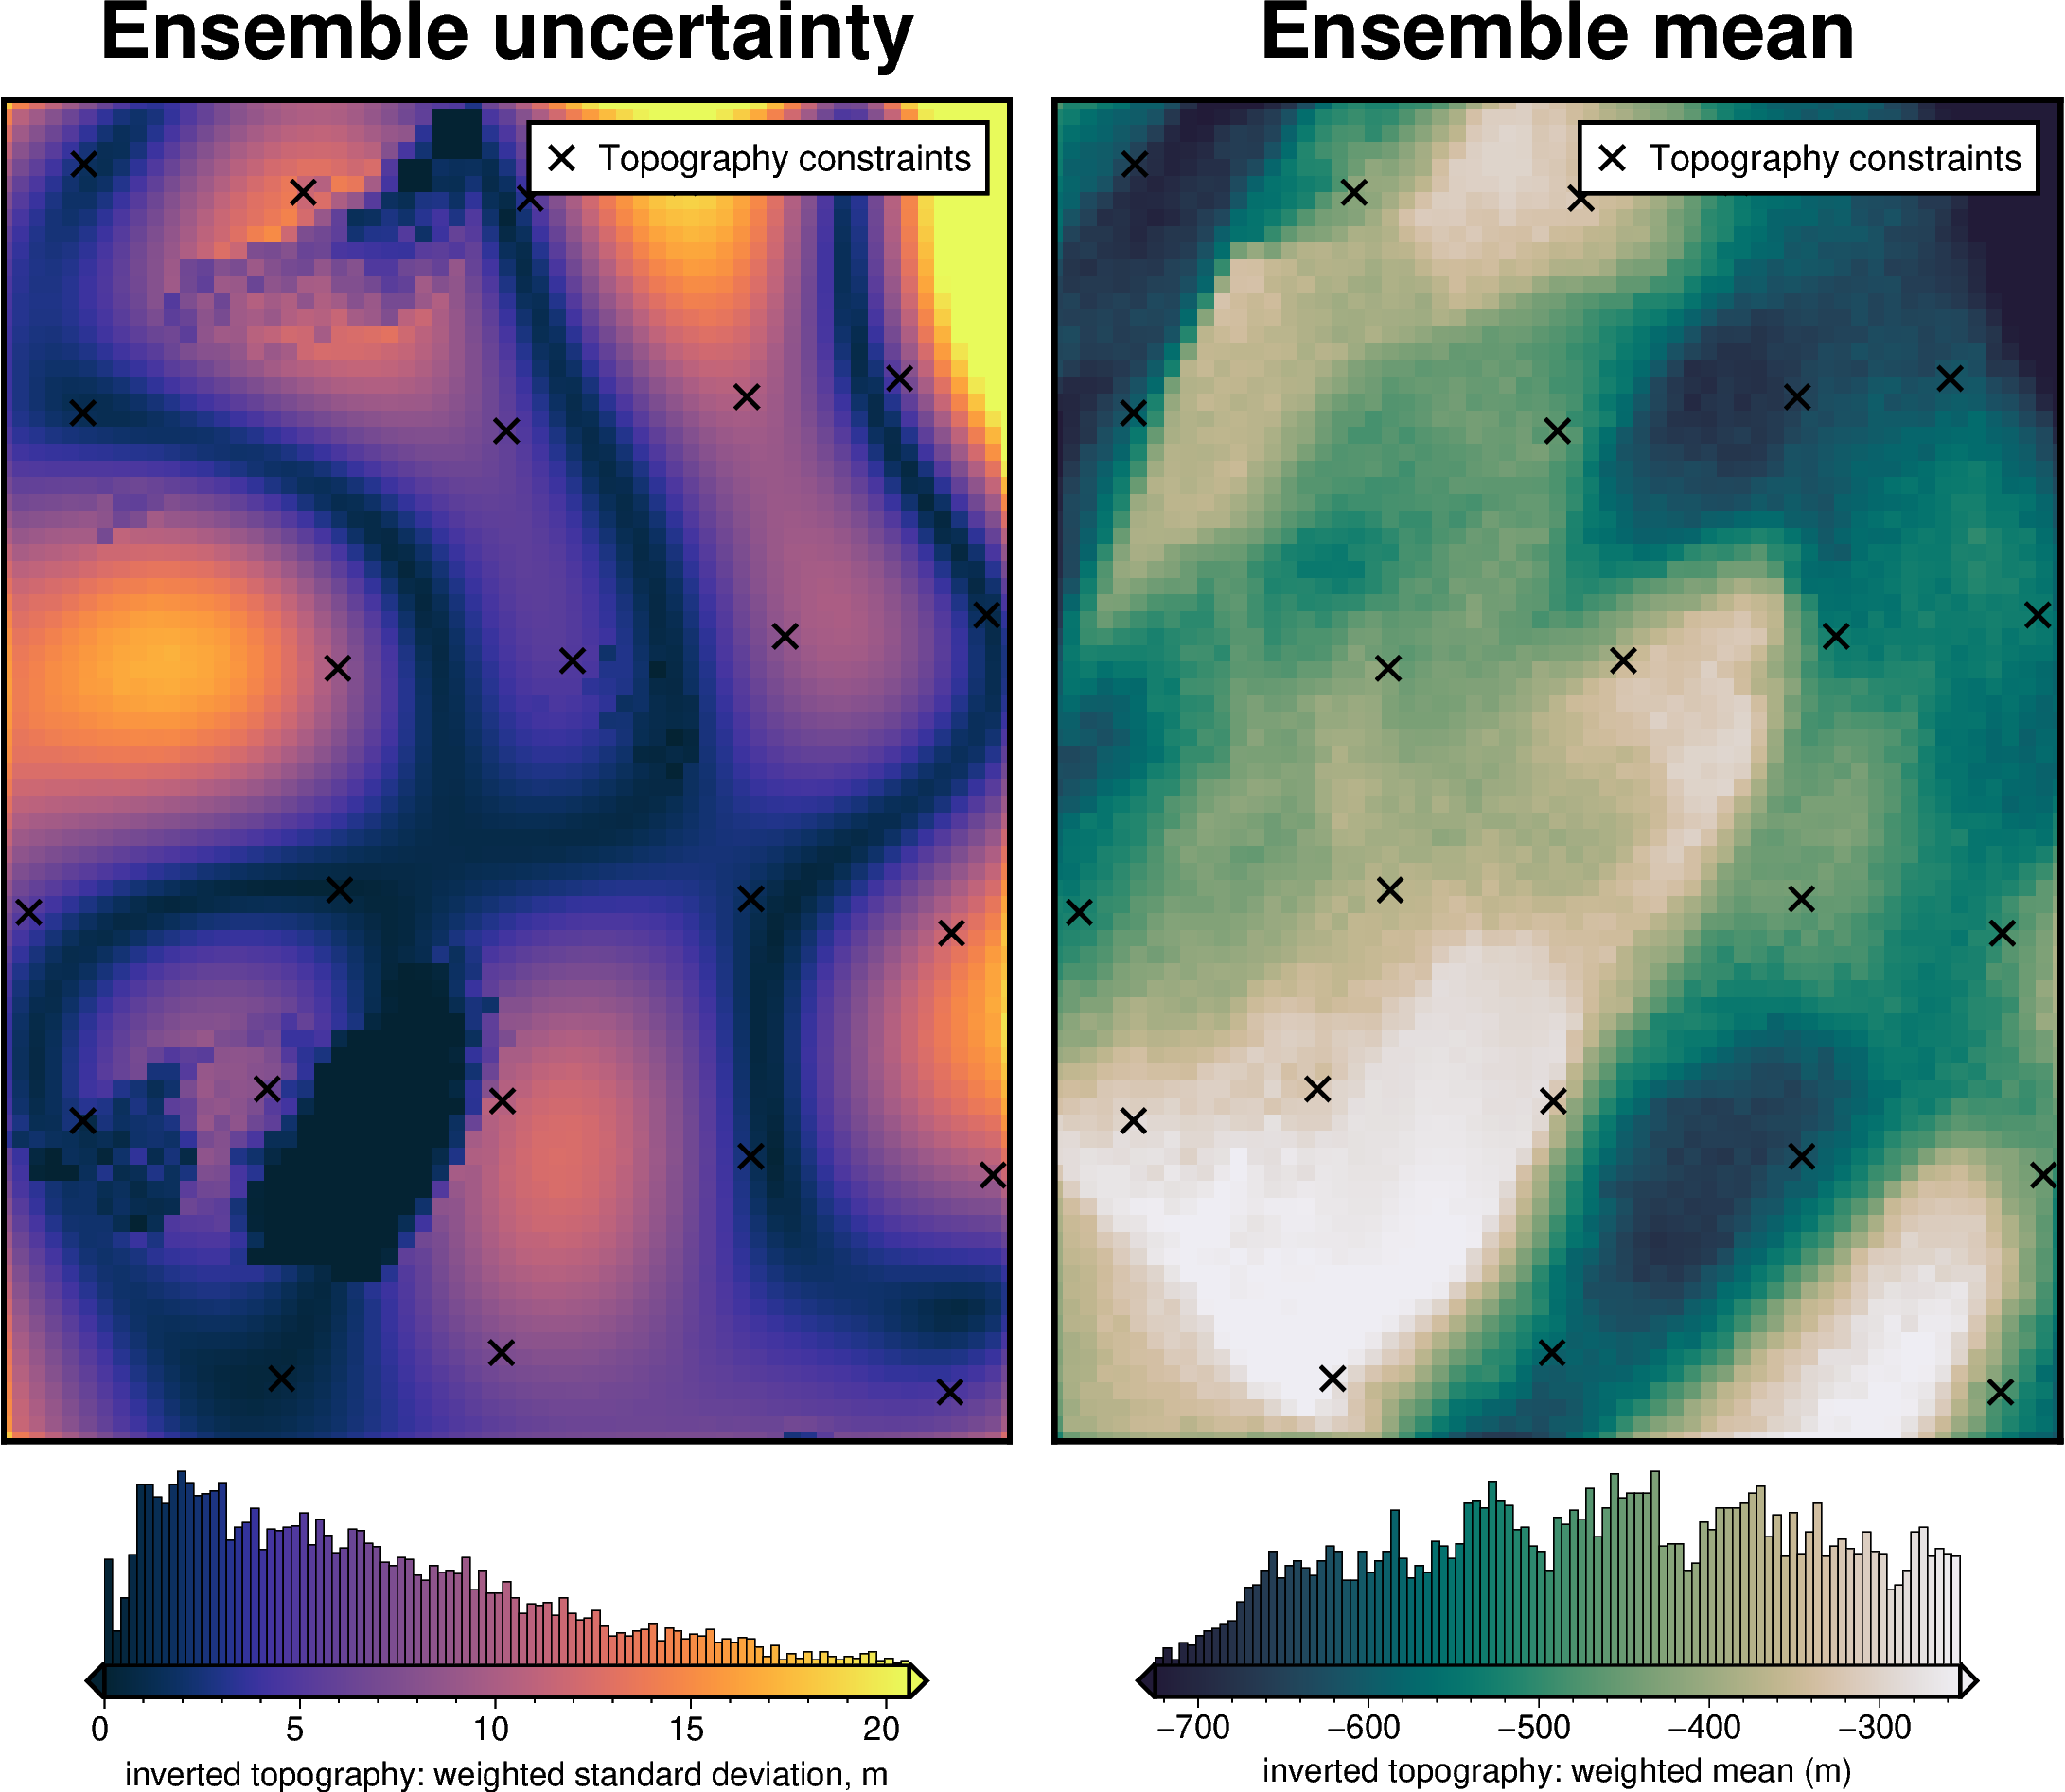

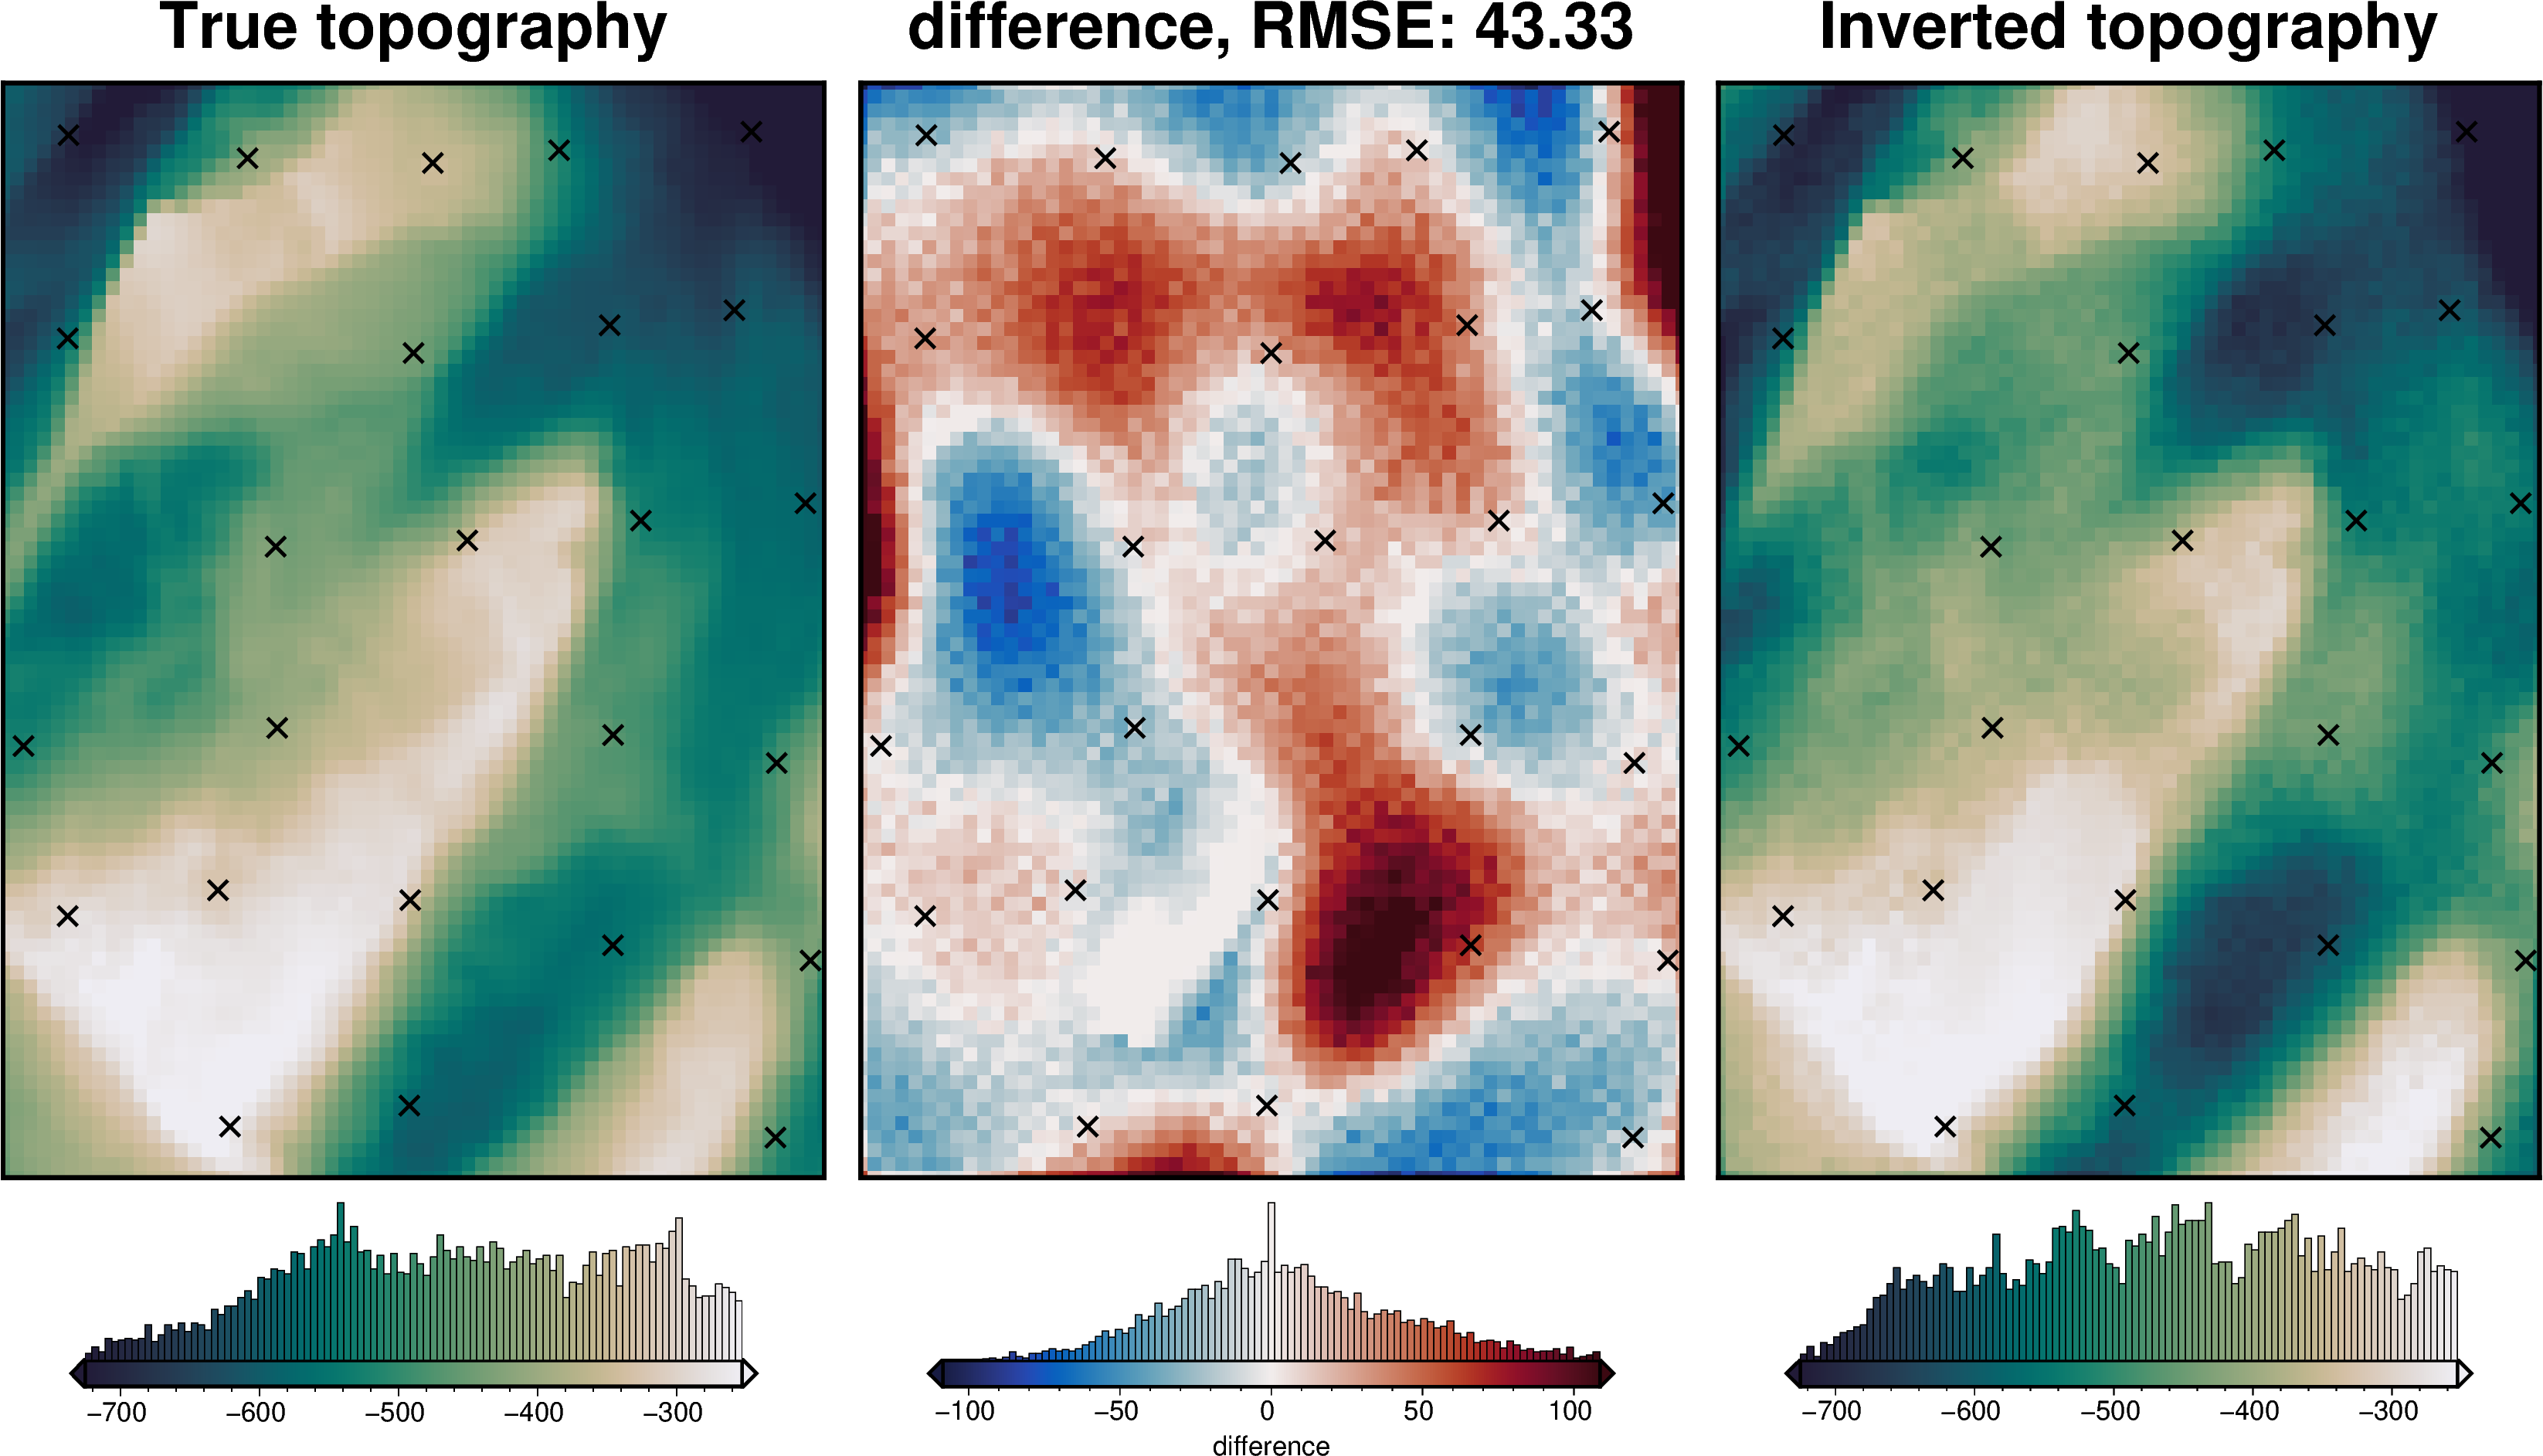

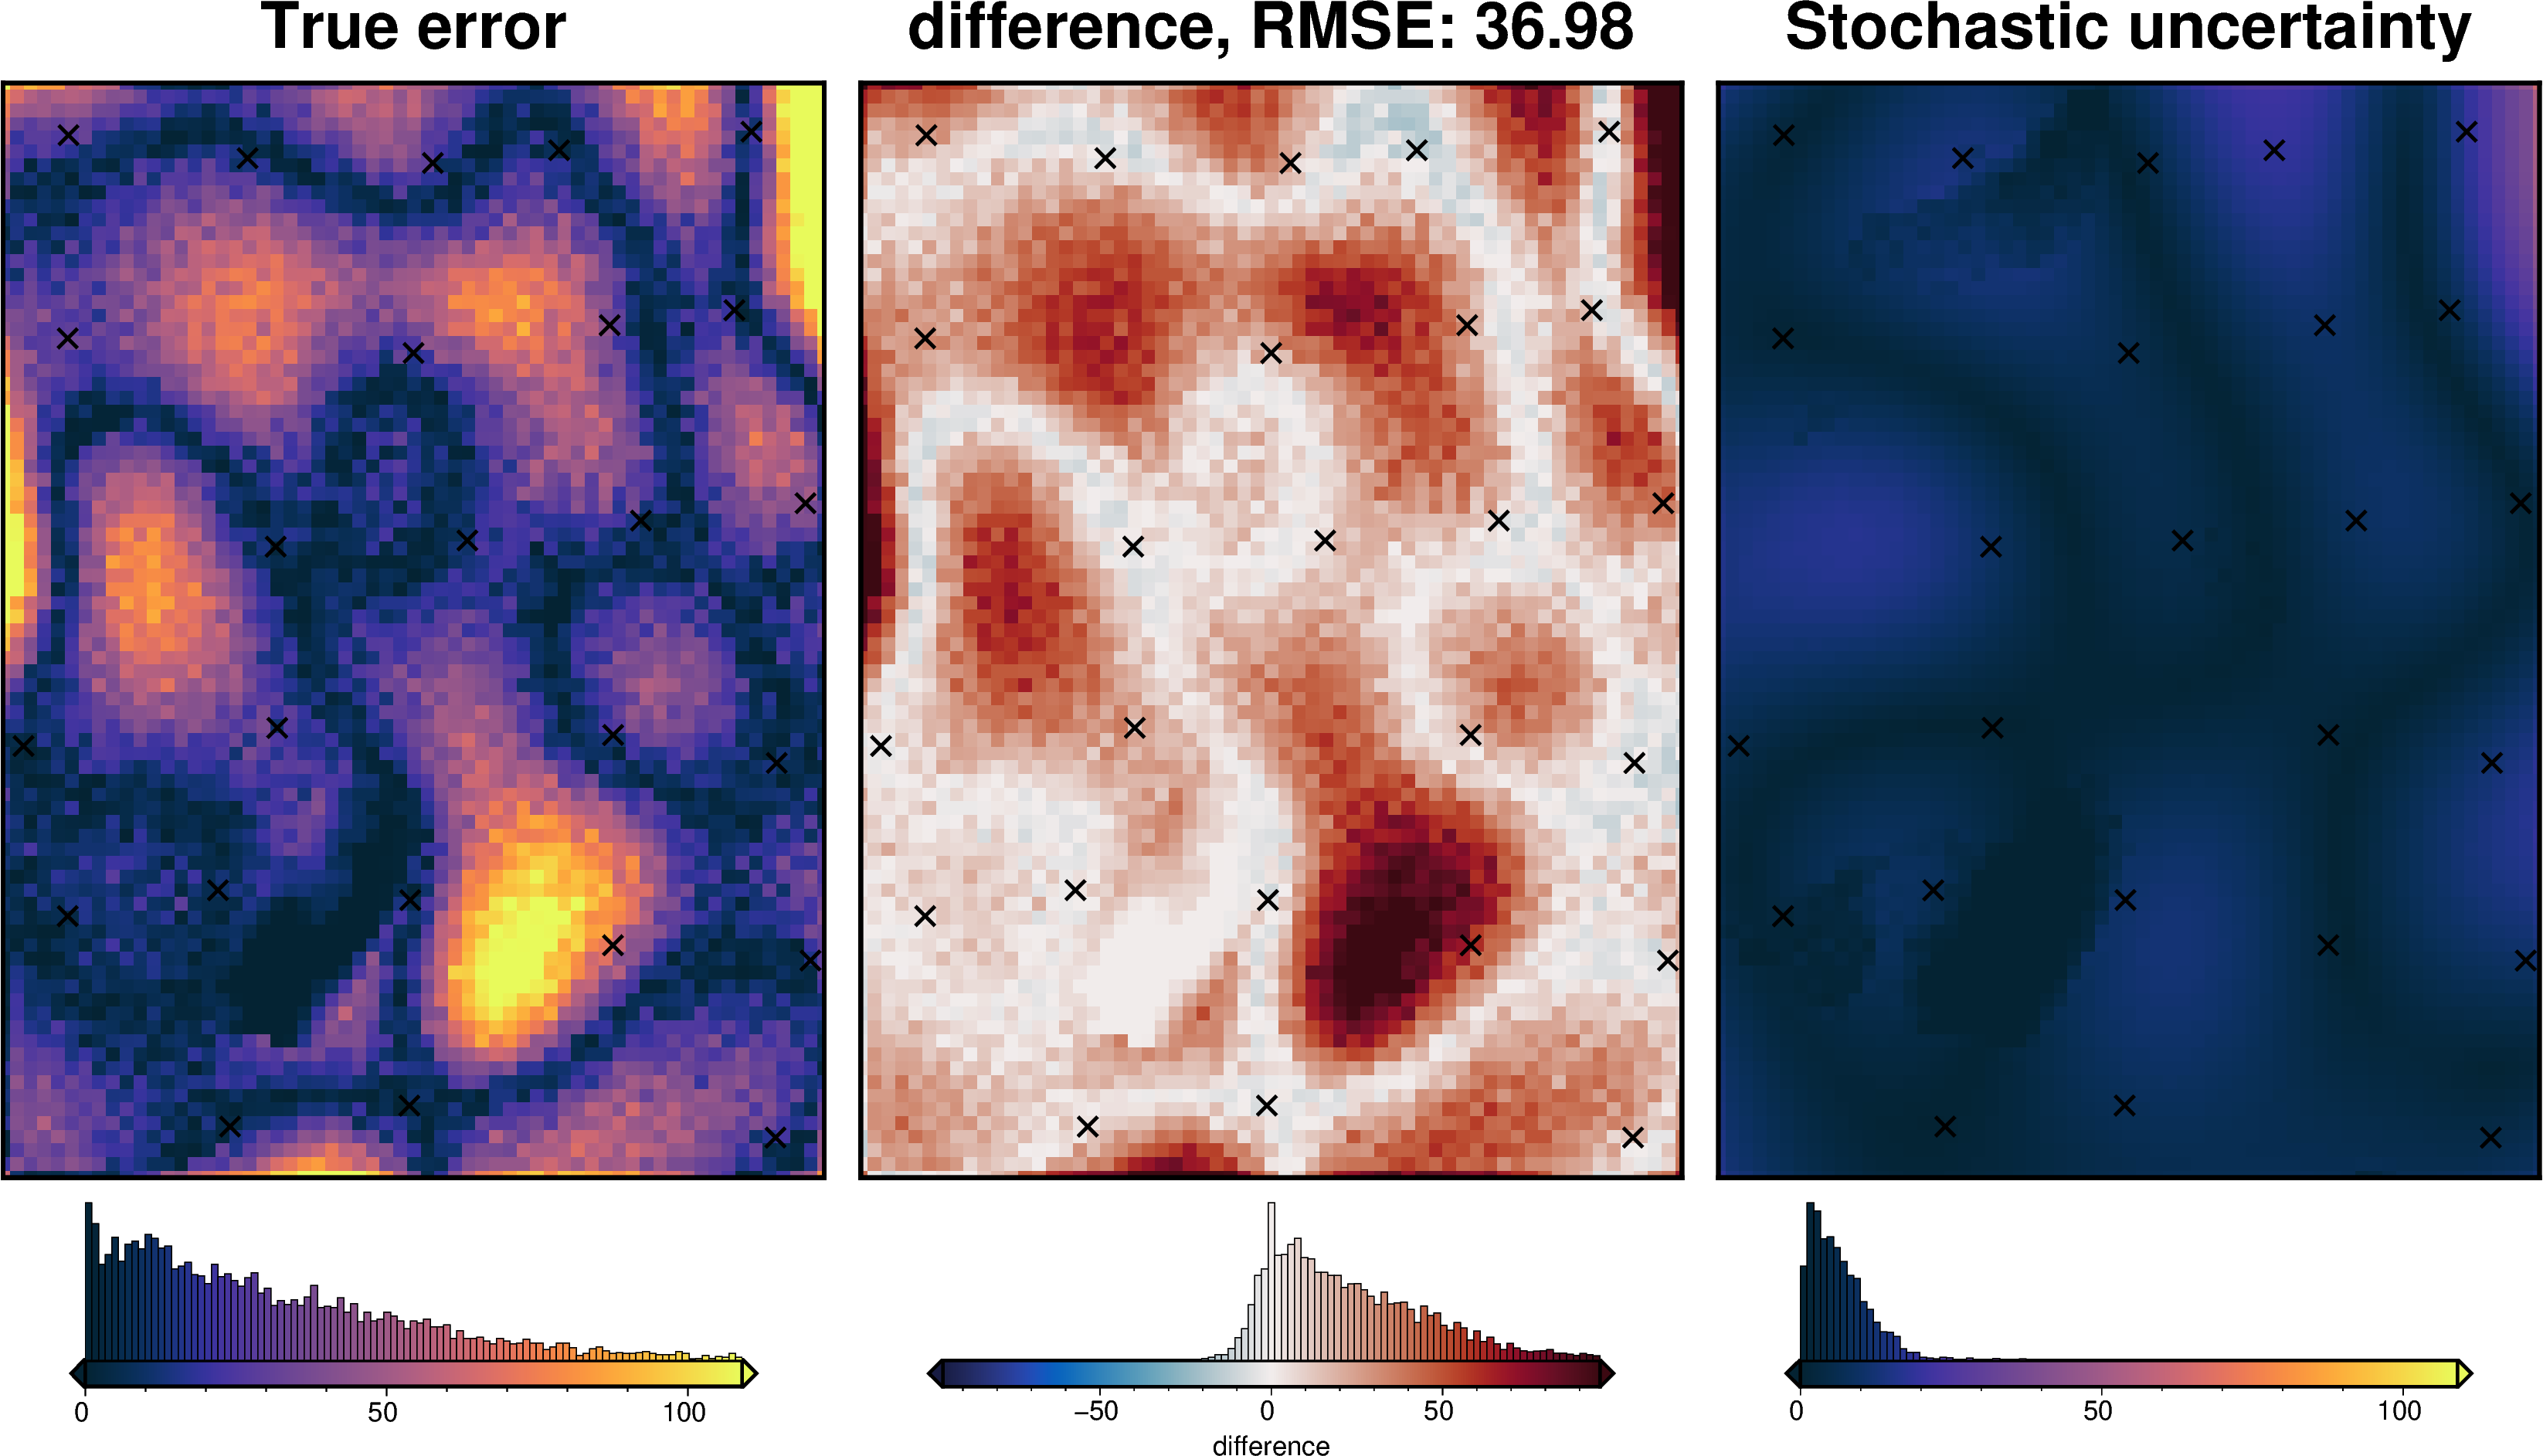

In [59]:
fname = f"{fname_start}_regional"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_regional_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    # parameter_dict=parameter_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    # create_starting_topography=True,
    # create_starting_prisms=True,
    # calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_regional_results)

### Total uncertainty

In [60]:
# combine density and solver param dicts
parameter_dict = density_dict | solver_dict
parameter_dict

{'density_contrast': {'distribution': 'normal',
  'loc': 1872.8414953209308,
  'scale': 150},
 'solver_damping': {'distribution': 'normal',
  'loc': np.float64(-1.655650746528249),
  'scale': 0.2,
  'log': True}}

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 1872.841495320931, min: 1578.8468976399226, max: 2166.8360930019394
INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.02439049015759641, min: 0.008960999571648233, max: 0.05449316721148762
INFO:invert4geom:Sampled 'dampings' parameter values; mean: 4.706463679847579e-38, min: 1.2024638555145843e-44, max: 8.316258284304727e-37
INFO:invert4geom:Sampled 'depth' parameter values; mean: 262394.8942791755, min: 159752.18563467448, max: 365037.6029236765
INFO:invert4geom:Sampled 'damping' parameter values; mean: 8.086635314303582e-60, min: 1.09656912938245e-62, max: 9.119352106539471e-59
INFO:invert4geom:No pickle files starting with '../../results/Ross_sea_regional_uncertainty_full' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: '../../results/Ross_sea_regional_uncertainty_full'



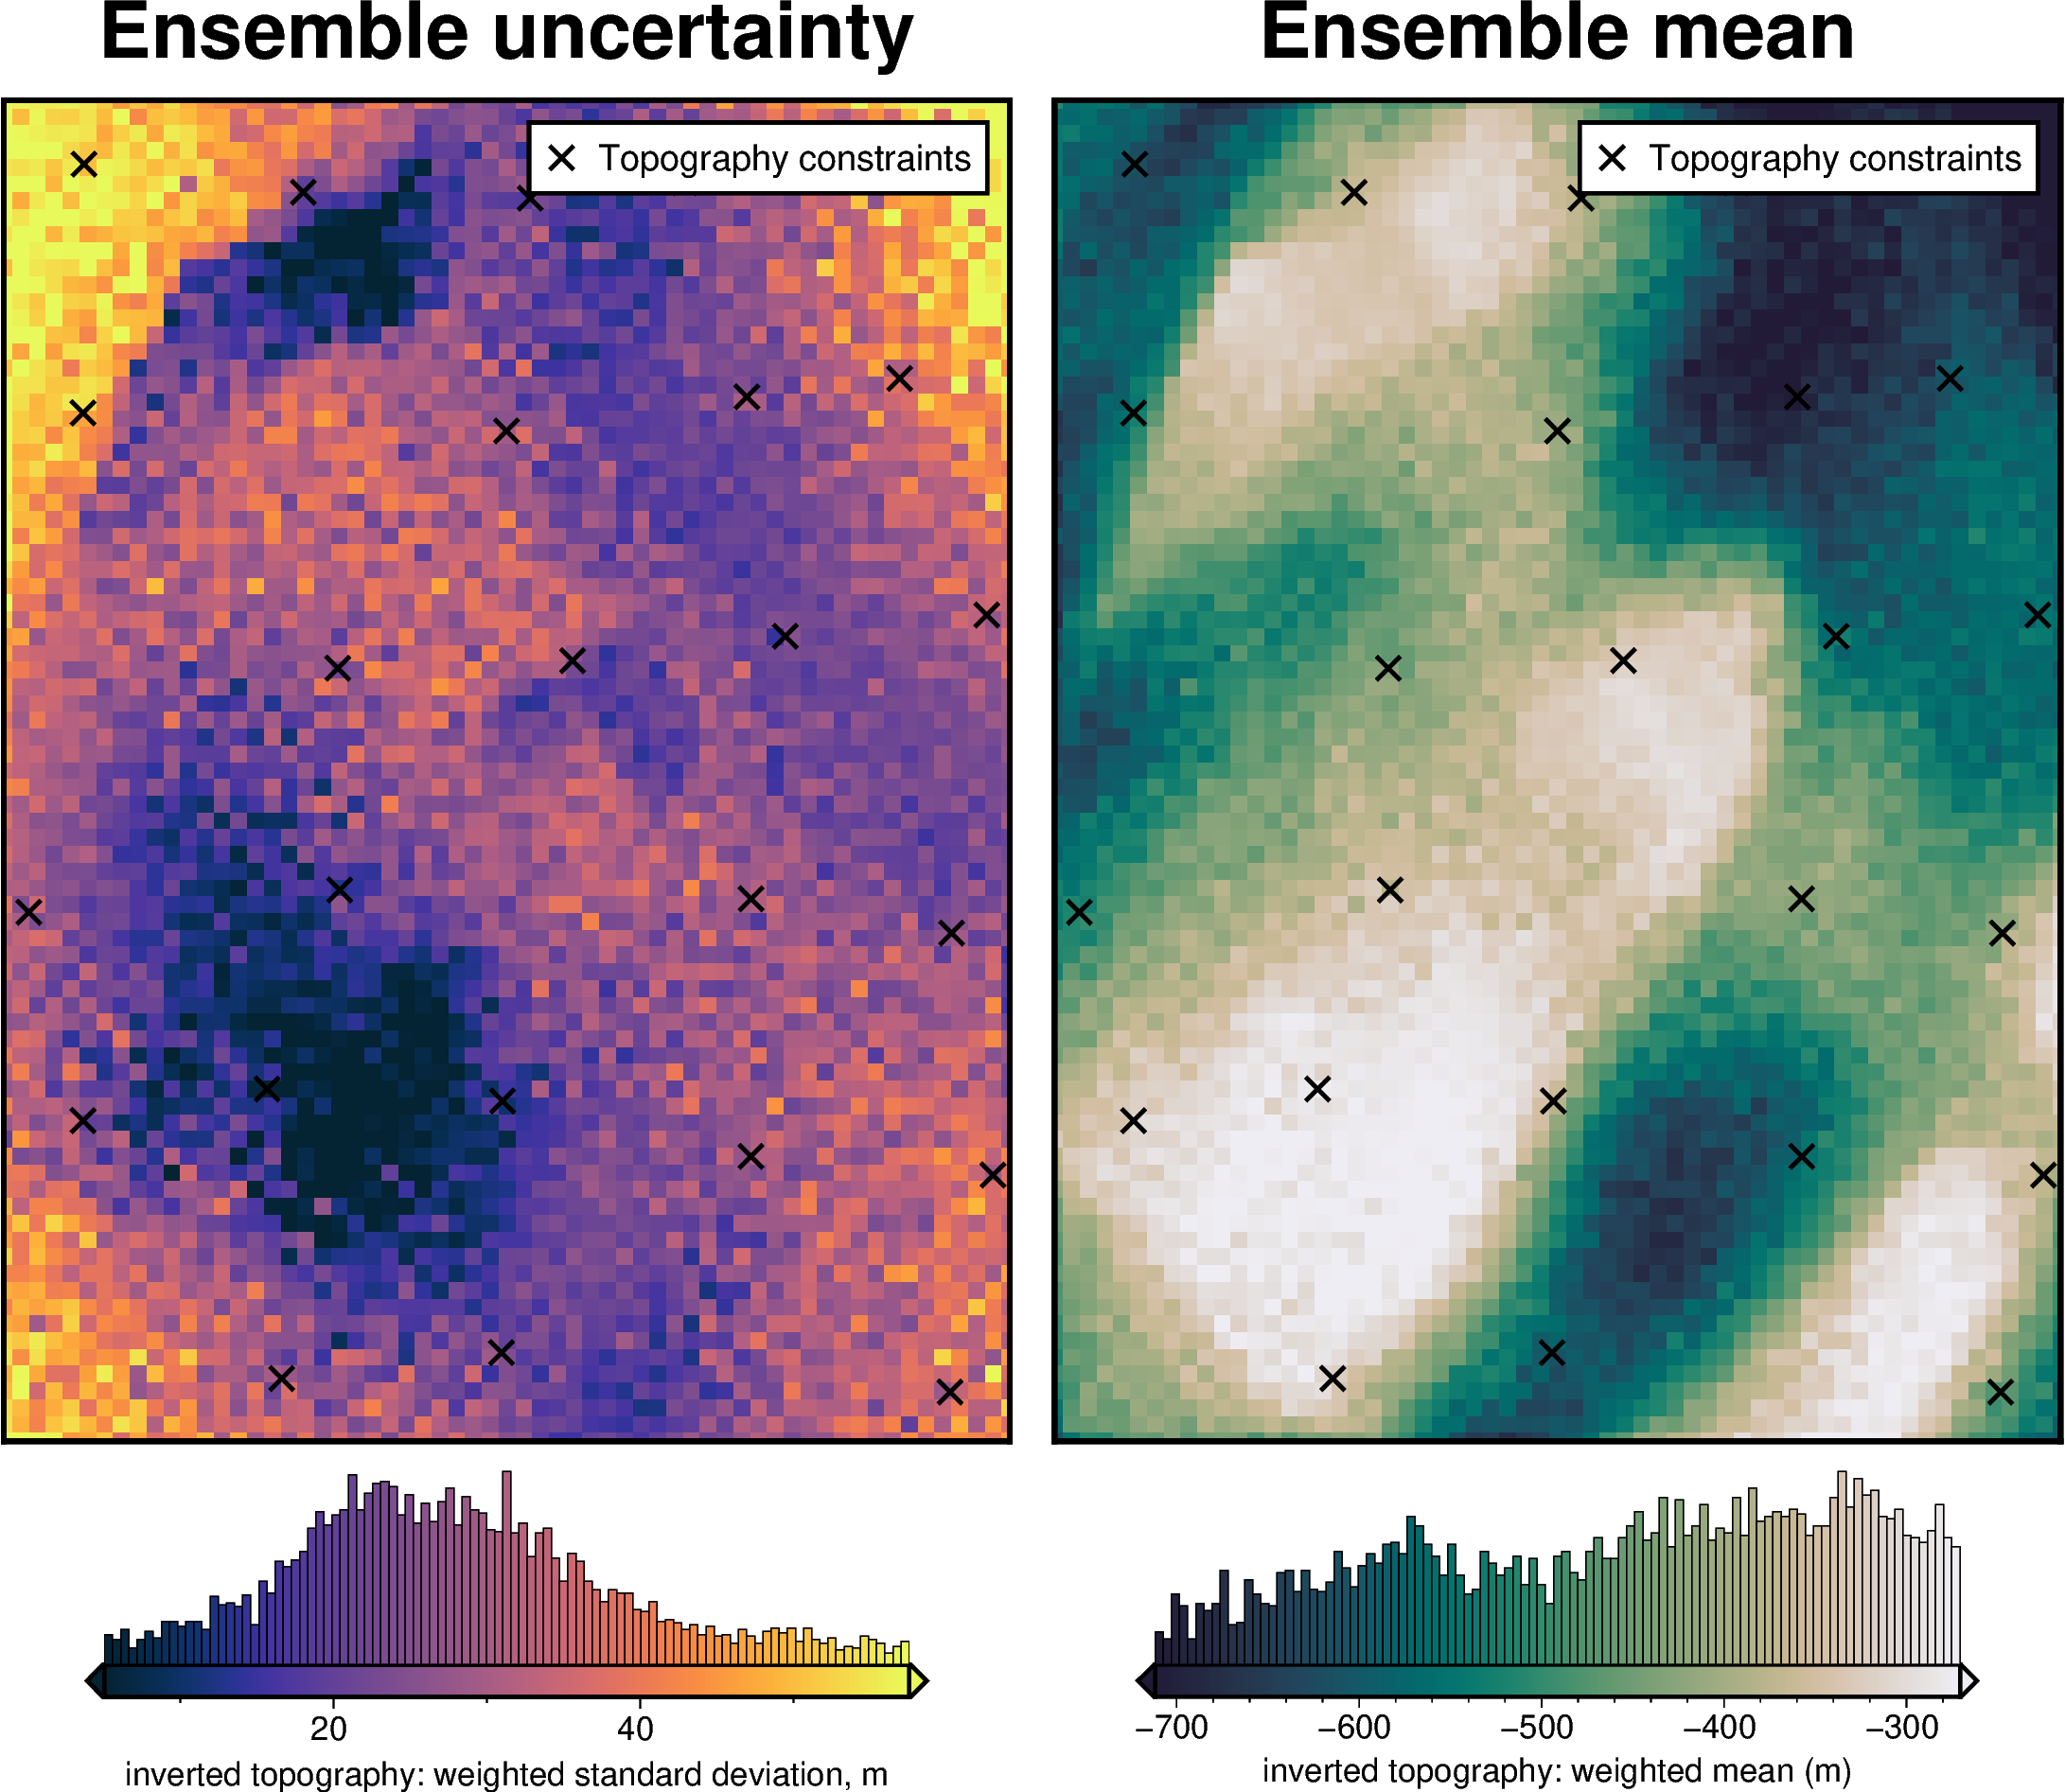

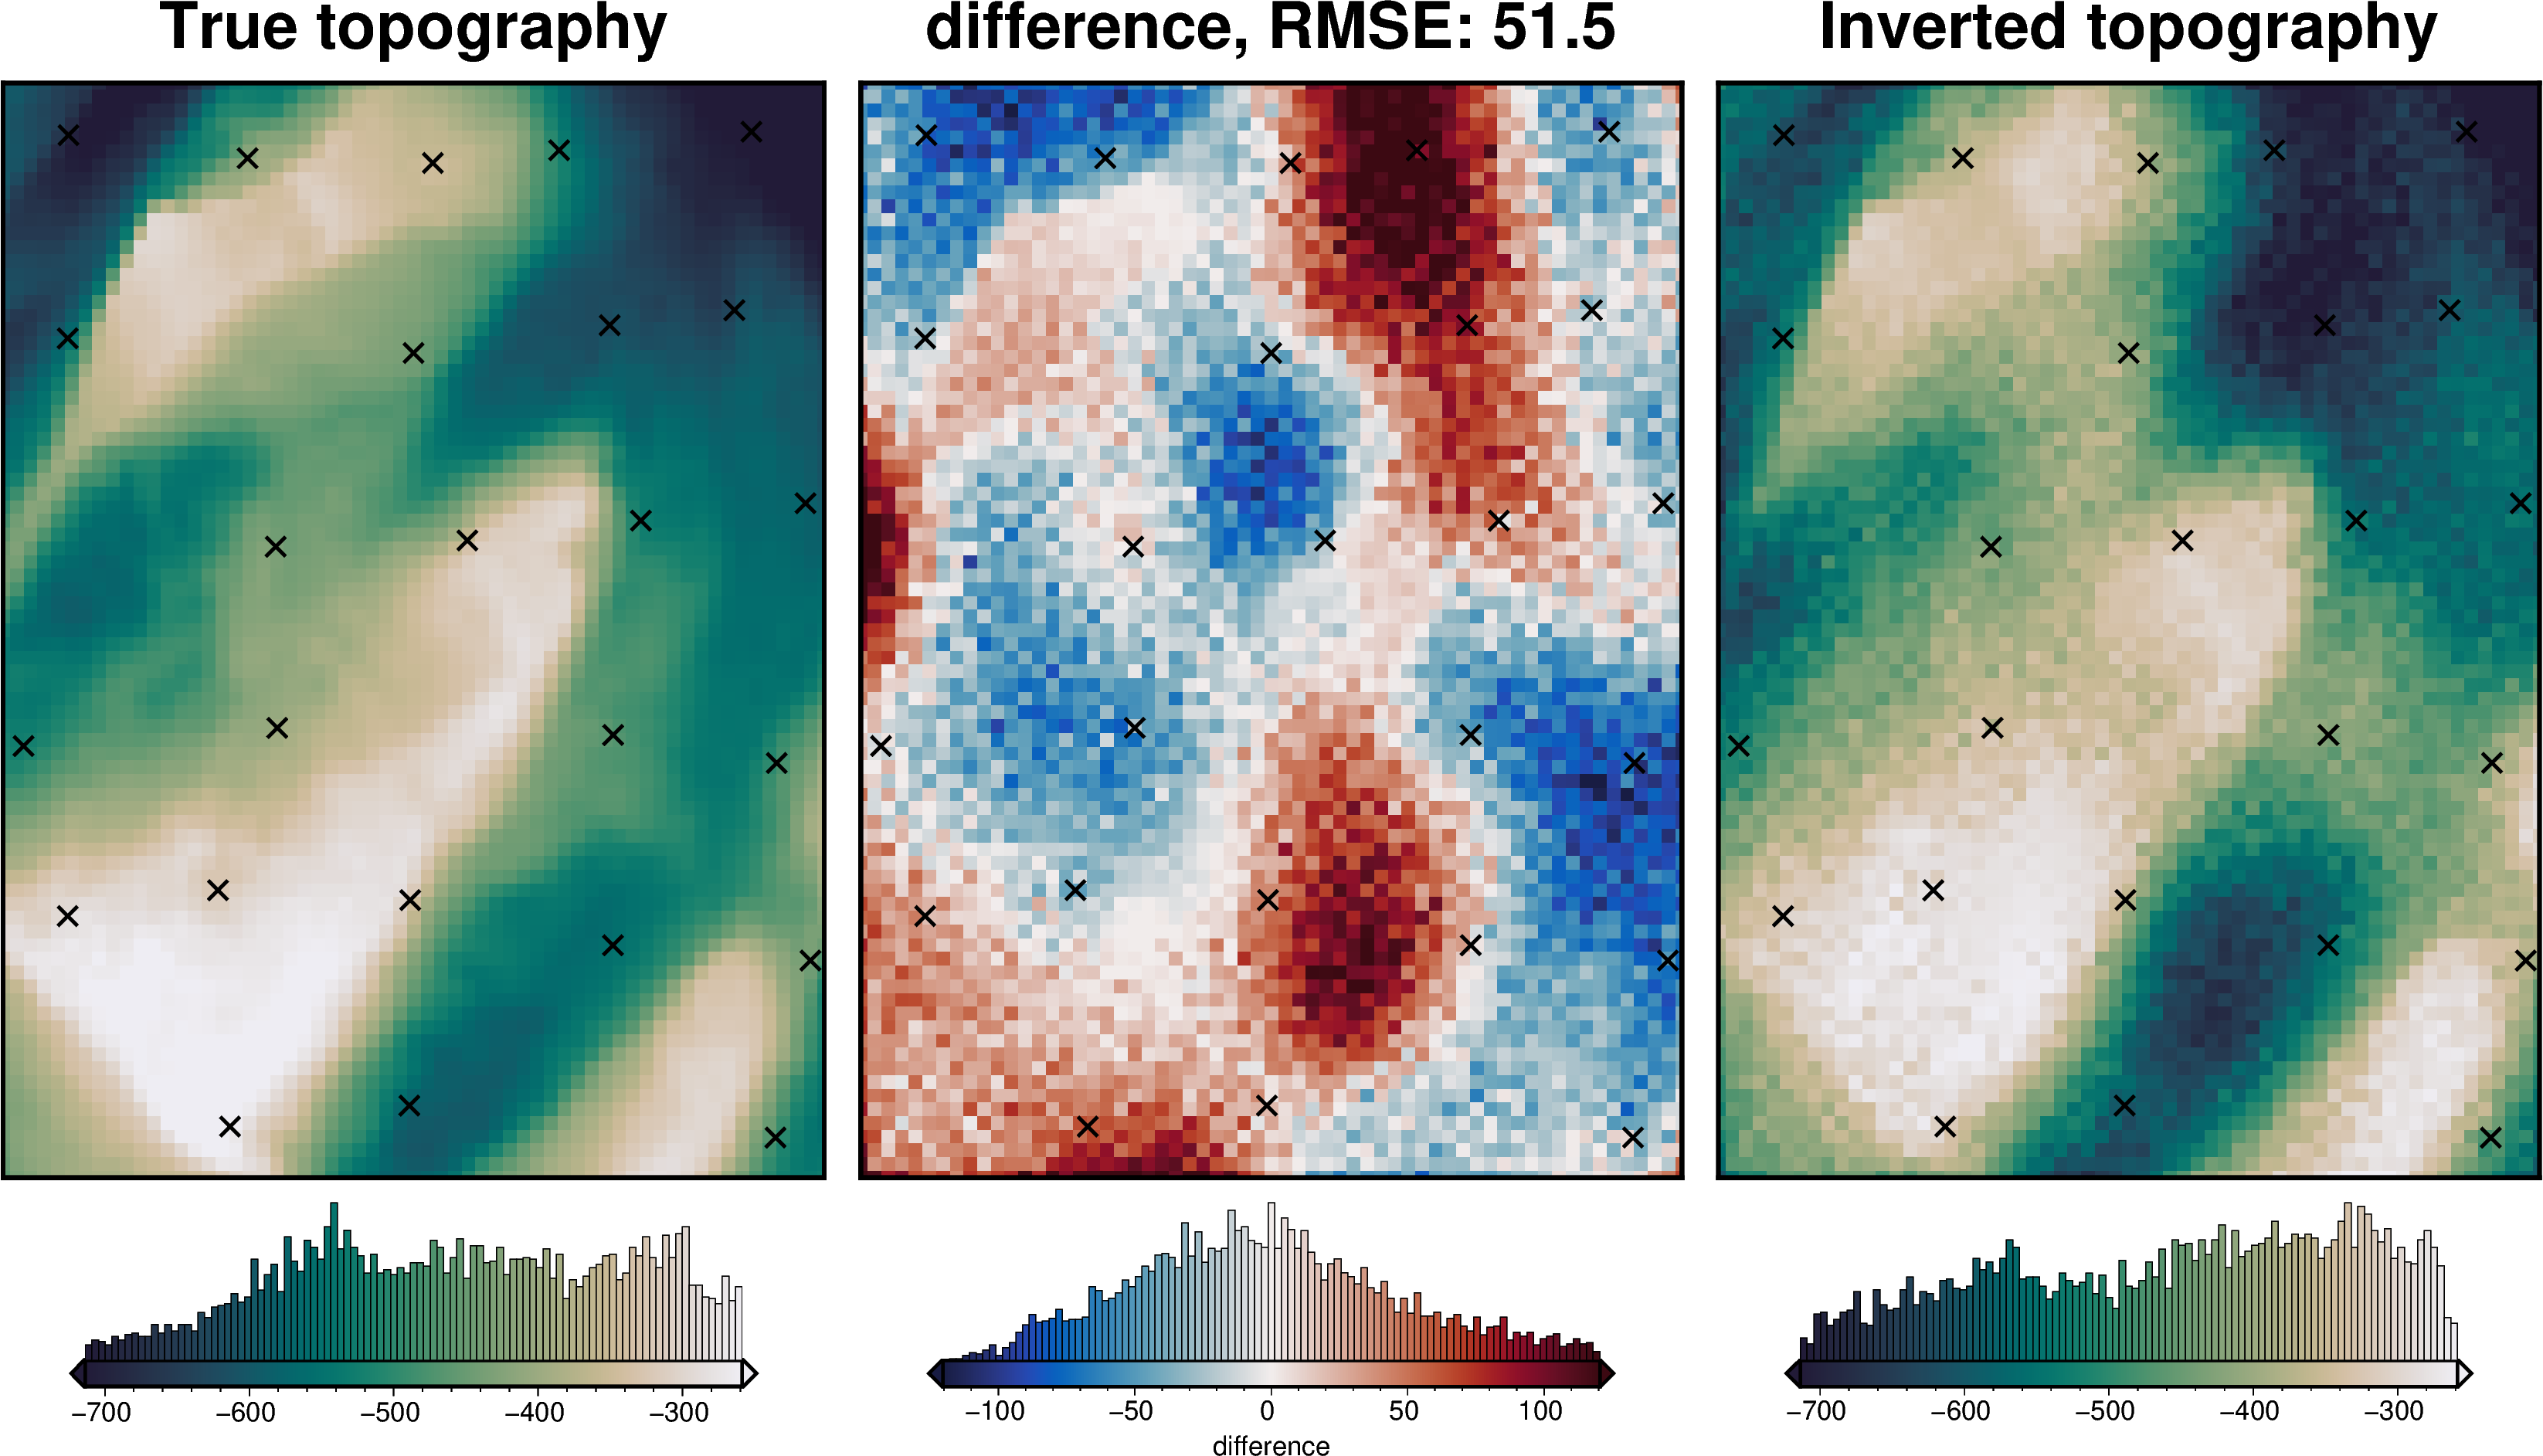

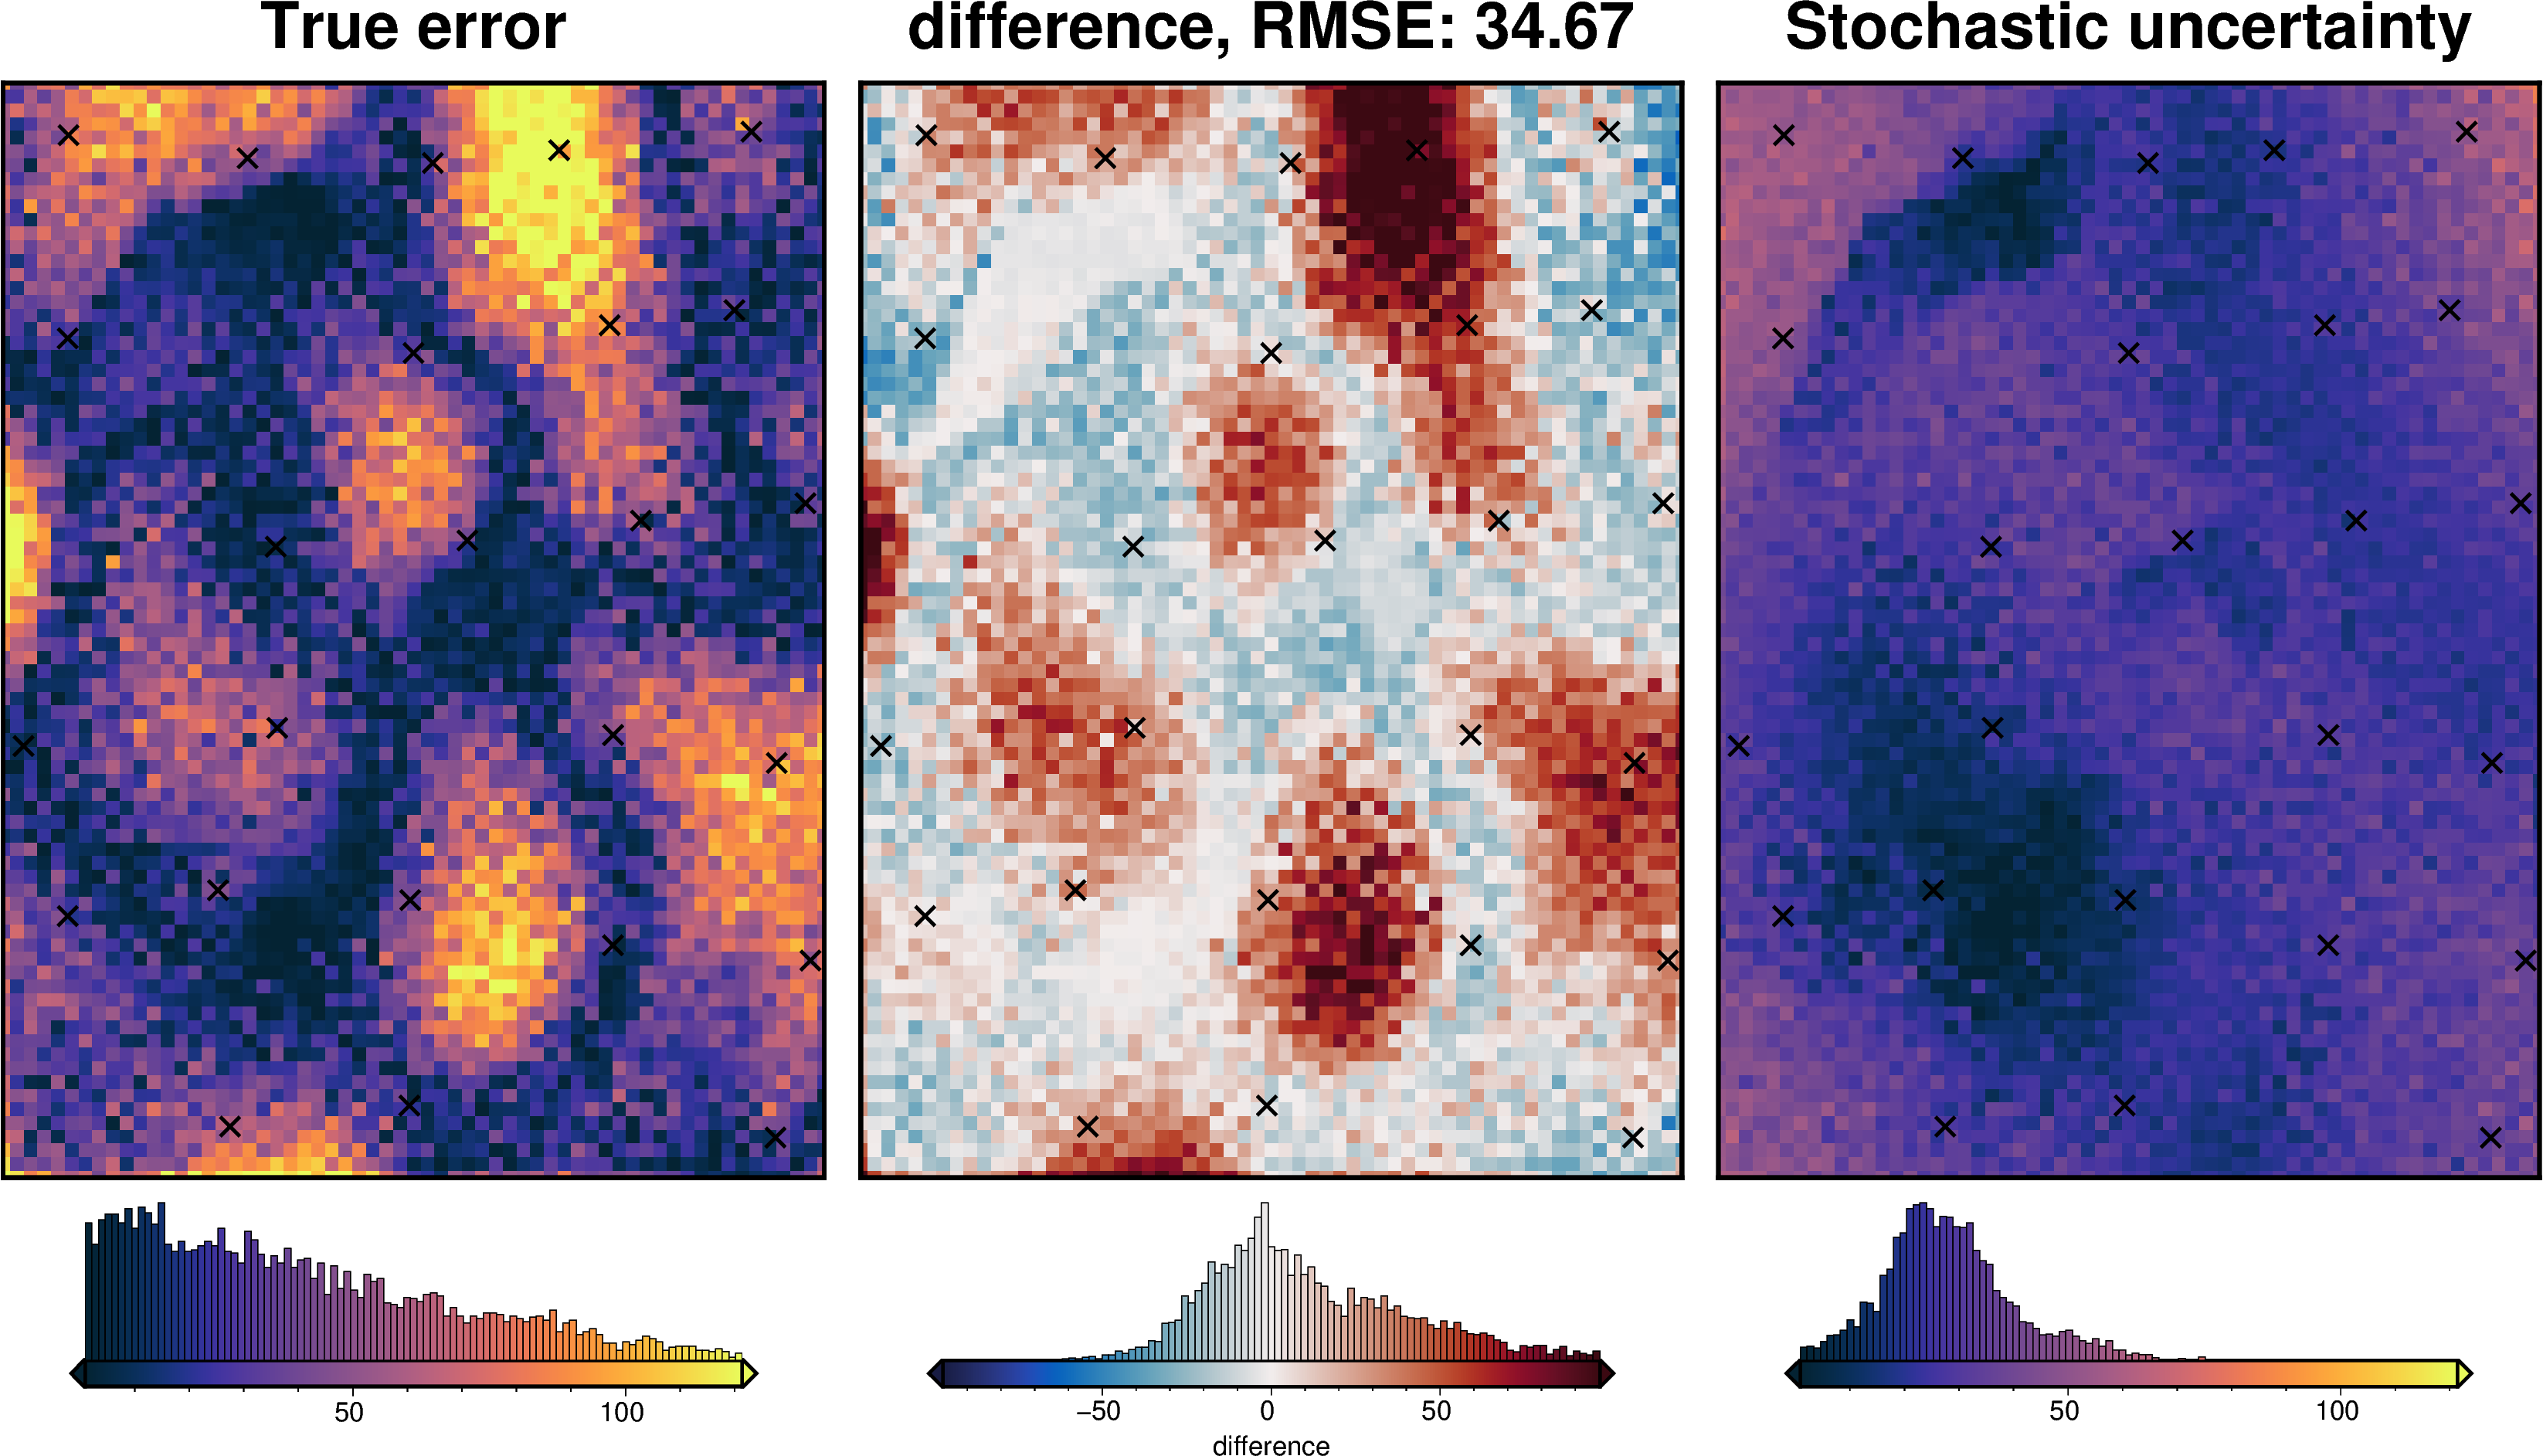

In [61]:
fname = f"{fname_start}_full"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    # choose what to sample
    sample_gravity=True,
    sample_constraints=True,
    parameter_dict=parameter_dict,
    starting_topography_parameter_dict=starting_topography_parameter_dict,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_results)

## Comparing results

In [62]:
results = [
    uncert_results,
    uncert_grav_results,
    uncert_constraints_results,
    uncert_density_results,
    uncert_damping_results,
    uncert_starting_topo_results,
    uncert_regional_results,
]

# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = uncertainty.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraint_points,
        weight_by="constraints",
    )
    stats.append(ds)

In [63]:
names = [
    "full",
    "grav",
    "constraints",
    "density",
    "damping",
    "topo",
    "regional",
]

# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs)
merged

<xarray.Dataset> Size: 382kB
Dimensions:            (northing: 93, easting: 73)
Coordinates:
  * northing           (northing) float64 744B -1.83e+06 ... -1.37e+06
  * easting            (easting) float64 584B -7e+04 -6.5e+04 ... 2.9e+05
Data variables:
    full_stdev         (northing, easting) float64 54kB 56.97 55.74 ... 78.33
    grav_stdev         (northing, easting) float64 54kB 0.008141 ... 0.01133
    constraints_stdev  (northing, easting) float64 54kB 66.93 65.39 ... 83.73
    density_stdev      (northing, easting) float64 54kB 0.02604 ... 0.02284
    damping_stdev      (northing, easting) float64 54kB 0.02552 ... 0.003731
    topo_stdev         (northing, easting) float64 54kB 2.842e-14 ... 4.547e-13
    regional_stdev     (northing, easting) float64 54kB 0.02445 ... 0.08107

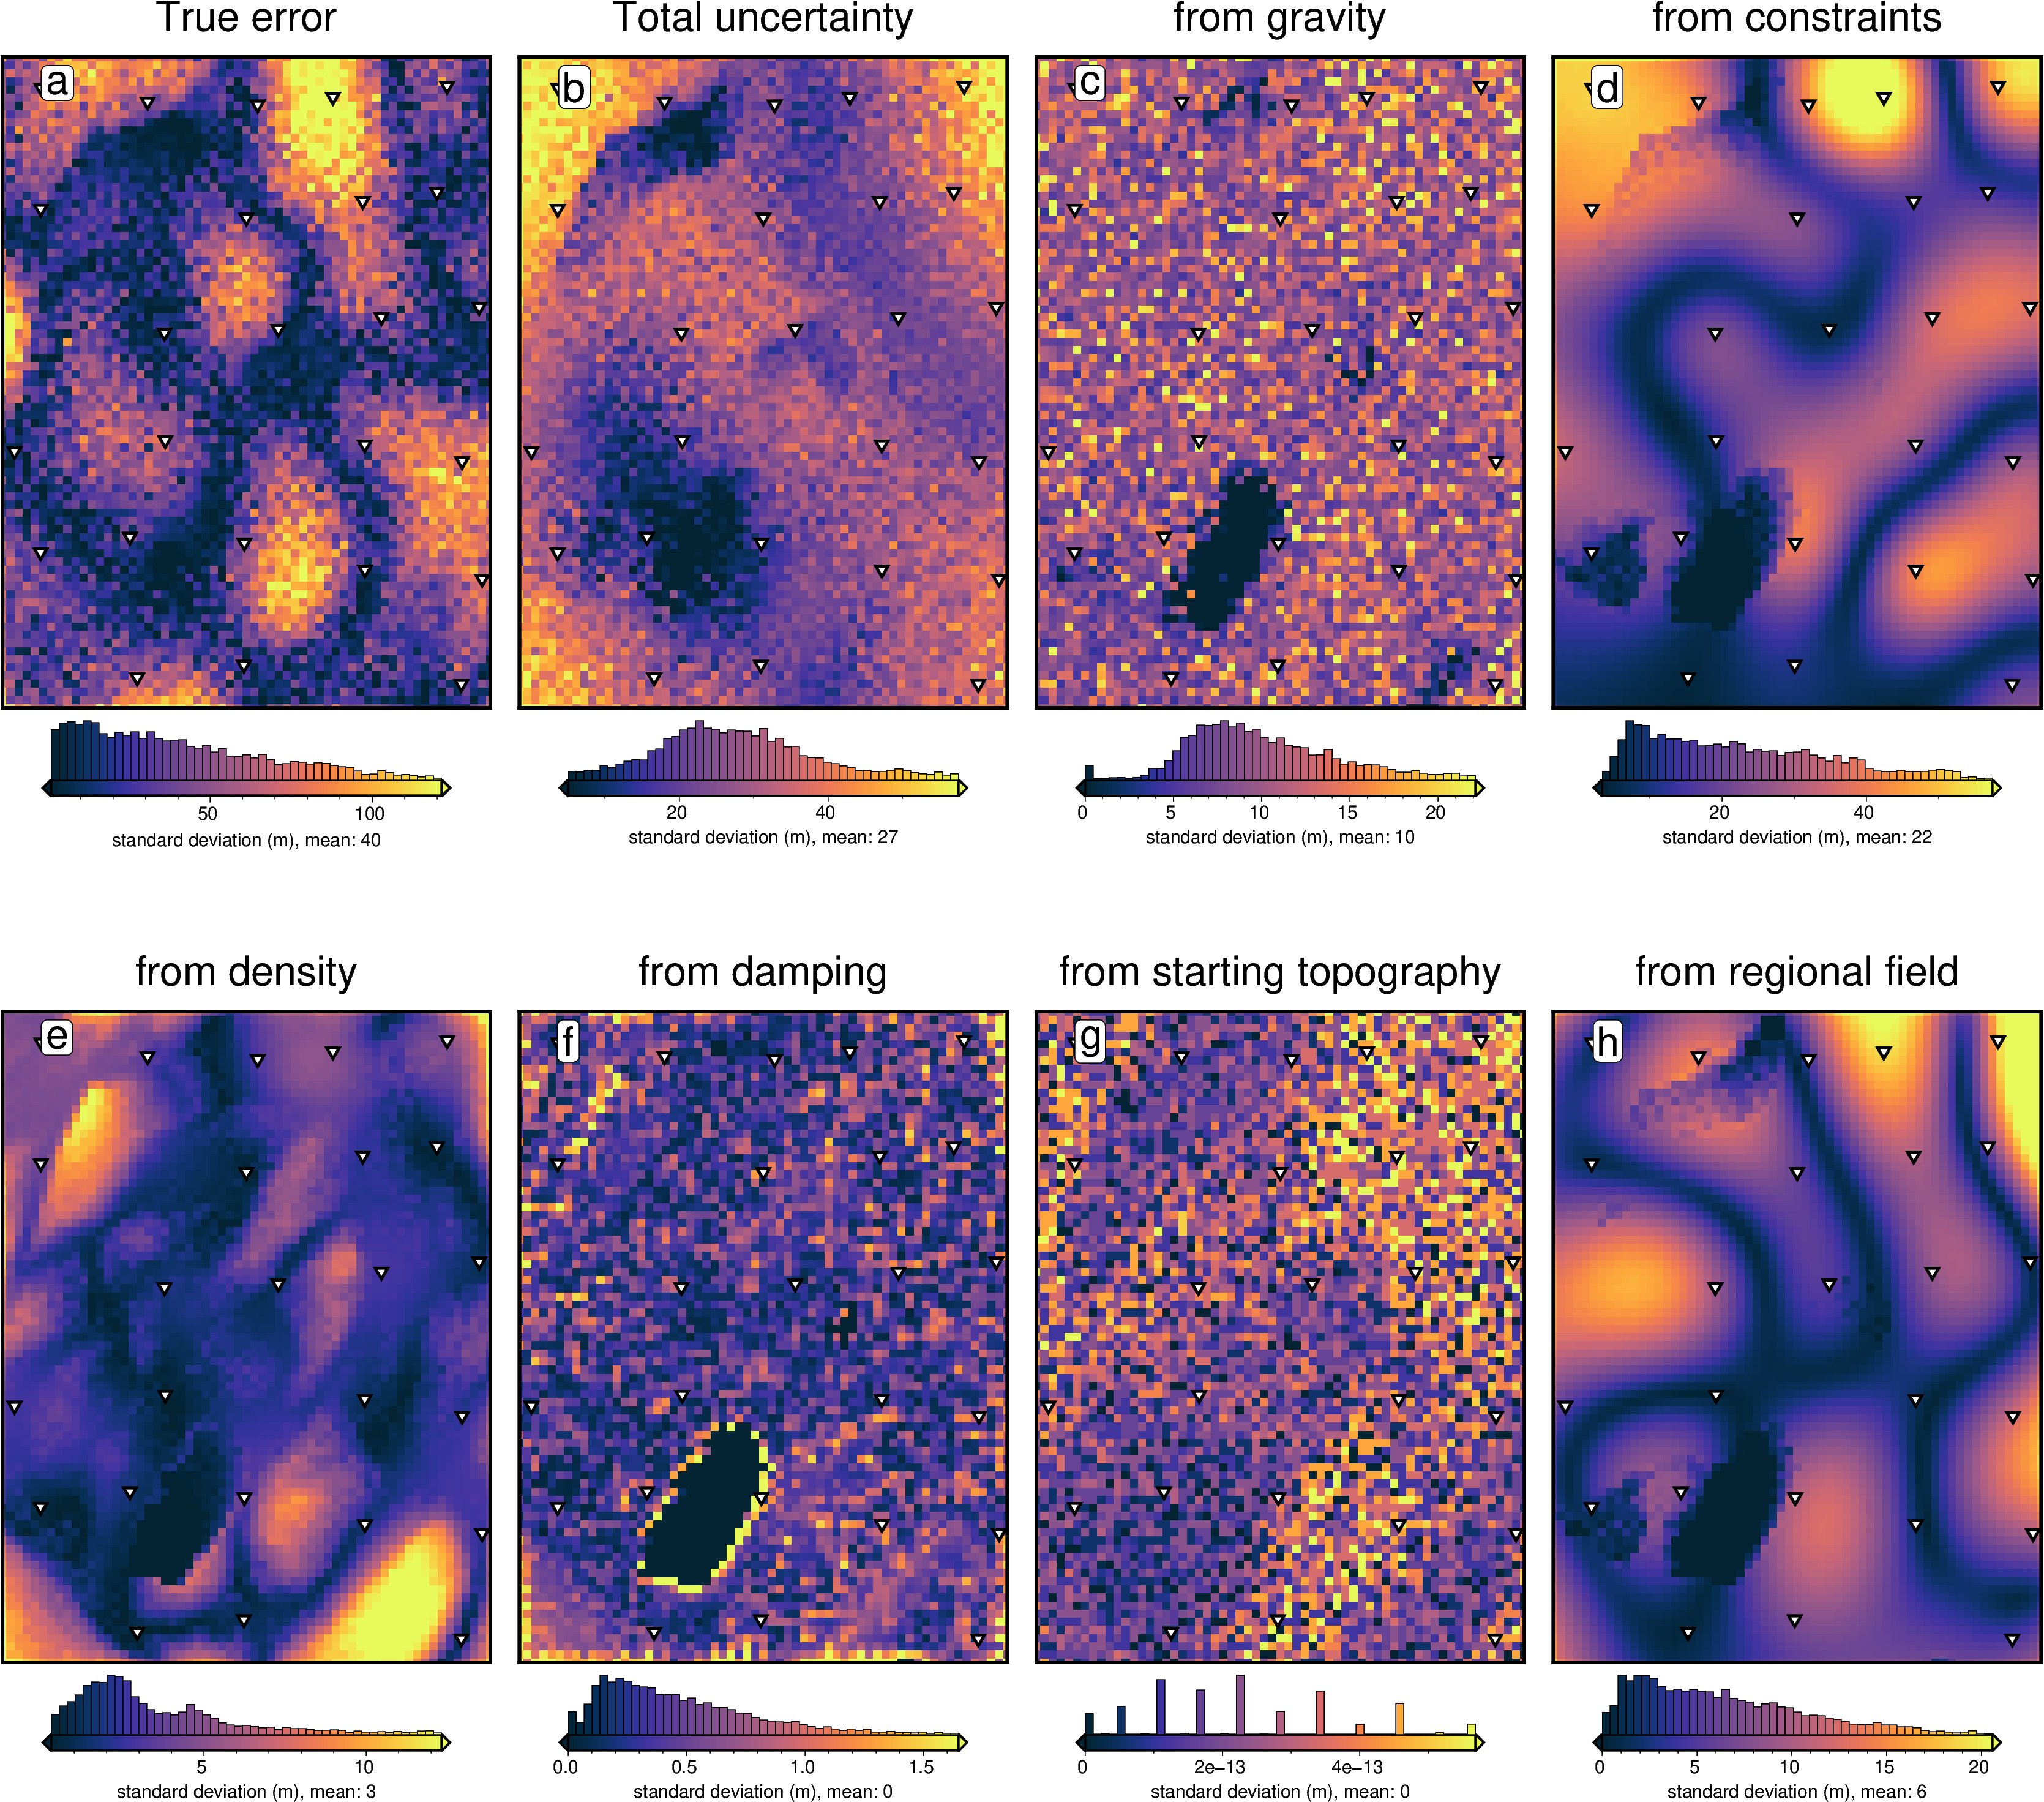

In [64]:
titles = [
    "True error",
    "Total uncertainty",
    "from gravity",
    "from constraints",
    "from density",
    "from damping",
    "from starting topography",
    "from regional field",
]
grids = list(merged.data_vars.values())

grids.insert(0, np.abs(stats[0].weighted_mean - bathymetry))
# grids.insert(0, inversion_error)

grids = [
    g.sel(
        {
            "easting": slice(*inversion_region[:2]),
            "northing": slice(*inversion_region[2:]),
        }
    )
    for g in grids
]

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
        cpt_lims = polar_utils.get_min_max(
            g,
            robust=True,
        )
    elif i == 4:
        origin_shift = "both_shift"
        xshift_amount = -3
    else:
        origin_shift = "xshift"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        title=titles[i],
        title_font="16p,Helvetica,black",
        cmap="thermal",
        # cpt_lims=cpt_lims,
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=-1.1,
    )
    fig.plot(
        x=constraint_points.easting,
        y=constraint_points.northing,
        style="i.2c",
        fill="white",
        pen="1p,black",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
fig.show()

# Regional field figures

## redo starting grav with optimal density value

In [65]:
# the true density contrast is 1476 kg/m3
density_contrast = bathymetry_density_contrast

# set the reference level from the prisms to mean of constraints
zref = 0

density_grid = xr.where(
    starting_bathymetry >=  zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)

grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

northing   easting  upward  surface_grav  icebase_grav  \
0     -1800000.0  -40000.0  1000.0      0.005089     -0.003959   
2     -1800000.0  -35000.0  1000.0      0.005307     -0.004120   
4     -1800000.0  -30000.0  1000.0      0.005530     -0.004284   
6     -1800000.0  -25000.0  1000.0      0.005755     -0.004450   
8     -1800000.0  -20000.0  1000.0      0.005984     -0.004617   
...          ...       ...     ...           ...           ...   
19472 -1400000.0  240000.0  1000.0      2.087856     -1.453847   
19474 -1400000.0  245000.0  1000.0      2.084531     -1.449061   
19476 -1400000.0  250000.0  1000.0      2.070808     -1.435254   
19478 -1400000.0  255000.0  1000.0      2.096829     -1.451071   
19480 -1400000.0  260000.0  1000.0      2.082613     -1.440349   

       bathymetry_grav  basement_grav  disturbance  uncert  starting_gravity  \
0           -28.041313      -4.951158   -32.965019     0.2         -9.748014   
2           -26.709818      -4.563623   -31.297501     0.2         -9.774341   
4           -25.914780      -4.247179   -30.031454     0.2         -9.831349   
6           -25.232630      -4.002382   -29.211552     0.2         -9.922870   
8           -24.606749      -3.845117   -28.556458     0.2        -10.052426   
...                ...            ...          ...     ...               ...   
19472       -48.314354     -11.010058   -58.338303     0.2        -48.075291   
19474       -48.346886     -11.801222   -59.708073     0.2        -48.506533   
19476       -49.069607     -12.743468   -60.889088     0.2        -48.851799   
19478       -49.867611     -13.761849   -63.287750     0.2        -49.120420   
19480       -50.824768     -14.825818   -65.113564     0.2        -49.317506   

       gravity_anomaly   true_res     misfit       reg        res  
0           -32.966148 -17.804577 -22.729414 -3.283378 -19.446037  
2           -31.298689 -16.445436 -21.034306 -3.324808 -17.709499  
4           -30.032700 -15.590531 -19.708450 -3.371826 -16.336626  
6           -29.212856 -14.812271 -18.792498 -3.425229 -15.367270  
8           -28.557825 -14.050340 -18.001415 -3.485870 -14.515546  
...                ...        ...        ...       ...        ...  
19472       -58.972313   2.171216  -8.486741 -5.867436  -2.619306  
19474       -60.343540   2.591548  -9.405107 -5.379439  -4.025669  
19476       -61.524643   2.231401 -10.223634 -4.990685  -5.232949  
19478       -63.933506   1.715488 -12.350410 -4.691332  -7.659079  
19480       -65.755829   0.965296 -13.965765 -4.469287  -9.496478  

[4941 rows x 15 columns]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 0
INFO:invert4geom:	parameter: {'damping': 1e-60}
INFO:invert4geom:	scores: [0.47049655947250957]


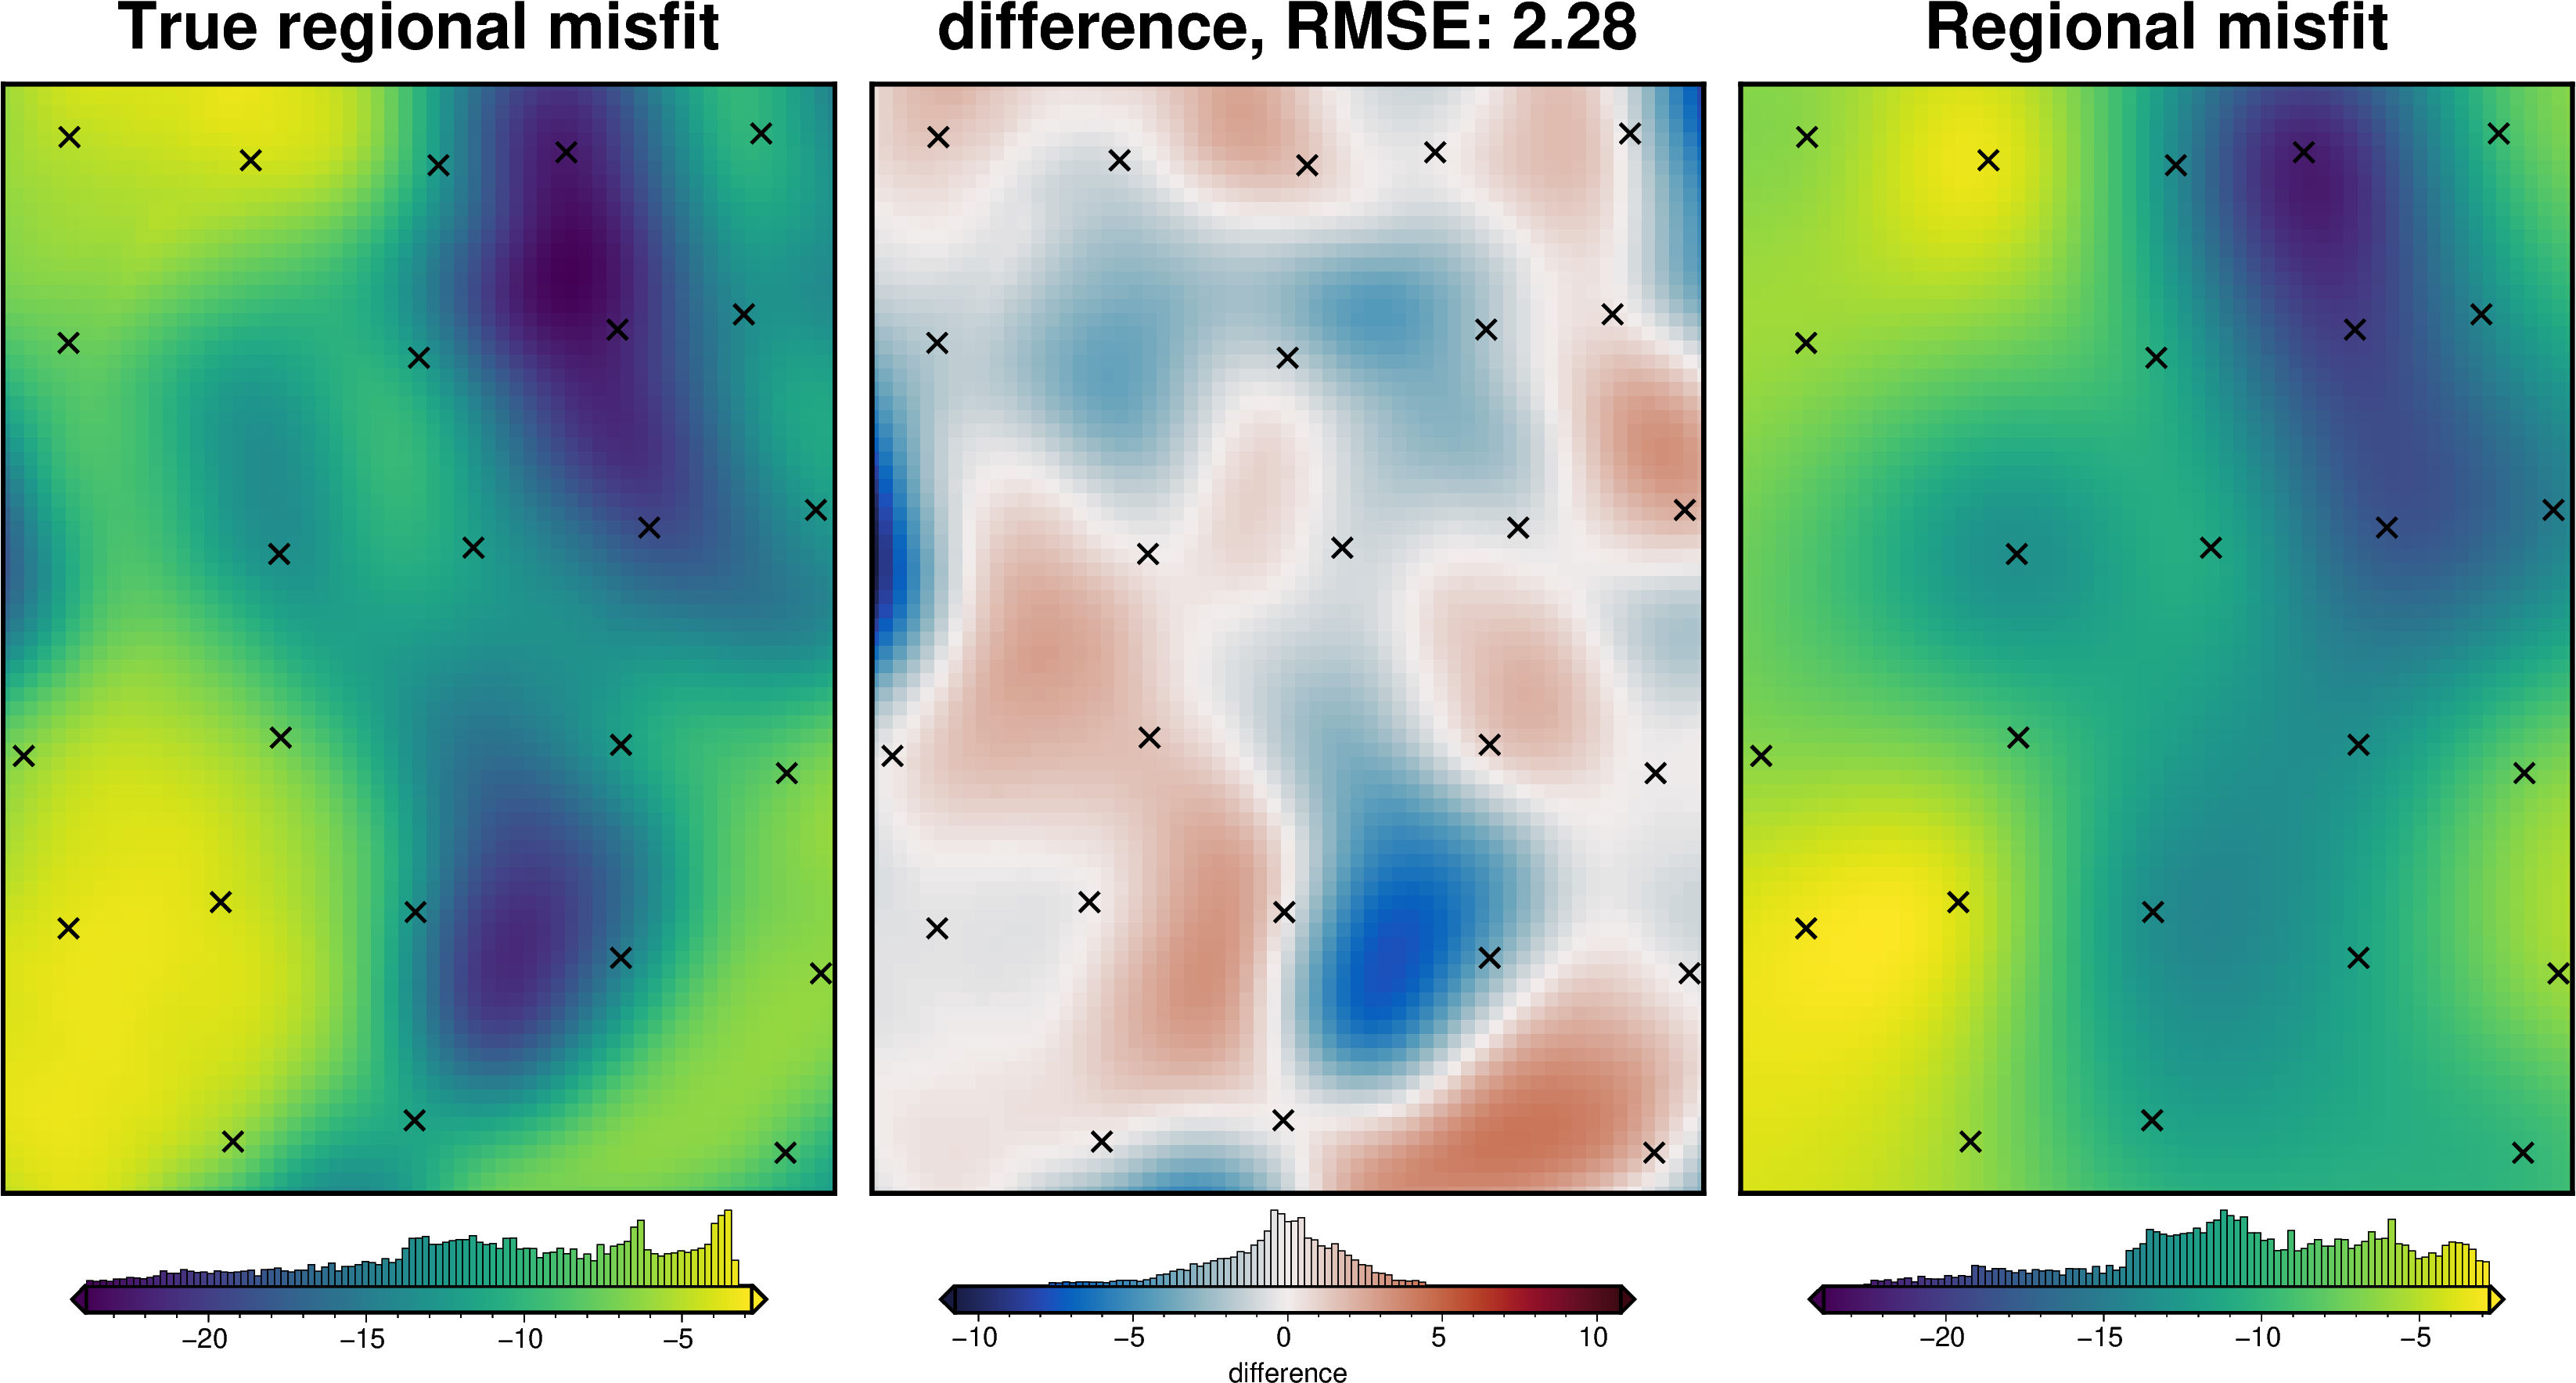

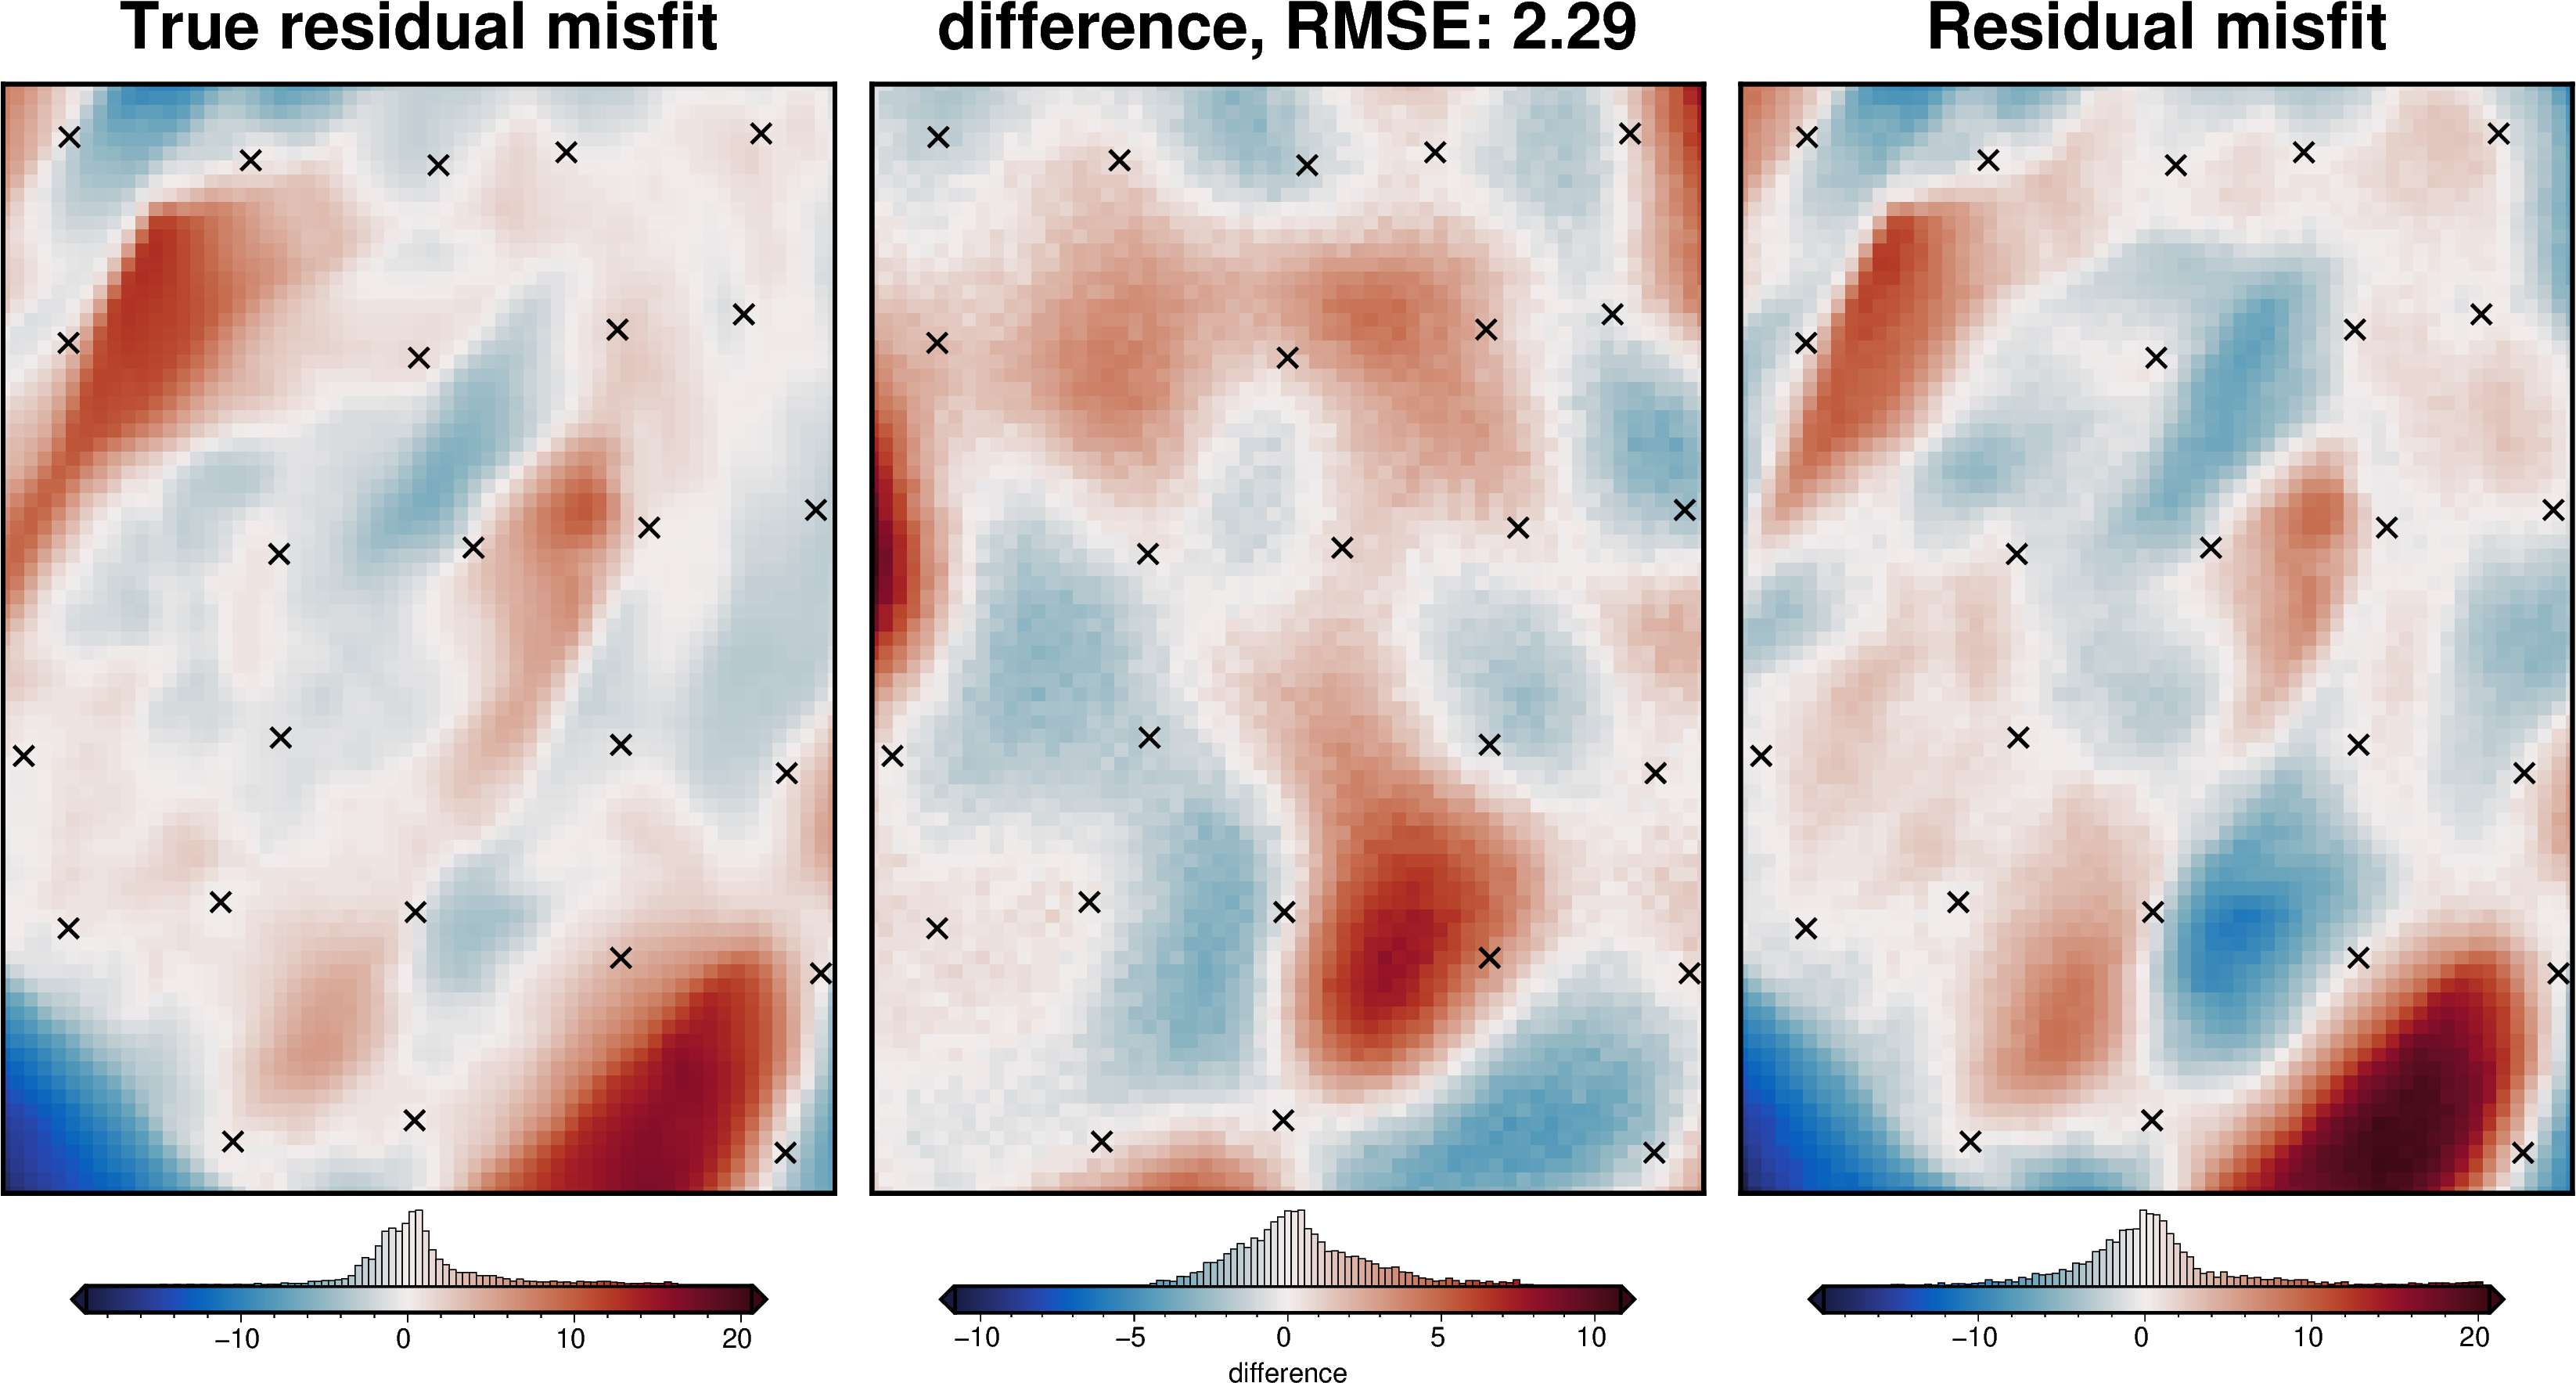

northing       easting  upward  surface_grav  icebase_grav  \
count  4.941000e+03    4941.00000  4941.0   4941.000000   4941.000000   
mean  -1.600000e+06  110000.00000  1000.0      1.836738     -1.233931   
std    1.169164e+05   88042.99419     0.0      0.533684      0.373778   
min   -1.800000e+06  -40000.00000  1000.0      0.005089     -1.820086   
25%   -1.700000e+06   35000.00000  1000.0      1.858929     -1.411509   
50%   -1.600000e+06  110000.00000  1000.0      1.974668     -1.323194   
75%   -1.500000e+06  185000.00000  1000.0      2.057541     -1.198295   
max   -1.400000e+06  260000.00000  1000.0      2.492357     -0.003959   

       bathymetry_grav  basement_grav  disturbance  uncert  starting_gravity  \
count      4941.000000    4941.000000  4941.000000  4941.0       4941.000000   
mean        -28.157864     -10.858772   -38.413830     0.2        -28.992448   
std           7.158252       5.079449    10.269510     0.0          7.466699   
min         -50.824768     -23.867676   -65.113564     0.2        -49.317506   
25%         -33.381321     -13.889131   -46.035980     0.2        -34.483934   
50%         -28.033062     -10.548373   -38.310043     0.2        -29.481902   
75%         -22.080790      -6.547249   -30.579458     0.2        -23.696645   
max         -14.744466      -3.349188   -17.554573     0.2         -9.748014   

       gravity_anomaly     true_res       misfit          reg          res  
count      4941.000000  4941.000000  4941.000000  4941.000000  4941.000000  
mean        -39.016637     0.834584   -10.024188   -10.373775     0.349586  
std          10.310528     4.521841     6.822007     4.398758     5.182361  
min         -65.755829   -18.293299   -25.213677   -22.460137   -19.273165  
25%         -46.653770    -1.269074   -14.669565   -13.065868    -2.165060  
50%         -38.941944     0.248562   -10.581935   -10.446454    -0.018175  
75%         -31.196795     1.956836    -5.449355    -6.790981     1.888882  
max         -18.174261    16.697201     9.976259    -2.787974    20.650010

In [66]:
# estimate regional with the mean misfit at constraints
grav_df = regional.regional_separation(
    grav_df=grav_df,
    **regional_grav_kwargs,
)

# calculate the true residual misfit
grav_df["true_res"] = (
    grav_df.bathymetry_grav - grav_df.starting_gravity
)

regional_comparison(grav_df)
grav_df.describe()

In [67]:
# sample gravity at constraint points
constraint_points = utils.sample_grids(
    df=constraint_points,
    grid=grav_grid.misfit,
    sampled_name="sampled_grav",
    # coord_names=("easting", "northing"),
    no_skip=True,
    verbose="q",
)
constraint_points.describe()

northing        easting  true_upward      upward     uncert  \
count  2.500000e+01      25.000000    25.000000   25.000000  25.000000   
mean  -1.590794e+06  123970.994486  -479.962505 -481.805559  23.998125   
std    1.239530e+05   94212.376564   127.354453  130.009859   6.367723   
min   -1.785357e+06  -32590.655321  -757.510594 -769.490630  12.784981   
25%   -1.698529e+06   49298.636948  -567.987428 -579.189556  19.986196   
50%   -1.569443e+06  116960.427240  -484.579173 -467.392946  24.228959   
75%   -1.488485e+06  193016.348699  -399.723926 -380.795380  28.399371   
max   -1.417798e+06  254934.311452  -255.699619 -262.657960  37.875530   

          weight  starting_bathymetry  inverted_topography  sampled_grav  
count  25.000000            25.000000            25.000000     25.000000  
mean    0.002179          -481.807871          -481.645154     -9.146893  
std     0.001348           129.913297           131.104552      4.968182  
min     0.000697          -769.311509          -767.650993    -20.568450  
25%     0.001240          -578.903376          -580.888742    -12.200866  
50%     0.001703          -467.332542          -463.589640     -9.320391  
75%     0.002503          -380.786048          -387.252909     -4.890267  
max     0.006118          -262.830441          -260.863432     -2.136780

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


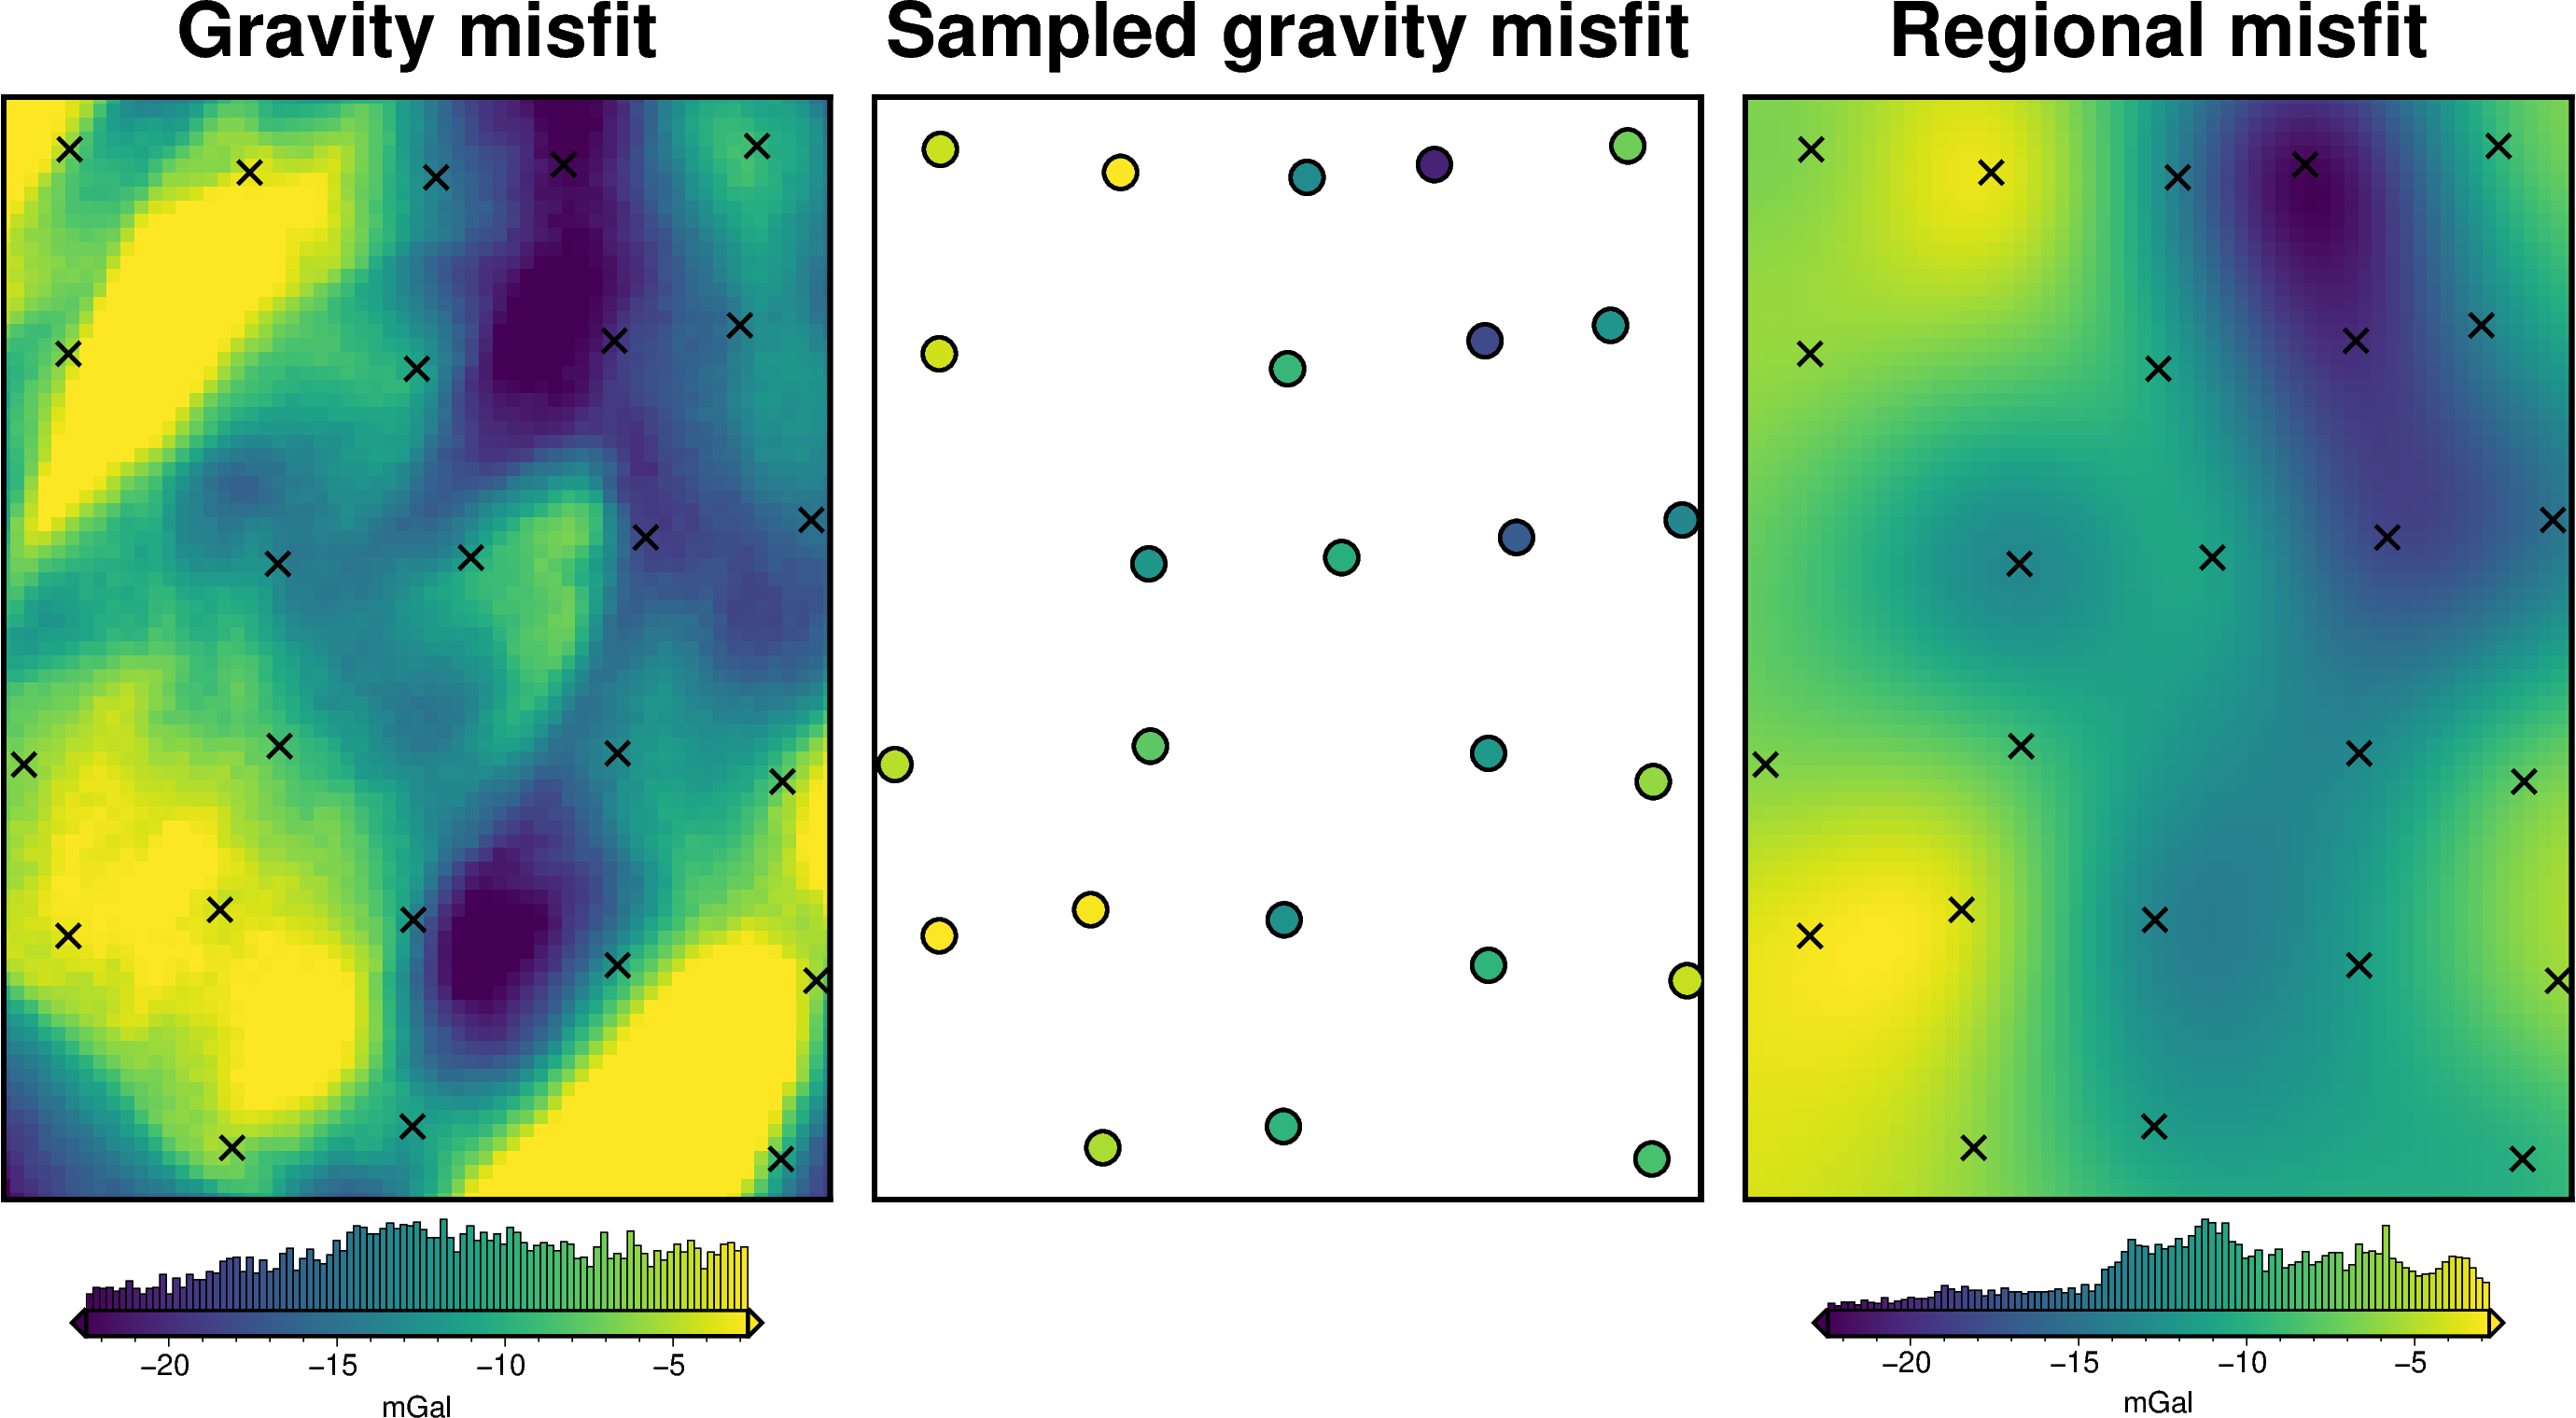

In [68]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

cpt_lims = polar_utils.get_min_max(grav_grid.reg, robust=False)

fig = maps.plot_grd(
    grav_grid.misfit,
    fig_height=10,
    title="Gravity misfit",
    cbar_label="mGal",
    cmap="viridis",
    cpt_lims=cpt_lims,
    hist=True,
    cbar_yoffset=1,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

fig = maps.basemap(
    fig_height=10,
    region=inversion_region,
    title="Sampled gravity misfit",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    fig=fig,
    origin_shift="x",
)
pygmt.makecpt(
    cmap="viridis",
    series=cpt_lims,
    continuous=True,
    output="tmp.cpt",
    background=True,
)
fig.plot(
    x=constraint_points.easting,
    y=constraint_points.northing,
    style="c.3c",
    pen="1p,black",
    fill=constraint_points.sampled_grav,
    cmap="tmp.cpt",
)

fig = maps.plot_grd(
    grav_grid.reg,
    fig_height=10,
    title="Regional misfit",
    cbar_label="mGal",
    cmap="viridis",
    cpt_lims=cpt_lims,
    hist=True,
    cbar_yoffset=1,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
    fig=fig,
    origin_shift="x",
)

fig.show()